In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.autograd import Function
from torch.nn.parameter import Parameter
from torch import autograd 

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import mean_squared_error

import numpy as np
from numpy import linalg as LA
import random

import jax

# from mpltools import annotation

from scipy.io import savemat, whosmat
from scipy.optimize import fsolve
import time
import os
import sys 
from tempfile import TemporaryFile

import copy
import pathlib
import scipy.signal

import io
import signal


In [2]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.config import config
config.update("jax_enable_x64", True)

key = random.PRNGKey(0)
x = random.normal(key, (10,))
print(x)

[ 1.05451609 -0.96928879 -0.59460177 -0.03188579  2.41093278 -1.87844856
 -0.78476944 -0.31370829  0.33370904  1.76770368]


# Artificial Data generation 

In [3]:
n_train =512
N = 1
d=32

# Redo data set
class simple_3_FCN_teacher(nn.Module): 
    def __init__(self): 
        super().__init__()  
        torch.manual_seed(222)
        self.linear1 = nn.Linear(in_features=d, out_features=N, bias=False)  
        self.linear2 =  nn.Linear(in_features=N, out_features=N, bias=False)  
        self.linear3 = nn.Linear(in_features=N, out_features=1, bias=False)  
 
    def forward(self, x): 
        x = torch.erf(self.linear1(x)) 
        x = torch.erf(self.linear2(x)) 
        x = self.linear3(x) 
        return x 
     
teacher = simple_3_FCN_teacher() 
 
np.random.seed(111)
X_train = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n_train, d))).to(dtype=torch.float)
np.random.seed(111+1)
X_test = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n_train, d))).to(dtype=torch.float)


Y_train = teacher(X_train).detach() 
Y_test = teacher(X_test).detach() 


X_train = X_train[:,:].numpy()
Y_train = Y_train.numpy()


## Several Kernel functions

In [4]:
sigw2 = 2. # Prior variance for all hidden weights 
siga2 = 2./256 # Prior variance output weight -- with a 1/256 mean-field scaling 

sig2 = 0.001

Sigma0 = sigw2*jnp.eye(d)/np.float(d)


device = jax.devices()[0]

In [5]:


@jit
def getQ1_(Sigma,x,y): # Post kernel of the hidden layer 
    x = jnp.asarray(x)
    y = jnp.asarray(y)
    Sigma = jnp.asarray(Sigma)
    xsy = jnp.einsum('a,ab,b',x,Sigma,y) #x@Sigma@y.T)
    ysy = jnp.einsum('a,ab,b',y,Sigma,y) #y@Sigma@y.T
    xsx = jnp.einsum('a,ab,b',x,Sigma,x) #x@Sigma@x.T
    deno_fac_x = jnp.sqrt(1+2*xsx)
    deno_fac_y = jnp.sqrt(1+2*ysy)
    return (sigw2)*(2./np.pi)*jnp.arcsin(2*xsy/(deno_fac_x*deno_fac_y))

def getQ1(Sigma,x,y): # Jax wrapper 
  
    x = jnp.array(x)
    y = jnp.array(y.transpose())
    vv = lambda x,y: getQ1_(Sigma,x,y) #lambda x, y: jnp.vdot(x, y)  #  ([a], [a]) -> []
    mv = vmap(vv, (0, None), 0)      #  ([b,a], [a]) -> [b]      (b is the mapped axis)
    mm = vmap(mv, (None, 1), 1)      #  ([b,a], [a,c]) -> [b,c] 
    vgetQf = jax.jit(mm)
    res = vgetQf(x,y)
    return res

@jit
def getQf(K1): # Output kernel as a function of the pre-kernel of the hidden layer
   
    xsy = K1 
    ysy = jnp.diag(K1)[jnp.newaxis,:] 
    xsx = jnp.diag(K1)[:,jnp.newaxis]
    deno_fac_x = jnp.sqrt(1+2*xsx)
    deno_fac_y = jnp.sqrt(1+2*ysy)
    return siga2*(2./np.pi)*jnp.arcsin(2*xsy/(deno_fac_x*deno_fac_y)) # potential bug in older version: siga2*sigw2*(2./np.pi)*jnp.arcsin(2*xsy/(deno_fac_x*deno_fac_y))

def gettbar(x_train,y_train,Qf): # The train discrepancy (\delta) 
    Qftilde = Qf + sig2*np.eye(Qf.shape[0])
    t = np.linalg.inv(Qftilde)@y_train
    return t

   

In [6]:

@jit
def get_K1_shift_potential(K1,Qf_inert,t,C2): # the shift refers of the last term on the r.h.s. of the EoS for K^{-1}
    Qf = getQf(K1)
    tt = t*t.T
    KfInv = jax.scipy.linalg.inv(Qf_inert + sig2*np.eye(n_train)) 
    return jnp.trace((tt+KfInv)@Qf)/C2

get_K1_shift = jax.grad(get_K1_shift_potential,argnums=0)

@jit
def get_Sigma_shift_potential(Sigma,K1,Q1_inert,C1,C2,x,y): # the shift here refers to the last term on the r.h.s in the EoS for \Sigma^{-1}
    Q1 = getQ1(Sigma,x,y)
    Q1_inv = jax.scipy.linalg.inv(Q1_inert)
    return jnp.trace((Q1_inv@K1@Q1_inv-Q1_inv)@Q1)

get_Sigma_shift = jax.grad(get_Sigma_shift_potential,argnums=0)



## Detour: Emergent Scale for the FCN 

In [7]:

Nstat = 10
chis = []
chi_vars = []
MSEs = []
MSE_vars = []
ns = [16,32,64,128,256,512,1024,2048]
for n in ns:
    chi = []
    MSE = []
    print('*****')
    for stat in range(Nstat):
        n_train = n
        teacher = simple_3_FCN_teacher() 
        X_train = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n_train, d))).to(dtype=torch.float)
        X_test = torch.tensor(np.random.normal(loc=0,scale=1.,size=(n_train, d))).to(dtype=torch.float)
        Y_train = teacher(X_train).detach() 
        Y_test = teacher(X_test).detach() 
        X_train = X_train[:,:].numpy()
        Y_train = Y_train.numpy()
      
        Sigma0 = sigw2*np.eye(d)/np.float(d)
        Q1 = getQ1(Sigma0,X_train,X_train)
        Qf = getQf(Q1)
        
        t0 = gettbar(X_train,Y_train,Qf)
        
        tmp = t0.T@Q1@t0
        
        chi += [tmp]
        MSE += [sig2*(np.linalg.norm(t0)**2)/(n)]
        print(tmp,MSE[-1])
     
    chis += [np.mean(chi)]
    MSEs += [np.mean(MSE)]
    chi_vars += [np.var(chi)/Nstat]
    MSE_vars += [np.var(MSE)/Nstat]

*****
[[47859.40284085]] 2.8269321123621807
[[99385.58910654]] 5.500374468951075
[[32084.51663108]] 2.618368370314071
[[96027.87269497]] 3.471063782951563
[[73611.90007413]] 4.227853015387852
[[84838.27550533]] 3.2602307230887524
[[42546.63256162]] 3.393664771540922
[[84545.04128091]] 4.584156764975971
[[93212.95869198]] 3.8634780648228366
[[53347.85997088]] 2.4701615120581324
*****
[[114637.29968855]] 4.495973500625569
[[142284.51910414]] 4.116280753430224
[[135130.69369977]] 3.2556348413801897
[[158366.58145482]] 3.5735573600919848
[[144258.46291344]] 3.885515792411735
[[117220.86720006]] 3.64902556480599
[[104945.70799553]] 2.821699830980326
[[134572.19699184]] 2.872911473320707
[[128083.13850705]] 3.316551303064957
[[134943.38619757]] 4.268545680938666
*****
[[249028.13719916]] 2.1743693860696838
[[223513.23256715]] 2.433378059590046
[[206312.56391752]] 2.53045206888442
[[215955.39582143]] 2.1481356328744625
[[199076.77231673]] 2.0307735395122566
[[185869.49317632]] 2.2873519631768

In [8]:
print(chis)

[70746.00493582877, 131444.2853752783, 205789.33728532813, 291572.1498114479, 362339.6082349659, 456836.169049894, 589526.2916675621, 881280.474787832]


In [9]:
# For reference, emergent scale data obtained for different DNN/scaling for d=64 n=1024
chis = [0.4630397277601751, 0.8491504654285201, 1.556412896519714, 2.320580323430827, 3.1305420667827577, 4.315994552592772, 6.395279143638707, 10.4891452002534]
chis_MF256 = [18170.70963601519, 34319.87735816138, 63774.9995685343, 101524.4010605413, 142174.68773642217, 178546.6248369021, 220693.7444973183, 287534.45947243075]
chis_CNN = [1534.62204972   ,3092.28867035 , 5953.49226288,  12093.70299487,23507.05411243 , 47406.59677068 , 93575.52418854 ,191605.28781995]

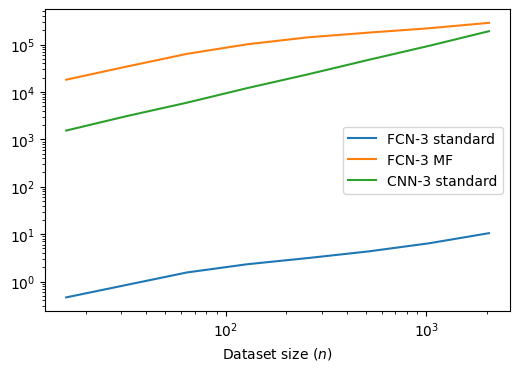

In [16]:

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.plot(ns, chis, label='FCN-3 standard')
plt.plot(ns, chis_MF256, label='FCN-3 MF')
plt.plot(ns, chis_CNN, label='CNN-3 standard')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Dataset size ($n$)')
plt.legend()


#plt.errorbar(ns, MSEs, yerr=np.sqrt(MSE_vars))
plt.show()

# Solving the EoS

In [11]:

def getSigma(x_train,Sigma,K1,Q1,C1,C2): # yields Sigma of the main text 
    Sigma_shift = get_Sigma_shift(Sigma,K1,Q1,C1,C2,x_train,x_train)
    retVal = np.linalg.inv(np.eye(d)*d/sigw2 - Sigma_shift)
    return retVal 

def getK1(K1,Q1,Qf,t,C2): # yields K1 of the main text
    K1_shift = get_K1_shift(K1,Qf,t,C2)
    retVal = np.linalg.inv(np.linalg.inv(Q1) - K1_shift)
    return retVal 


# rootEq returns a zero vector when all the EoS are satisfied. \
# The ras is a big concatenated vector of containing Sigma, K1
def rootEq(ras,x_train,y_train,C1,C2): 
    Sigma = np.zeros((d,d))
    indSig = np.triu_indices(d, k=0)
    K1 = np.zeros((x_train.shape[0],x_train.shape[0]))
    indK1 = np.triu_indices(x_train.shape[0], k=0)
    
    Sigma[indSig] = ras[0:ind[0].shape[0]]
    Sigma = Sigma + Sigma.T - np.diag(np.diag(Sigma))
    K1[indK1] = ras[ind[0].shape[0]:]
    K1 = K1 + K1.T - np.diag(np.diag(K1))
    
    Qf = getQf(K1)
    Q1 = getQ1(Sigma,x_train,x_train)
    tbar = gettbar(x_train,y_train,Qf)
    
    
    retVal = Sigma-getSigma(x_train,Sigma,K1,Q1,C1,C2)
    retVal2 = K1-getK1(K1,Q1,Qf,tbar,C2)
    
    KfInv = scipy.linalg.inv(Qf + sig2*np.eye(n_train))
   

    return np.concatenate([retVal[indSig],retVal2[indK1]])

                      

In [12]:
# Our initial guess for the solution is the GP limit 
Sigma0 = sigw2*np.eye(d)/np.float(d)
ind = np.triu_indices(d, k=0)
Q1 = getQ1(Sigma0,X_train,X_train)
indK = np.triu_indices(n_train, k=0)
Qf = getQf(Q1)


x_res = [np.concatenate([Sigma0[ind],Q1[indK]])] # Vectorizing this so it can passed to rootEq 

fluc = np.trace(Qf - Qf@np.linalg.inv(Qf+np.eye(n_train)*sig2)@Qf)/n_train # GP prediction for DNN-ensemble fluctuations 
tbar= gettbar(X_train,Y_train,Qf) # GP prediction for the discrepancy 

print('At GP limit, alpha train is',np.sum(tbar*Y_train)/np.sum(Y_train*Y_train)) 
print('At GP limit, RMSE/y_std is',np.sqrt(((sig2**2)*np.mean(tbar**2)+fluc)/np.var(Y_train))) 

At GP limit, alpha train is 24.73256055948508
At GP limit, RMSE/y_std is 0.1213603845990778


***************************  30000  *************************
0:  |F(x)| = 0.000936818; step 1
1:  |F(x)| = 0.000701224; step 1
2:  |F(x)| = 6.10438e-07; step 1


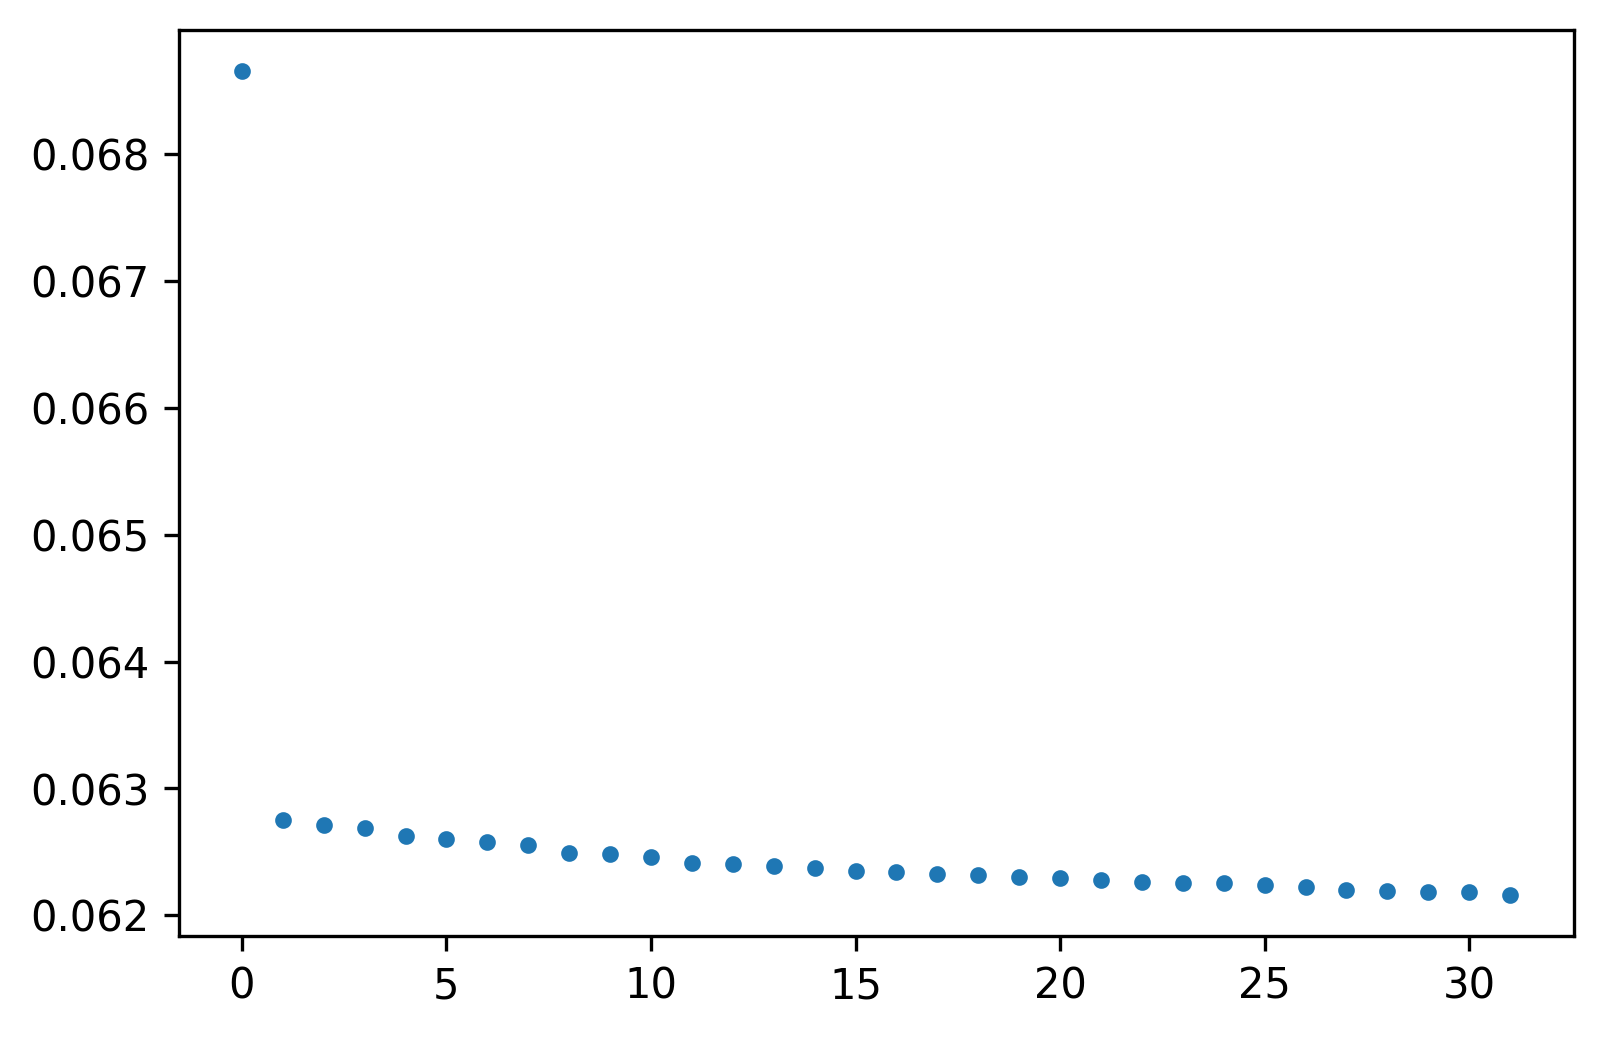

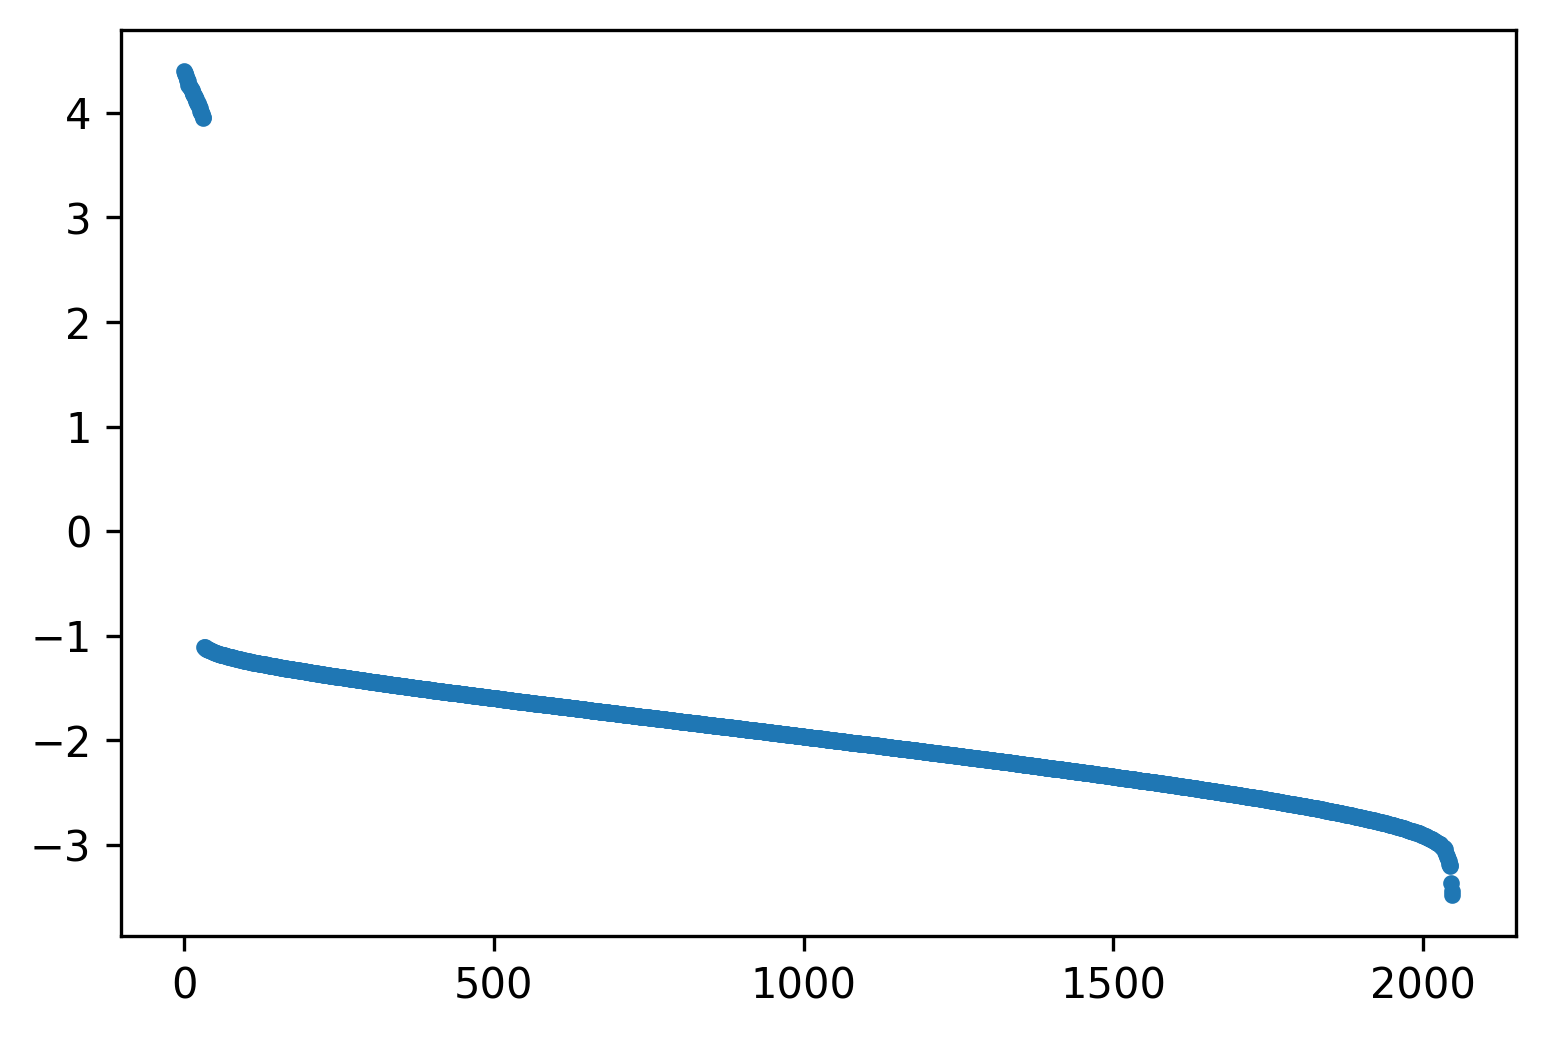

At  30000 channels, alpha is 22.304935299045635
At  30000 channels, RMSE/y_std is 0.1162400829572338
***************************  20000  *************************
0:  |F(x)| = 0.000184285; step 1
1:  |F(x)| = 2.5629e-06; step 1


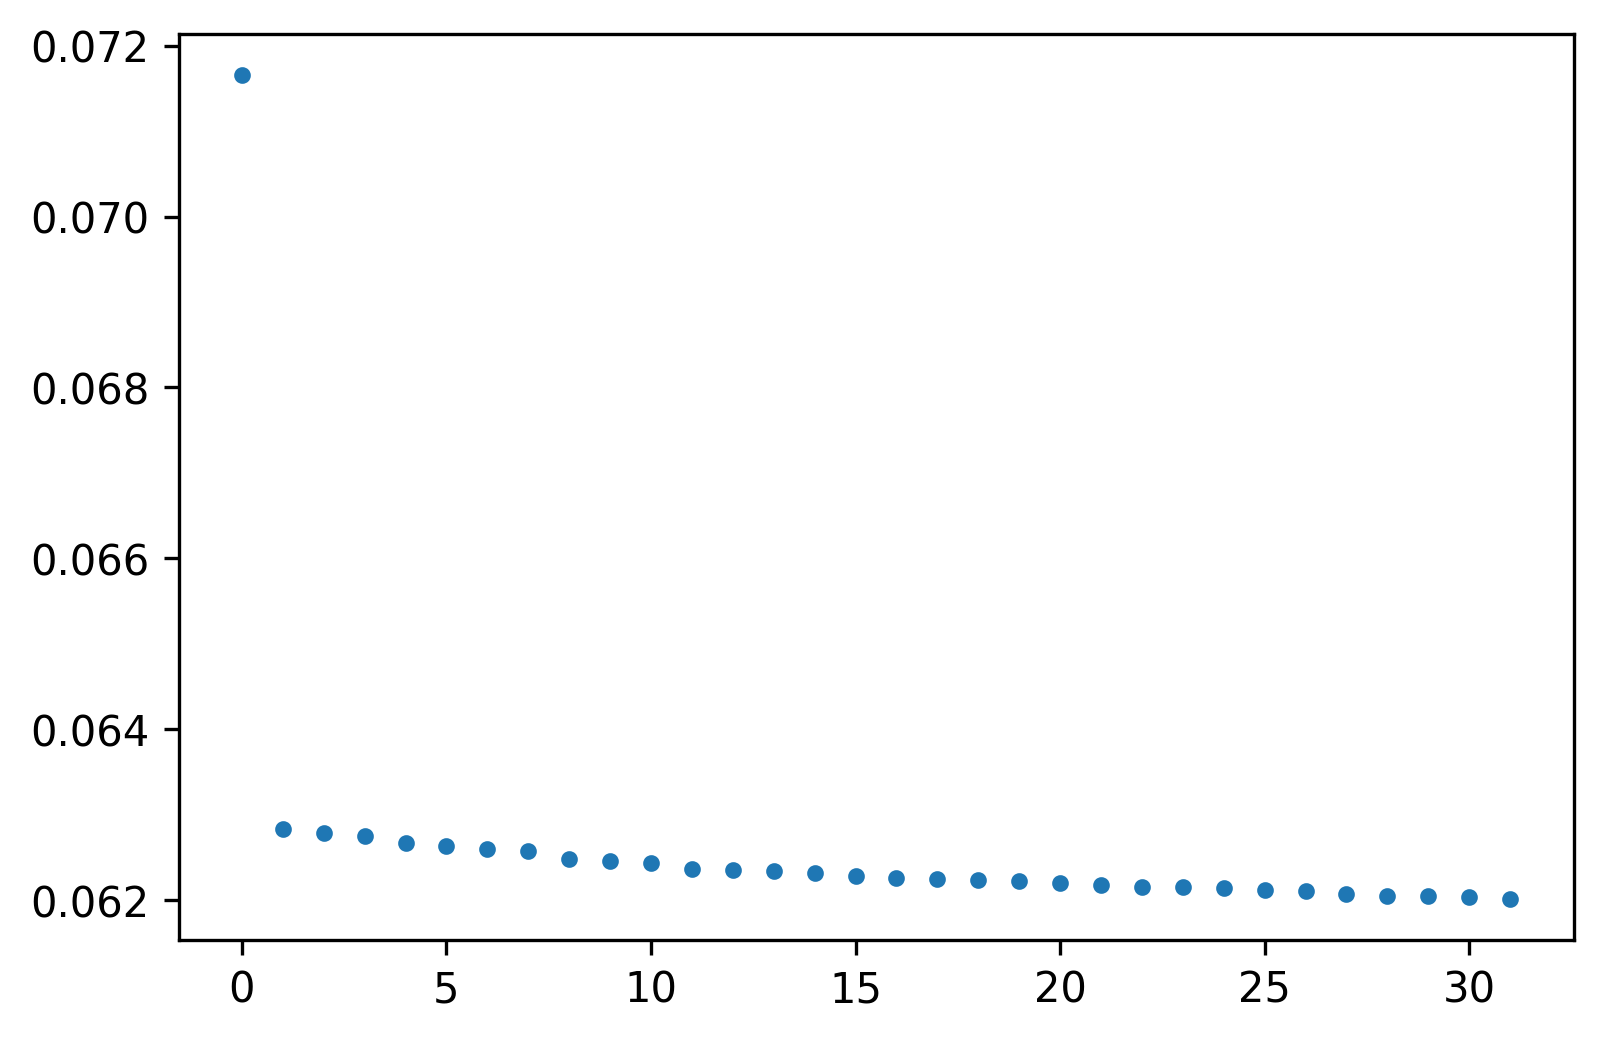

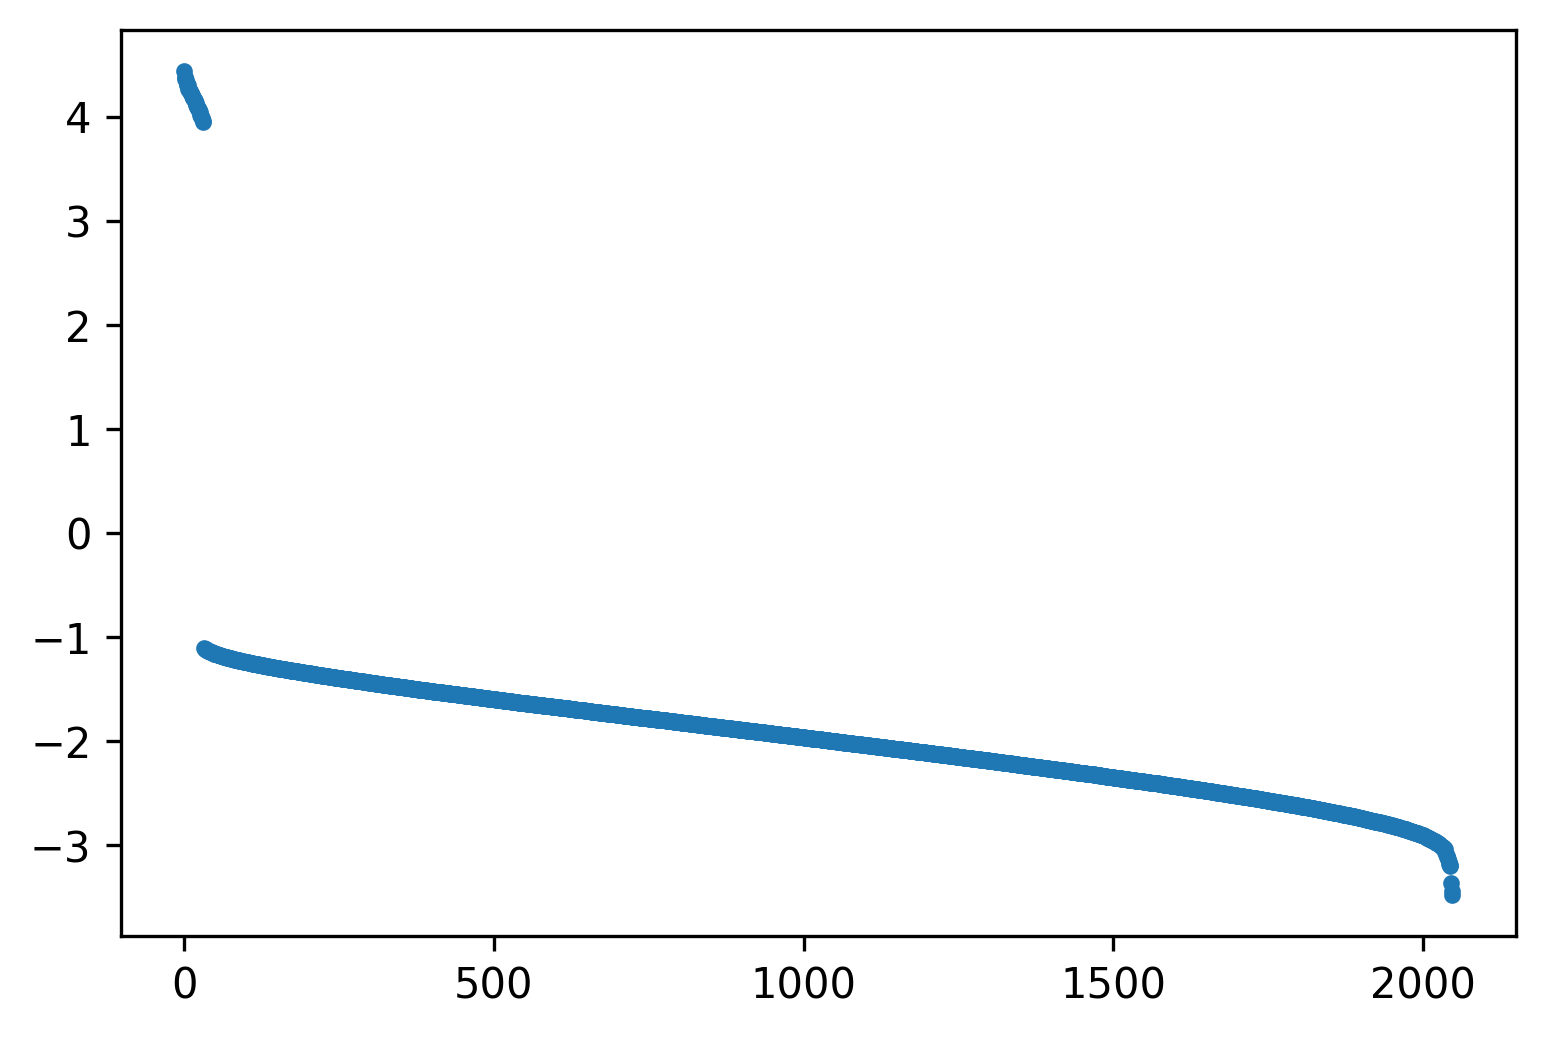

At  20000 channels, alpha is 21.244717855326186
At  20000 channels, RMSE/y_std is 0.11390860972019122
***************************  15000  *************************
0:  |F(x)| = 0.000219168; step 1
1:  |F(x)| = 4.09313e-06; step 1


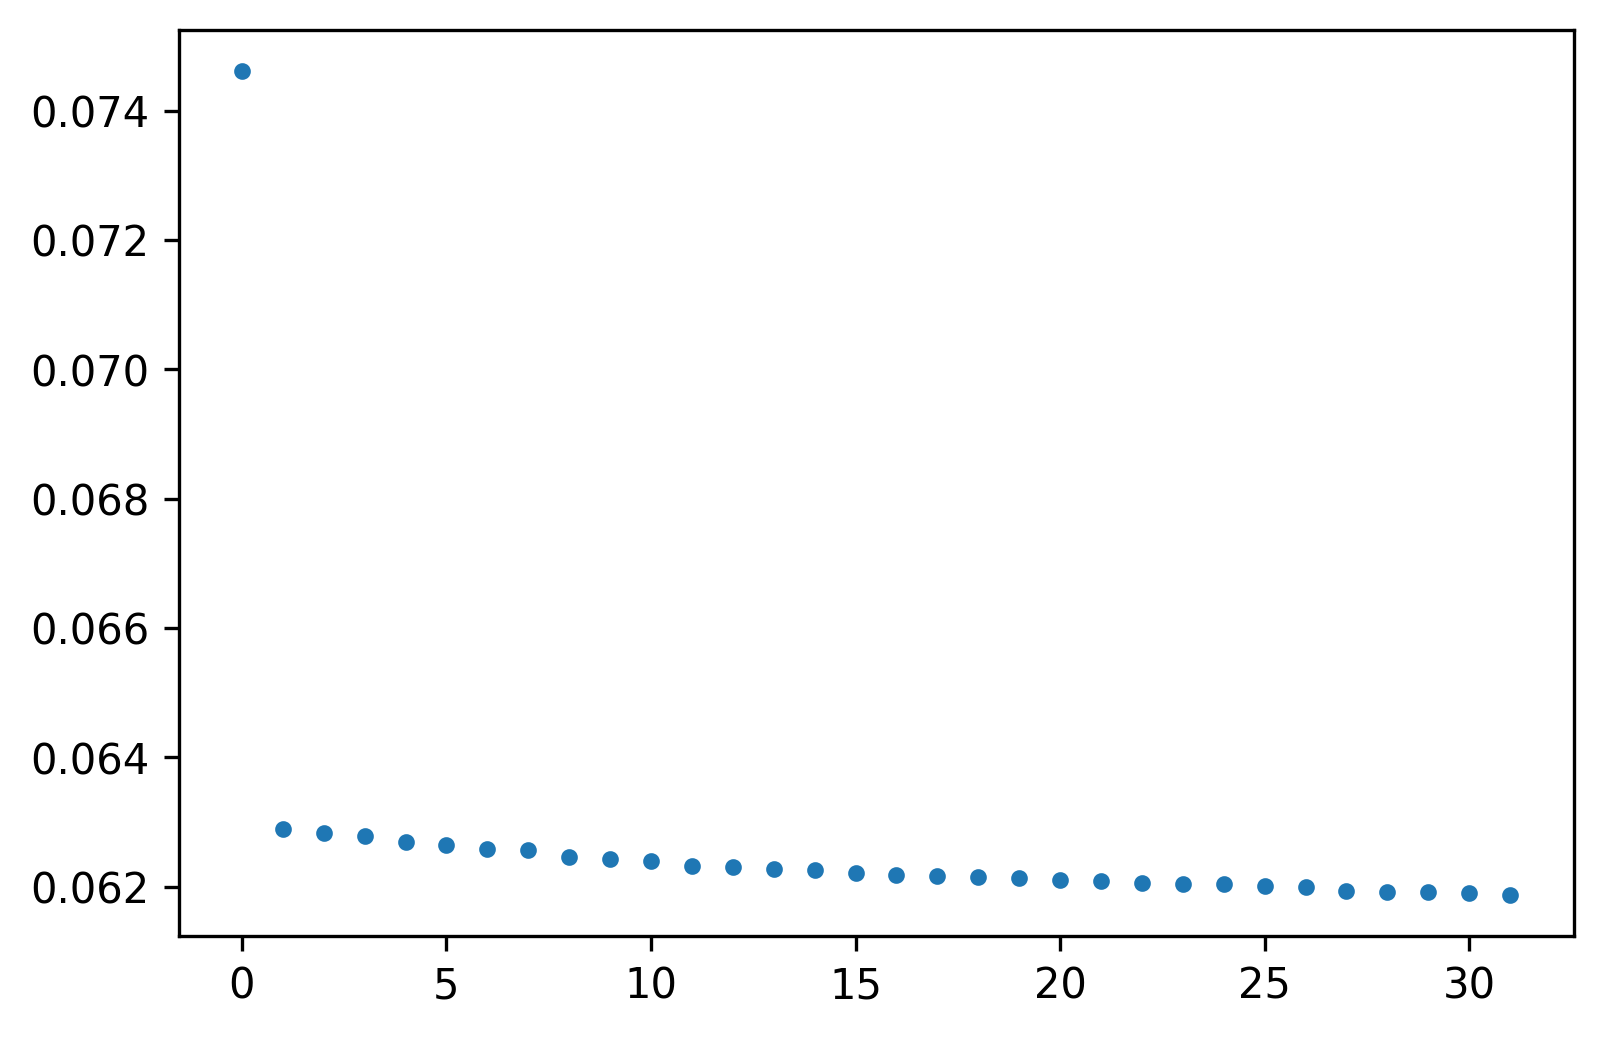

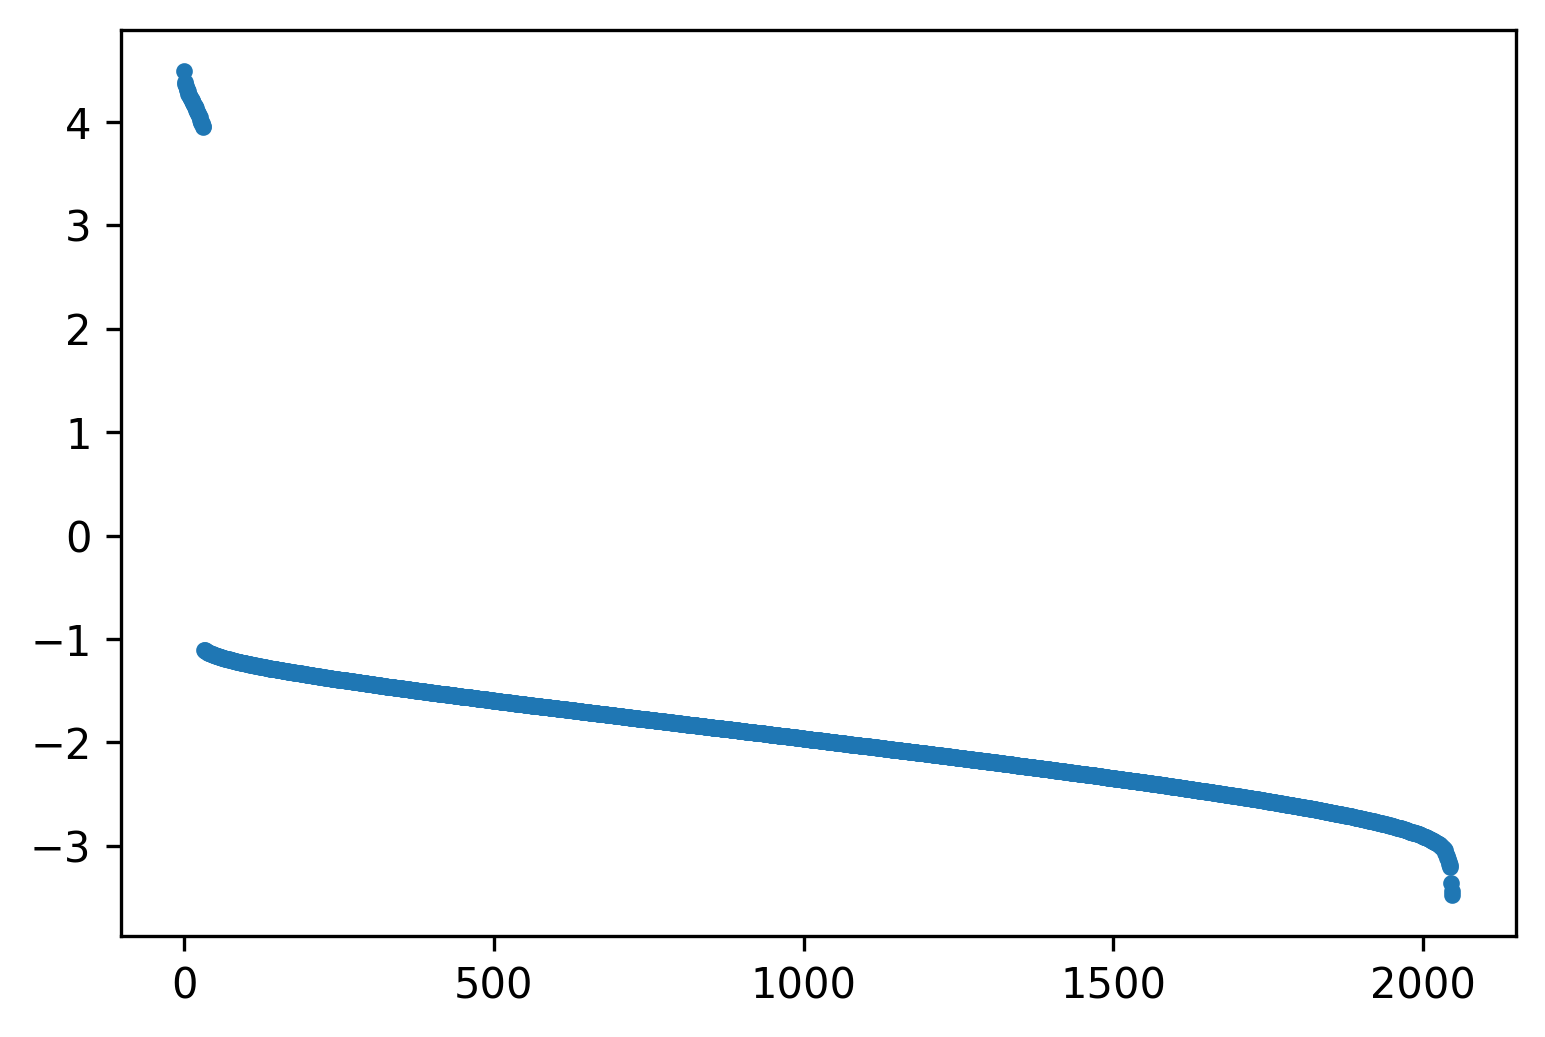

At  15000 channels, alpha is 20.265508563771075
At  15000 channels, RMSE/y_std is 0.1117077352206683
***************************  10000  *************************
0:  |F(x)| = 0.000988994; step 1
1:  |F(x)| = 0.000153815; step 1
2:  |F(x)| = 3.7712e-06; step 1


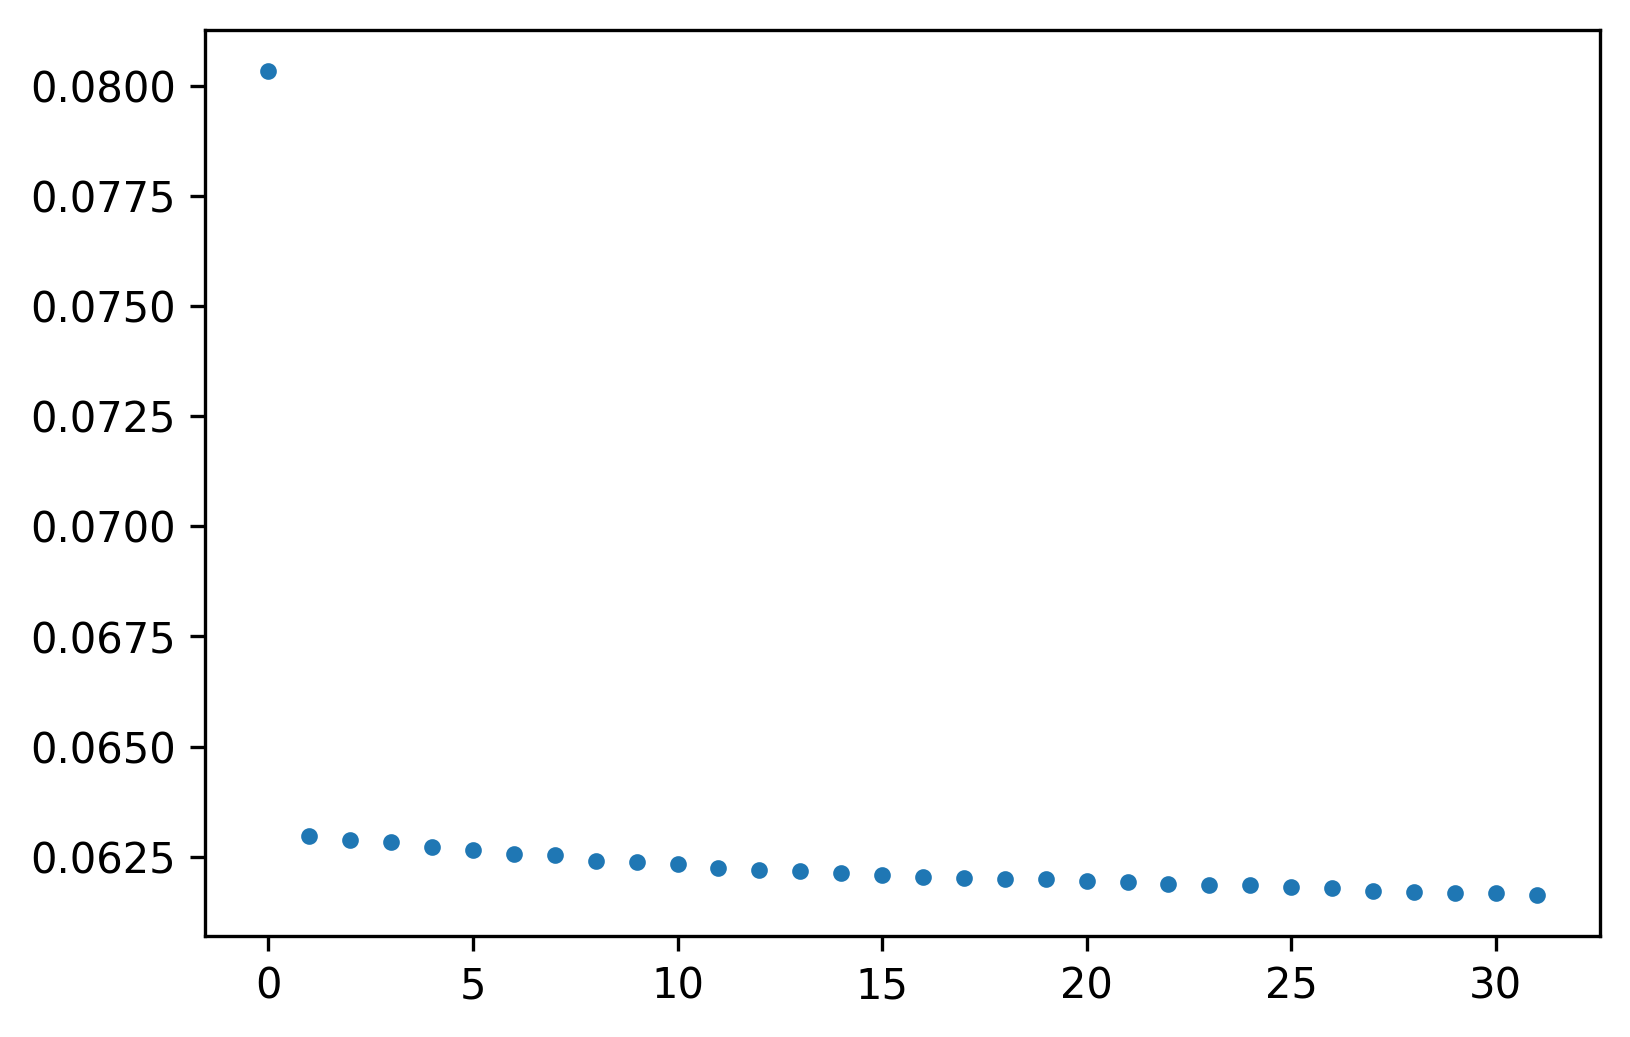

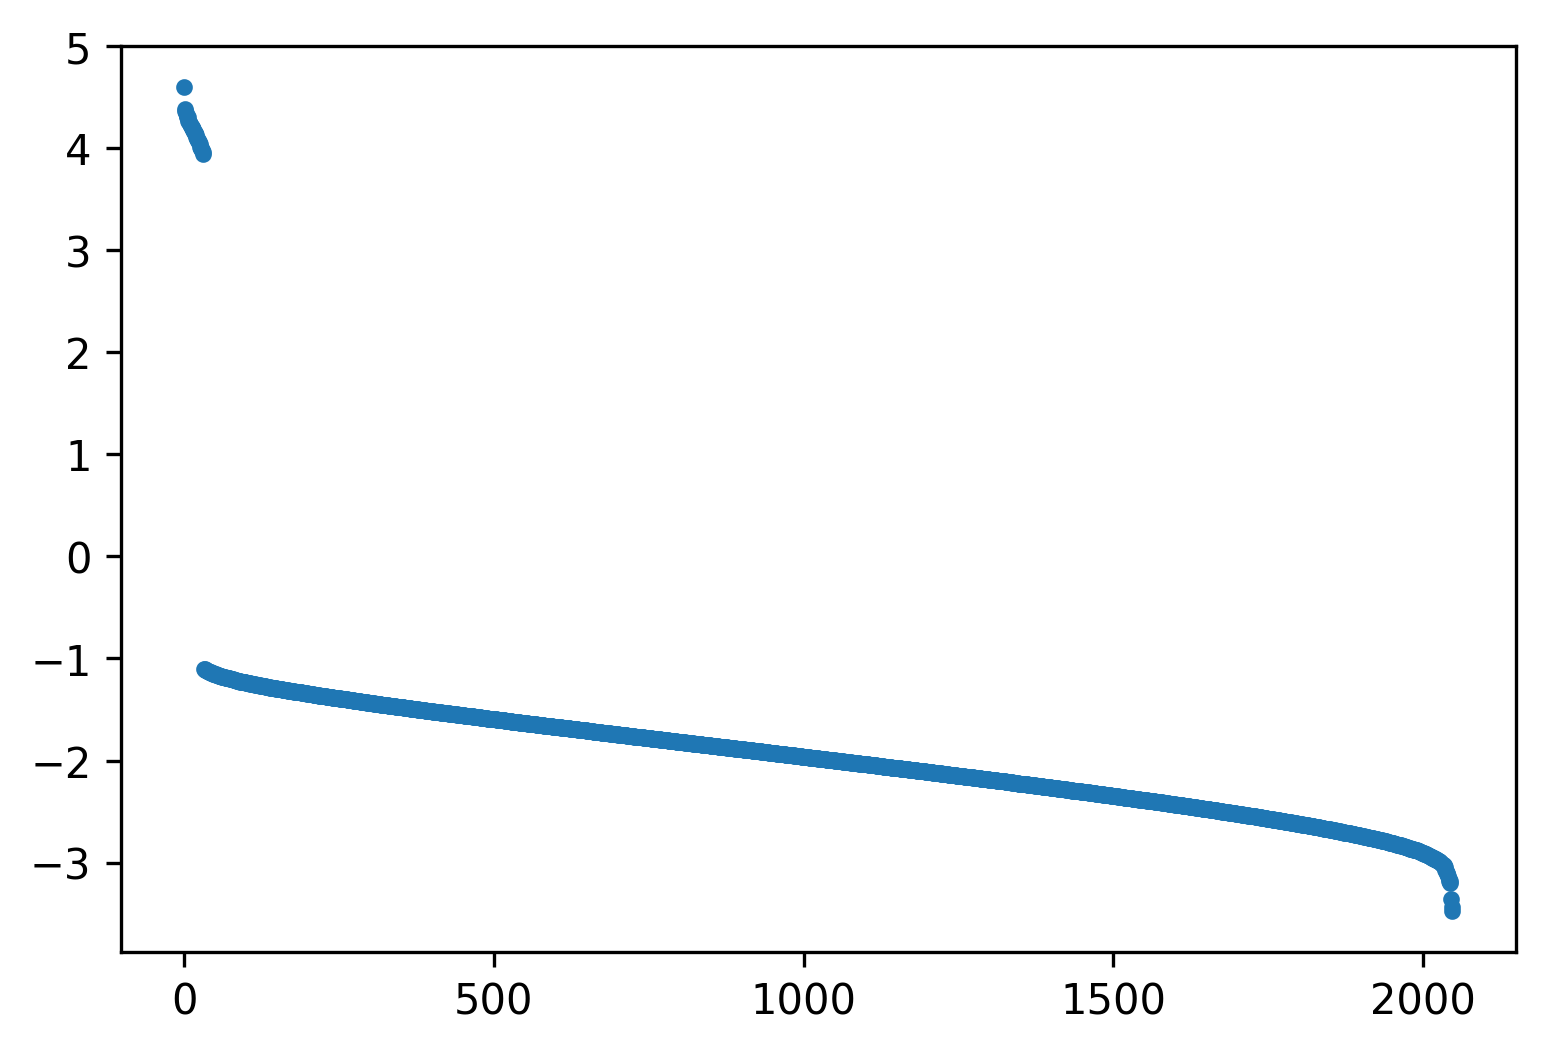

At  10000 channels, alpha is 18.52281234656871
At  10000 channels, RMSE/y_std is 0.10769073146151416
***************************  8000  *************************
0:  |F(x)| = 0.000621844; step 1
1:  |F(x)| = 3.58035e-05; step 1
2:  |F(x)| = 3.22216e-06; step 1


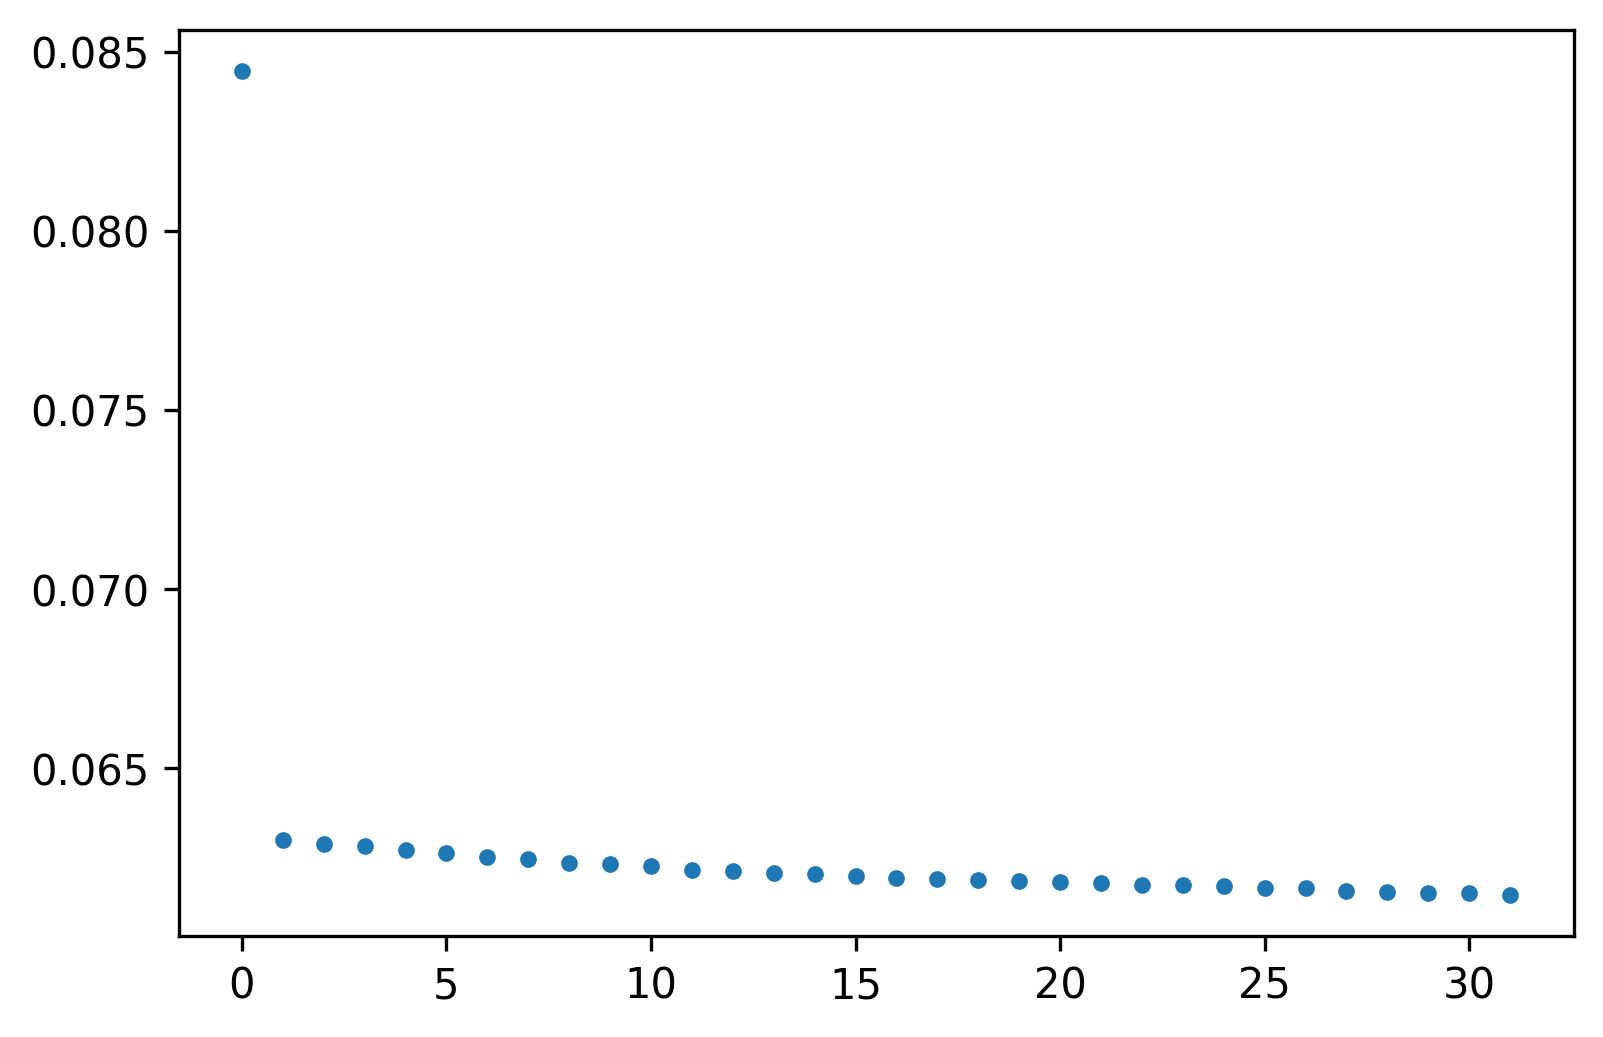

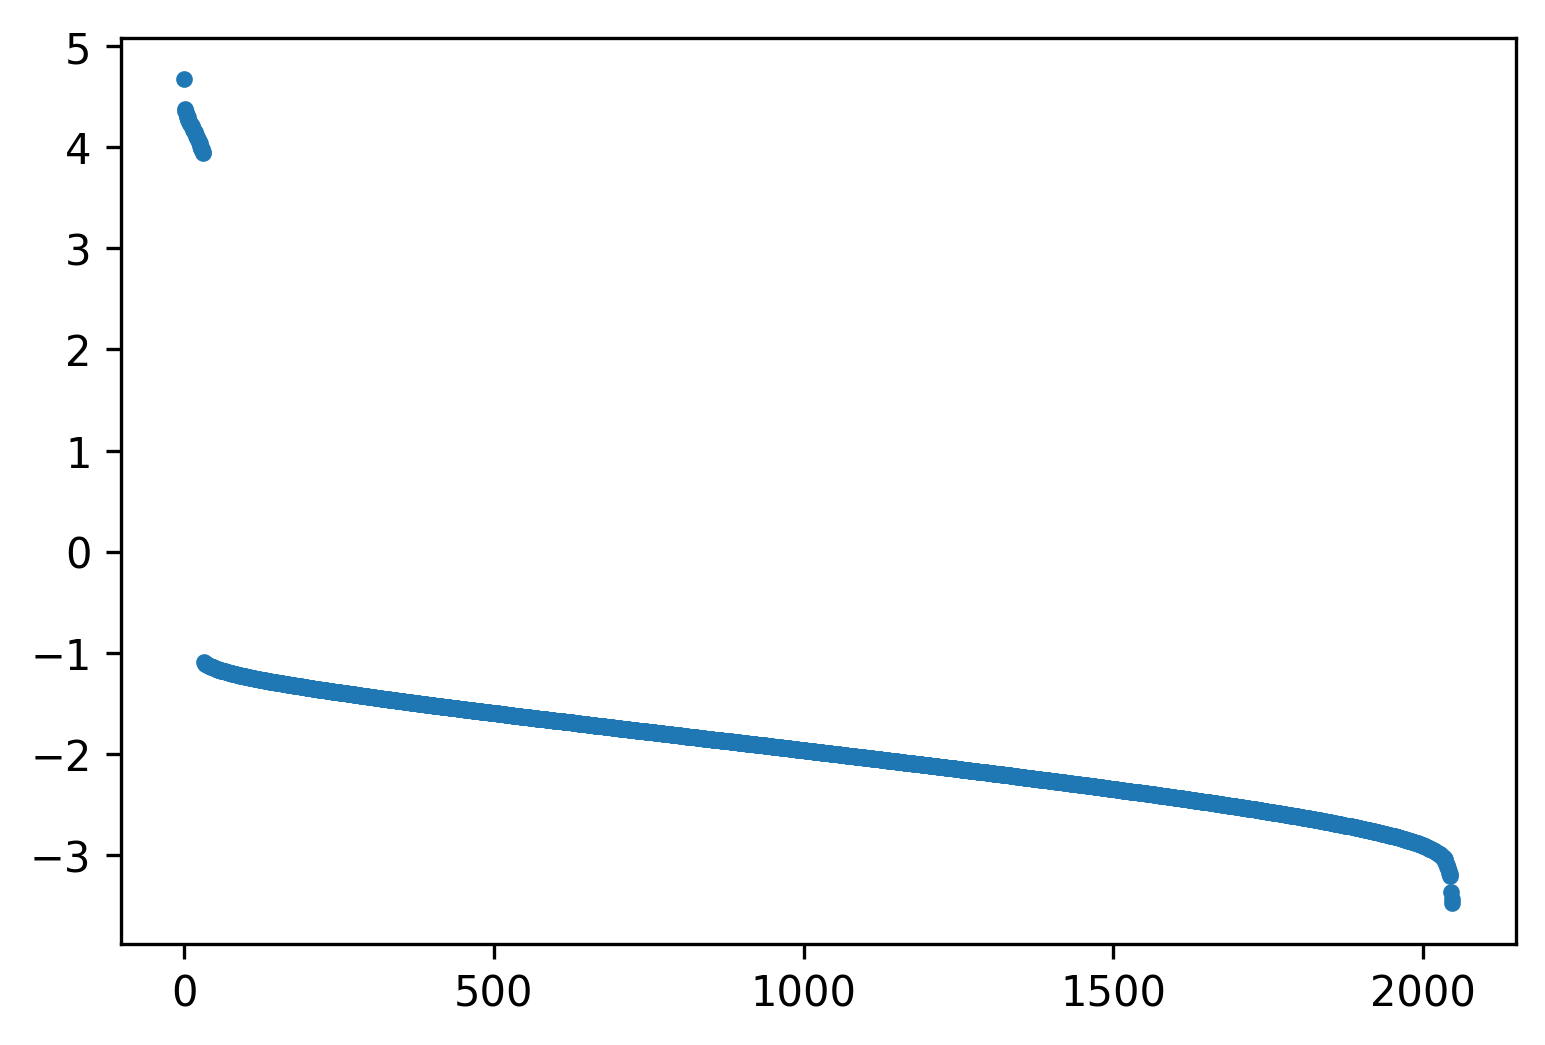

At  8000 channels, alpha is 17.37268973474825
At  8000 channels, RMSE/y_std is 0.10498096475868071
***************************  7000  *************************
0:  |F(x)| = 0.000361771; step 1
1:  |F(x)| = 3.03606e-06; step 1


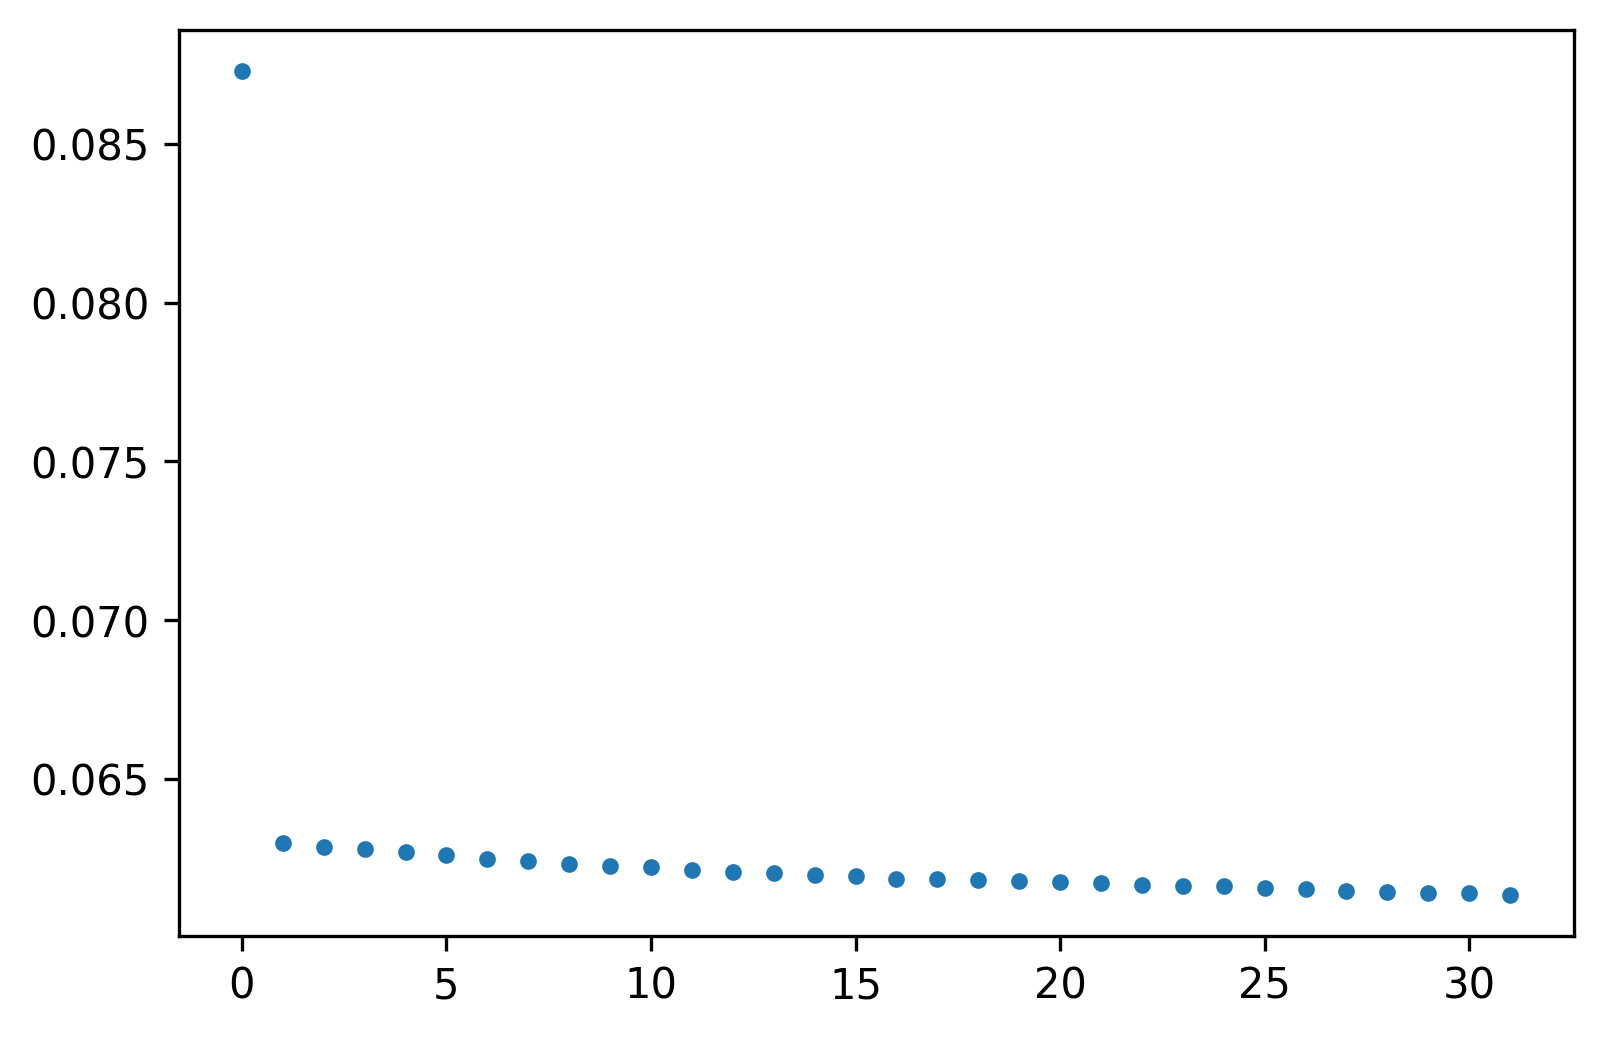

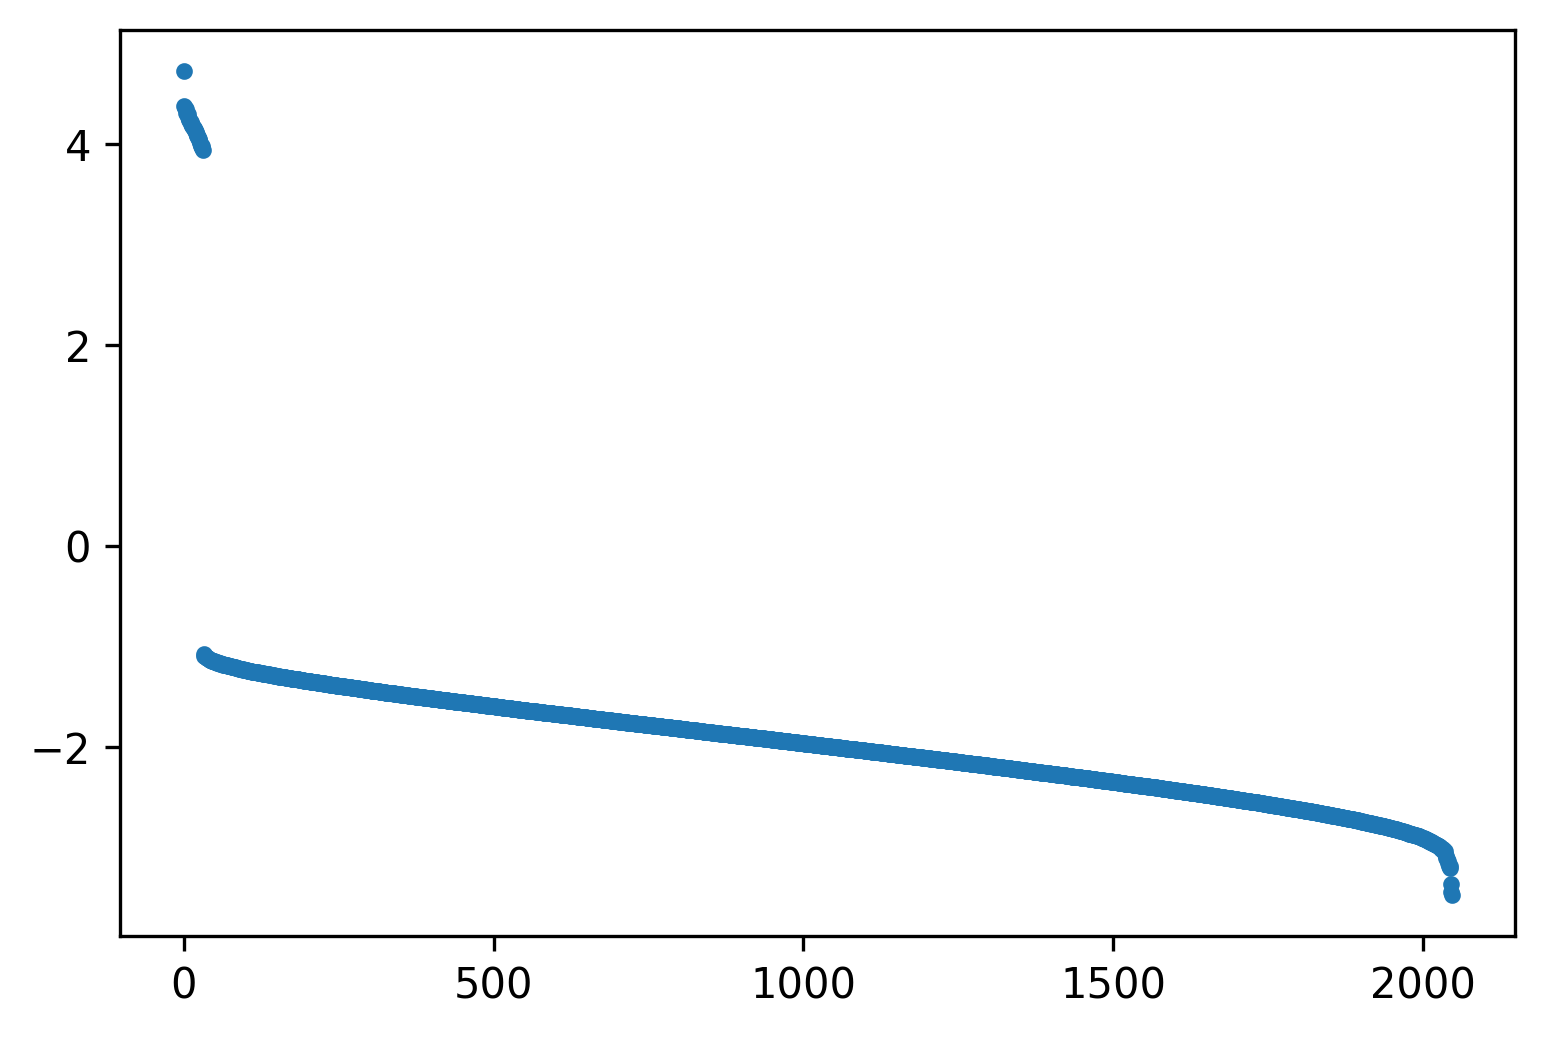

At  7000 channels, alpha is 16.632086836368245
At  7000 channels, RMSE/y_std is 0.10321759295286452
***************************  6000  *************************
0:  |F(x)| = 0.000710495; step 1
1:  |F(x)| = 5.33775e-06; step 1


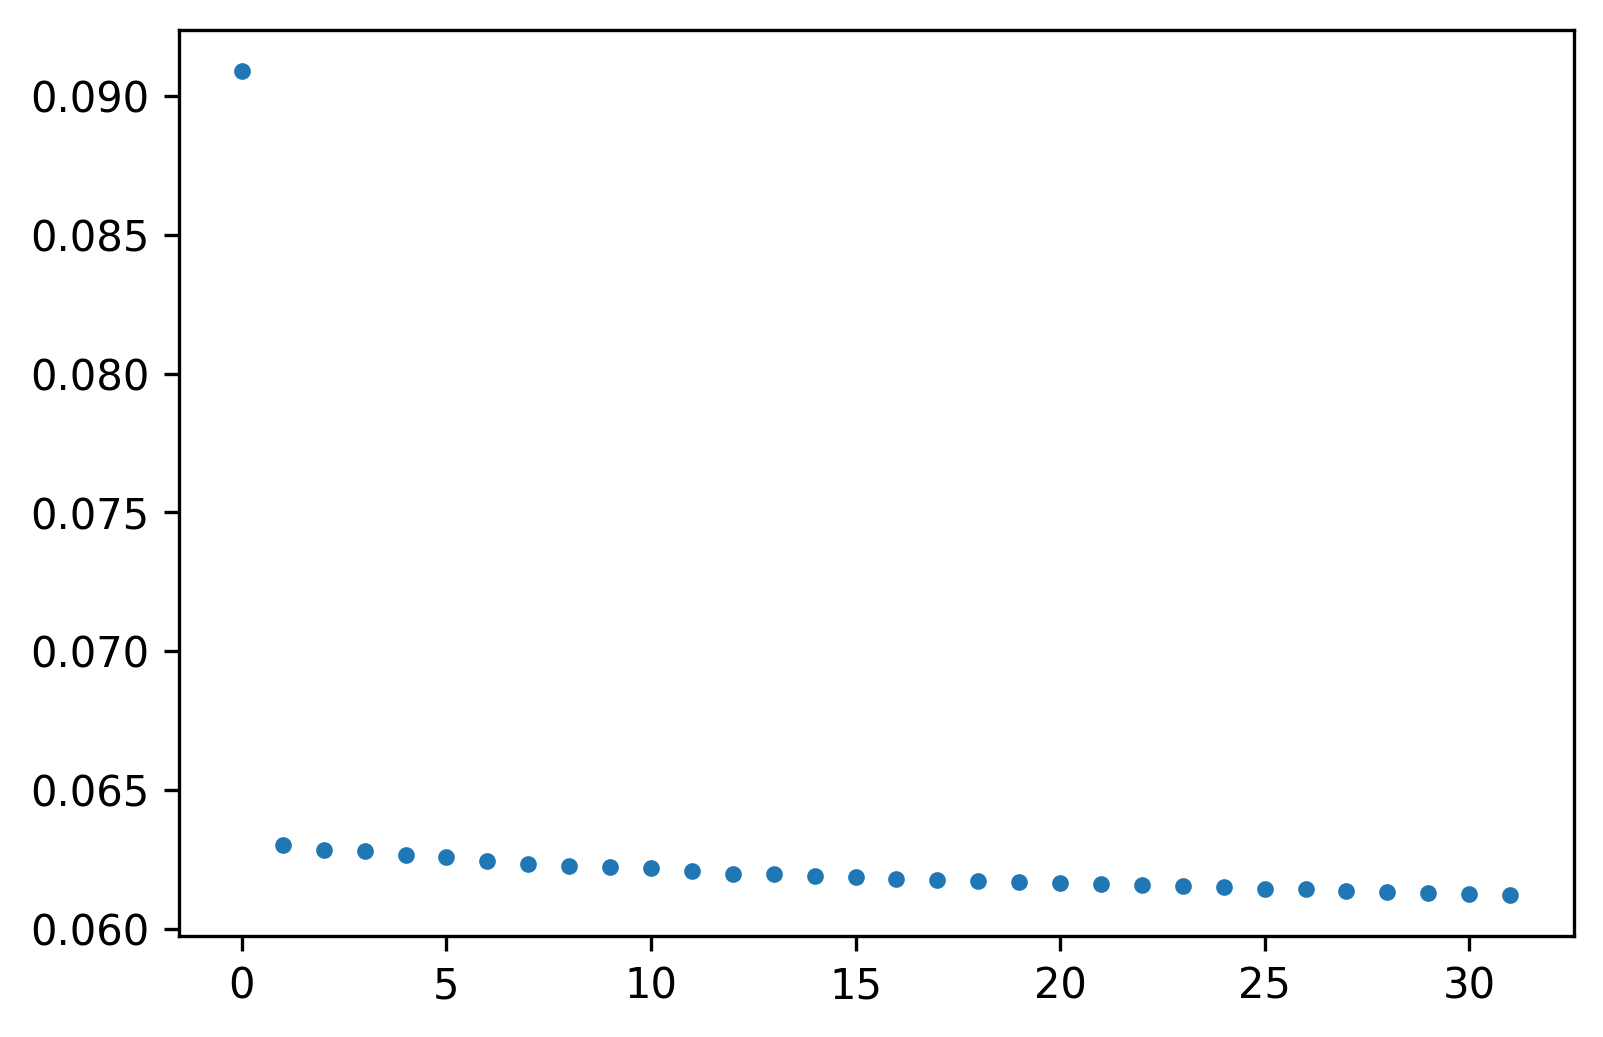

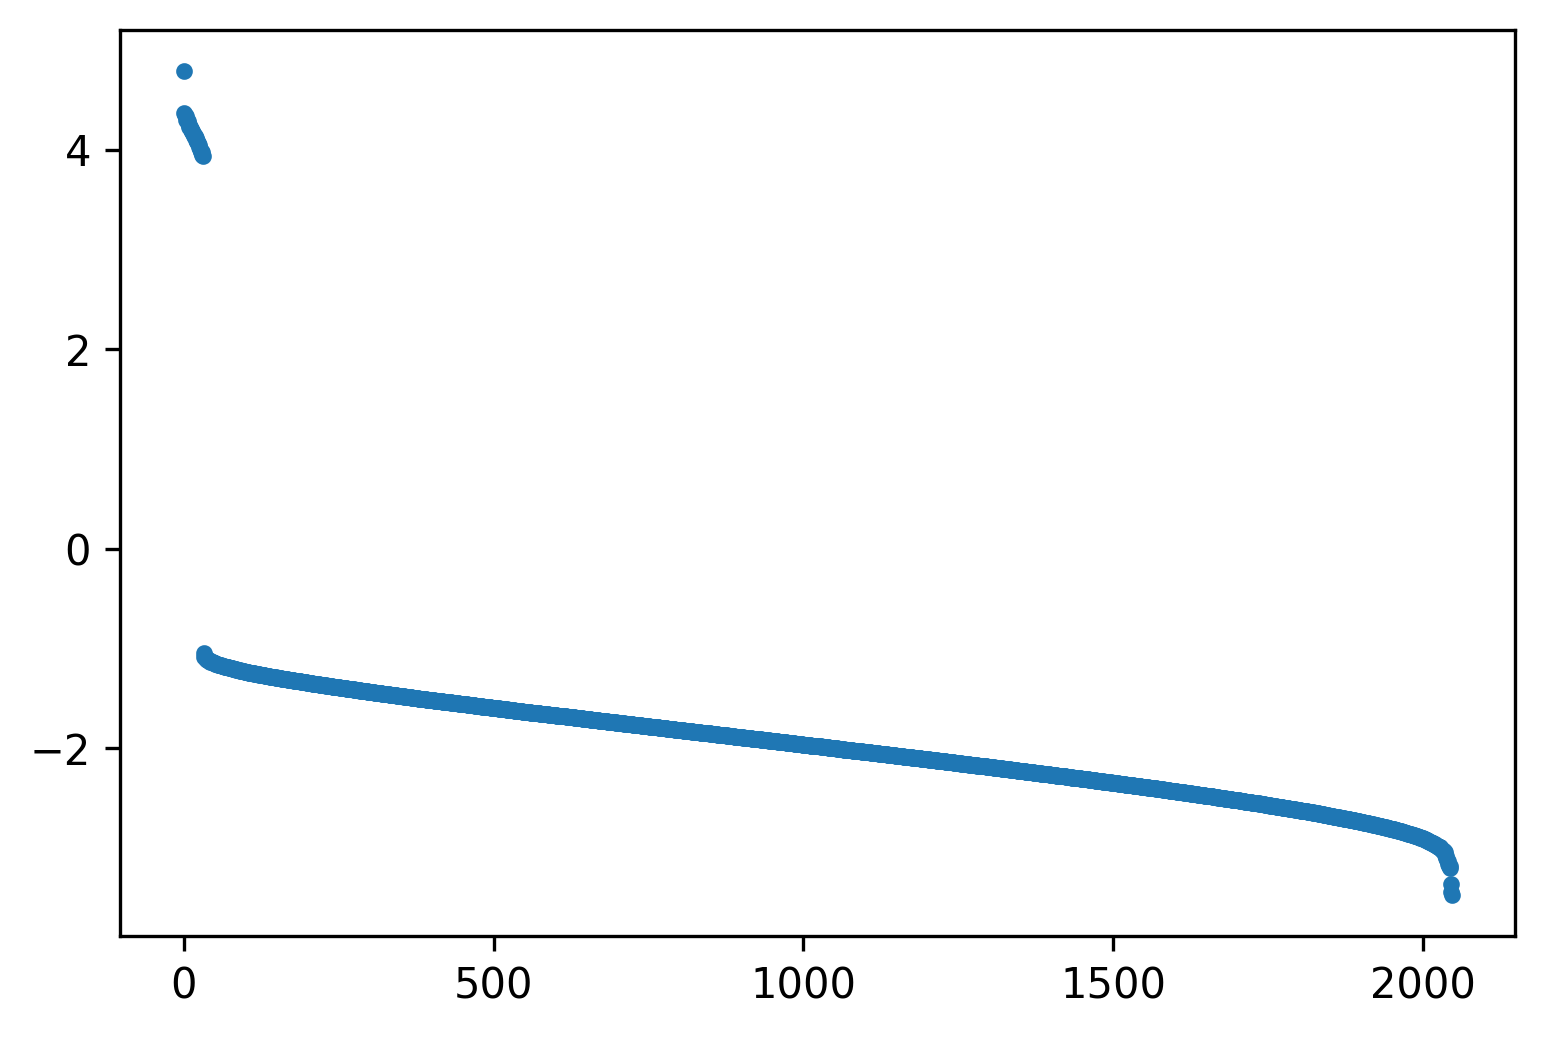

At  6000 channels, alpha is 15.730749767393732
At  6000 channels, RMSE/y_std is 0.1010573093727808
***************************  5000  *************************
0:  |F(x)| = 0.0011014; step 1
1:  |F(x)| = 9.19839e-05; step 1
2:  |F(x)| = 7.95529e-06; step 1
3:  |F(x)| = 3.94365e-06; step 1


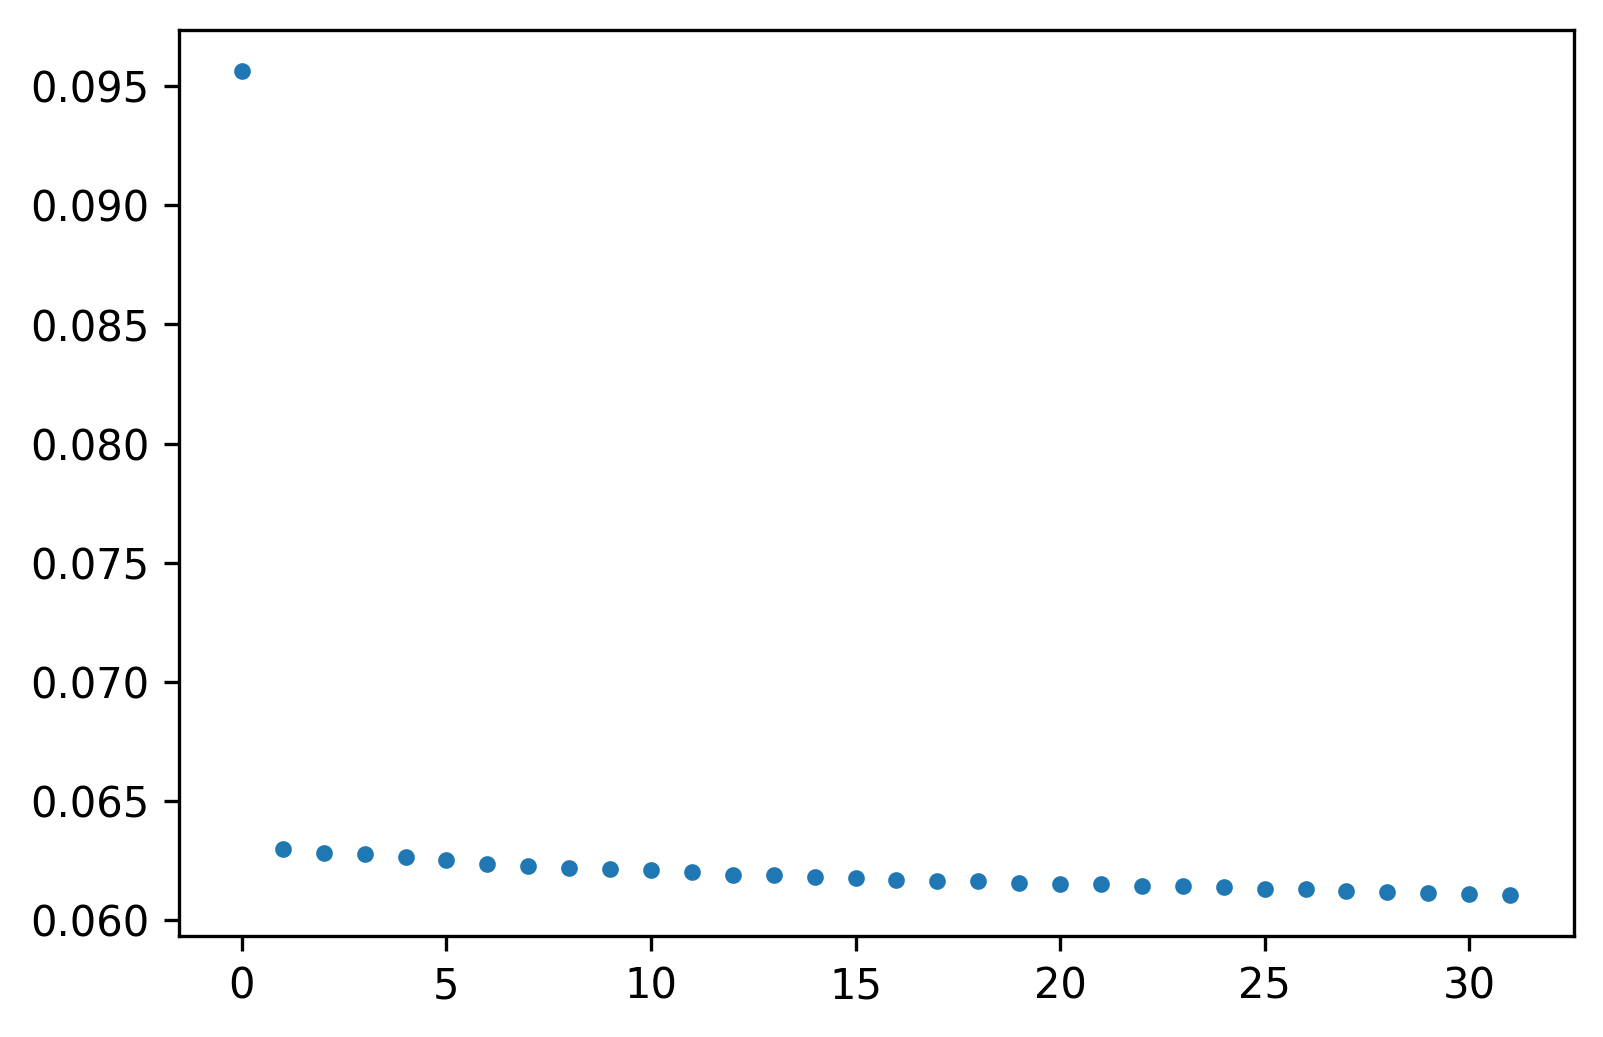

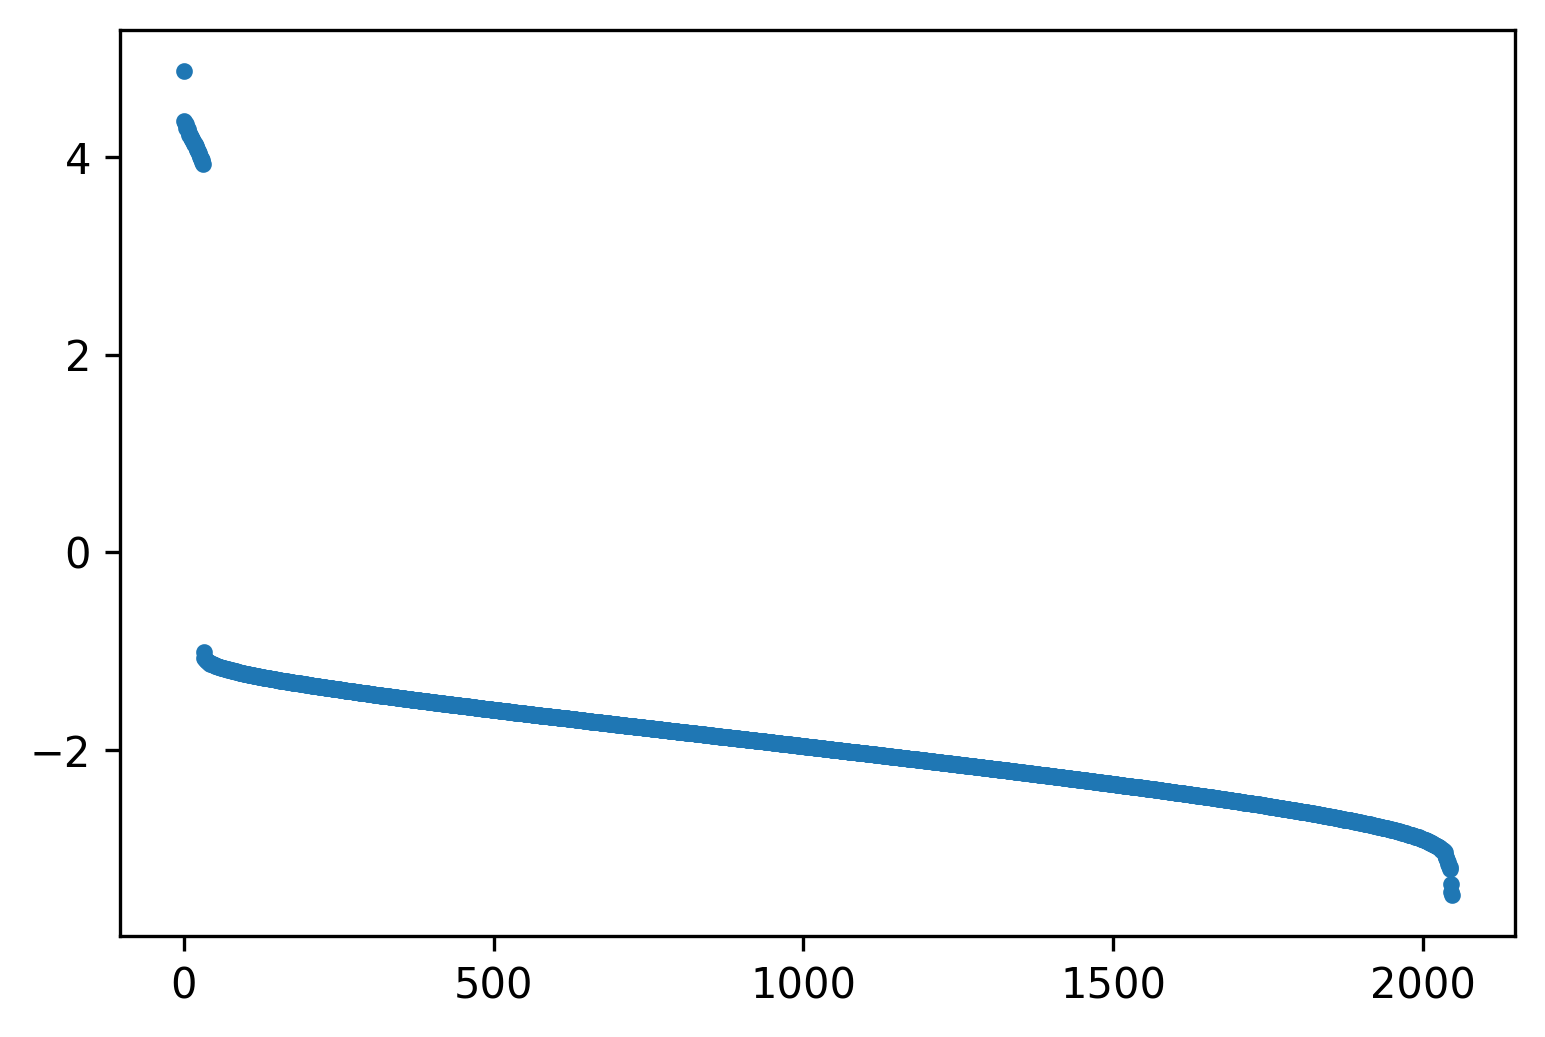

At  5000 channels, alpha is 14.620294642687206
At  5000 channels, RMSE/y_std is 0.09838447816446551
***************************  4000  *************************
0:  |F(x)| = 0.002372; step 1
1:  |F(x)| = 0.000313109; step 1
2:  |F(x)| = 1.08695e-05; step 1
3:  |F(x)| = 2.6392e-06; step 1


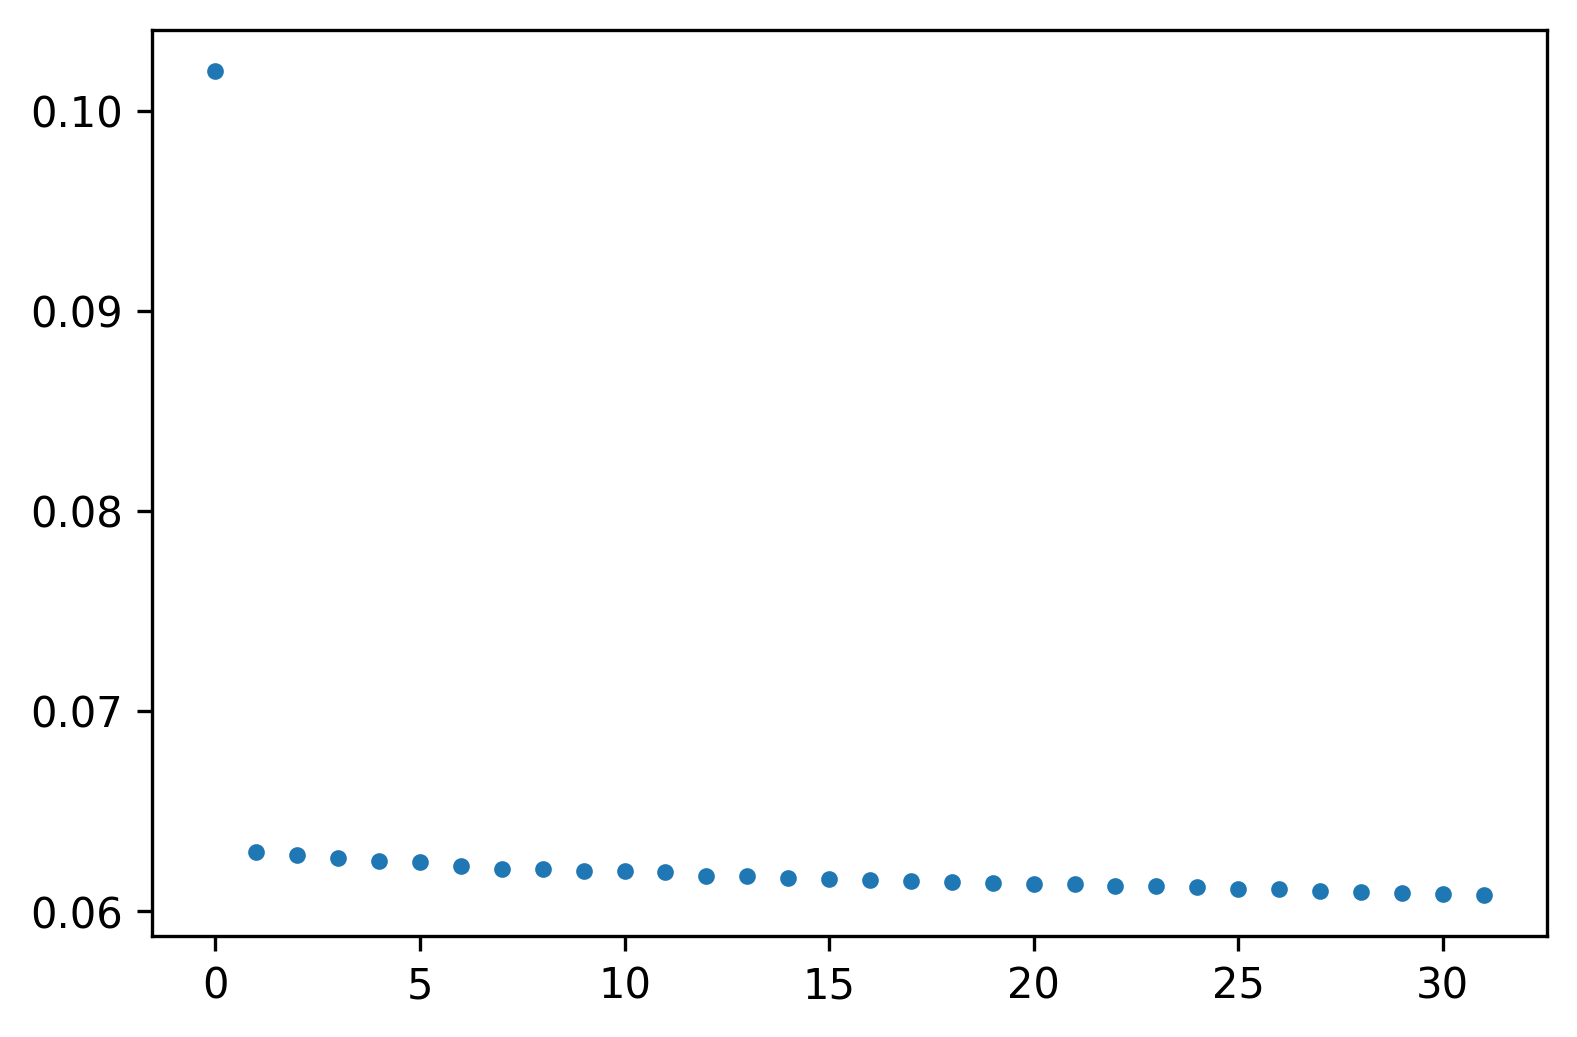

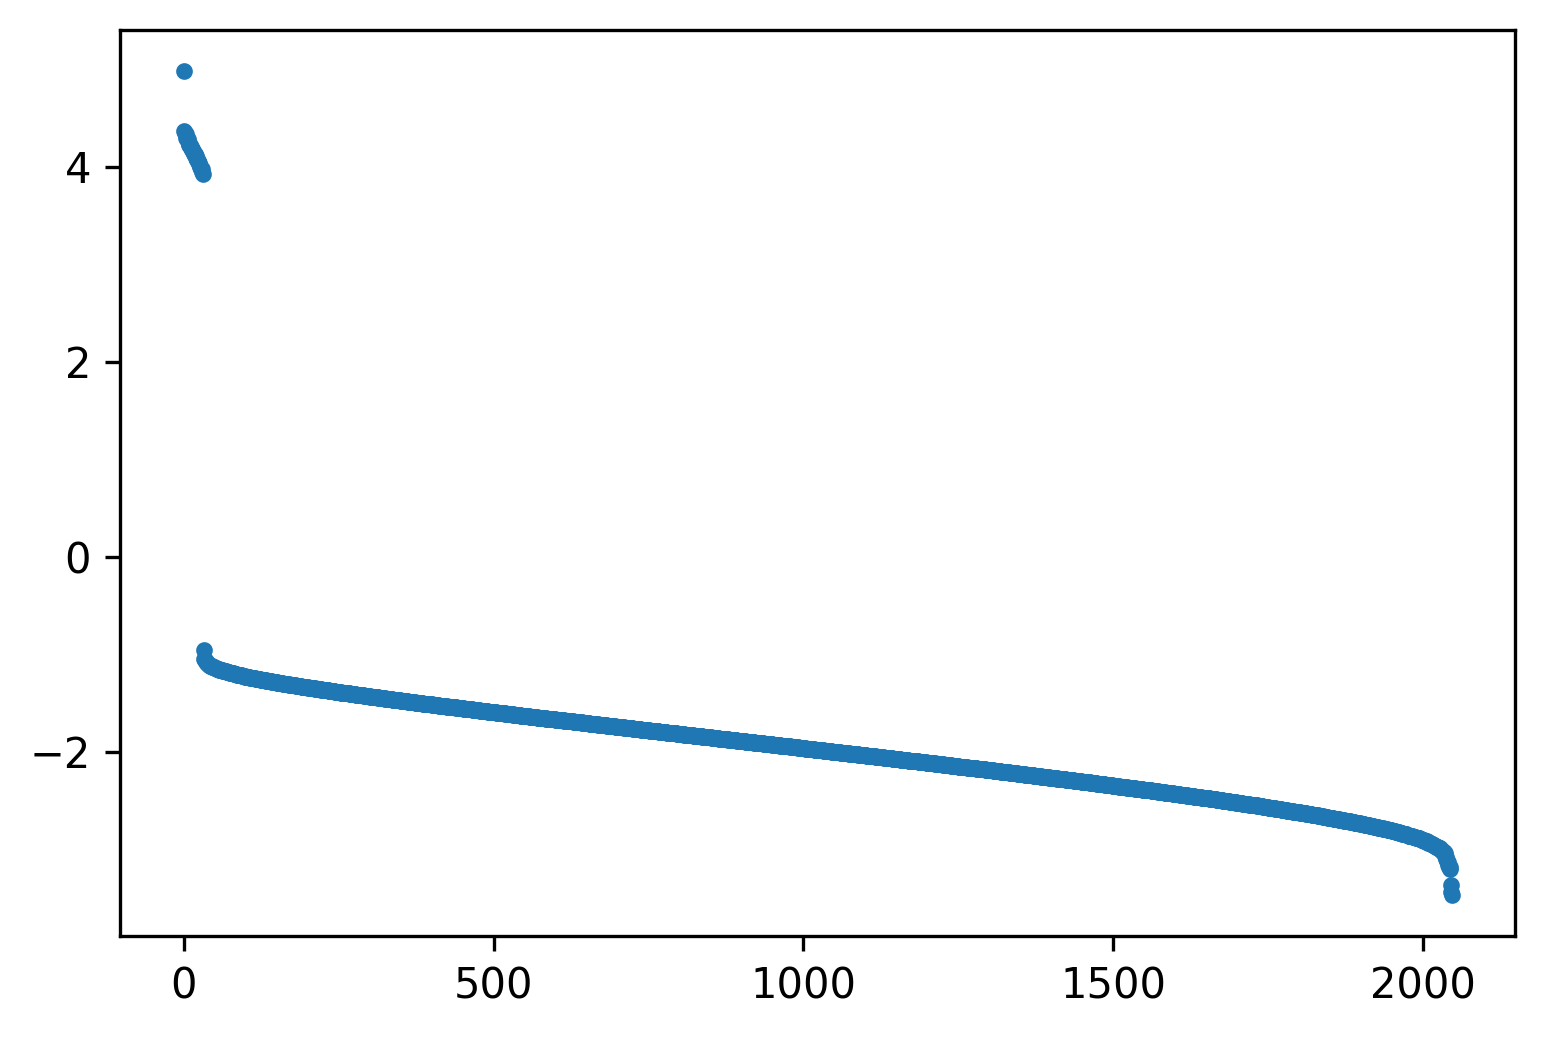

At  4000 channels, alpha is 13.244440377965265
At  4000 channels, RMSE/y_std is 0.0950780302090651
***************************  3000  *************************
0:  |F(x)| = 0.00811868; step 1
1:  |F(x)| = 0.000506538; step 1
2:  |F(x)| = 1.82948e-05; step 1
3:  |F(x)| = 1.85222e-05; step 1
4:  |F(x)| = 1.0849e-05; step 1
5:  |F(x)| = 1.85816e-06; step 1


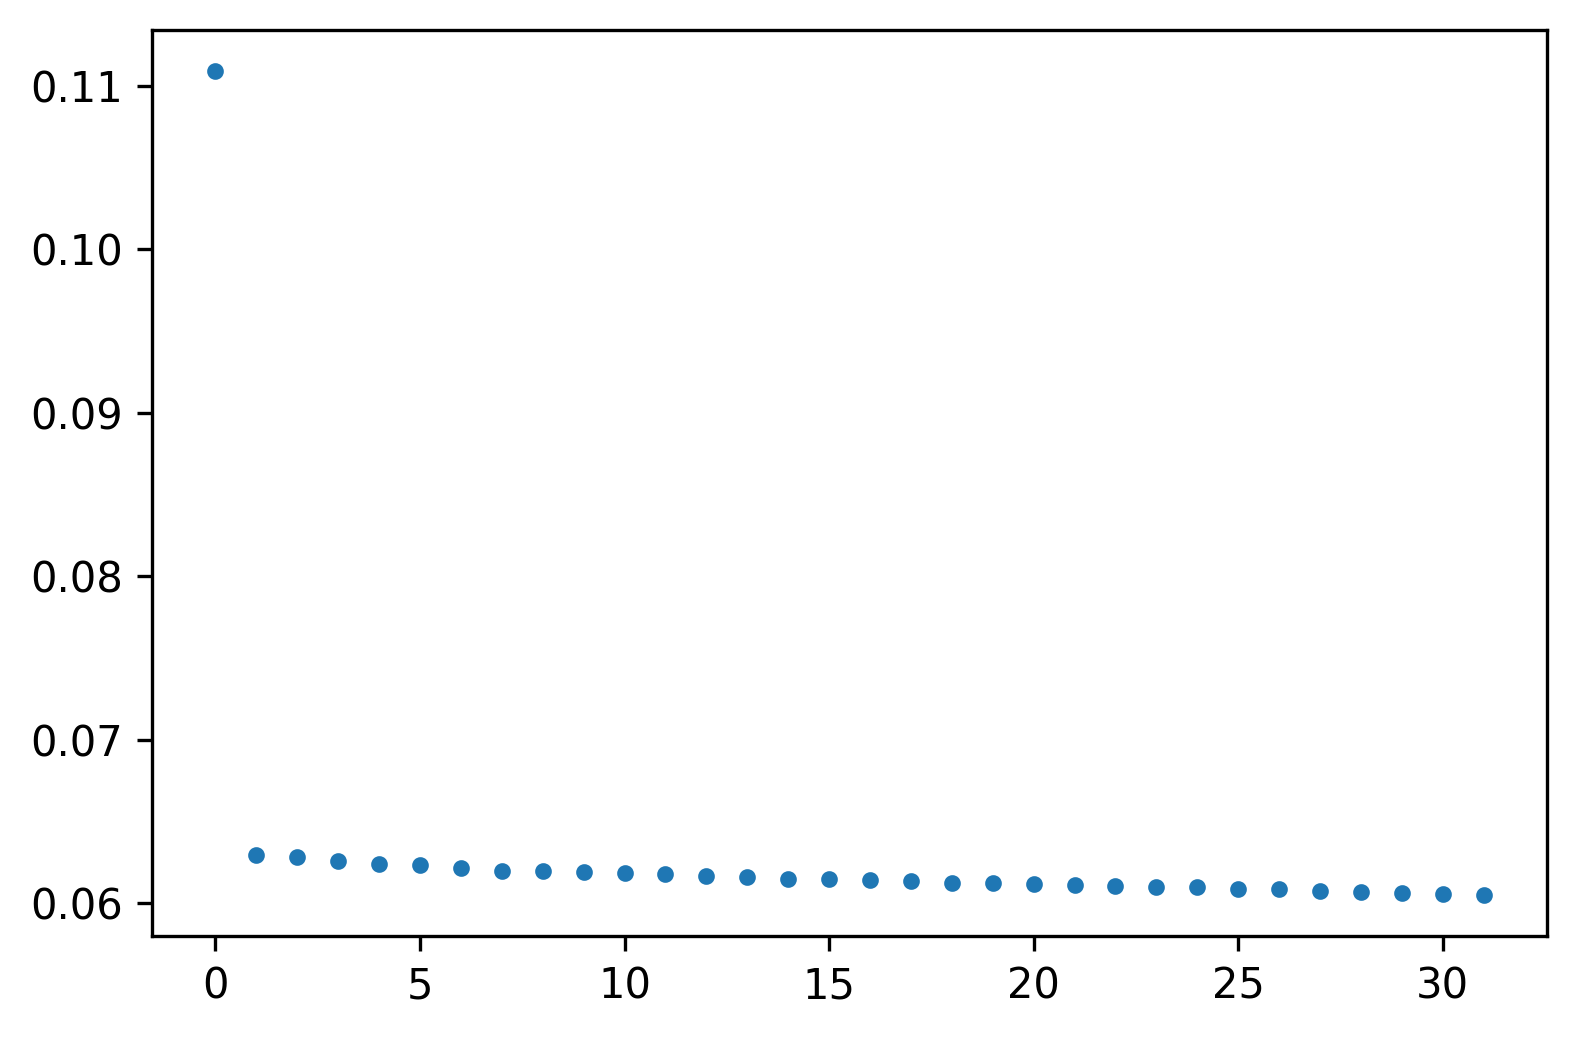

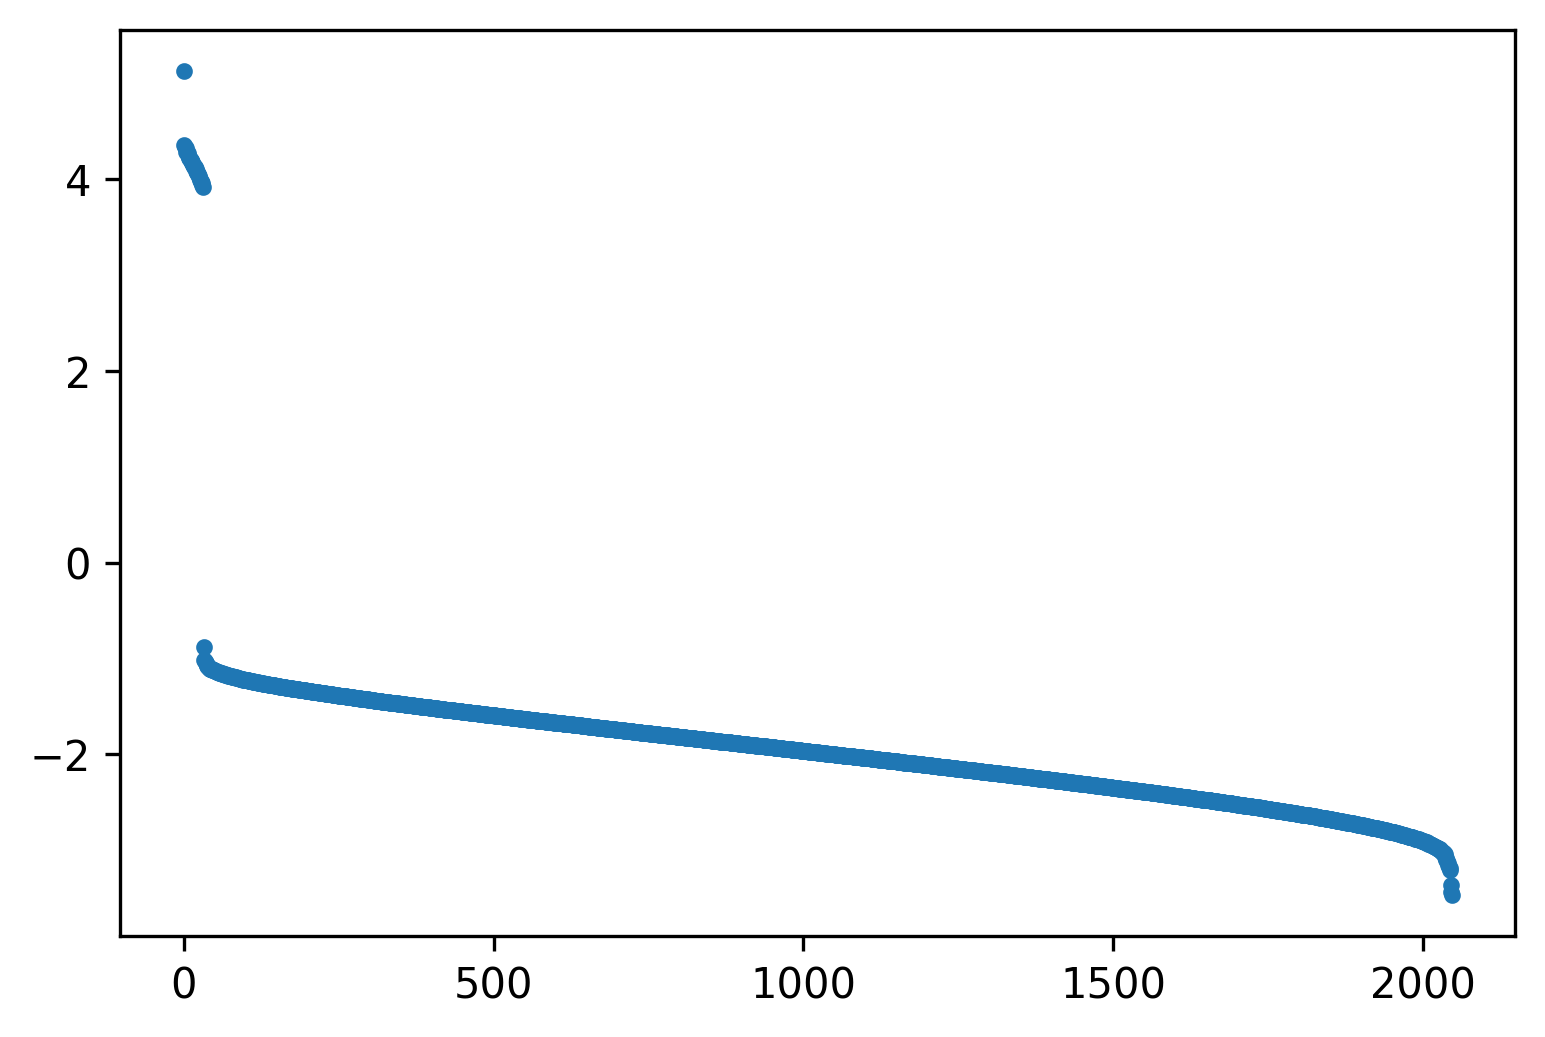

At  3000 channels, alpha is 11.525337642162752
At  3000 channels, RMSE/y_std is 0.0910054426011547
***************************  2000  *************************
0:  |F(x)| = 0.047566; step 1
1:  |F(x)| = 0.00358318; step 1
2:  |F(x)| = 0.00089475; step 1
3:  |F(x)| = 0.000136426; step 1
4:  |F(x)| = 2.409e-06; step 1


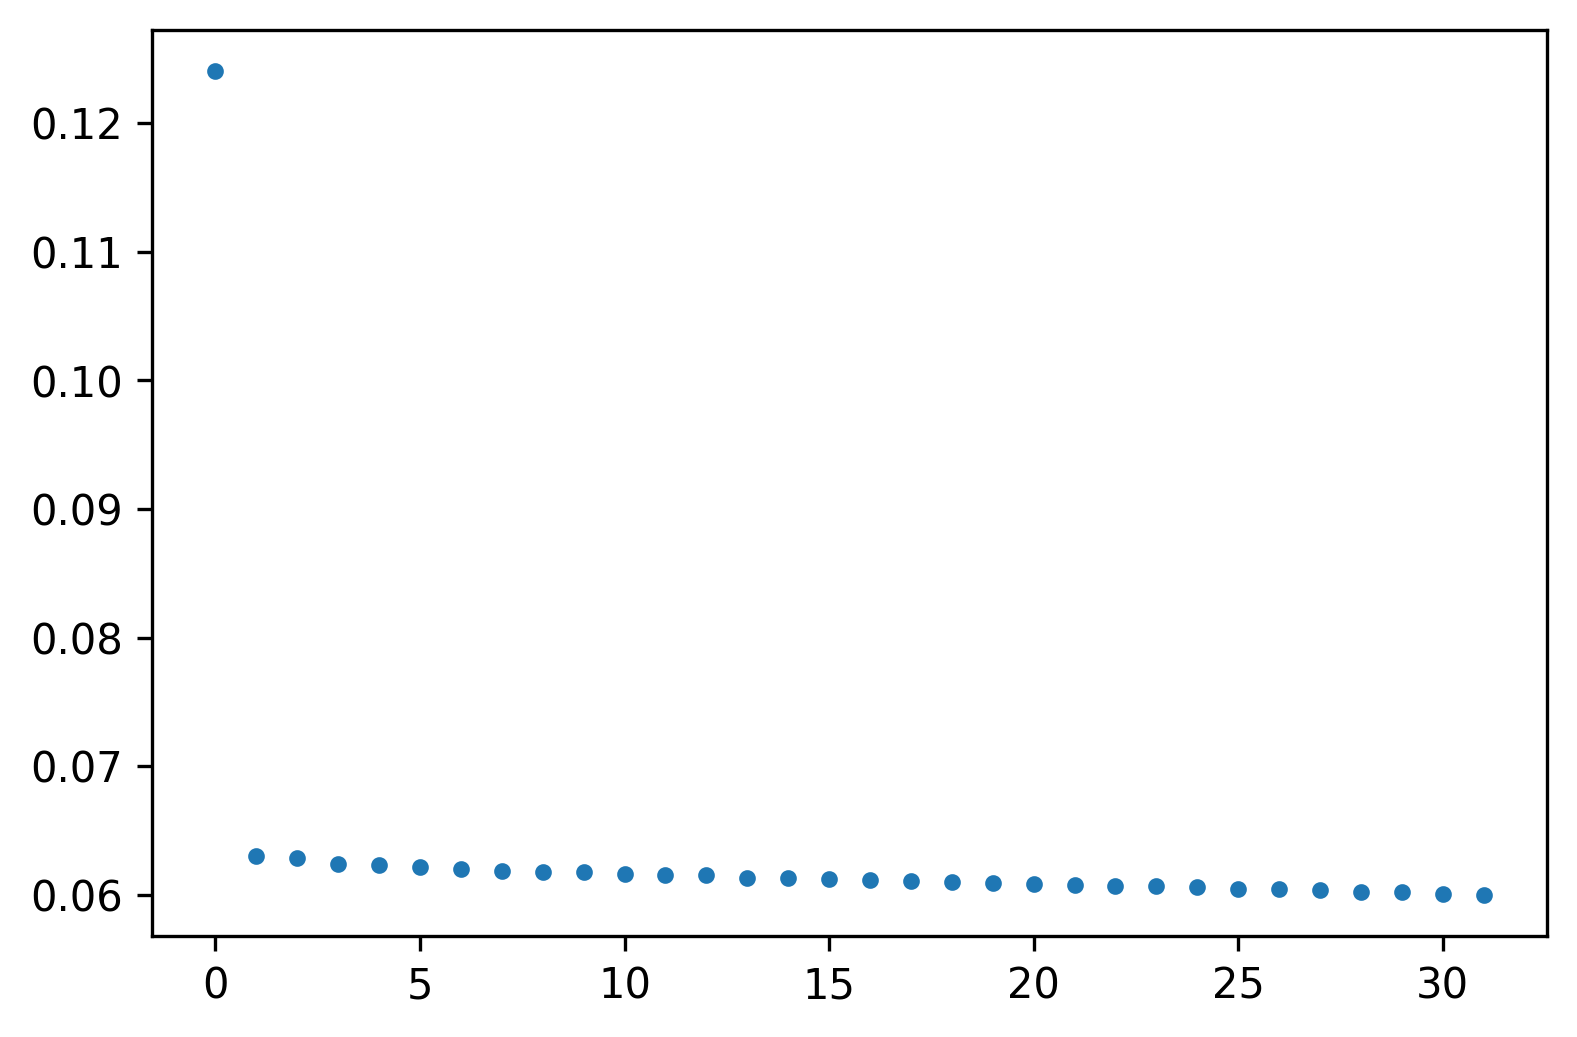

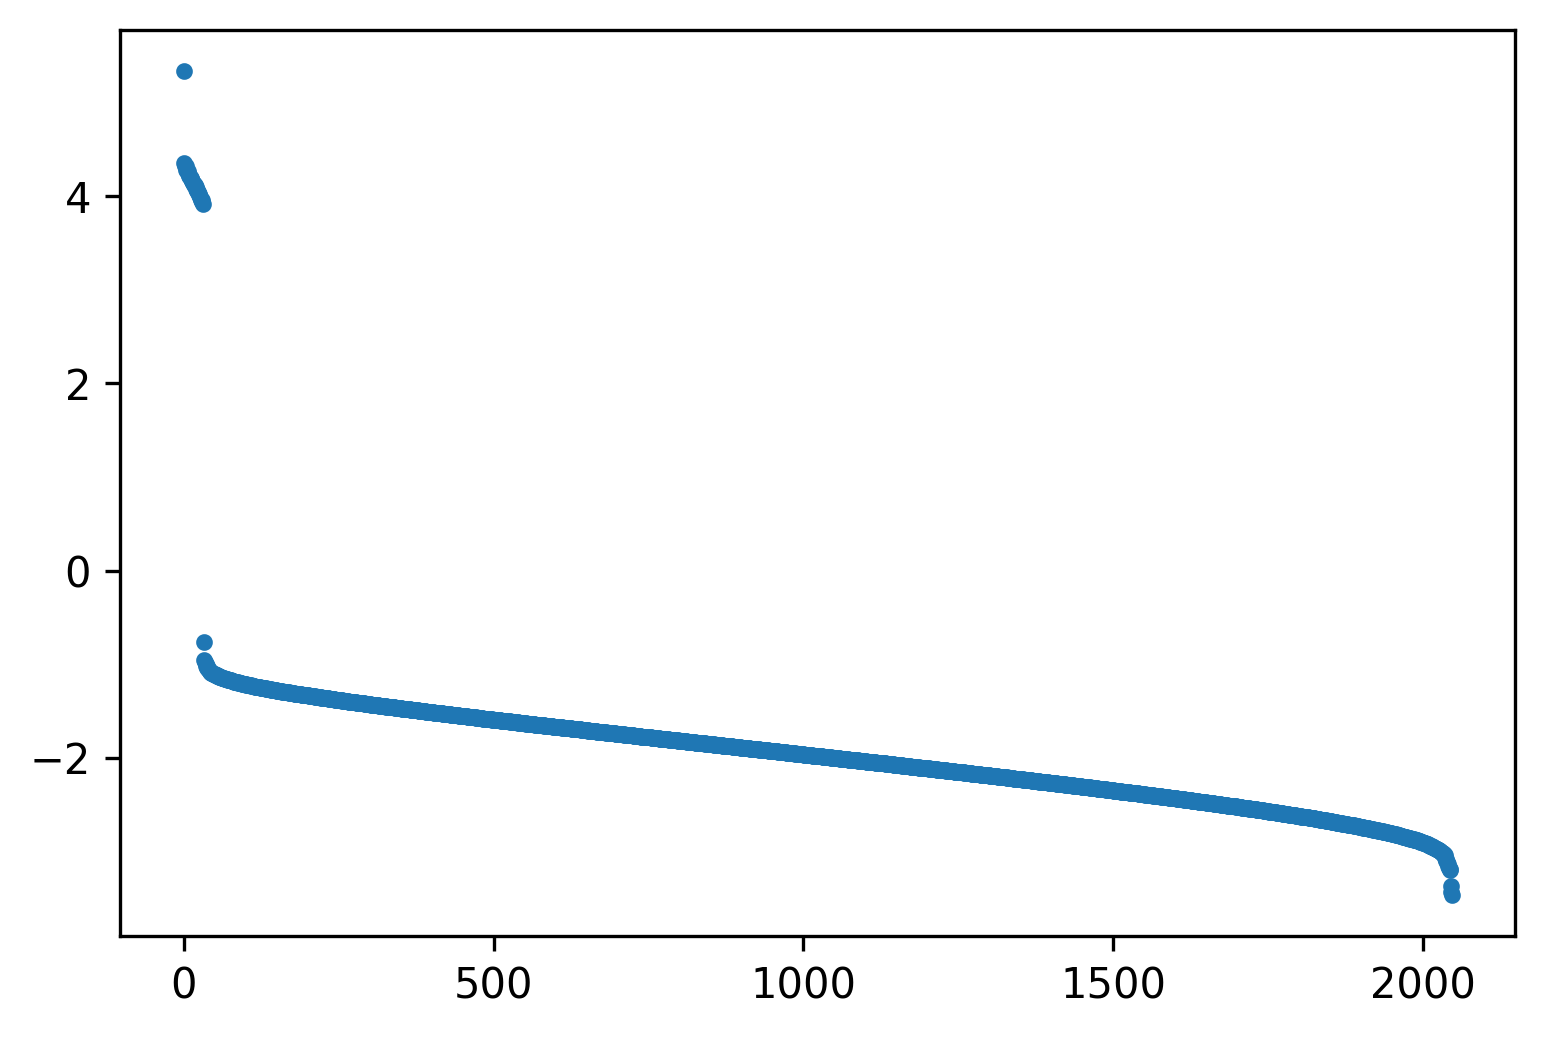

At  2000 channels, alpha is 9.387663649812655
At  2000 channels, RMSE/y_std is 0.08615173191138514
***************************  1800  *************************
0:  |F(x)| = 0.00377738; step 1
1:  |F(x)| = 0.000213891; step 1
2:  |F(x)| = 7.52666e-06; step 1
3:  |F(x)| = 1.94451e-06; step 1


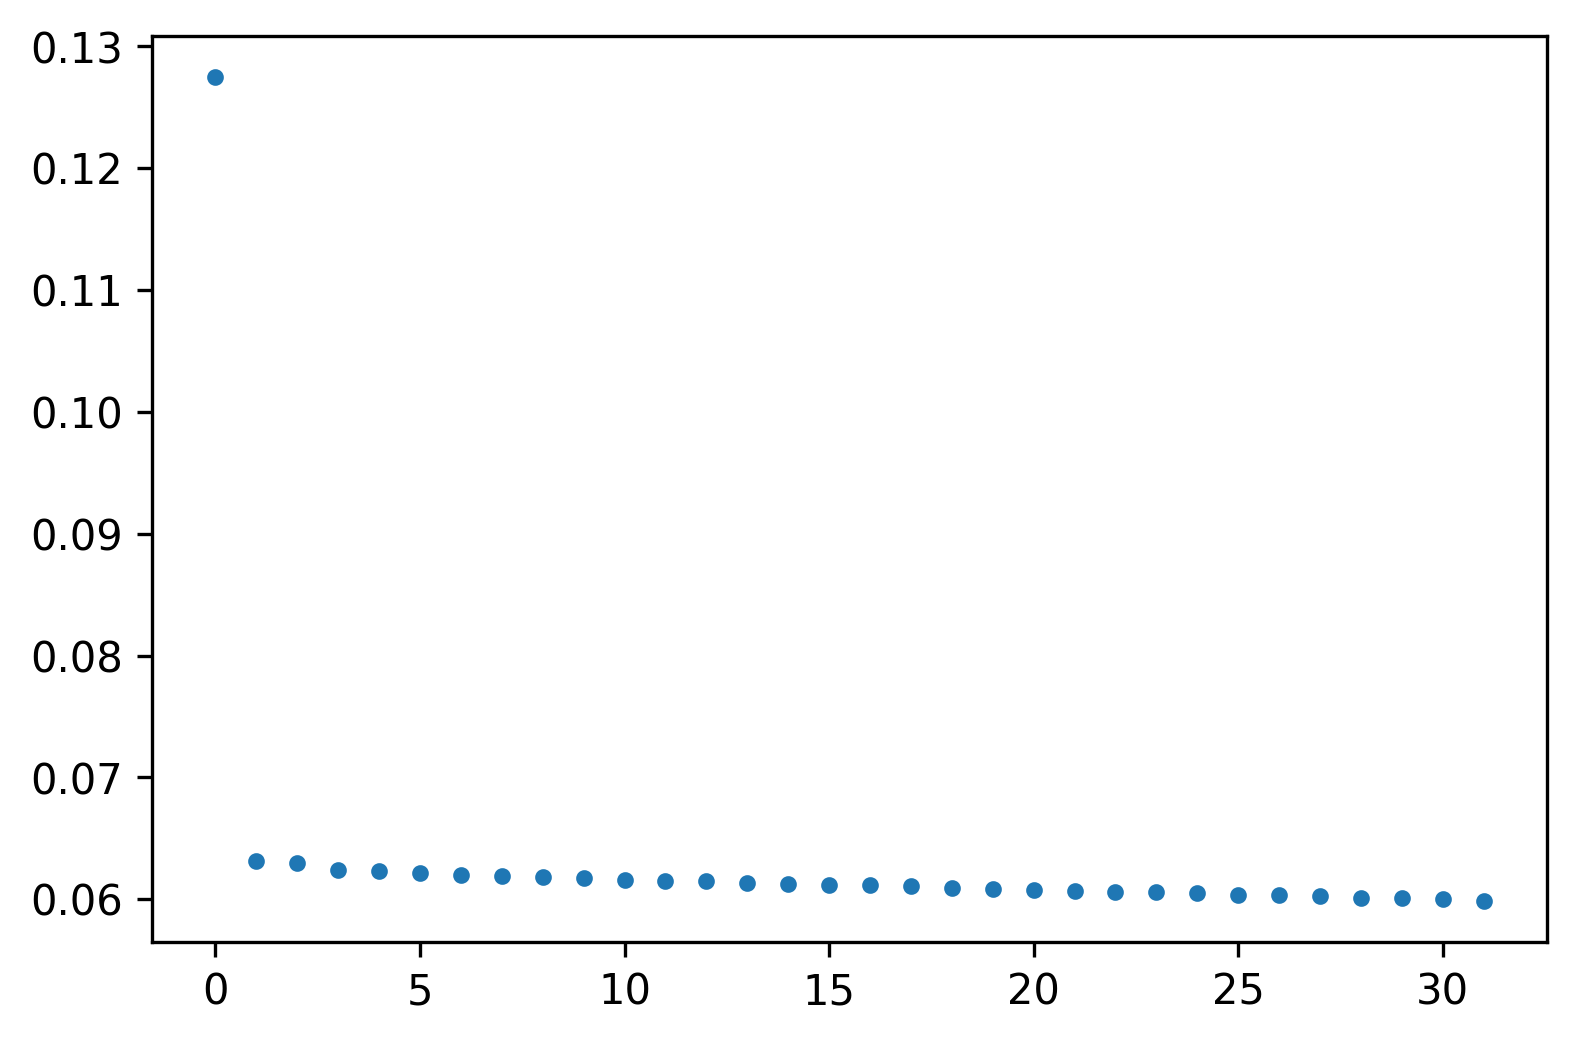

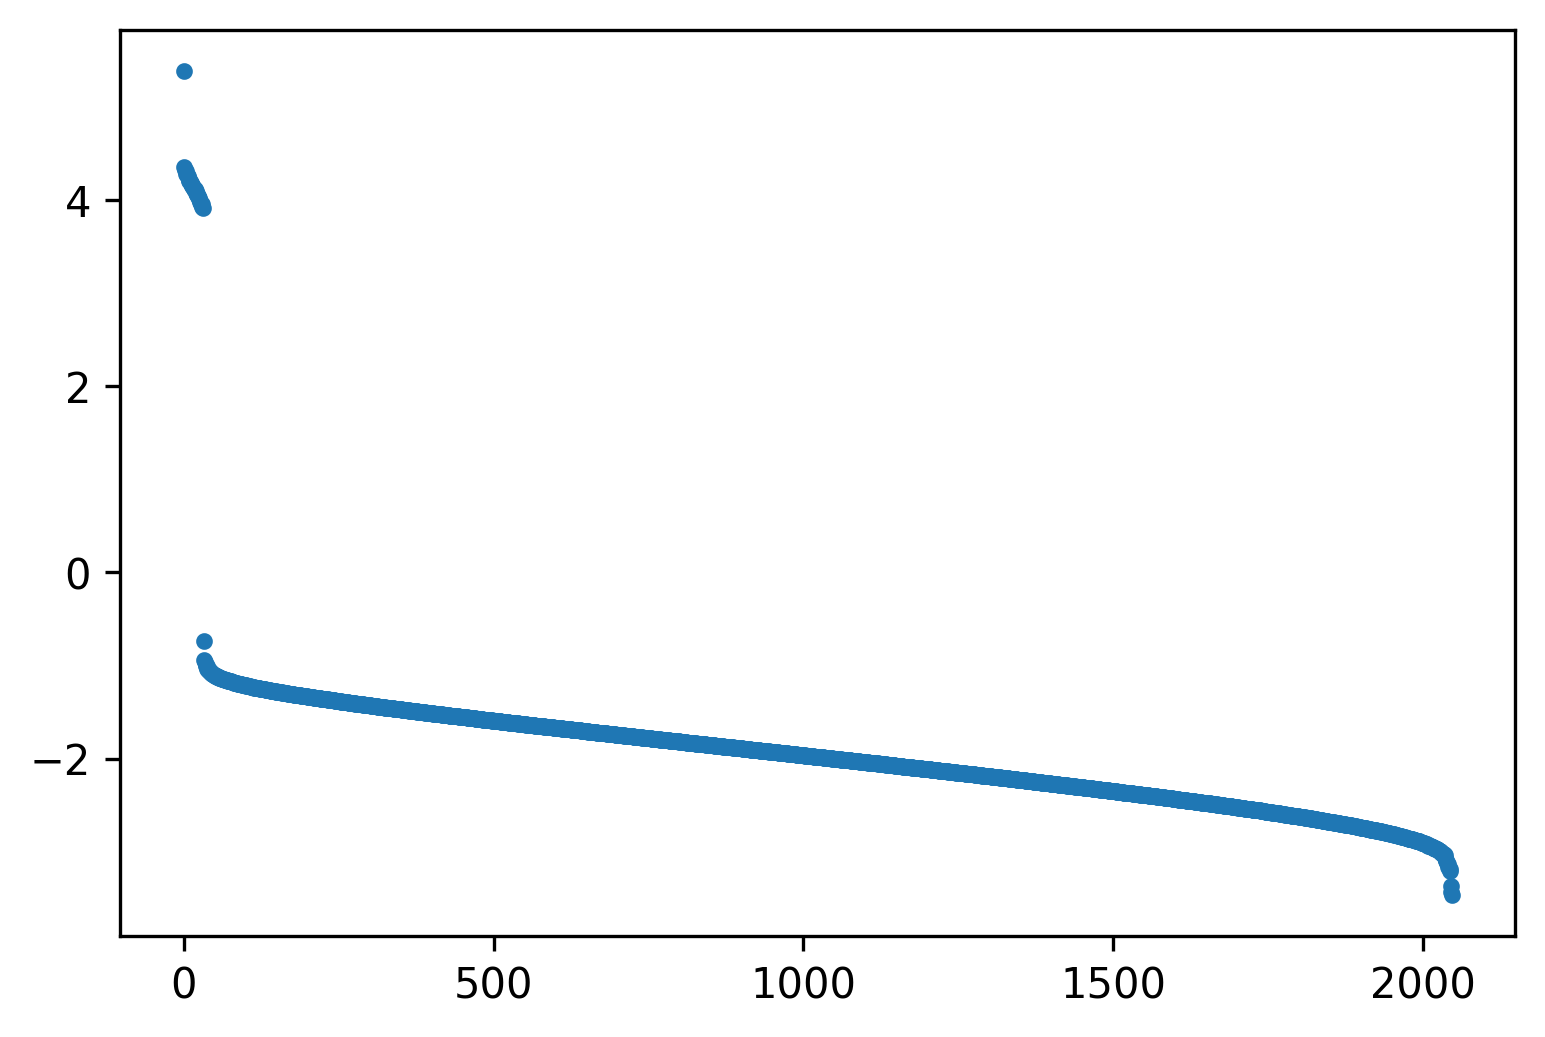

At  1800 channels, alpha is 8.904217954492992
At  1800 channels, RMSE/y_std is 0.08510355265995974
***************************  1600  *************************
0:  |F(x)| = 0.00626487; step 1
1:  |F(x)| = 0.000346635; step 1
2:  |F(x)| = 5.60891e-06; step 1


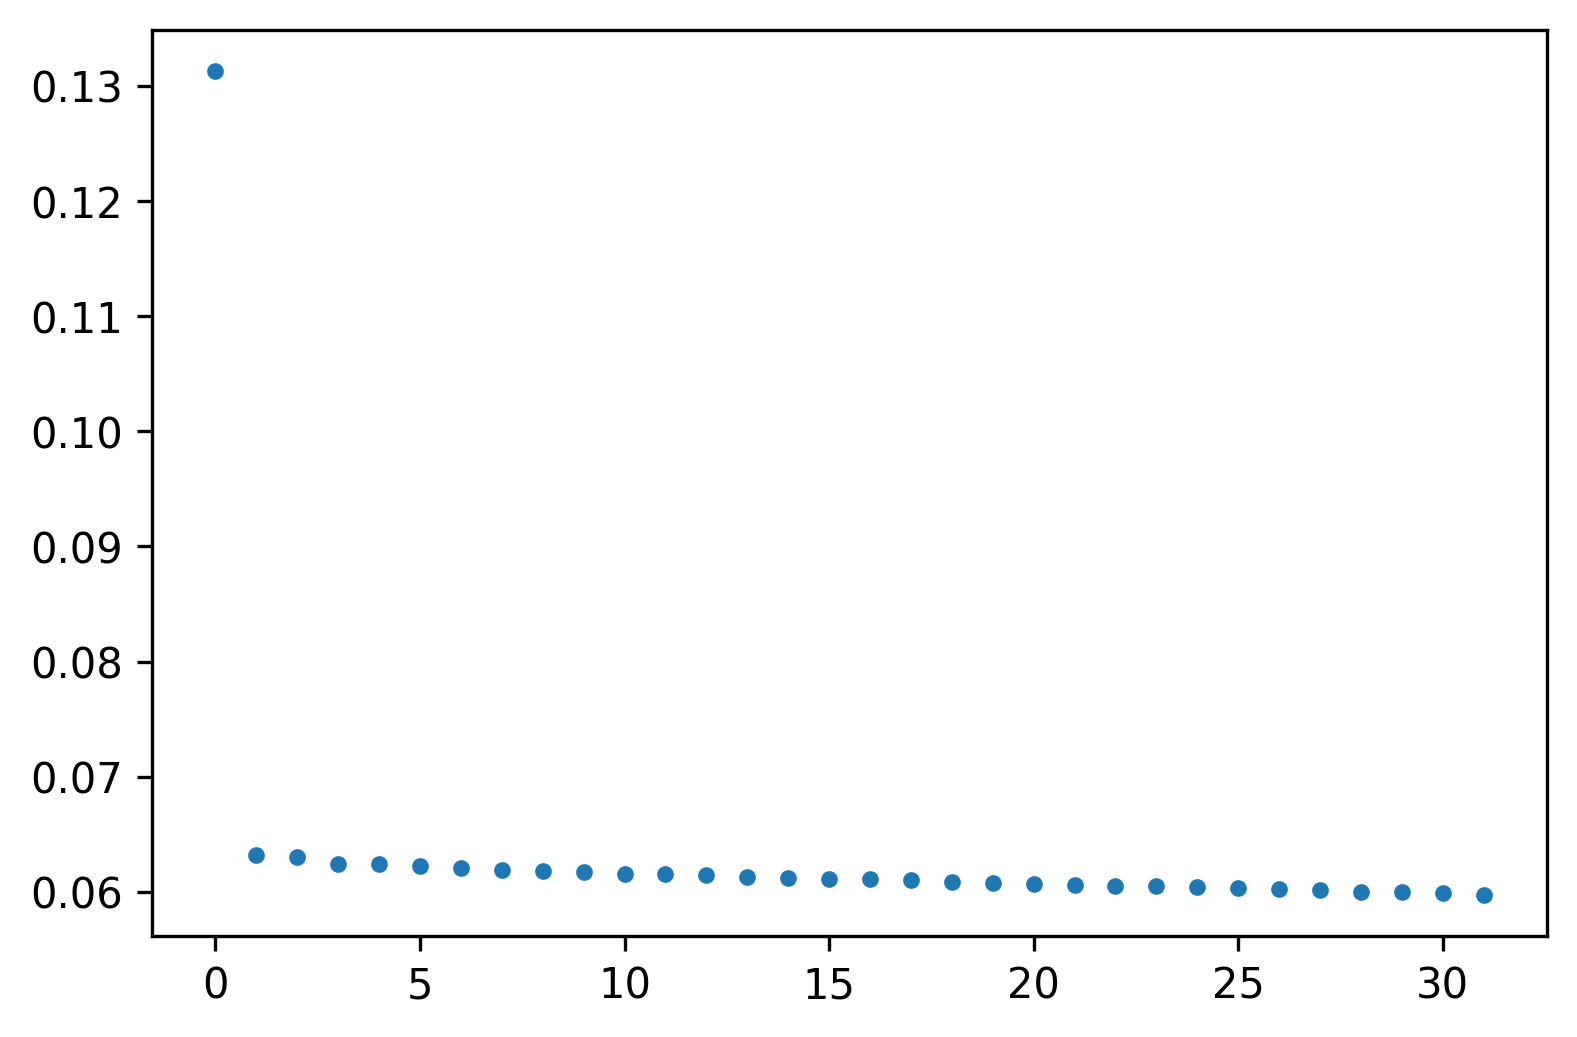

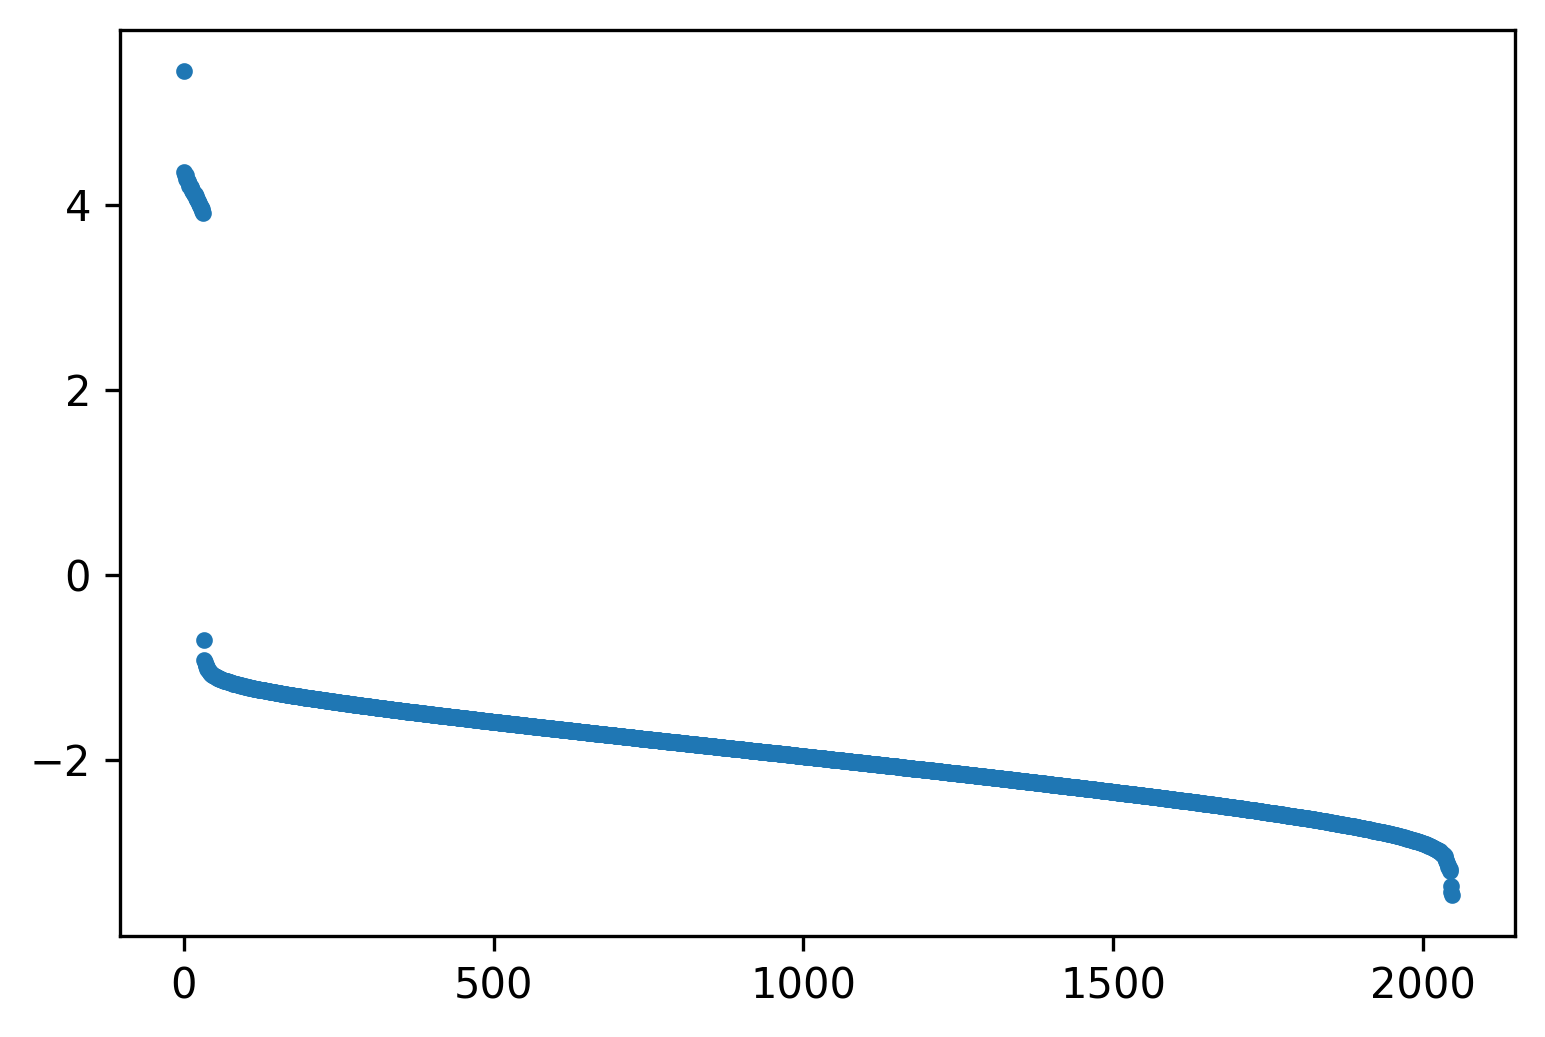

At  1600 channels, alpha is 8.398841431048755
At  1600 channels, RMSE/y_std is 0.08403235229790532
***************************  1400  *************************
0:  |F(x)| = 0.0110136; step 1
1:  |F(x)| = 0.000430671; step 1
2:  |F(x)| = 6.8177e-05; step 1
3:  |F(x)| = 1.02173e-06; step 1


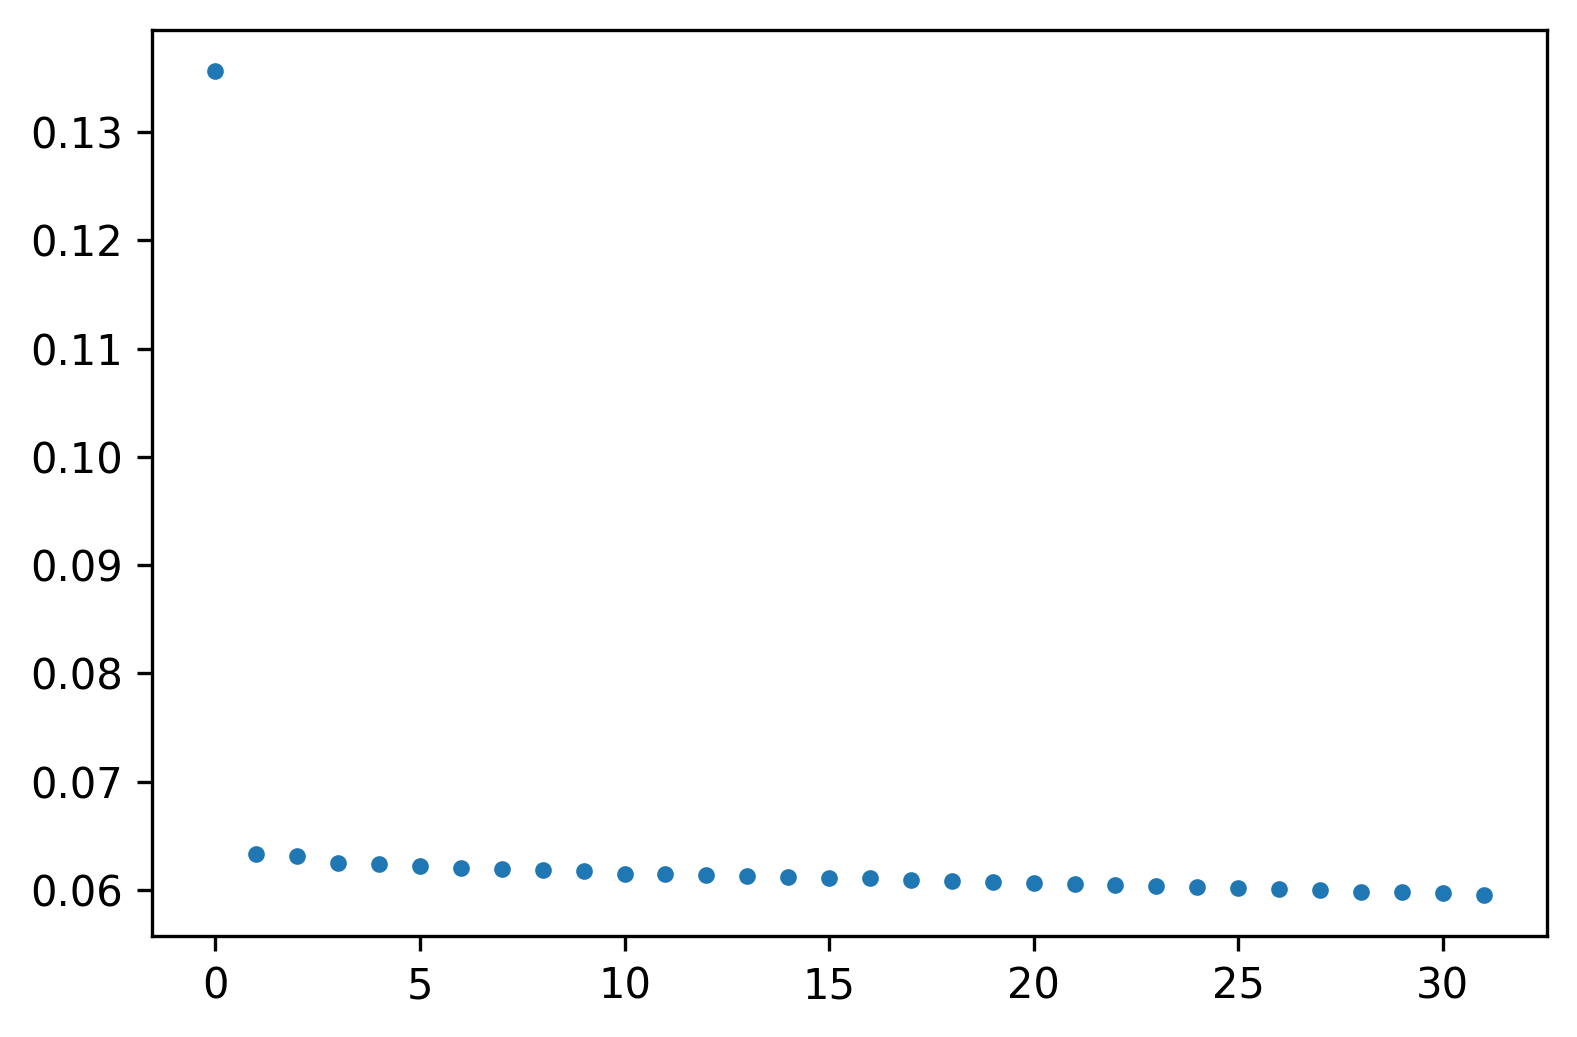

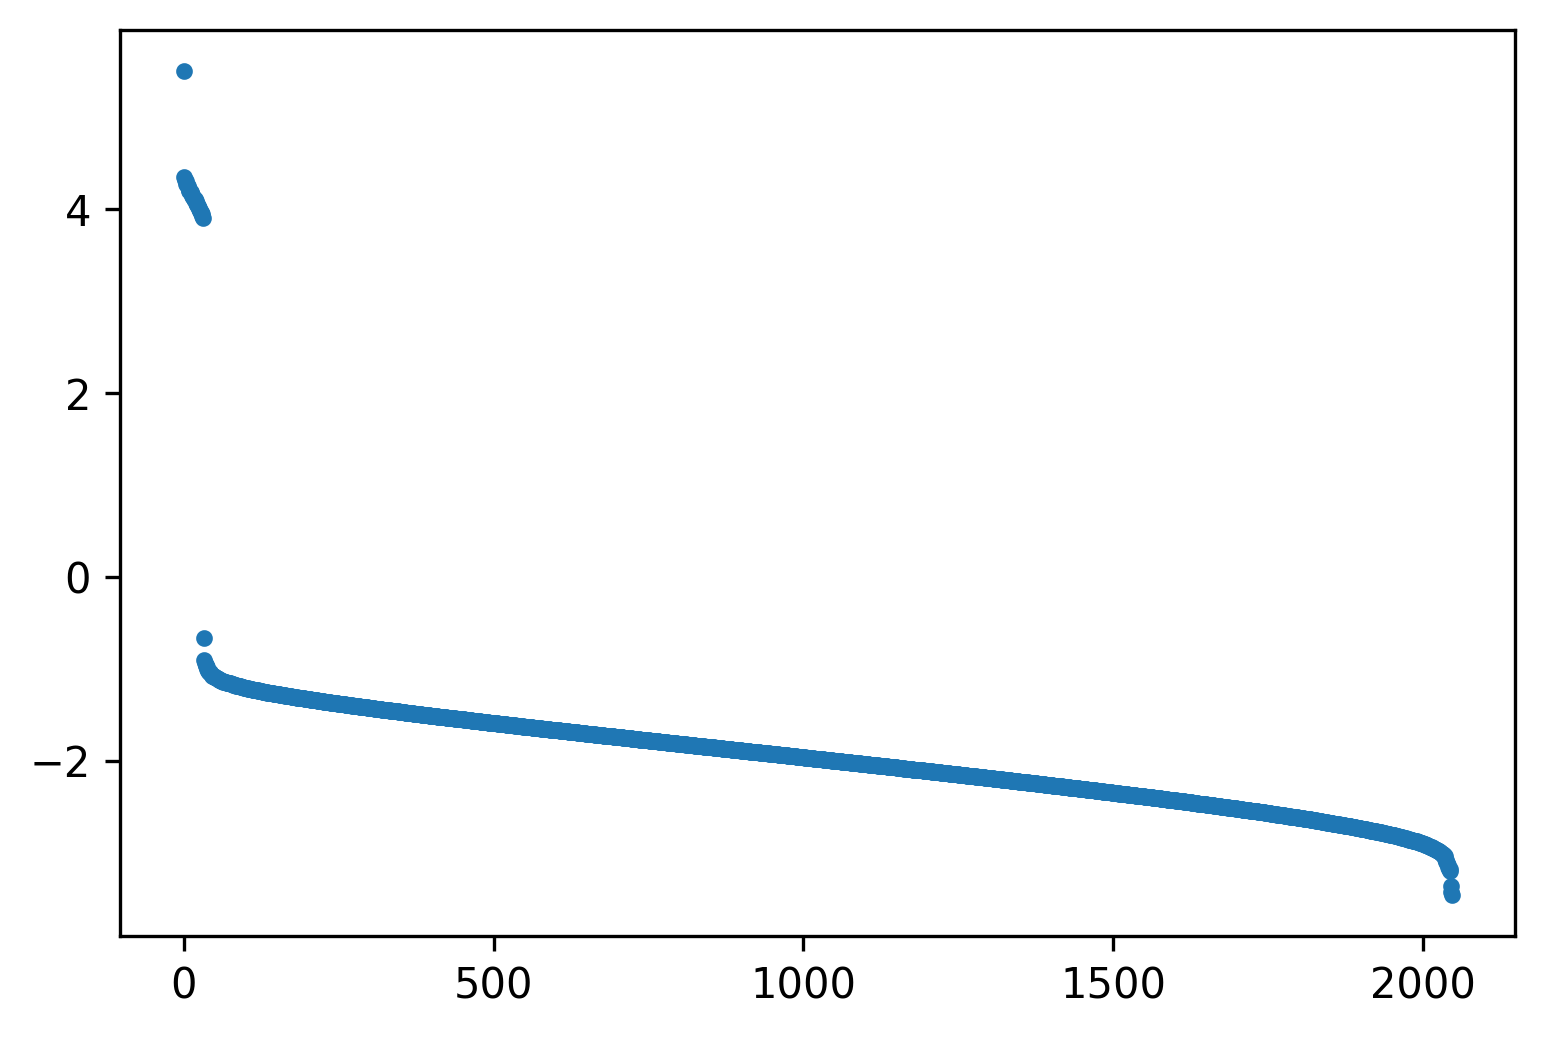

At  1400 channels, alpha is 7.871499963040795
At  1400 channels, RMSE/y_std is 0.0829421851688483
***************************  1200  *************************
0:  |F(x)| = 0.0206076; step 1
1:  |F(x)| = 0.000956673; step 1
2:  |F(x)| = 0.000405644; step 1
3:  |F(x)| = 1.22915e-05; step 1
4:  |F(x)| = 4.8476e-07; step 1


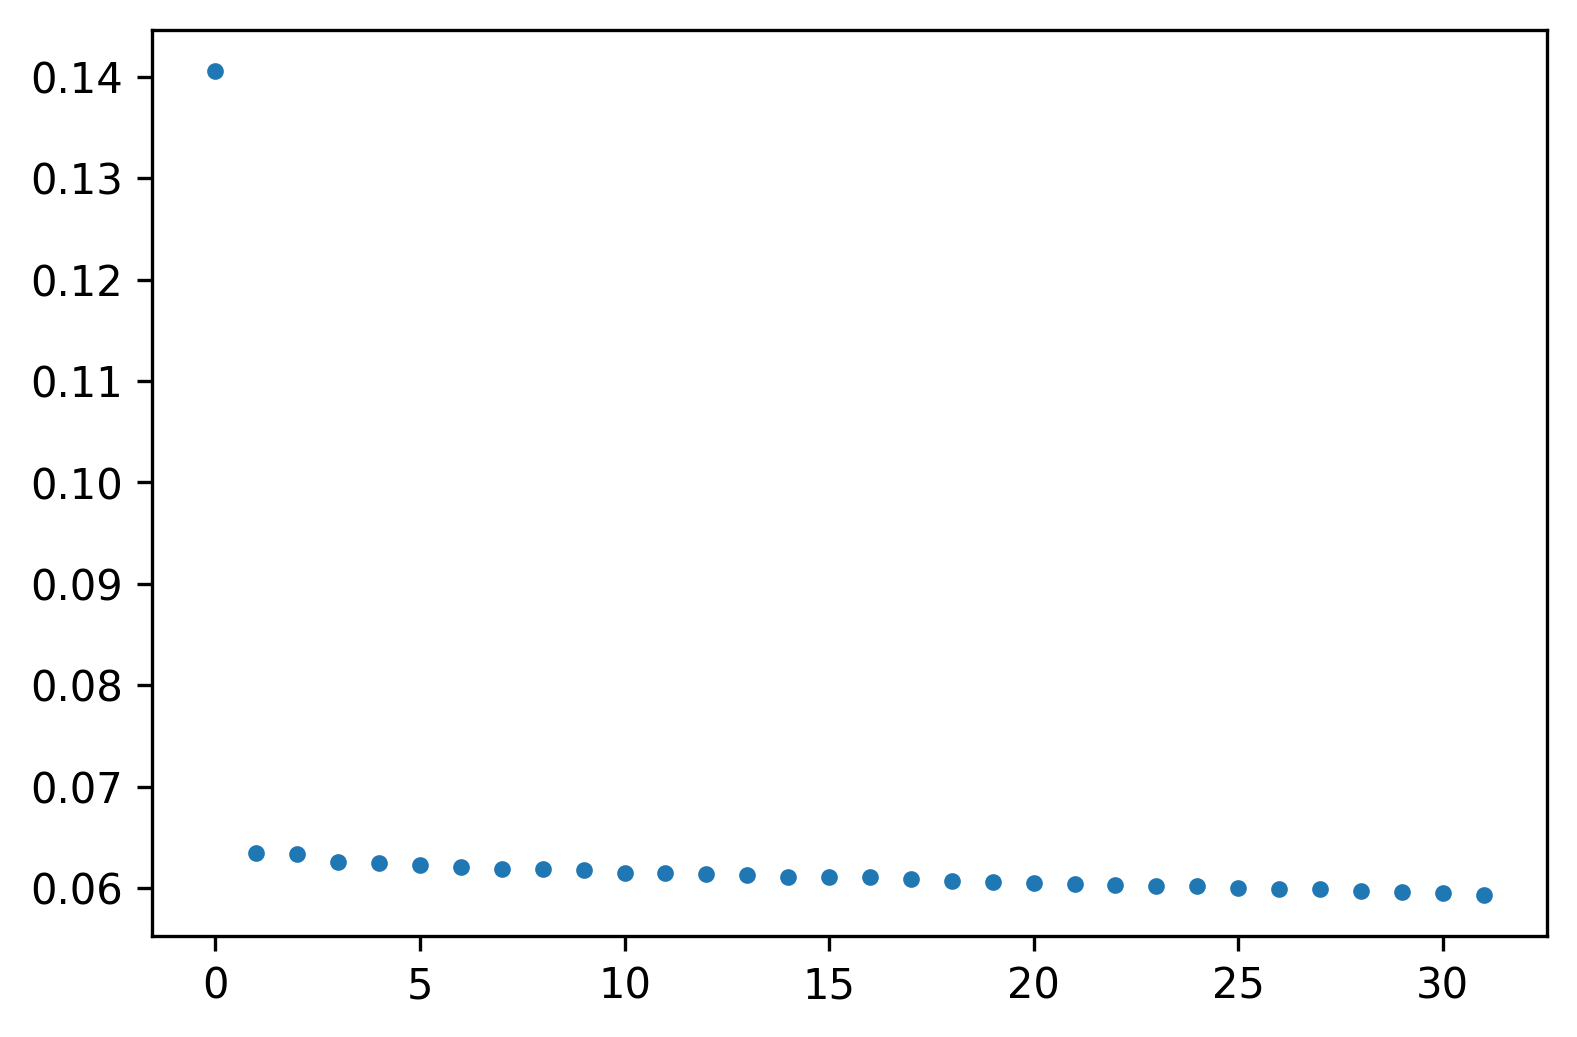

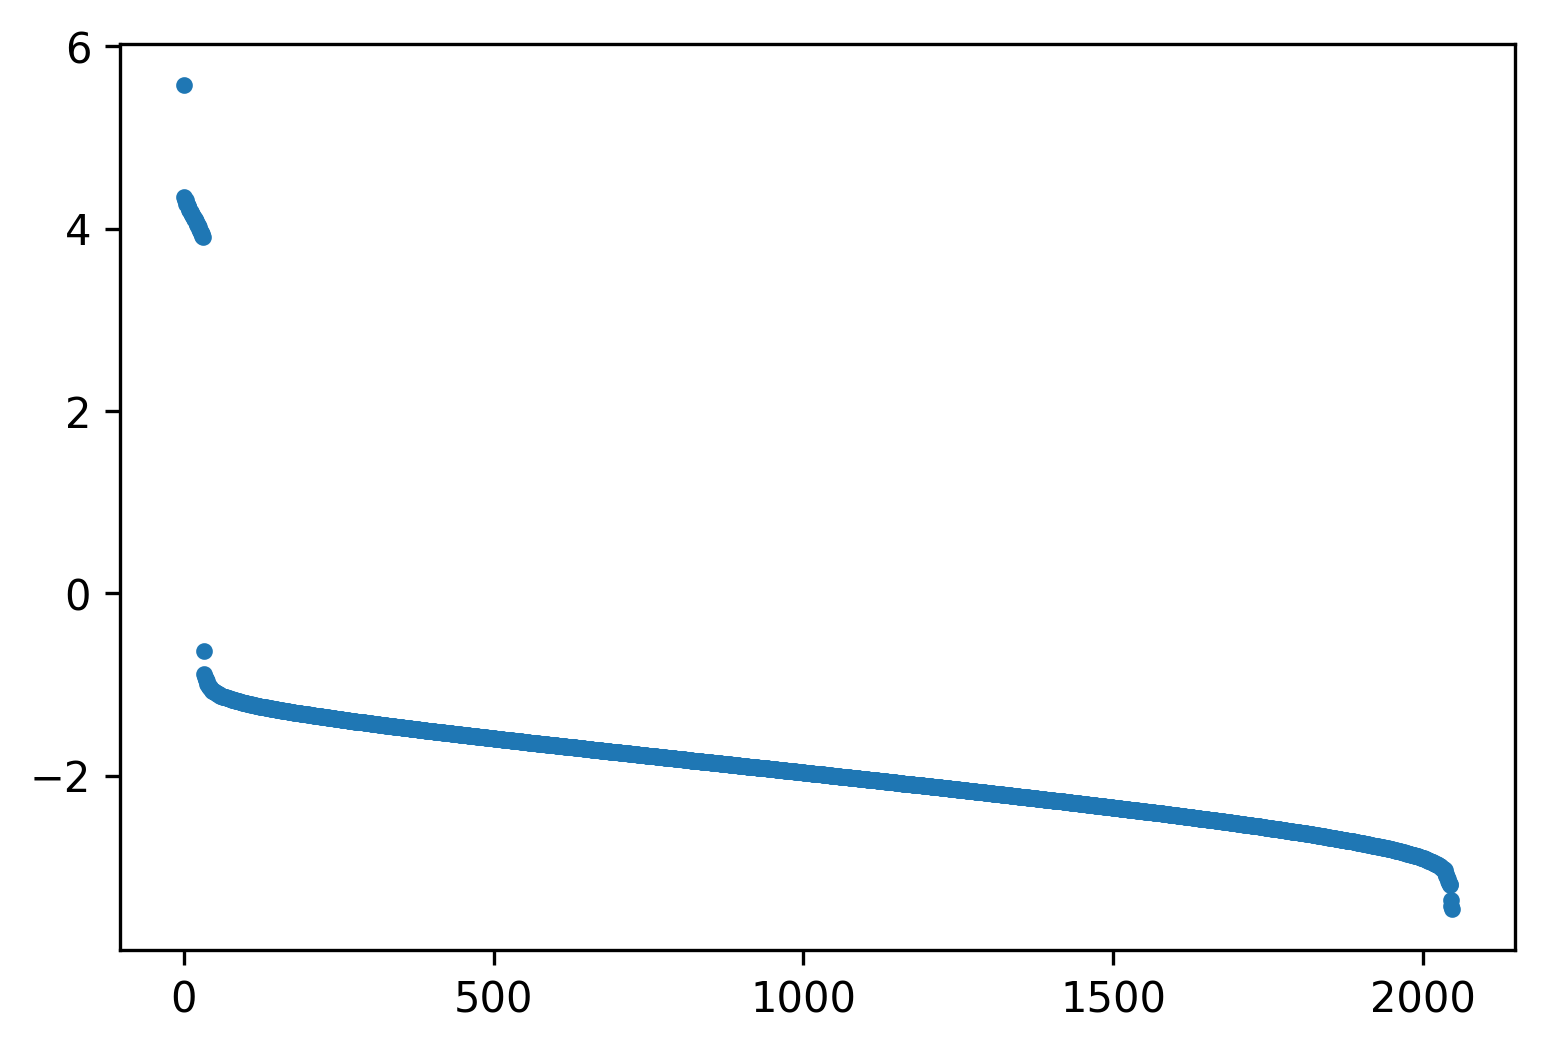

At  1200 channels, alpha is 7.319430423330147
At  1200 channels, RMSE/y_std is 0.0818328226116629
***************************  1000  *************************
0:  |F(x)| = 0.0420214; step 1
1:  |F(x)| = 0.00206397; step 1
2:  |F(x)| = 0.000599504; step 1
3:  |F(x)| = 1.35704e-05; step 1
4:  |F(x)| = 5.50337e-06; step 1


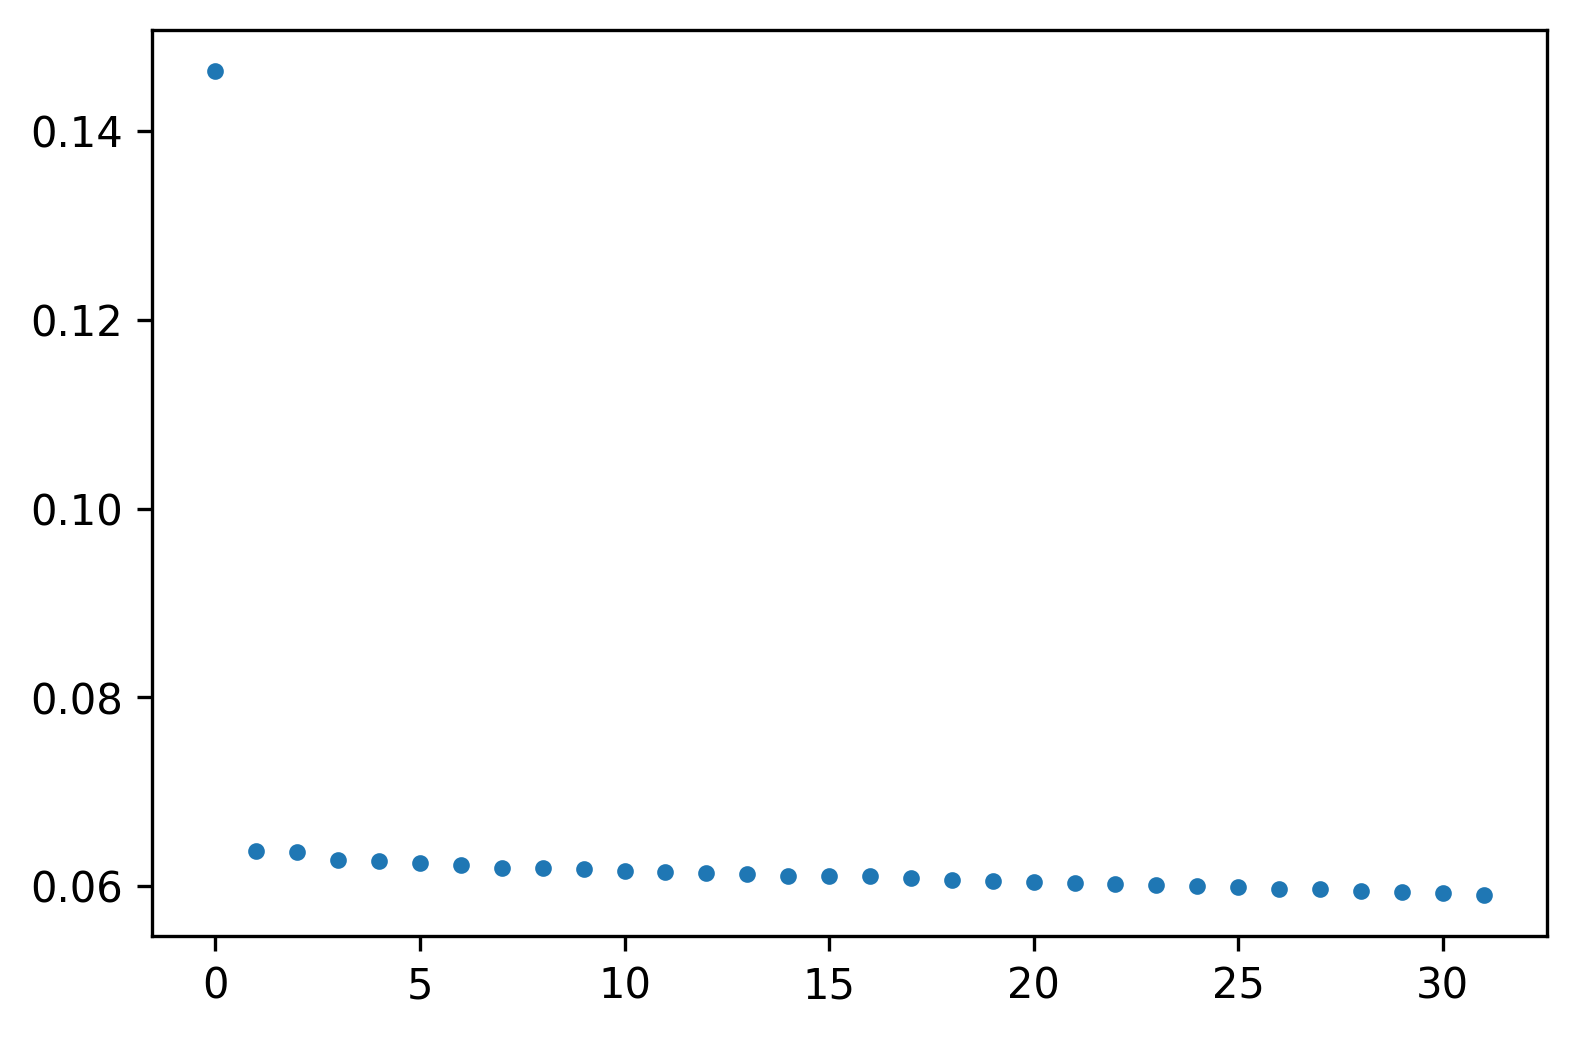

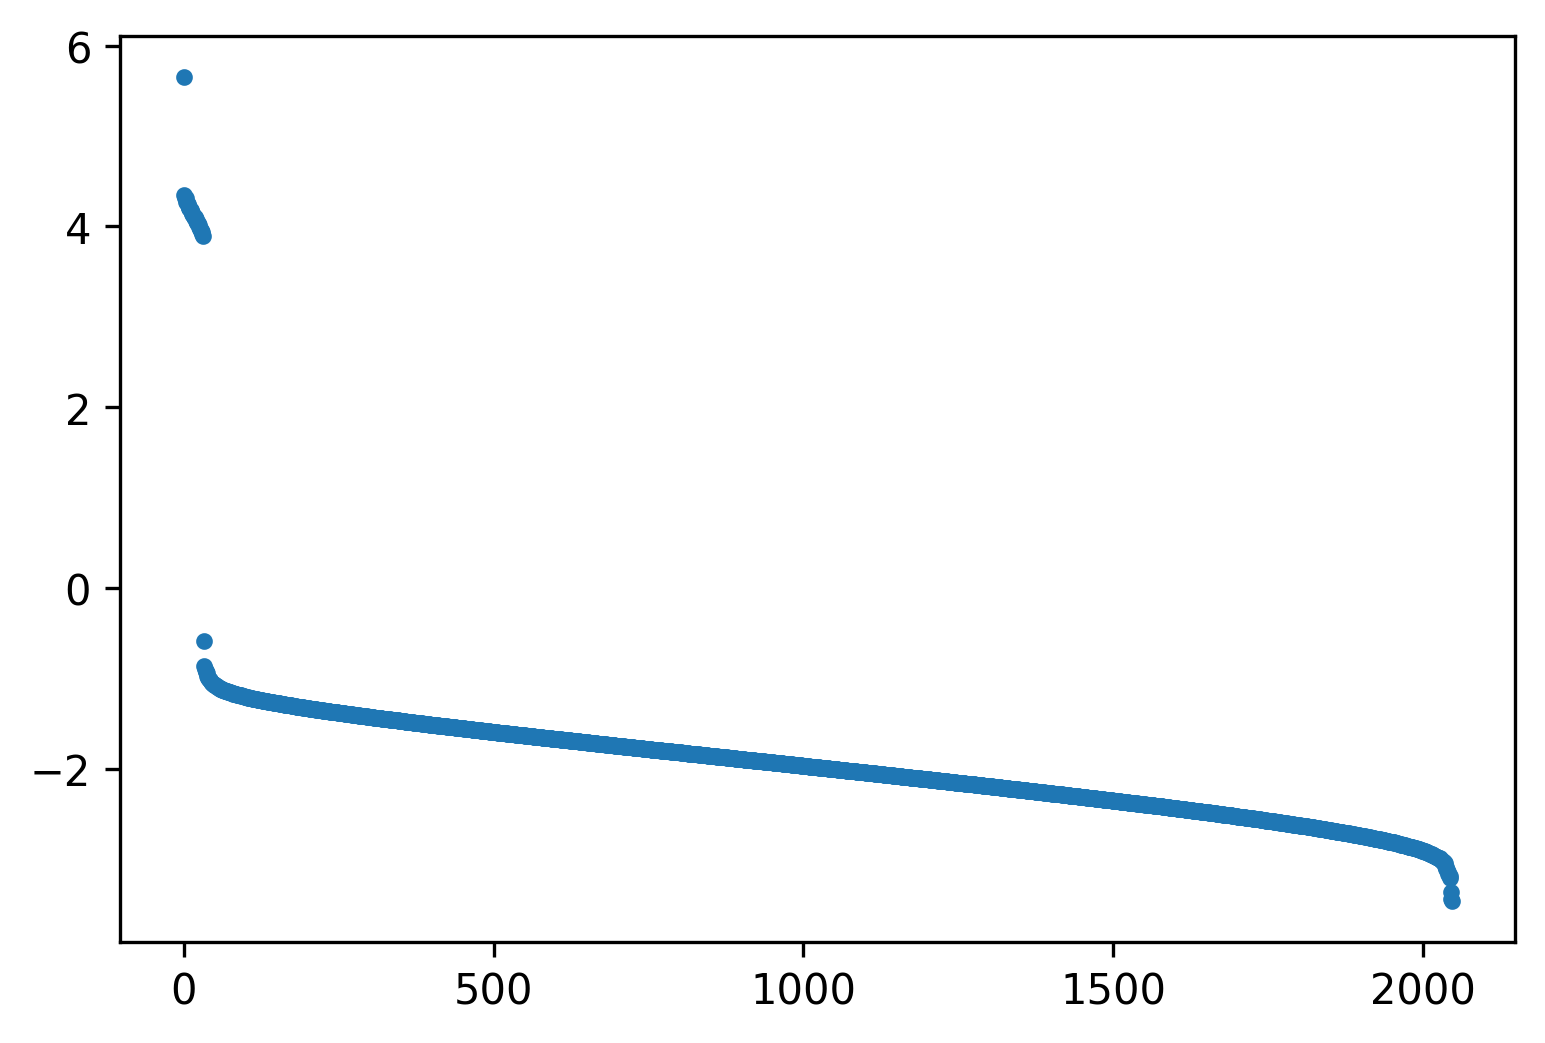

At  1000 channels, alpha is 6.737860106652294
At  1000 channels, RMSE/y_std is 0.0806977600283323
***************************  900  *************************
0:  |F(x)| = 0.015811; step 1
1:  |F(x)| = 0.000678803; step 1
2:  |F(x)| = 0.000203669; step 1
3:  |F(x)| = 1.52782e-06; step 1


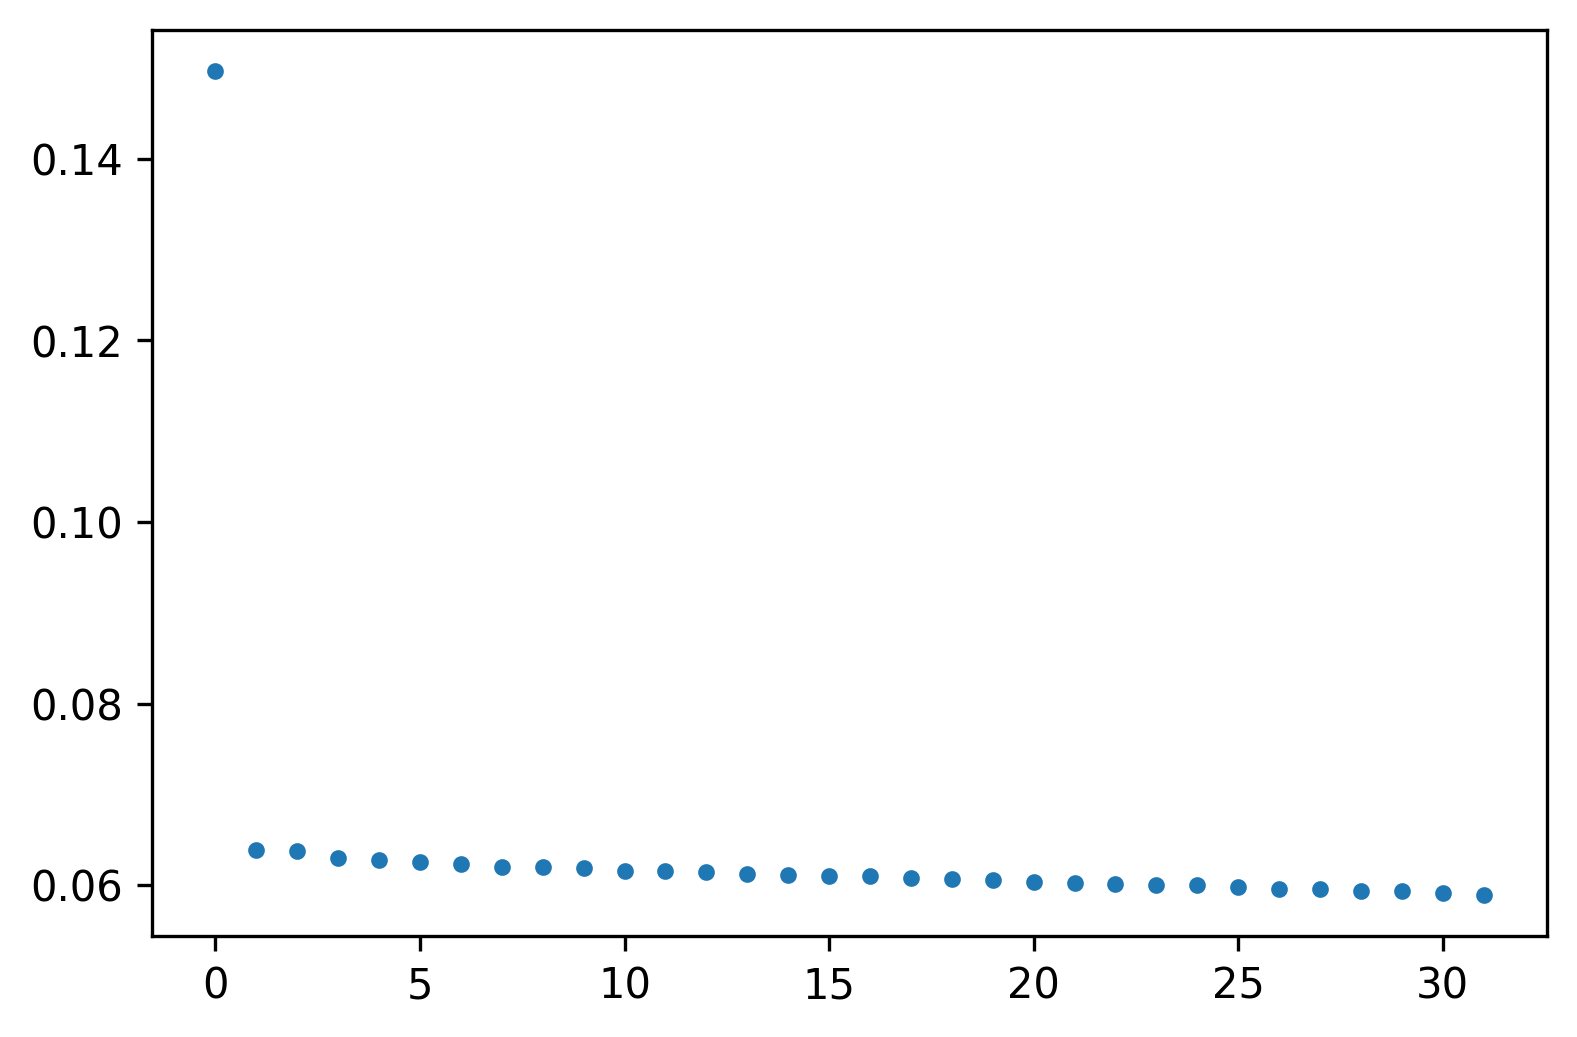

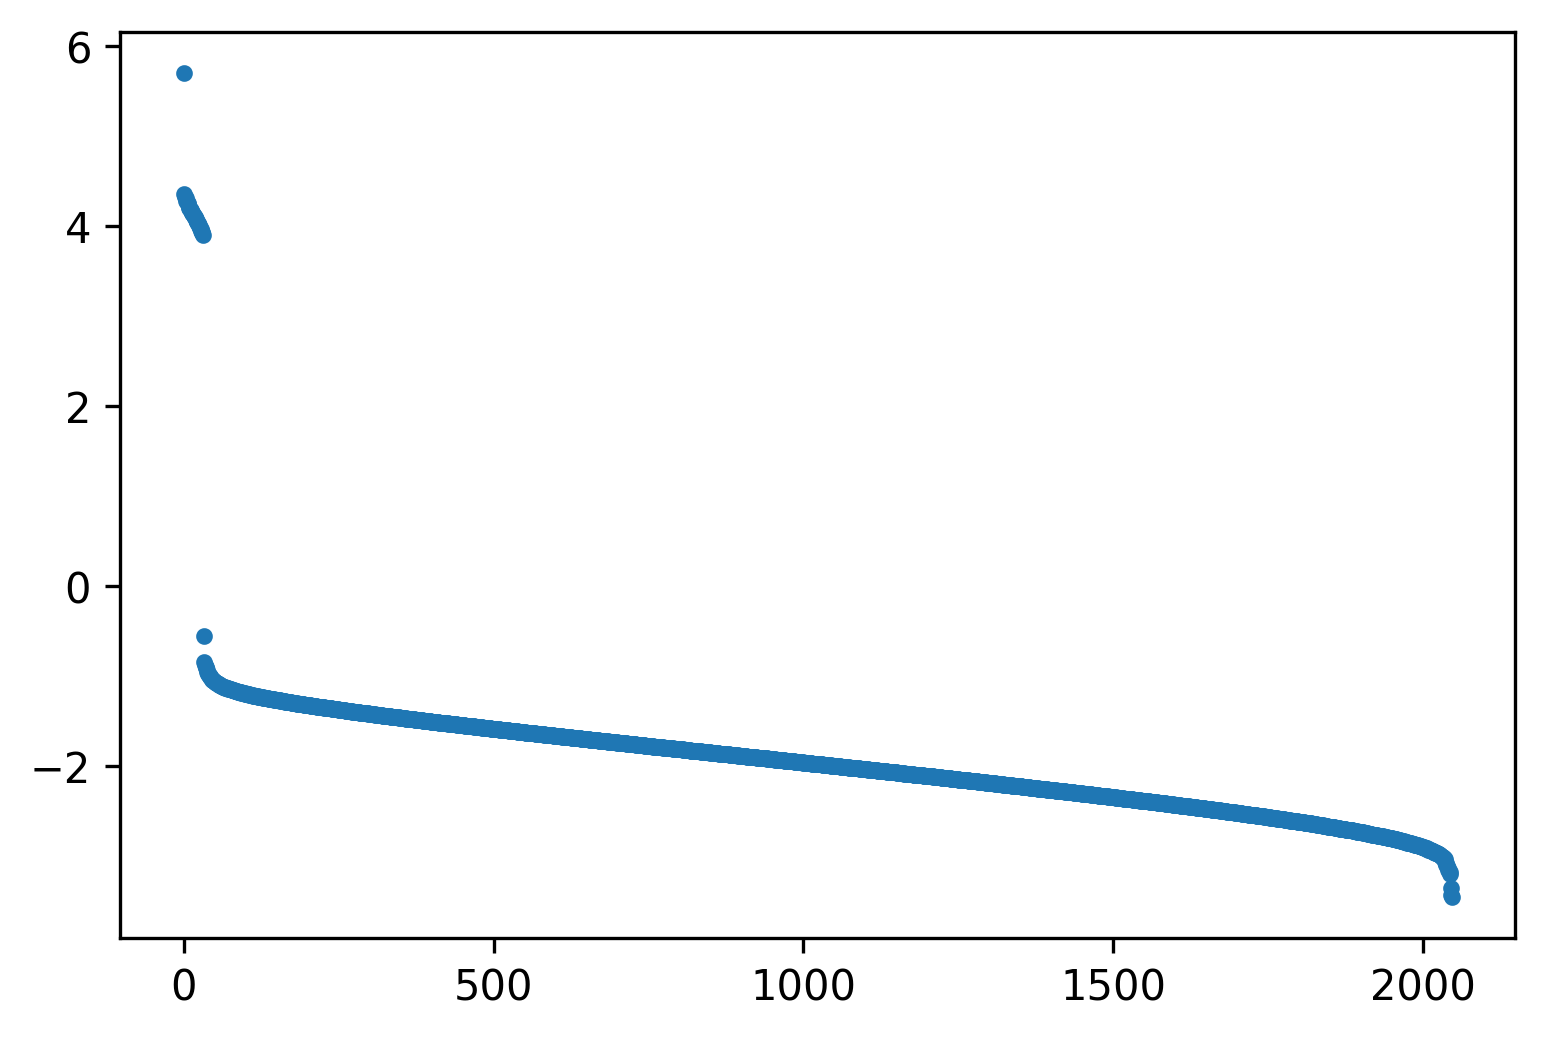

At  900 channels, alpha is 6.434422825907851
At  900 channels, RMSE/y_std is 0.08011708075418013
***************************  800  *************************
0:  |F(x)| = 0.0242997; step 1
1:  |F(x)| = 0.00116134; step 1
2:  |F(x)| = 0.000251542; step 1
3:  |F(x)| = 4.73365e-06; step 1


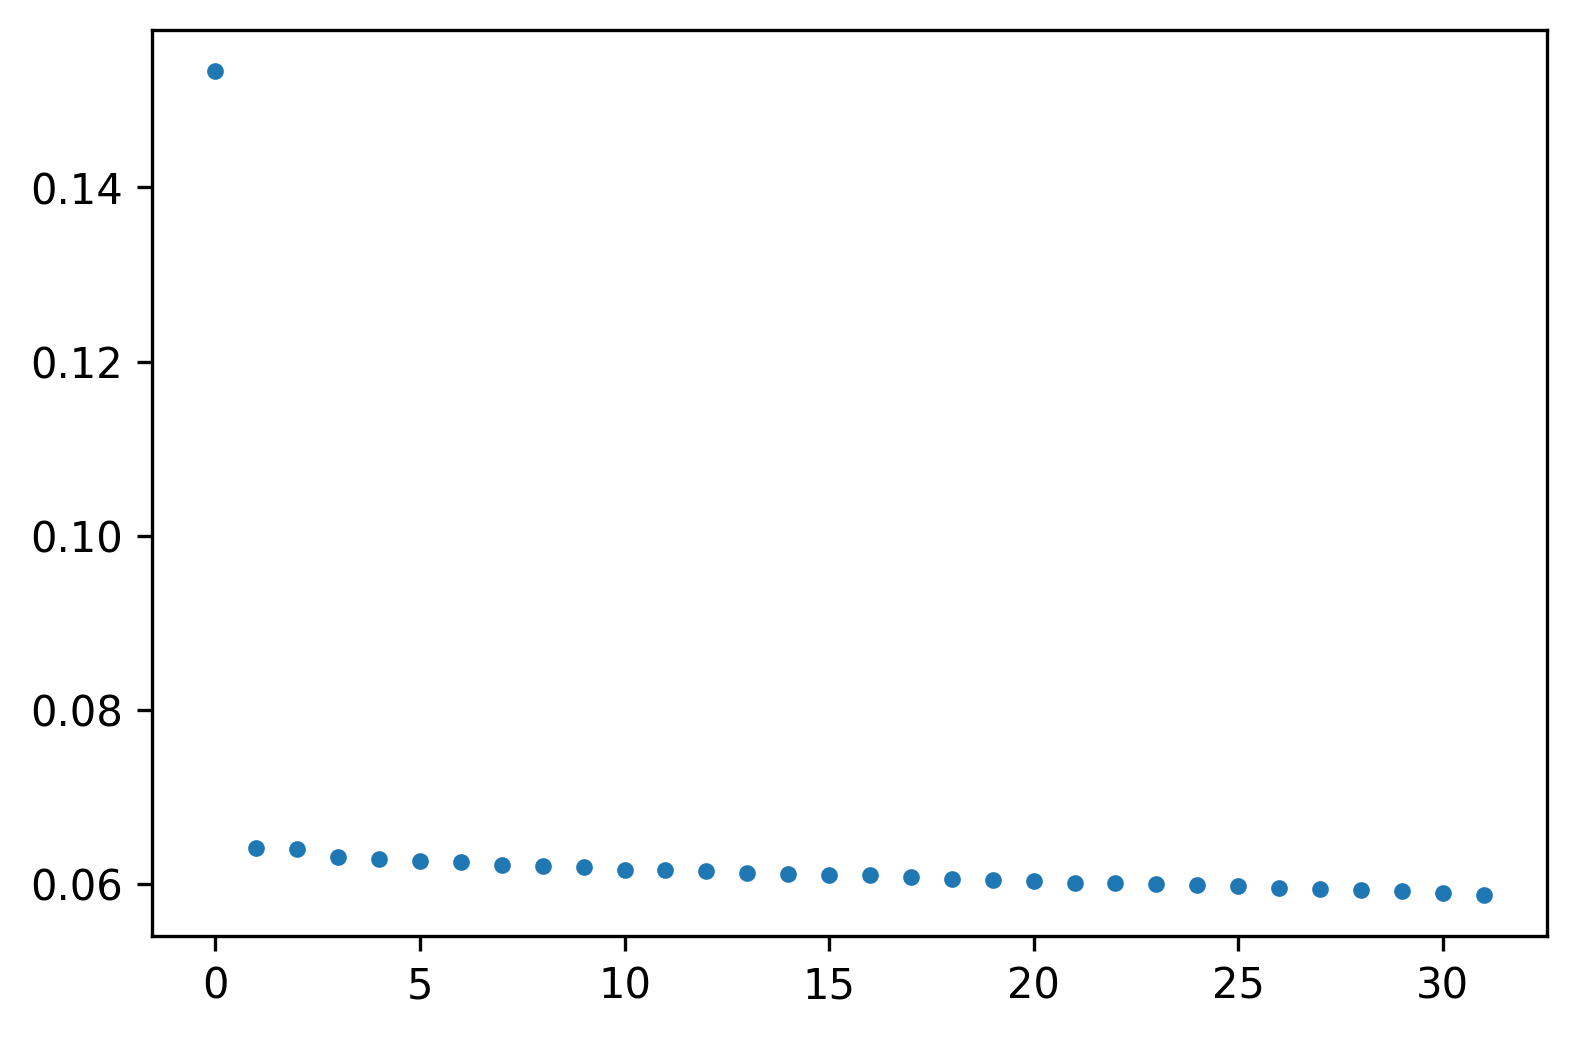

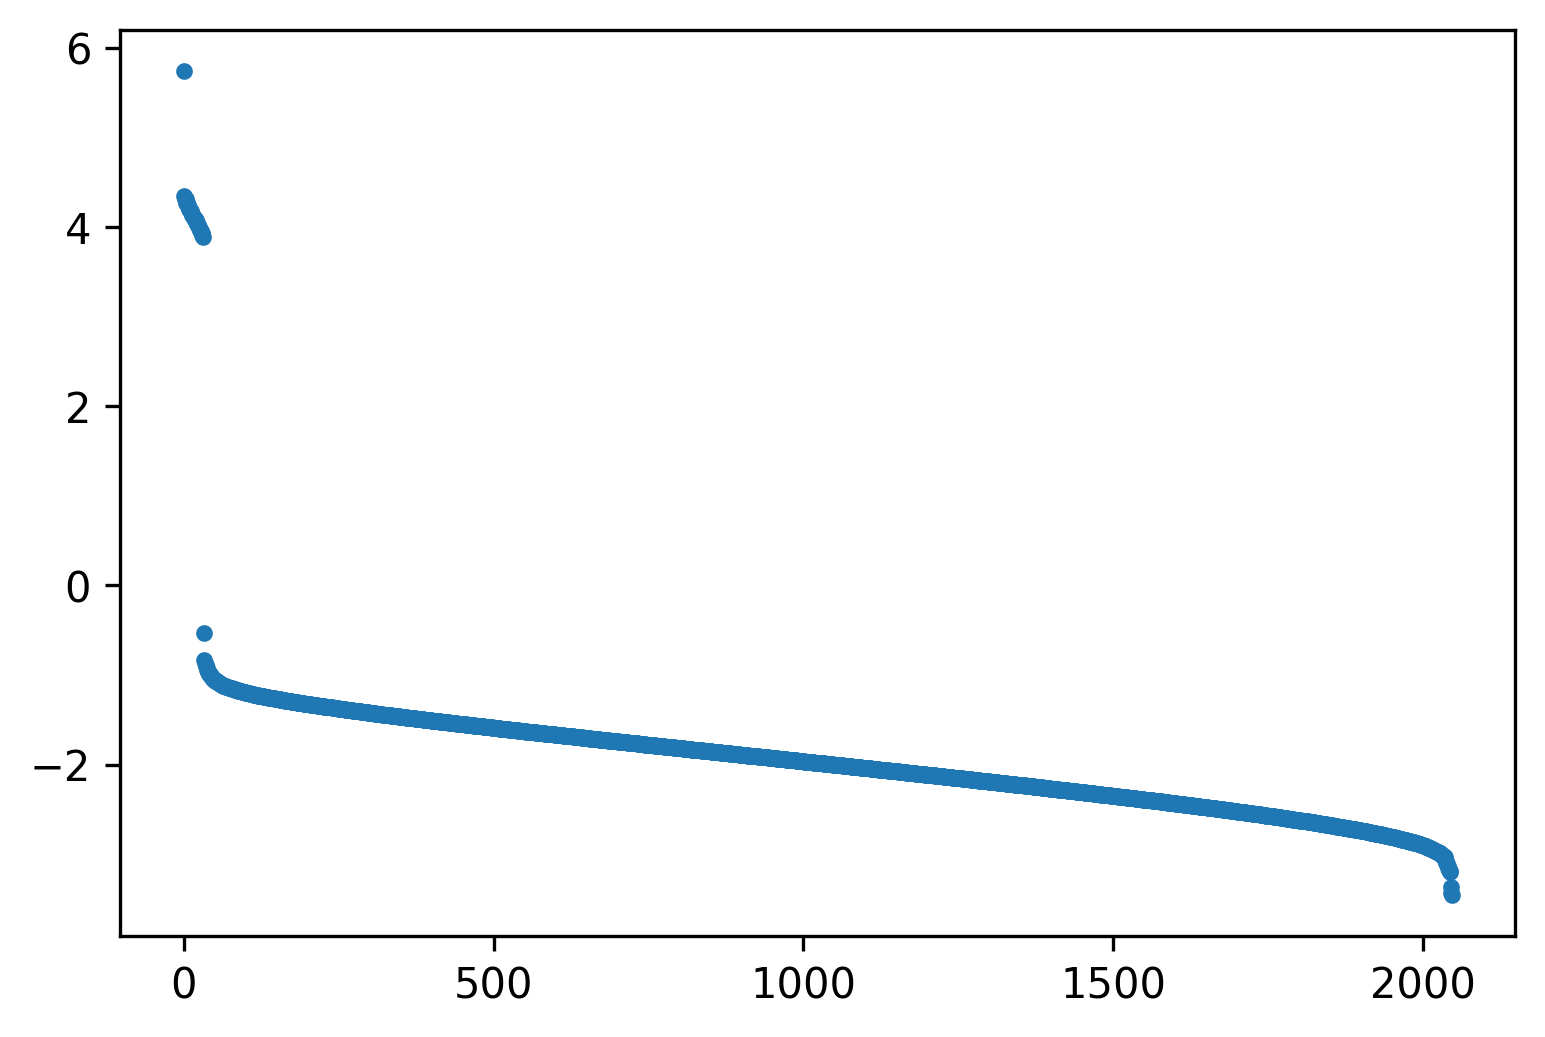

At  800 channels, alpha is 6.120075621611699
At  800 channels, RMSE/y_std is 0.07952107320308238
***************************  700  *************************
0:  |F(x)| = 0.0390978; step 1
1:  |F(x)| = 0.00147956; step 1
2:  |F(x)| = 0.00036185; step 1
3:  |F(x)| = 8.33899e-06; step 1
4:  |F(x)| = 4.94553e-06; step 1


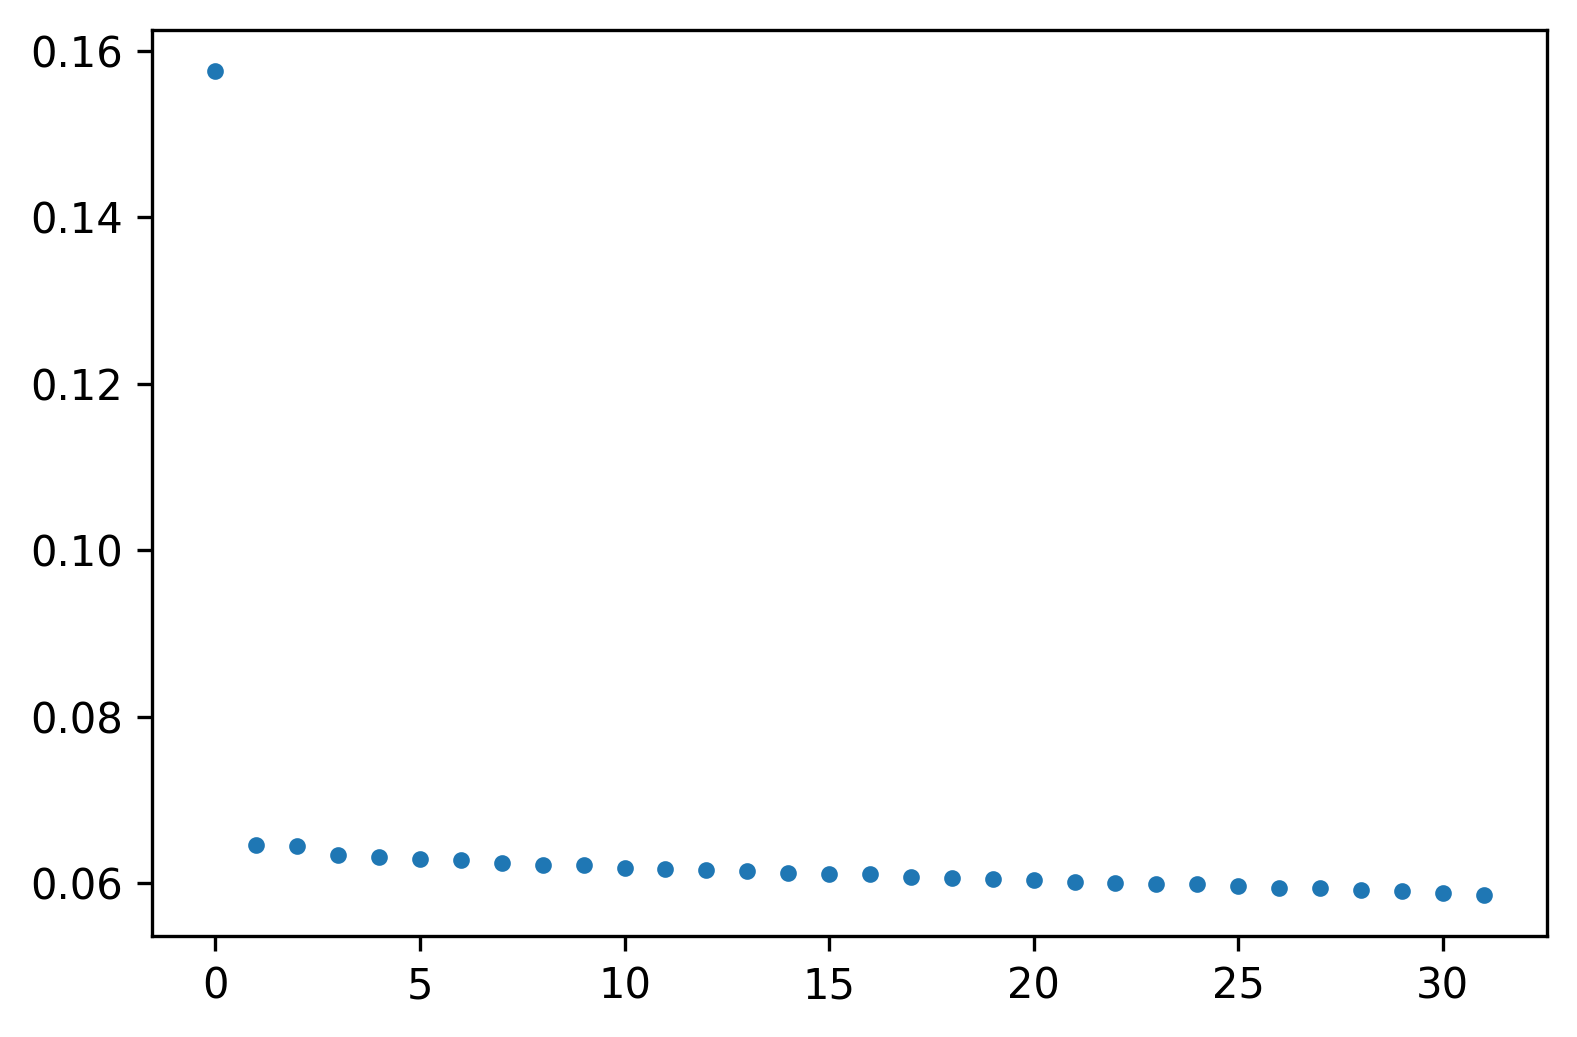

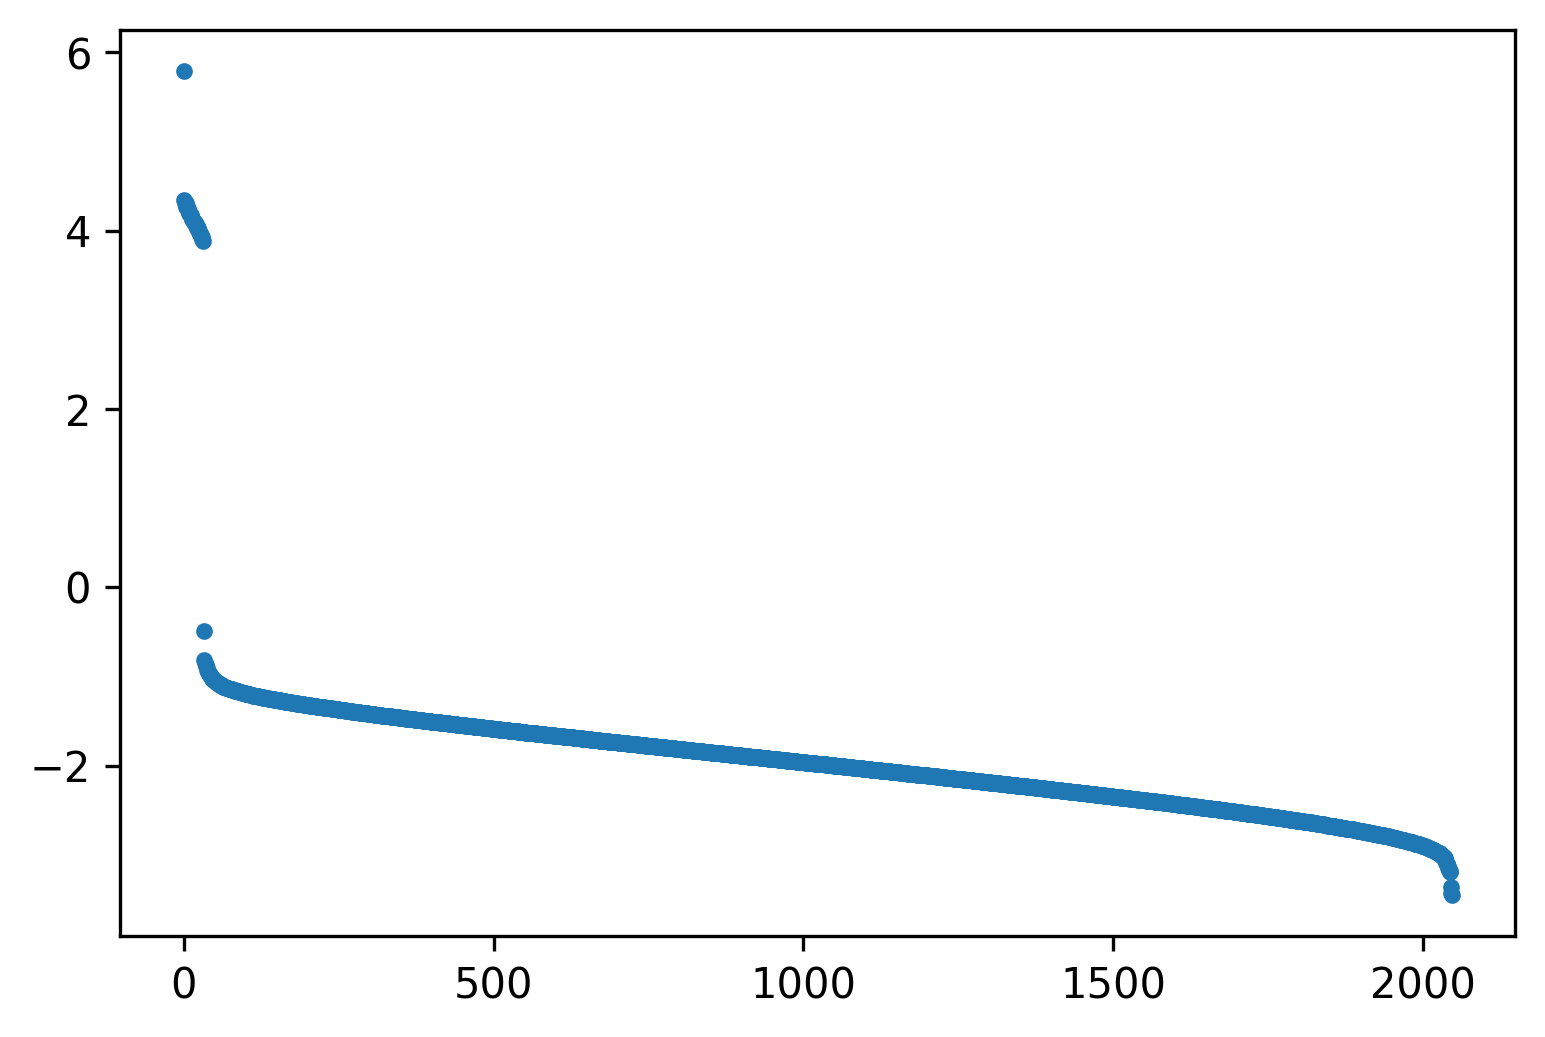

At  700 channels, alpha is 5.791947823933362
At  700 channels, RMSE/y_std is 0.07890252883470518
***************************  650  *************************
0:  |F(x)| = 0.0126757; step 1
1:  |F(x)| = 0.000494232; step 1
2:  |F(x)| = 0.000104271; step 1
3:  |F(x)| = 1.24928e-06; step 1


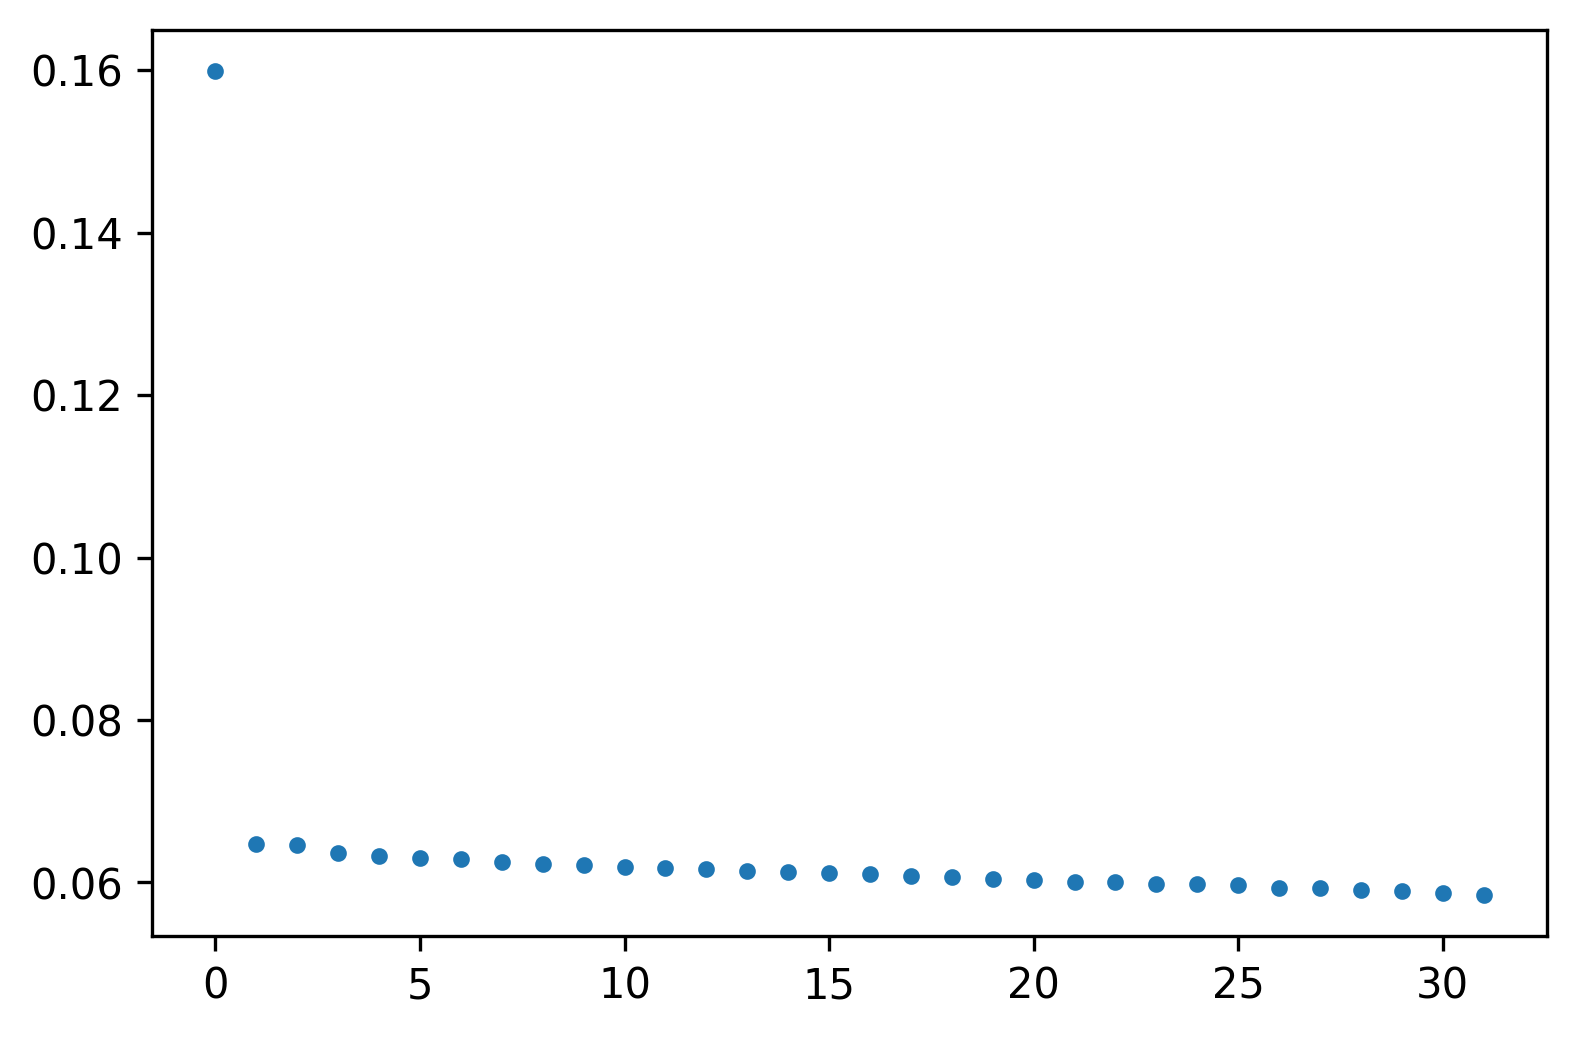

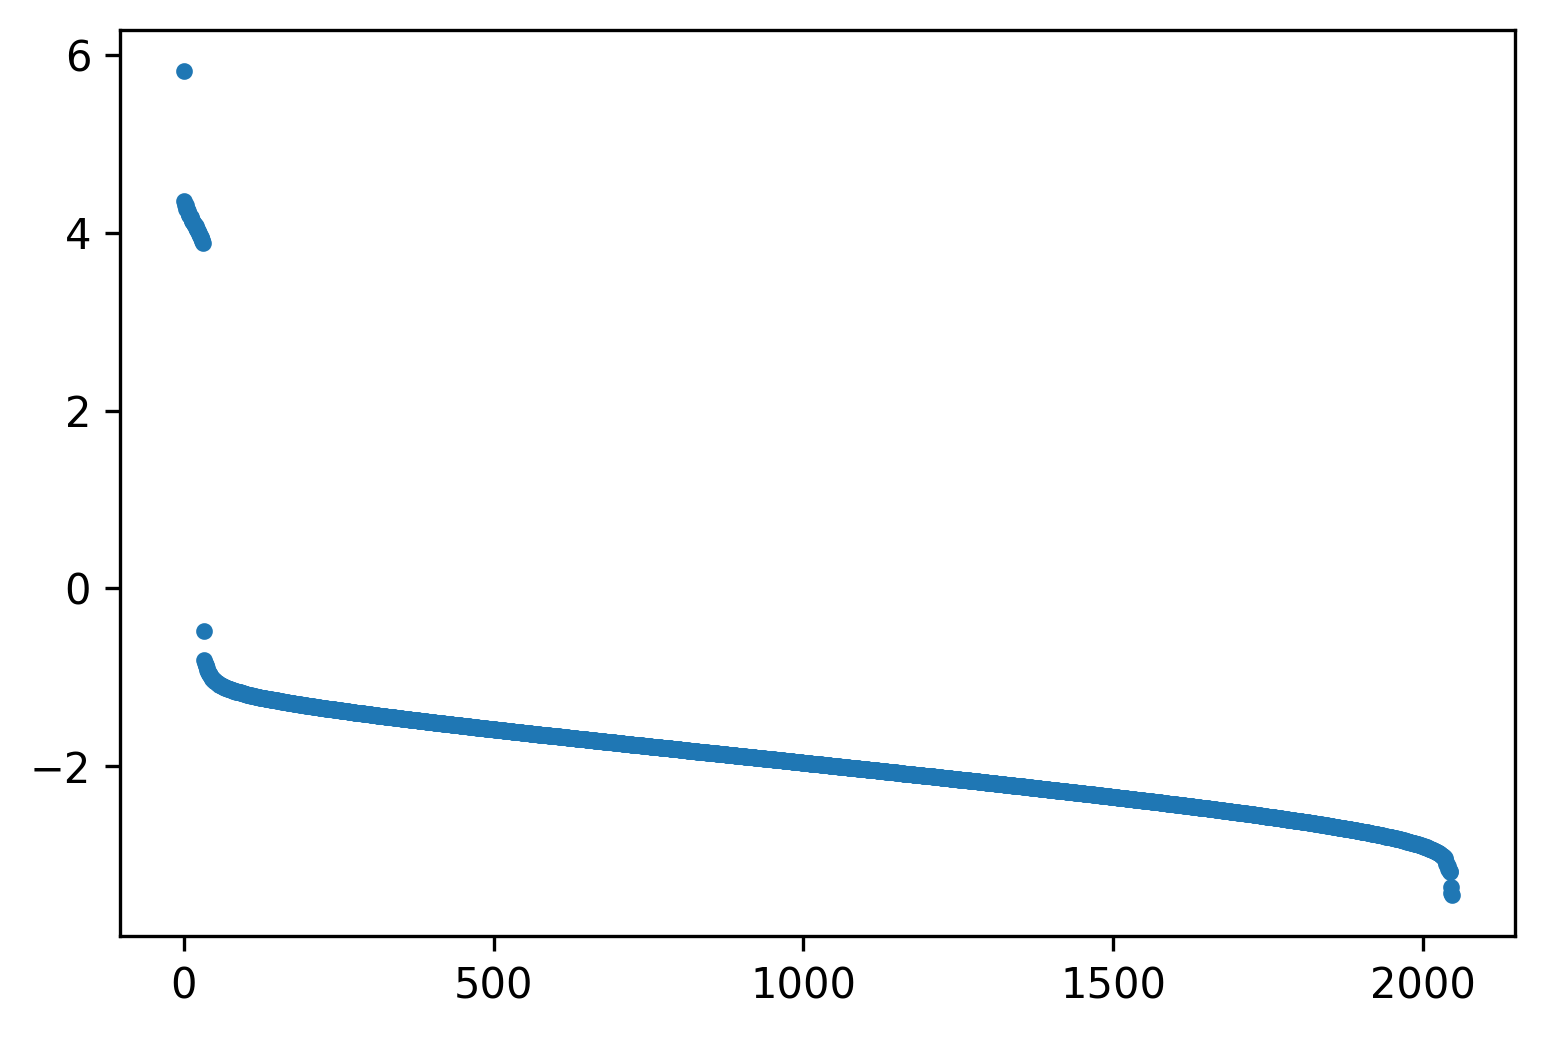

At  650 channels, alpha is 5.622390300976503
At  650 channels, RMSE/y_std is 0.07858198013822905
***************************  600  *************************
0:  |F(x)| = 0.0166566; step 1
1:  |F(x)| = 0.000568618; step 1
2:  |F(x)| = 0.000106664; step 1
3:  |F(x)| = 4.09234e-06; step 1


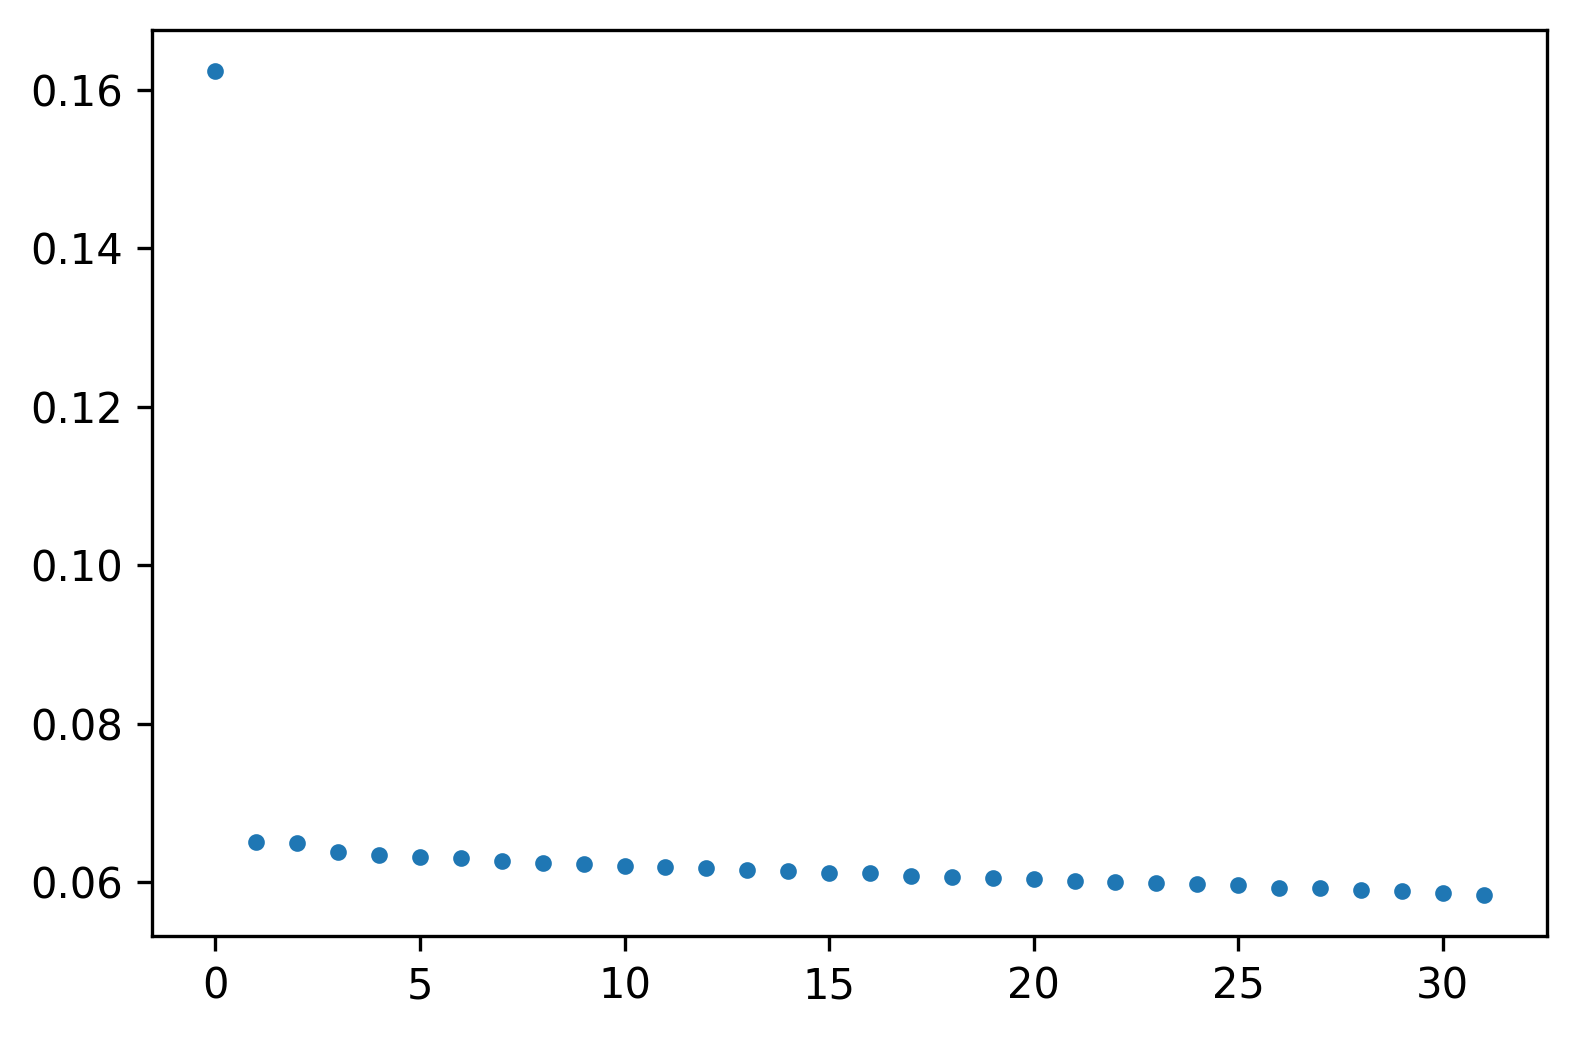

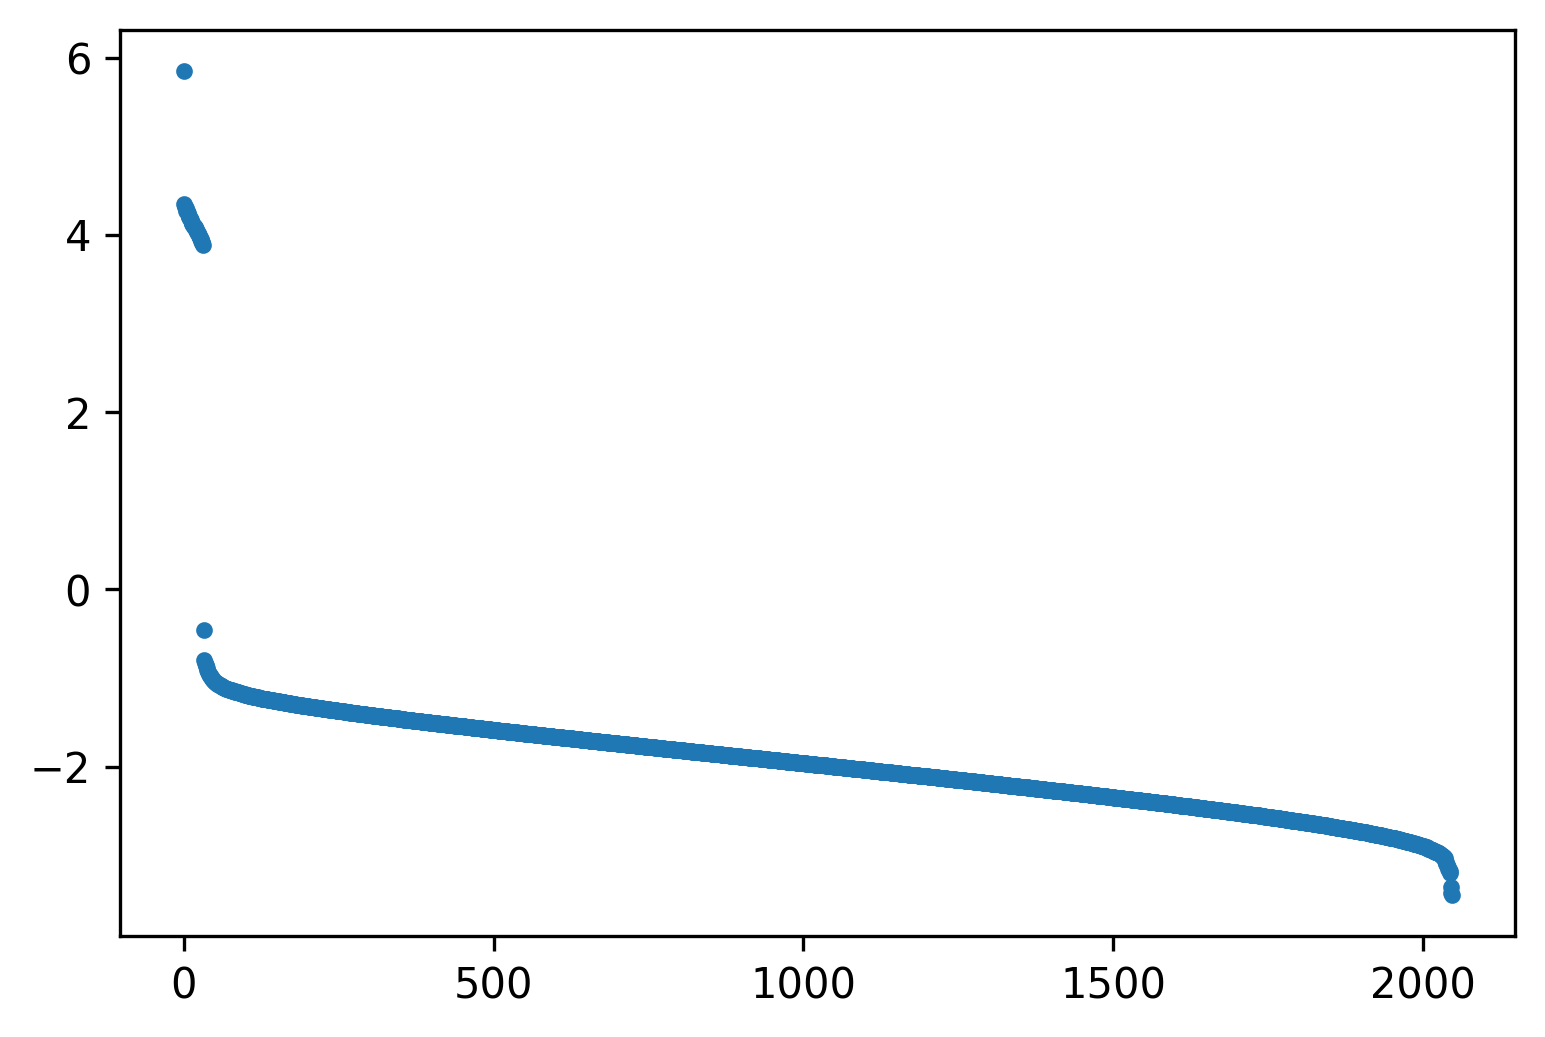

At  600 channels, alpha is 5.4476955118505135
At  600 channels, RMSE/y_std is 0.07824985032418746
***************************  570  *************************
0:  |F(x)| = 0.00714169; step 1
1:  |F(x)| = 0.000124232; step 1
2:  |F(x)| = 6.40321e-06; step 1
3:  |F(x)| = 2.89013e-06; step 1


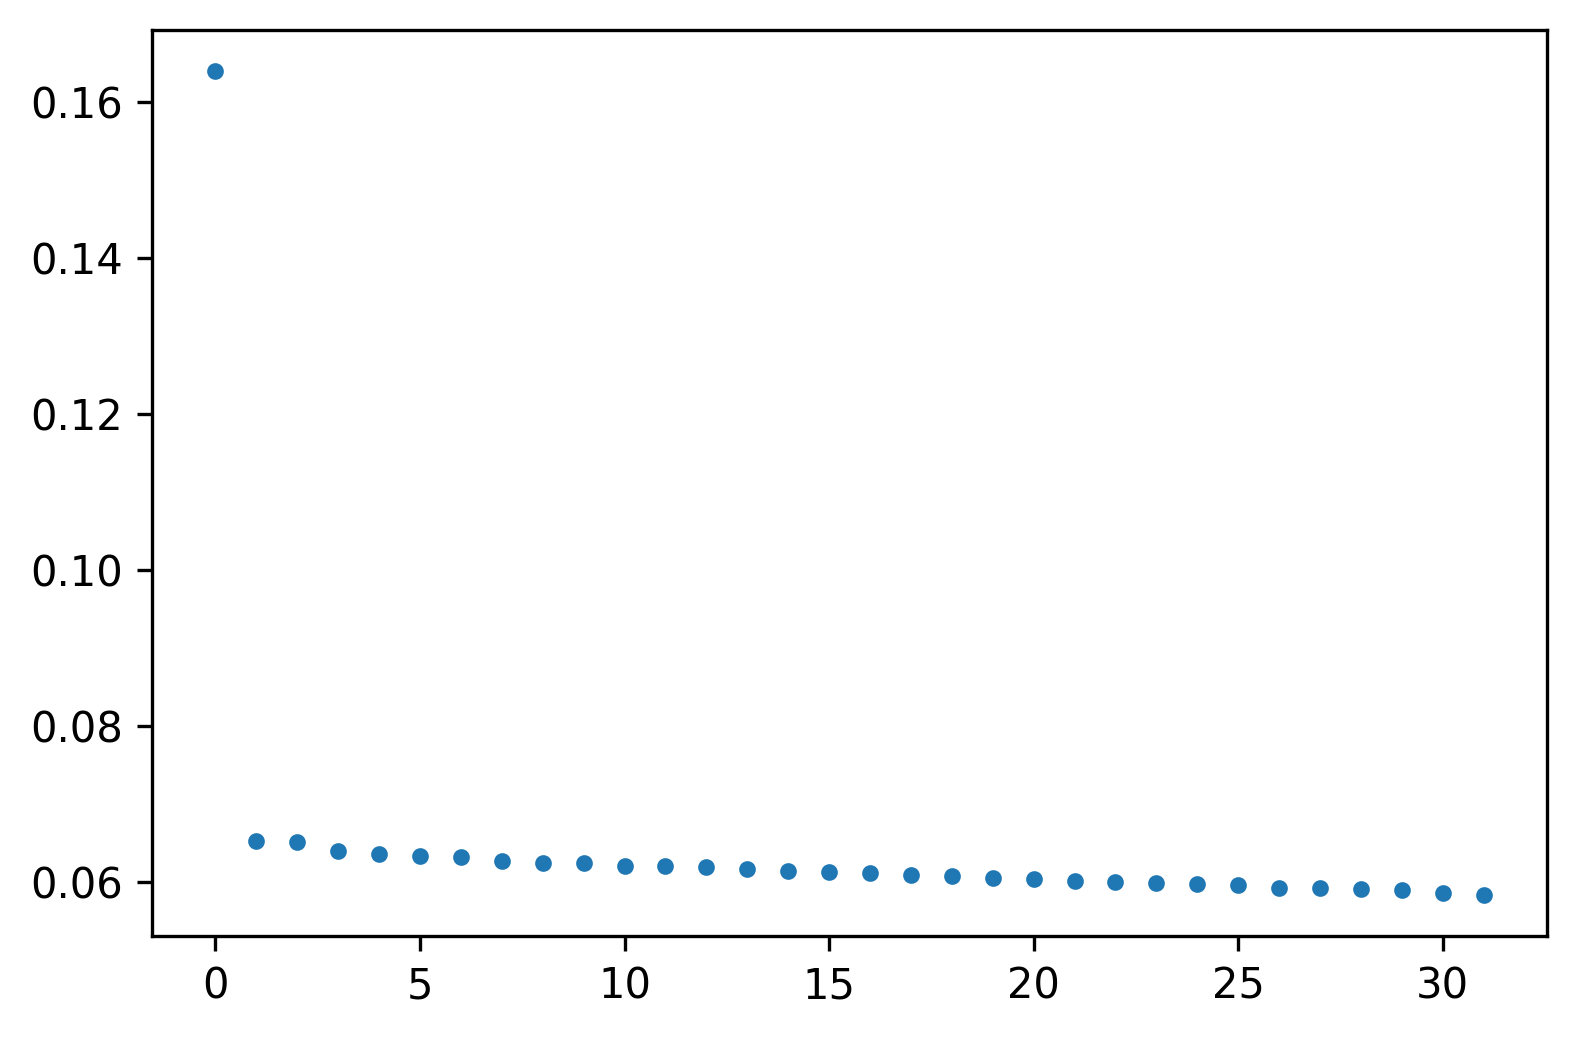

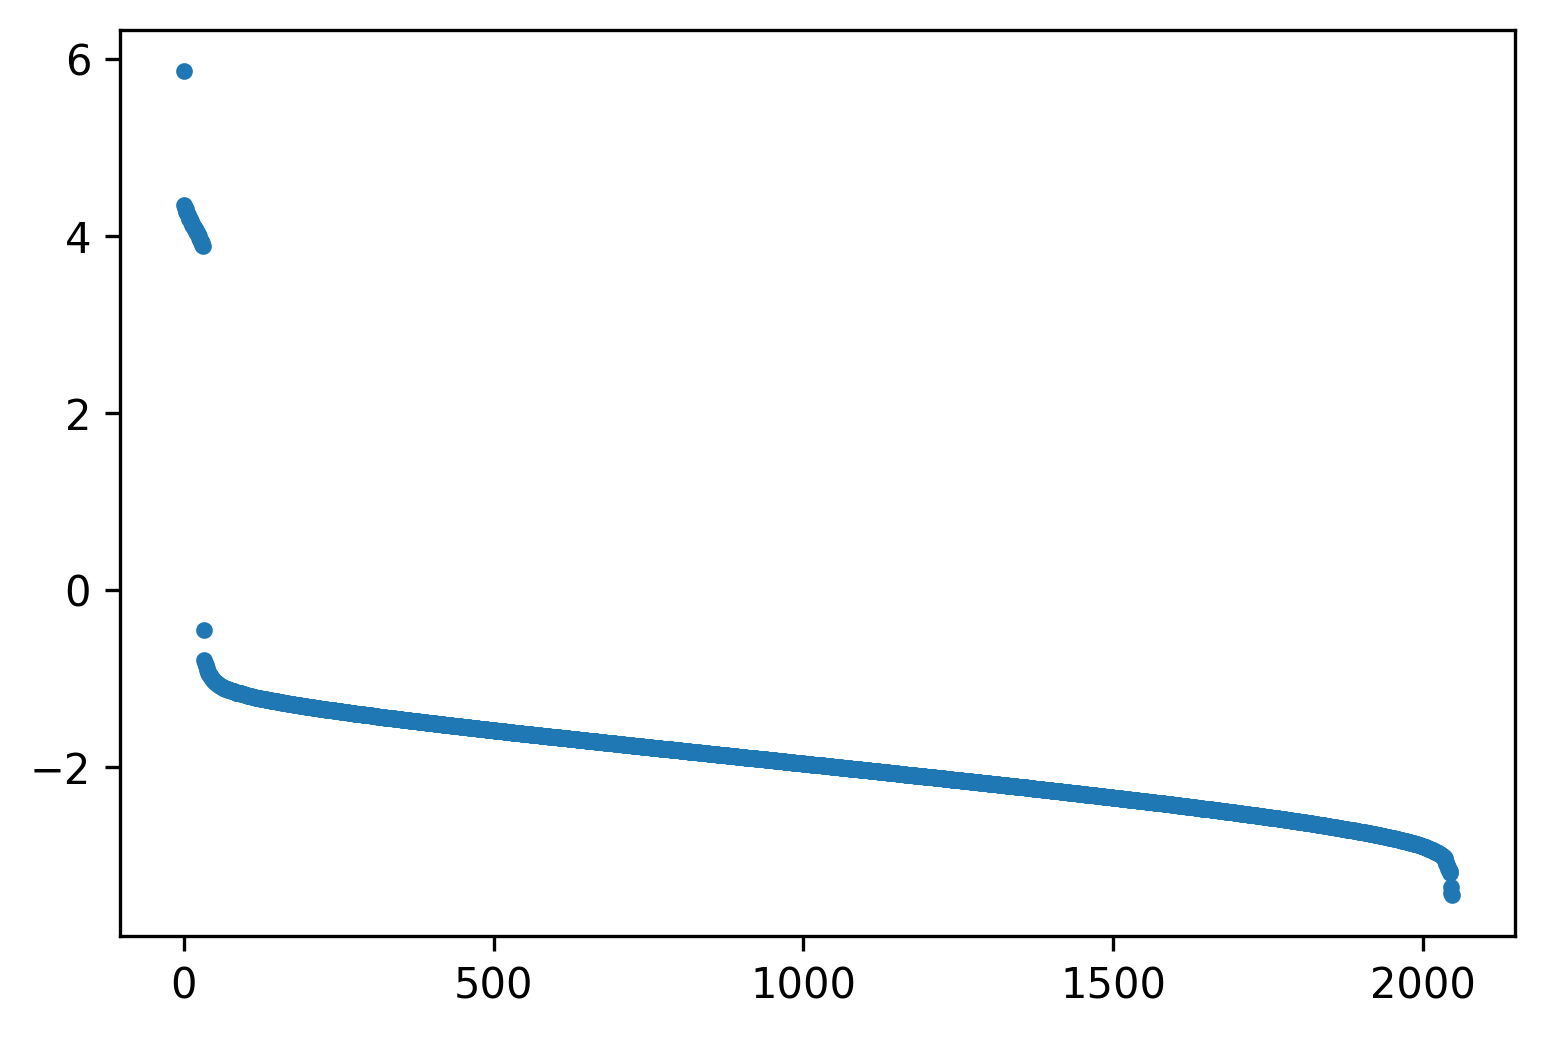

At  570 channels, alpha is 5.340506528981696
At  570 channels, RMSE/y_std is 0.07804430557744102
***************************  530  *************************
0:  |F(x)| = 0.0161764; step 1
1:  |F(x)| = 0.000690654; step 1
2:  |F(x)| = 9.90651e-05; step 1
3:  |F(x)| = 5.86315e-06; step 1


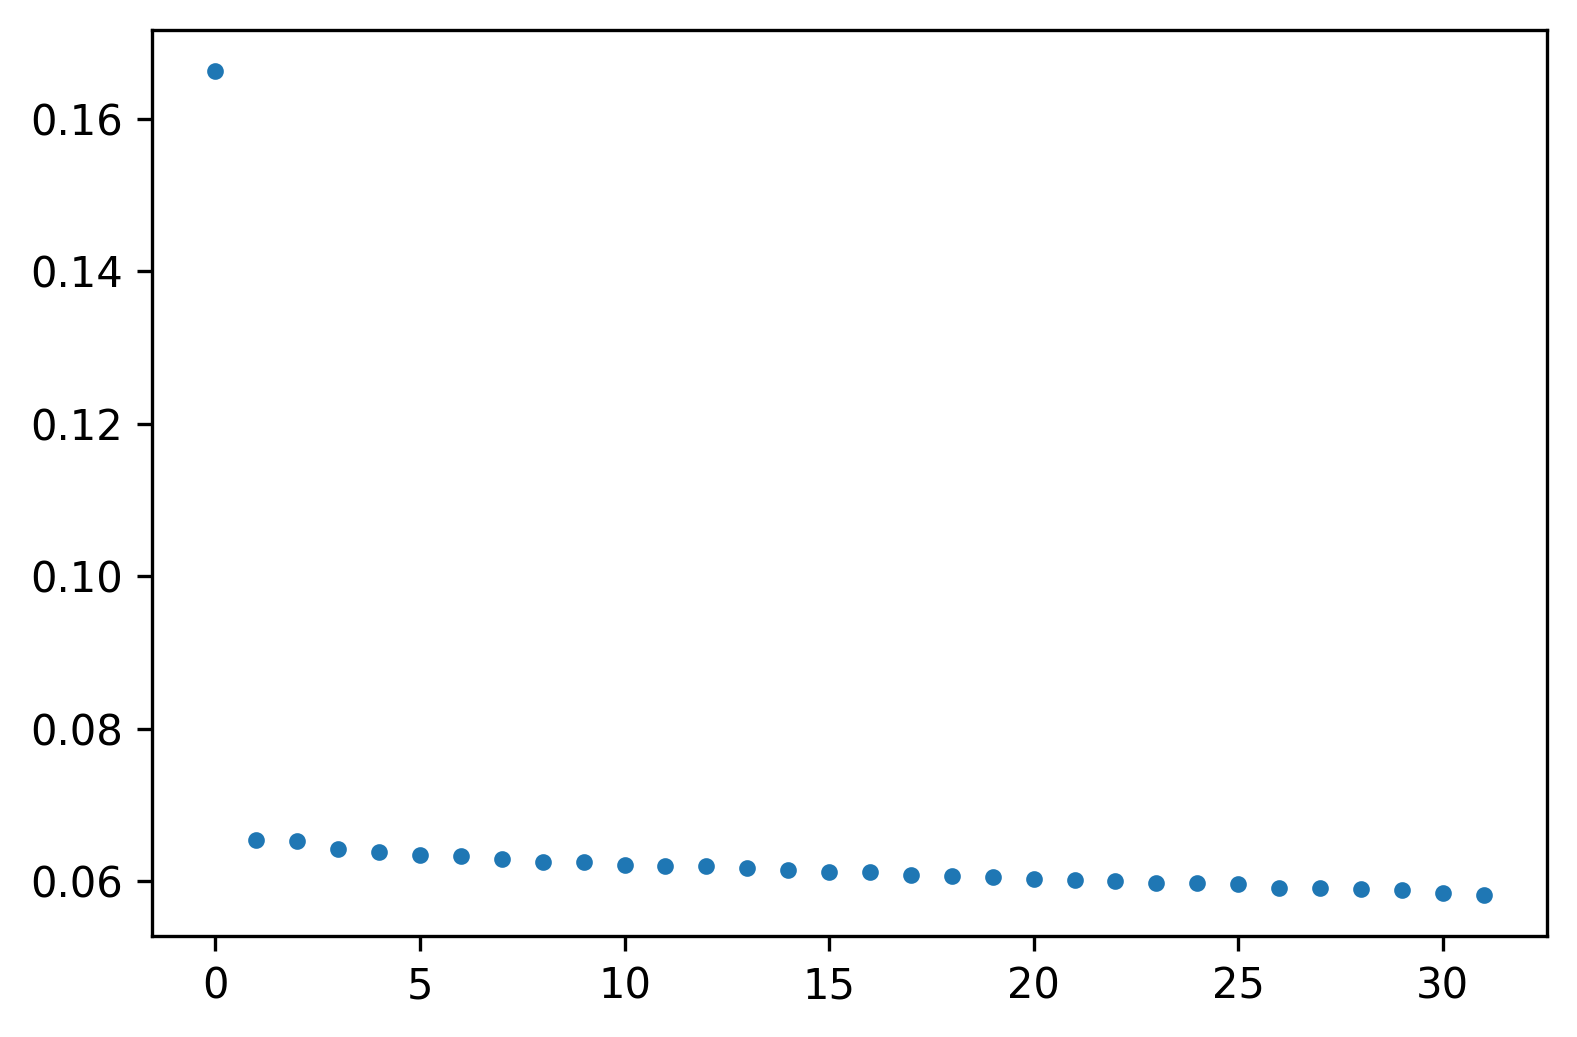

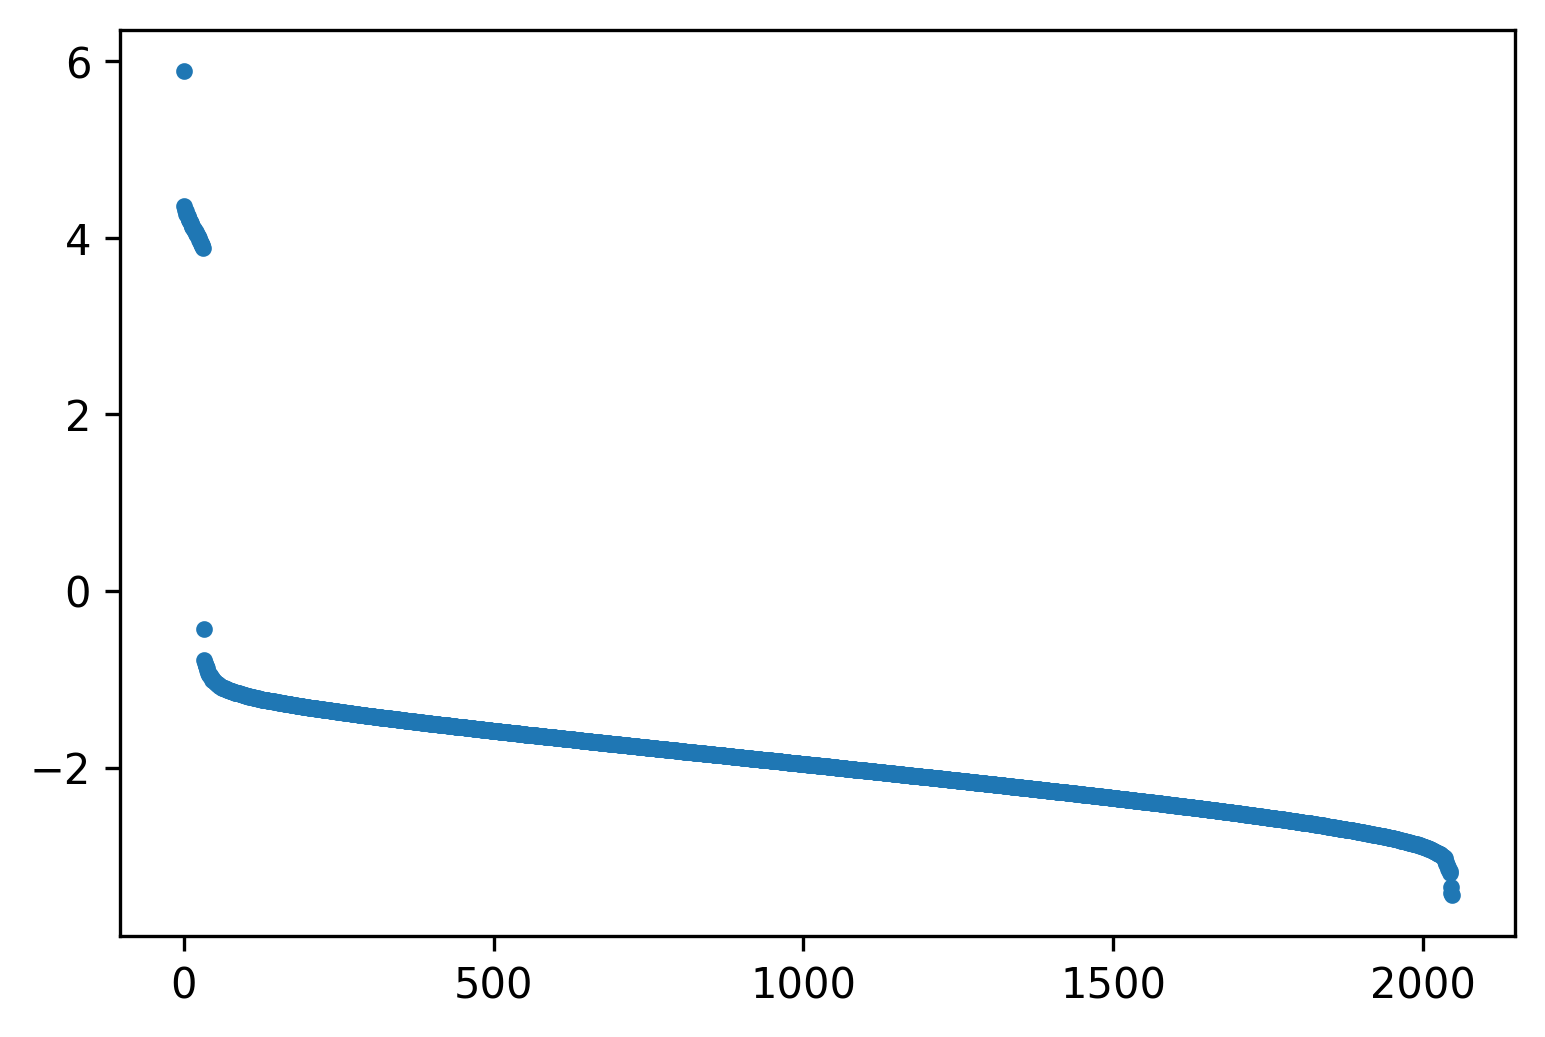

At  530 channels, alpha is 5.193431155483235
At  530 channels, RMSE/y_std is 0.07776031742659543
***************************  500  *************************
0:  |F(x)| = 0.0110388; step 1
1:  |F(x)| = 0.000428782; step 1
2:  |F(x)| = 4.50014e-05; step 1
3:  |F(x)| = 1.72032e-06; step 1


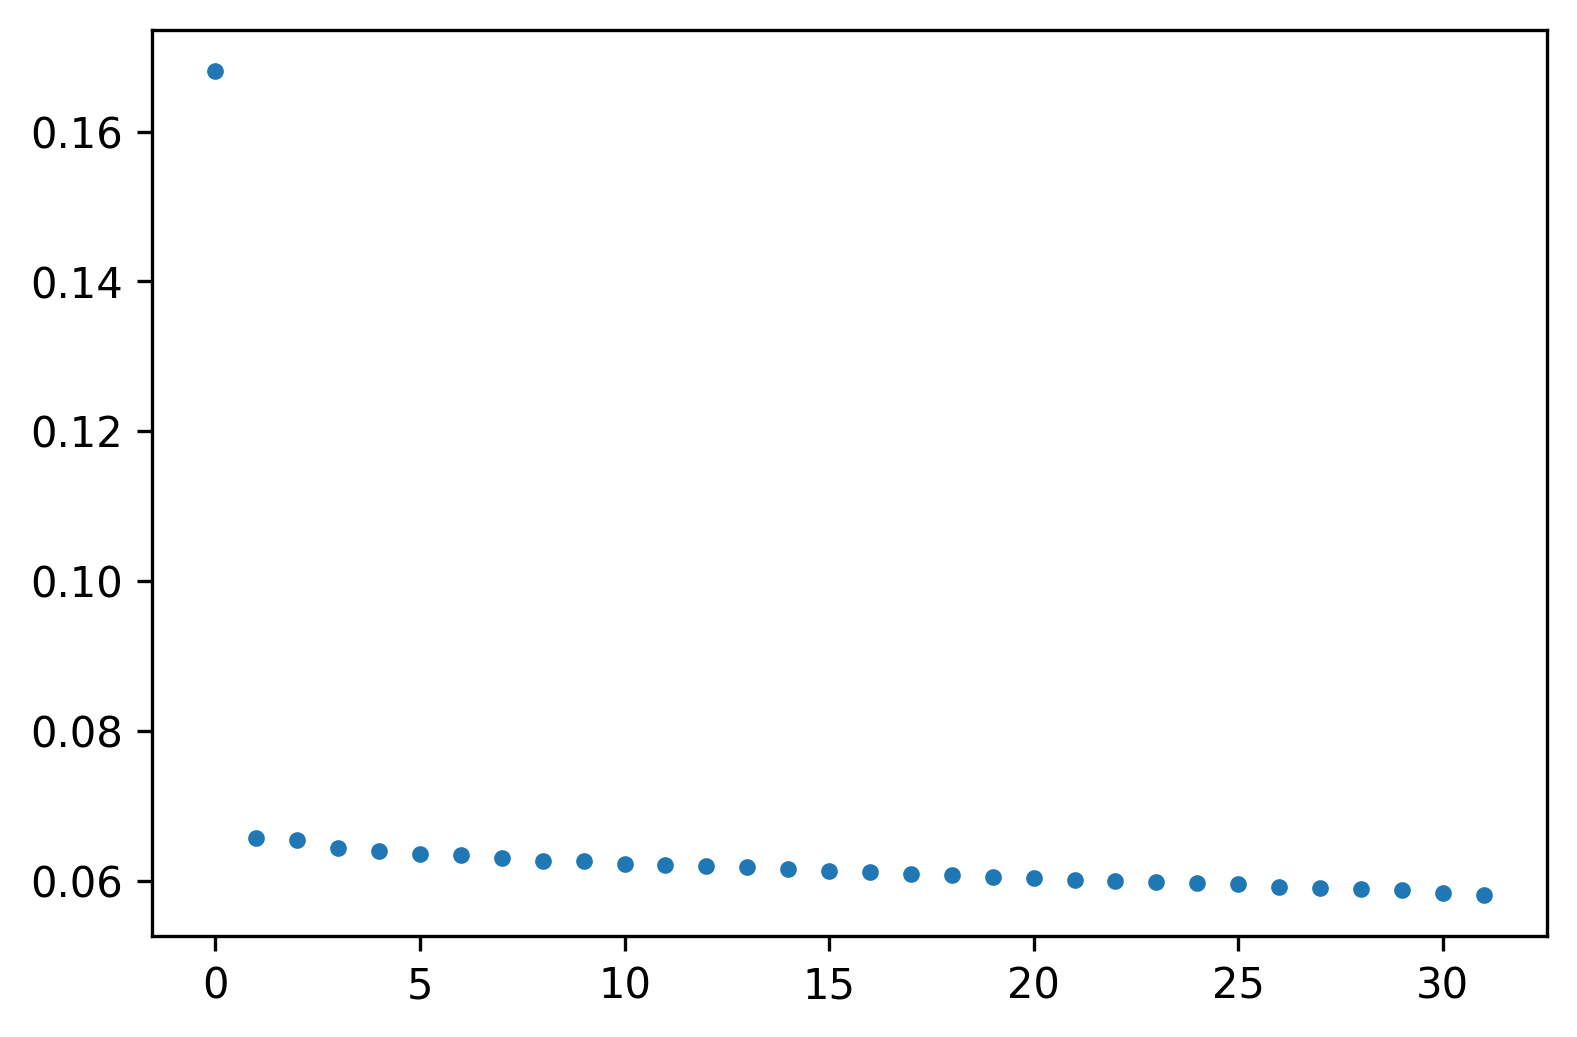

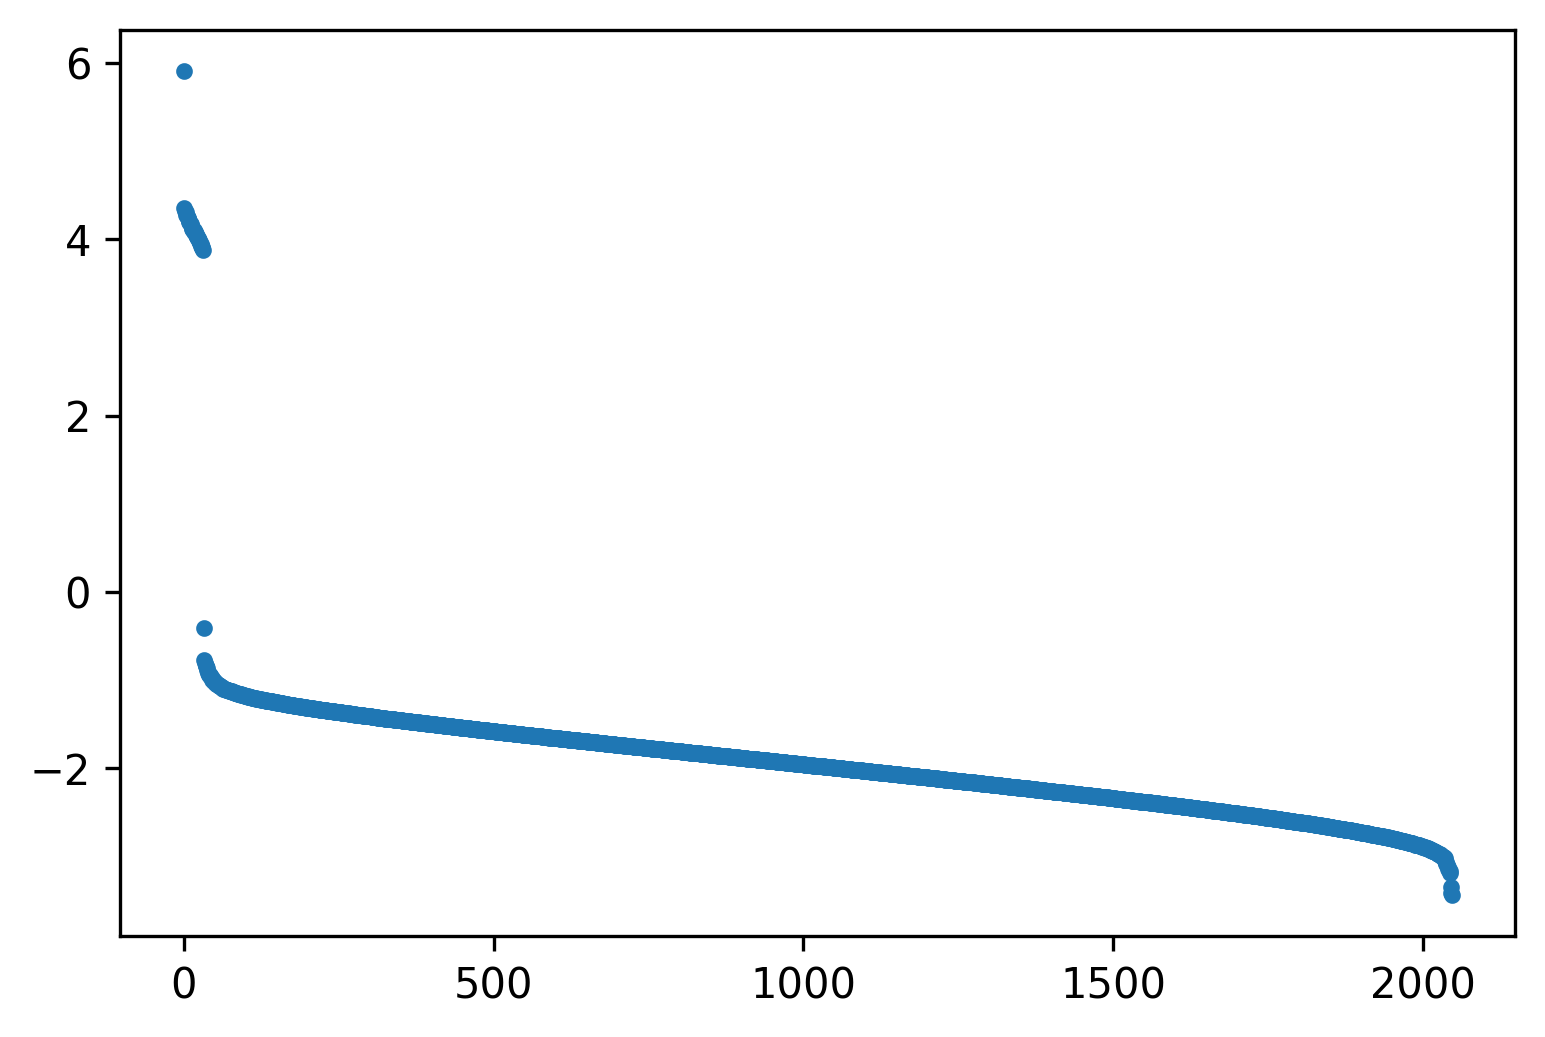

At  500 channels, alpha is 5.0803116086352205
At  500 channels, RMSE/y_std is 0.0775395416500688
***************************  470  *************************
0:  |F(x)| = 0.0135466; step 1
1:  |F(x)| = 0.000524029; step 1
2:  |F(x)| = 6.32594e-05; step 1
3:  |F(x)| = 2.03435e-06; step 1


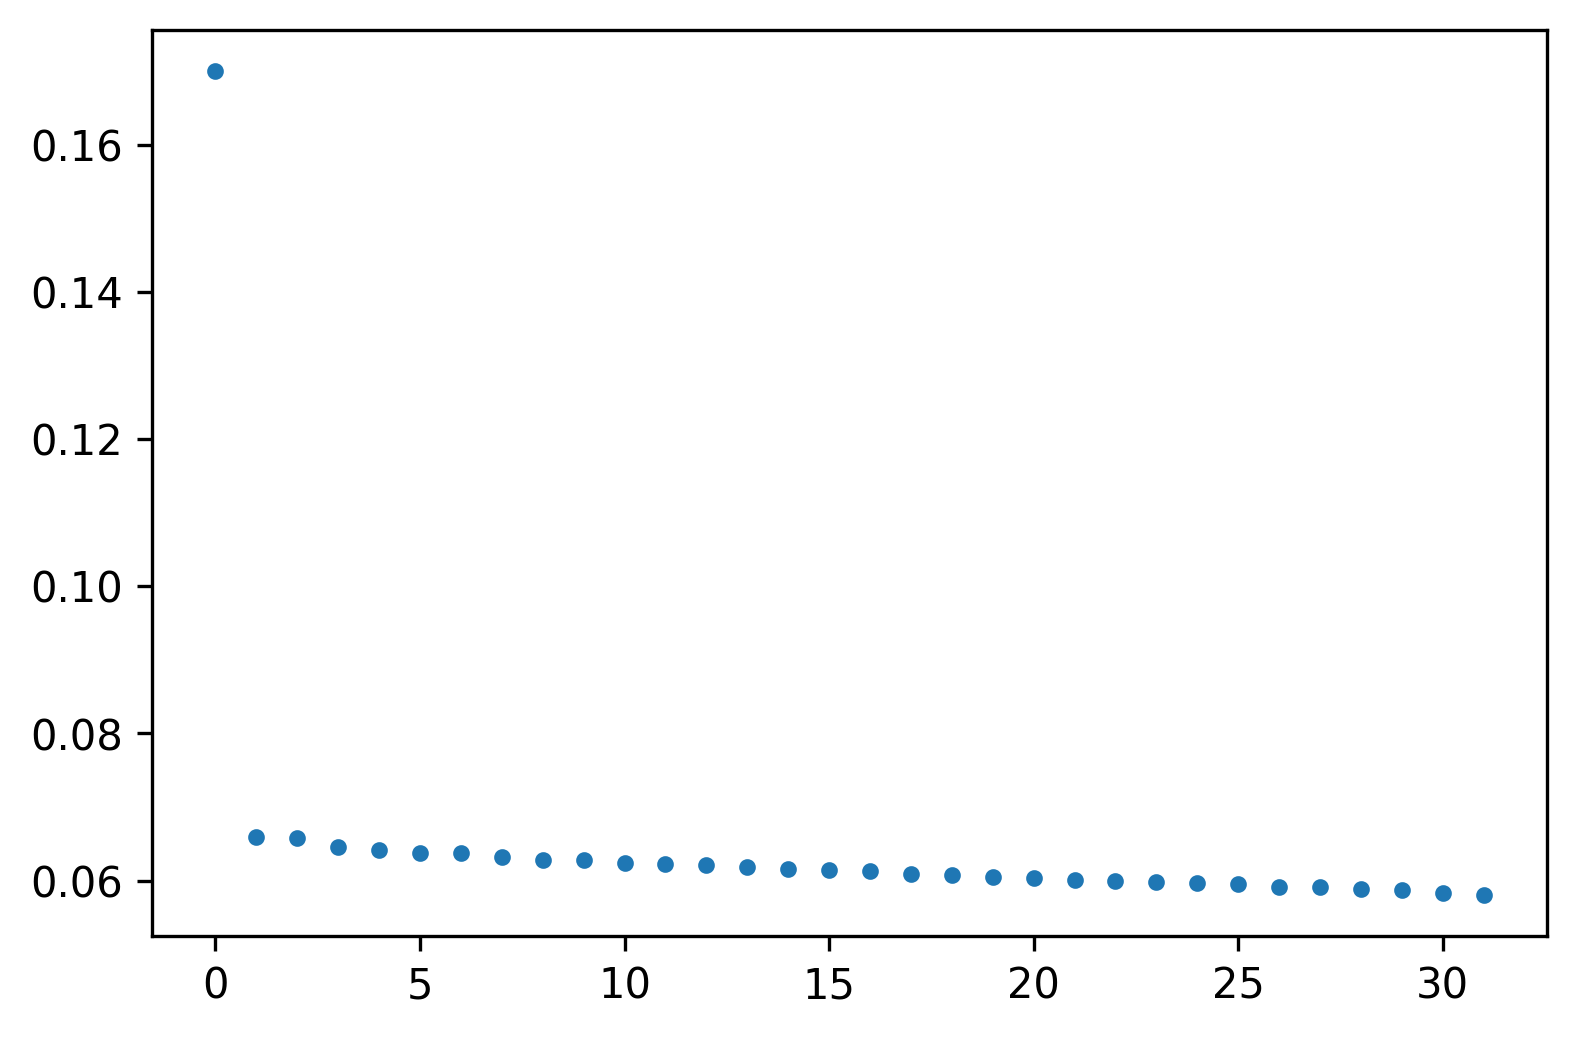

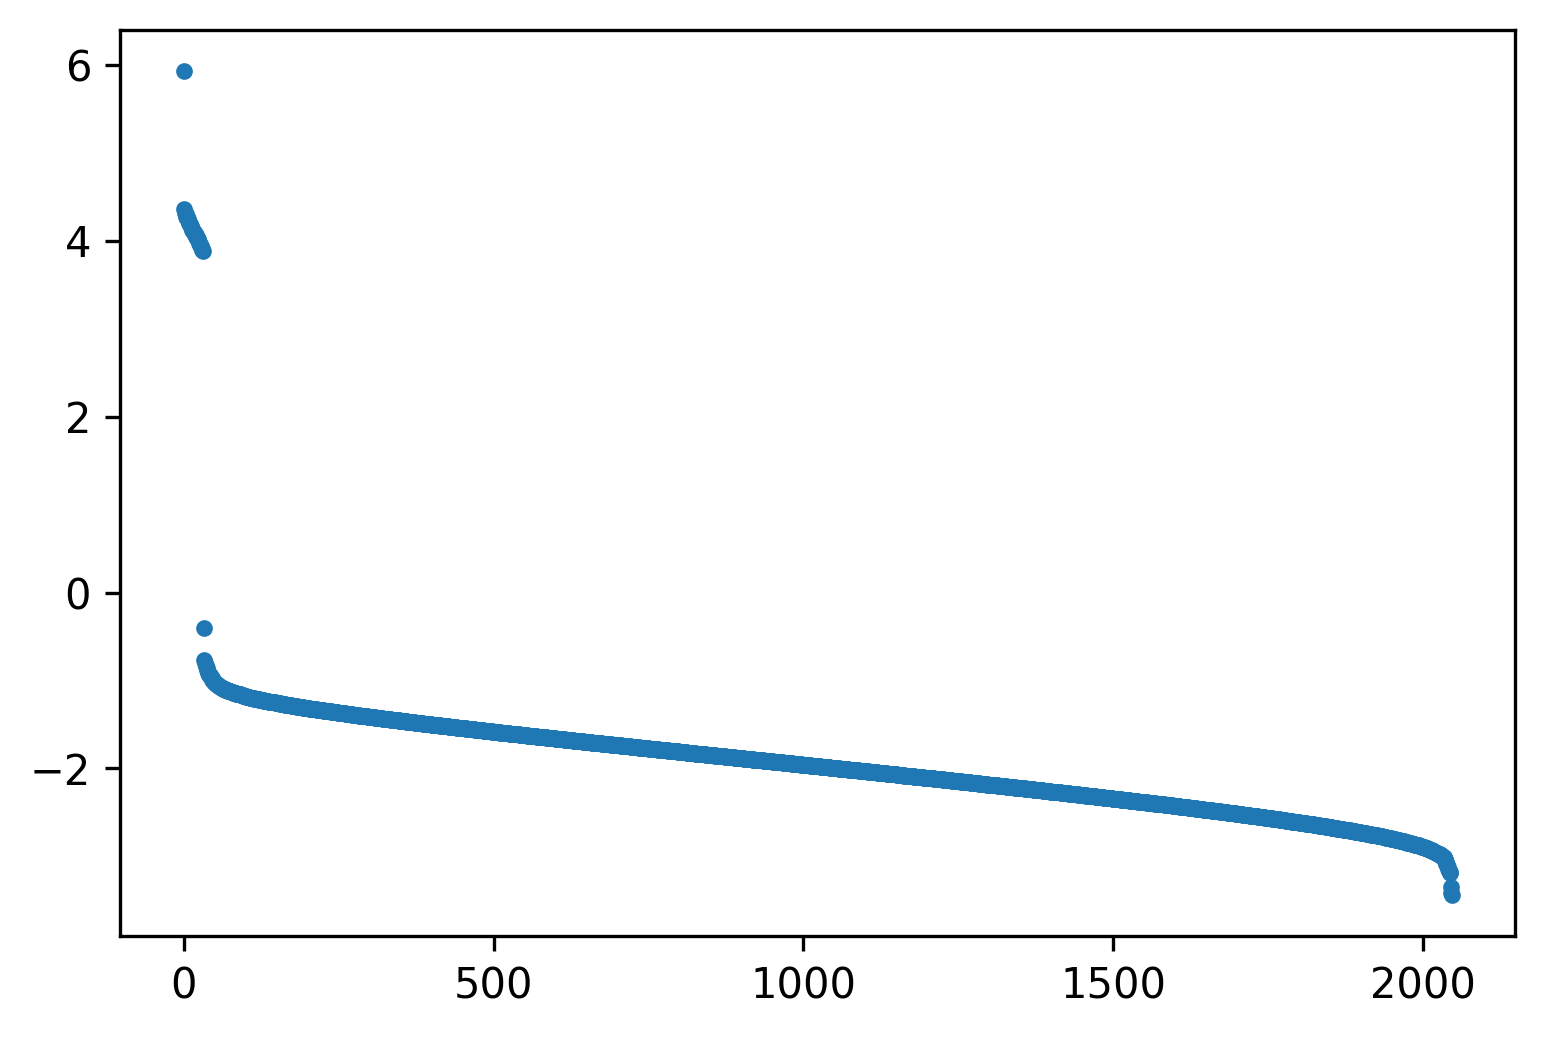

At  470 channels, alpha is 4.964200717160299
At  470 channels, RMSE/y_std is 0.07730952972736105
***************************  430  *************************
0:  |F(x)| = 0.0319748; step 1
1:  |F(x)| = 0.000770343; step 1
2:  |F(x)| = 0.000137625; step 1
3:  |F(x)| = 1.32745e-05; step 1
4:  |F(x)| = 1.77271e-06; step 1


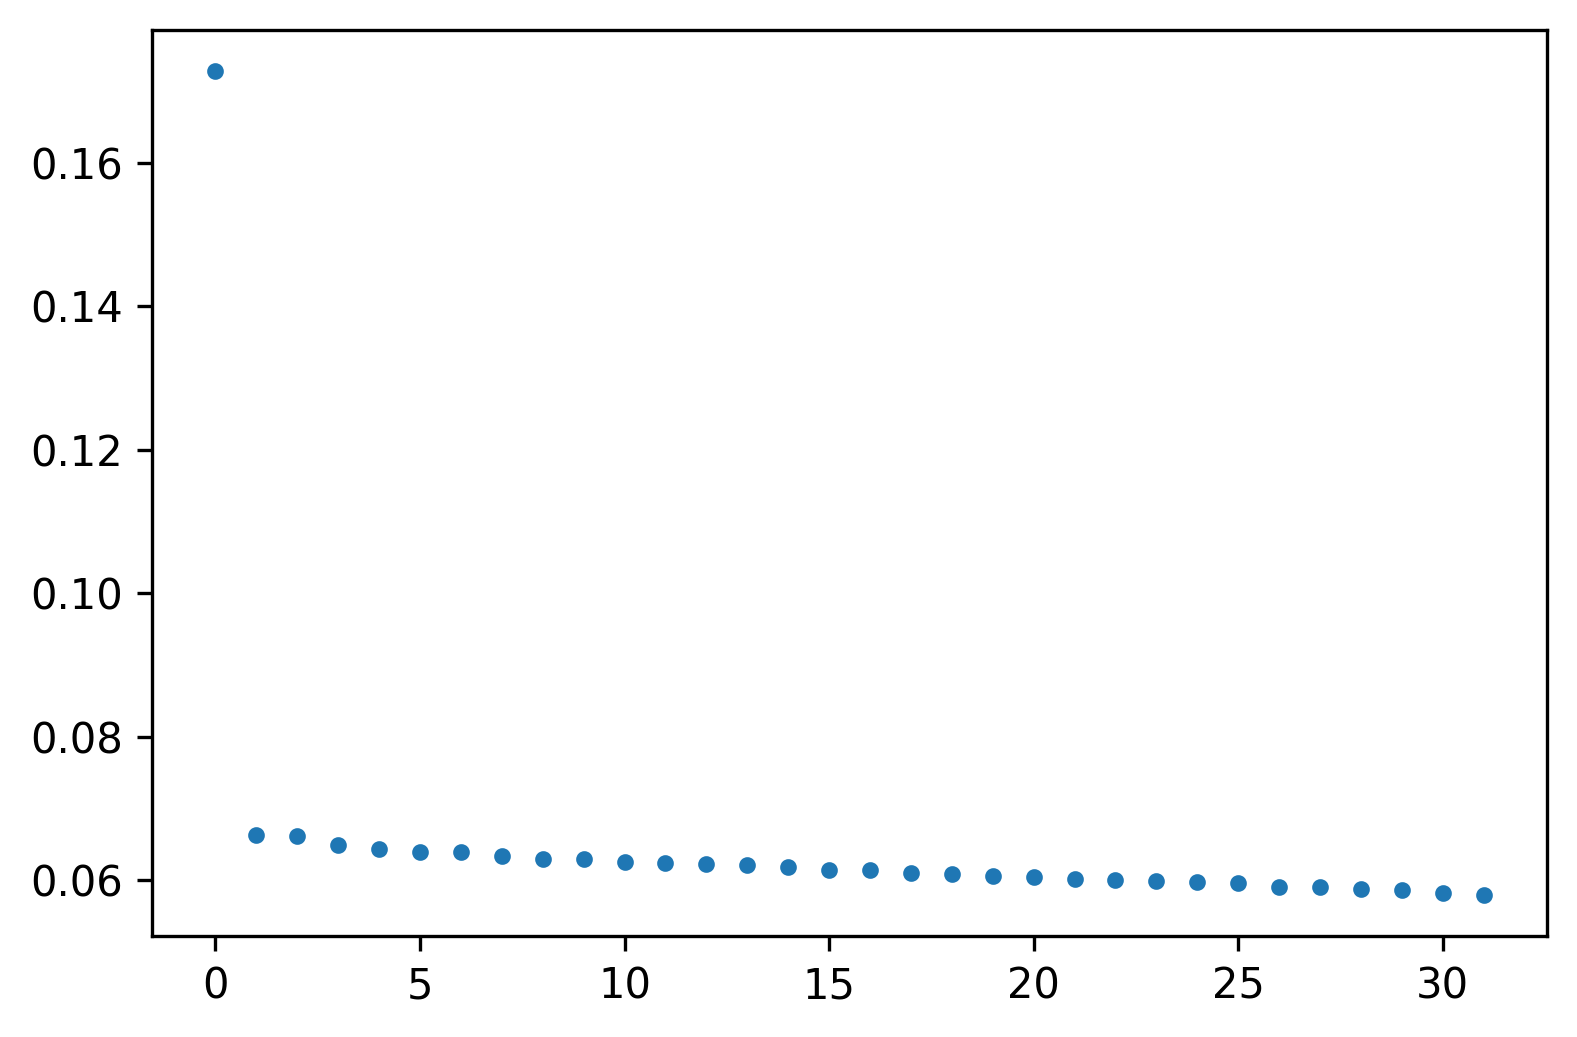

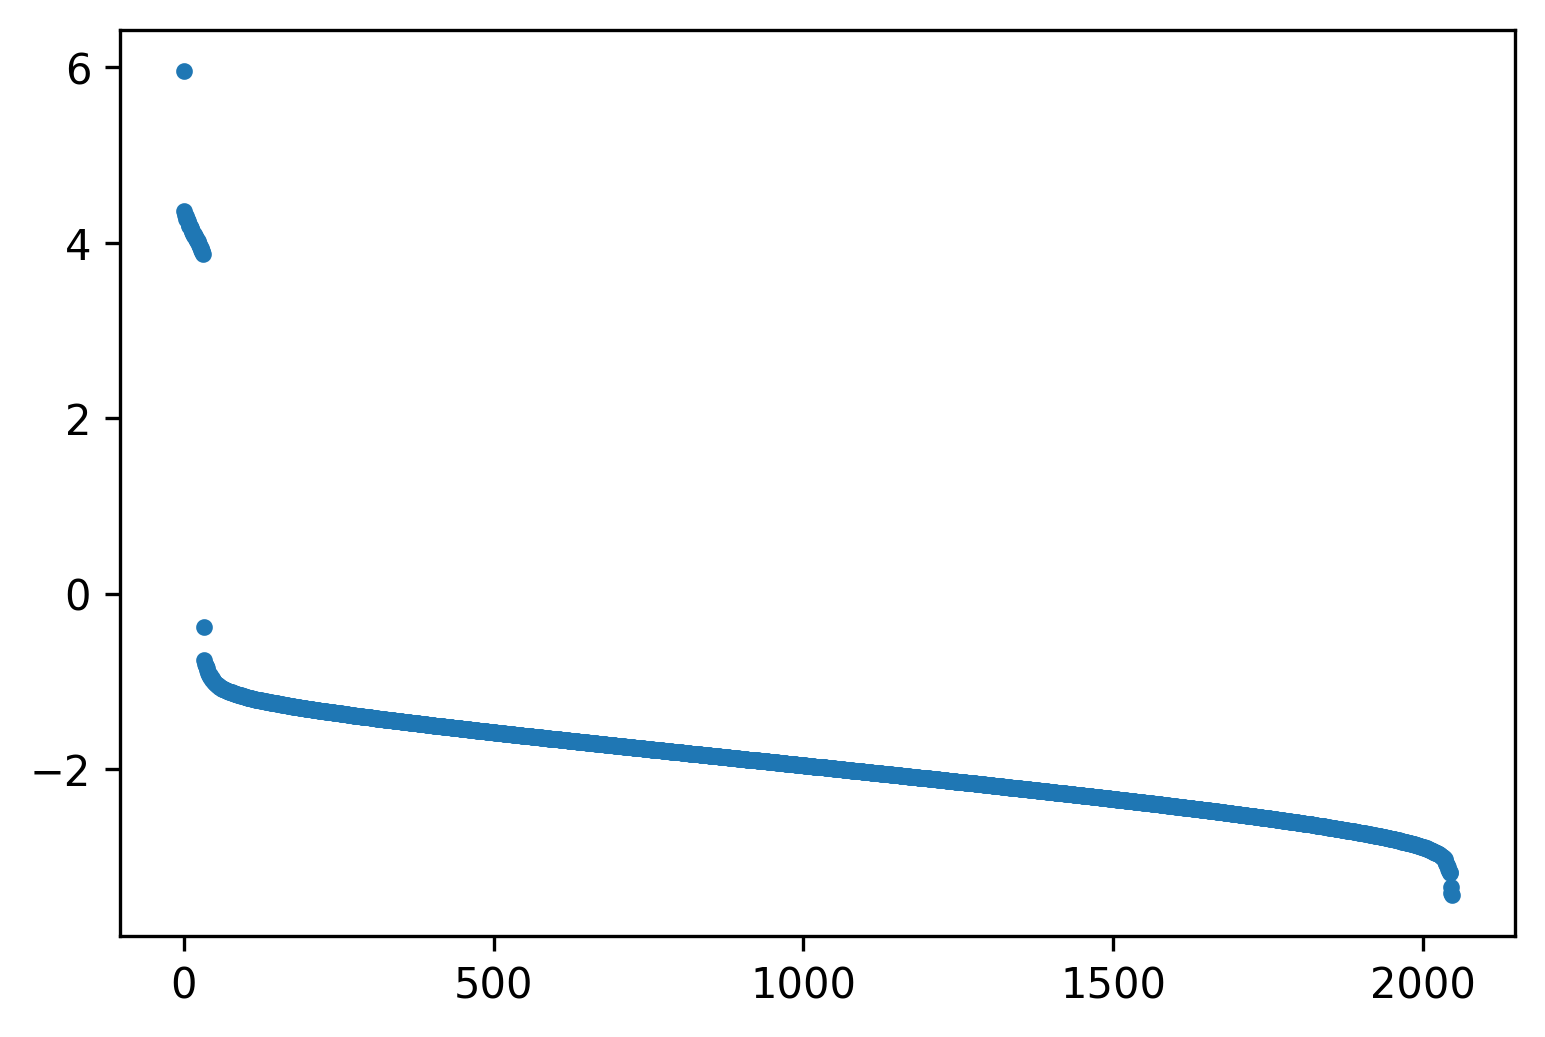

At  430 channels, alpha is 4.803946977378894
At  430 channels, RMSE/y_std is 0.07698618807847815
***************************  400  *************************
0:  |F(x)| = 0.0226552; step 1
1:  |F(x)| = 0.00067528; step 1
2:  |F(x)| = 7.87163e-05; step 1
3:  |F(x)| = 1.47806e-05; step 1
4:  |F(x)| = 1.53093e-06; step 1


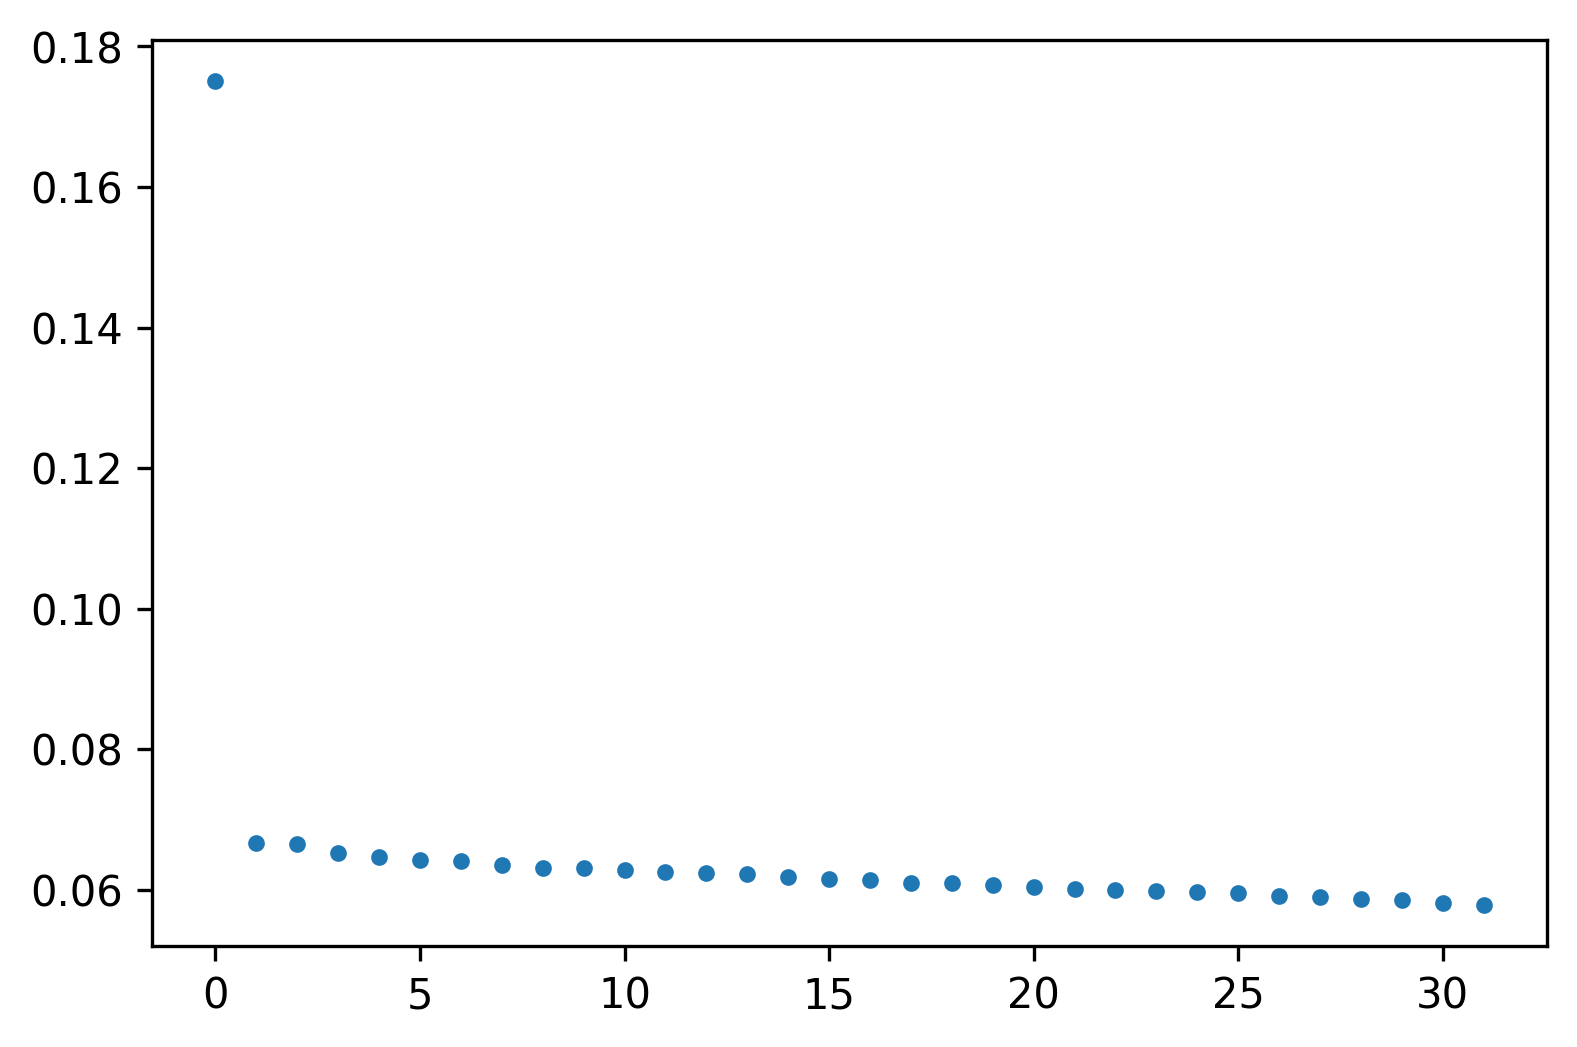

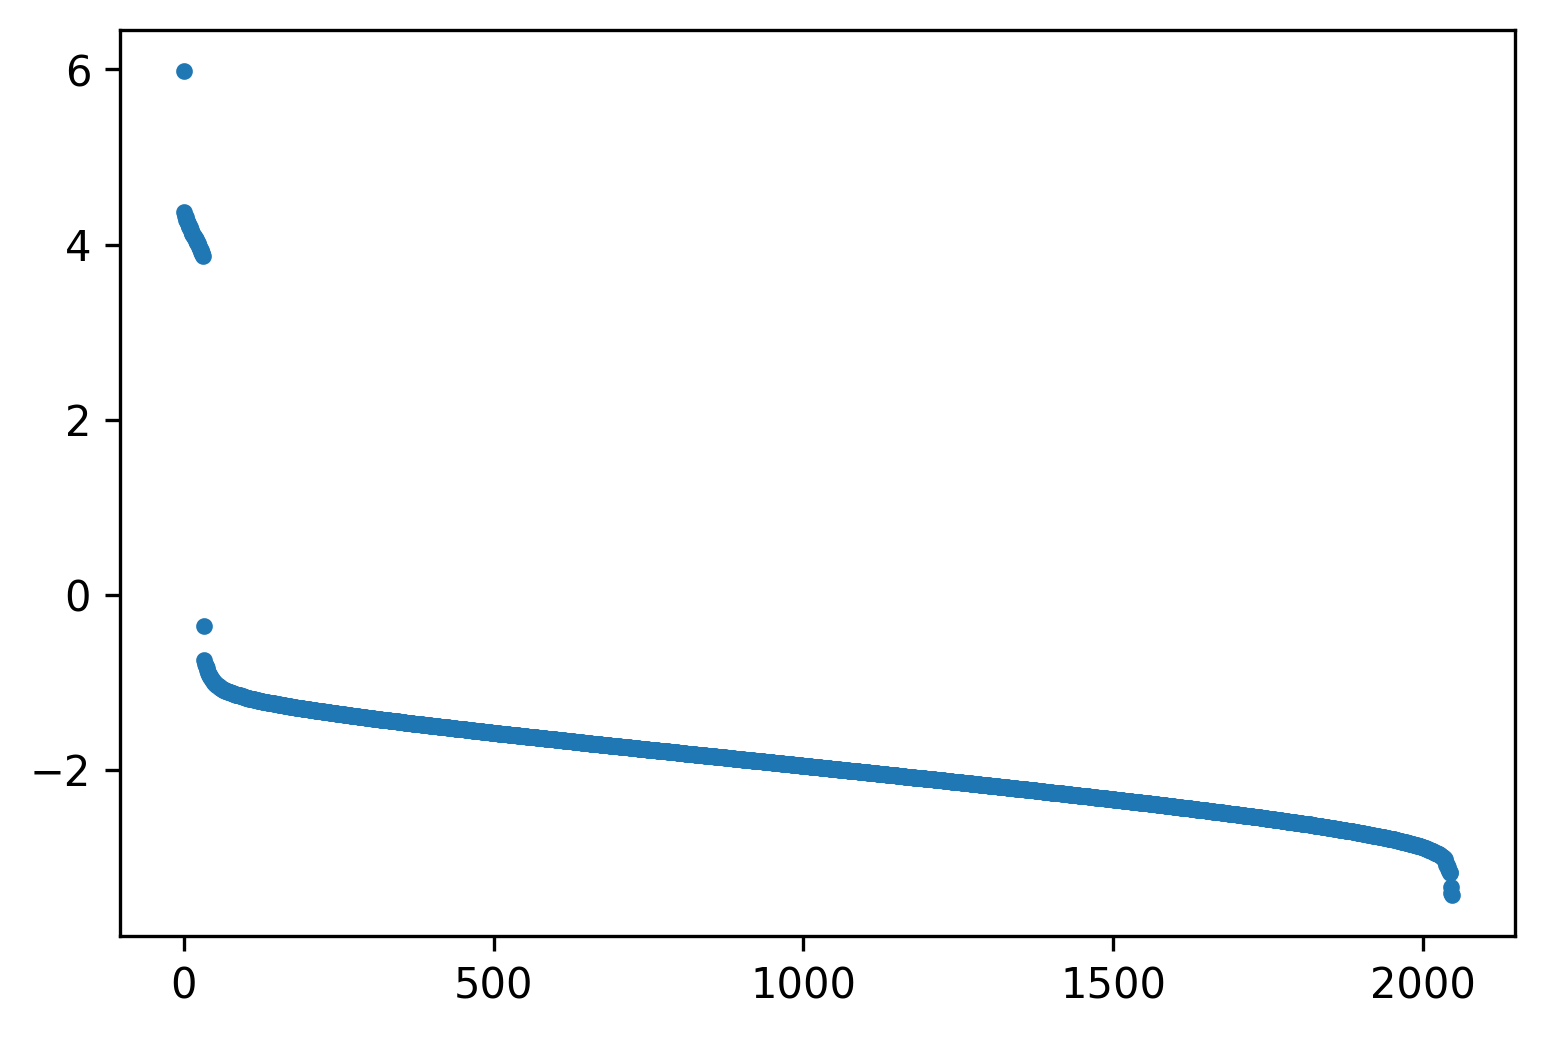

At  400 channels, alpha is 4.678974635303703
At  400 channels, RMSE/y_std is 0.07672831914363368
***************************  370  *************************
0:  |F(x)| = 0.0290018; step 1
1:  |F(x)| = 0.000676904; step 1
2:  |F(x)| = 0.000103103; step 1
3:  |F(x)| = 1.62921e-05; step 1
4:  |F(x)| = 2.24434e-06; step 1


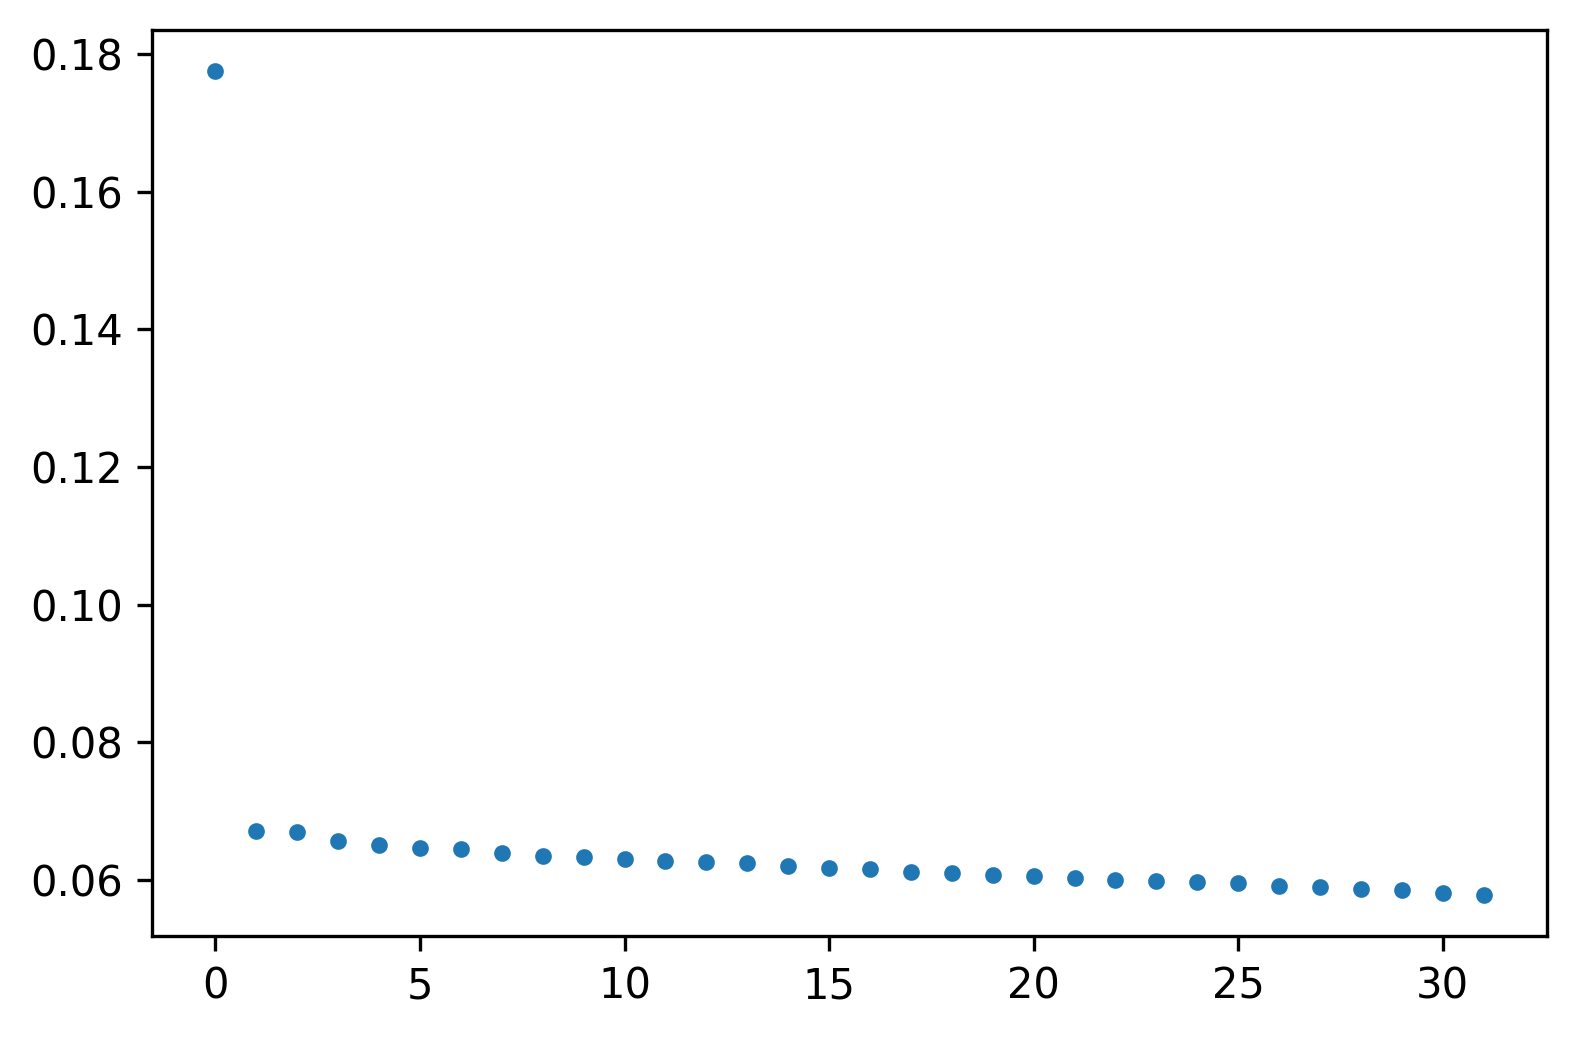

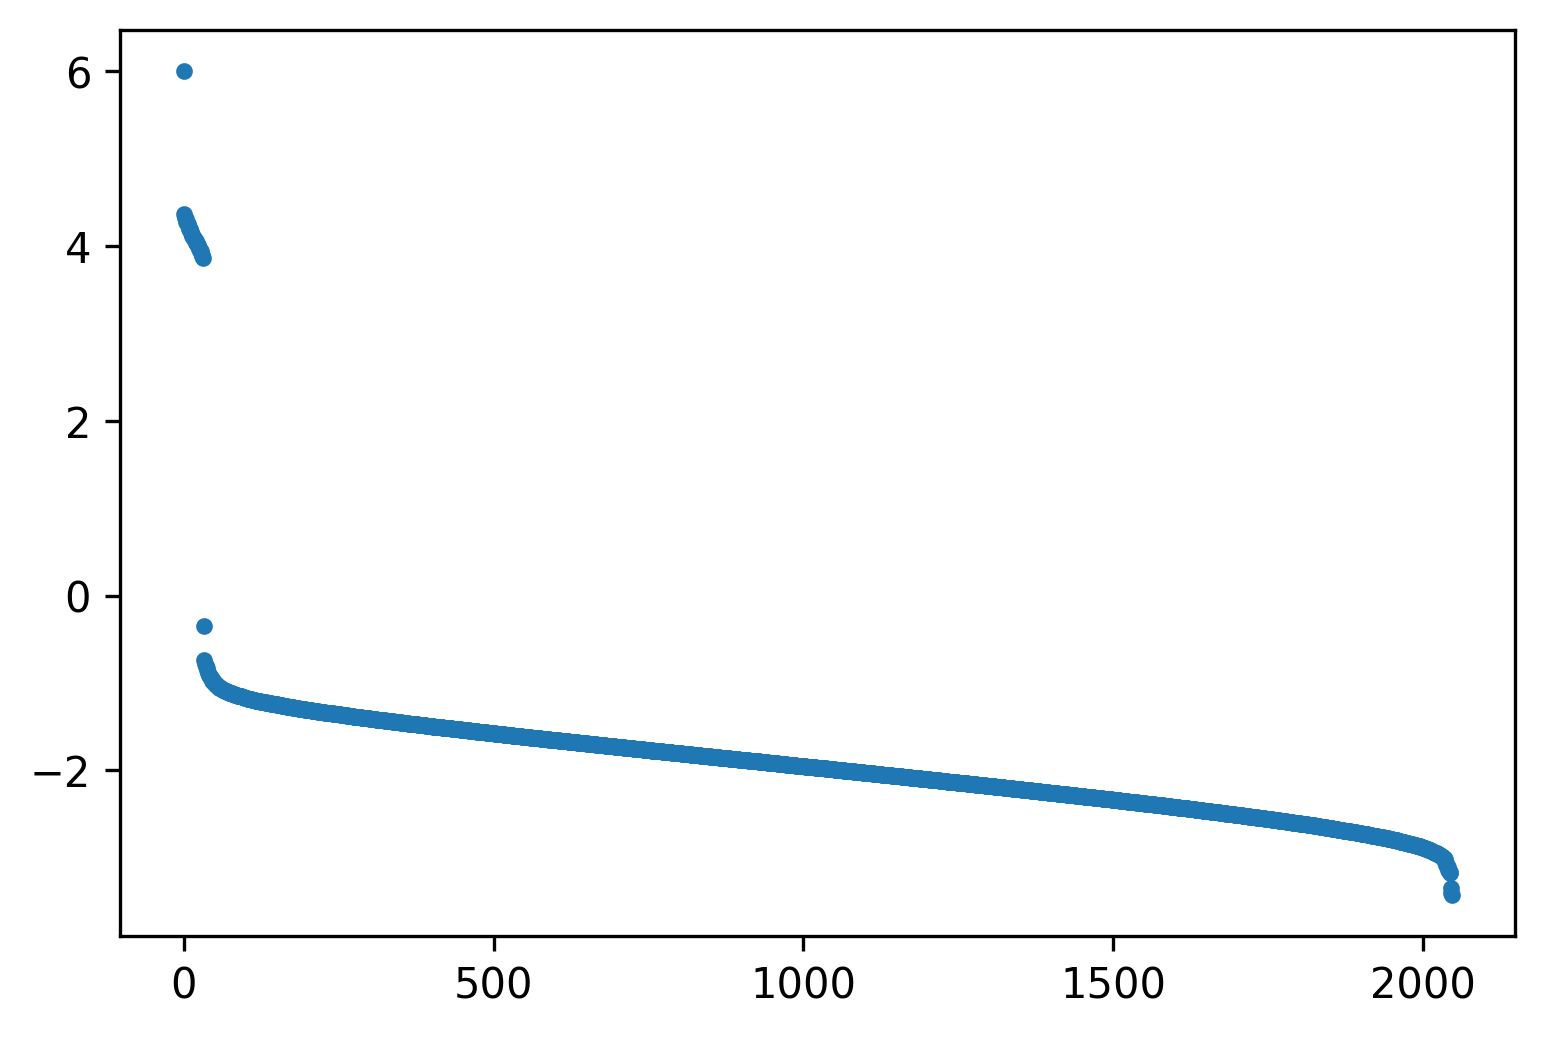

At  370 channels, alpha is 4.5491194230077365
At  370 channels, RMSE/y_std is 0.07645402563959423
***************************  350  *************************
0:  |F(x)| = 0.0152221; step 1
1:  |F(x)| = 0.000319628; step 1
2:  |F(x)| = 2.96675e-05; step 1
3:  |F(x)| = 8.05937e-06; step 1
4:  |F(x)| = 6.97671e-07; step 1


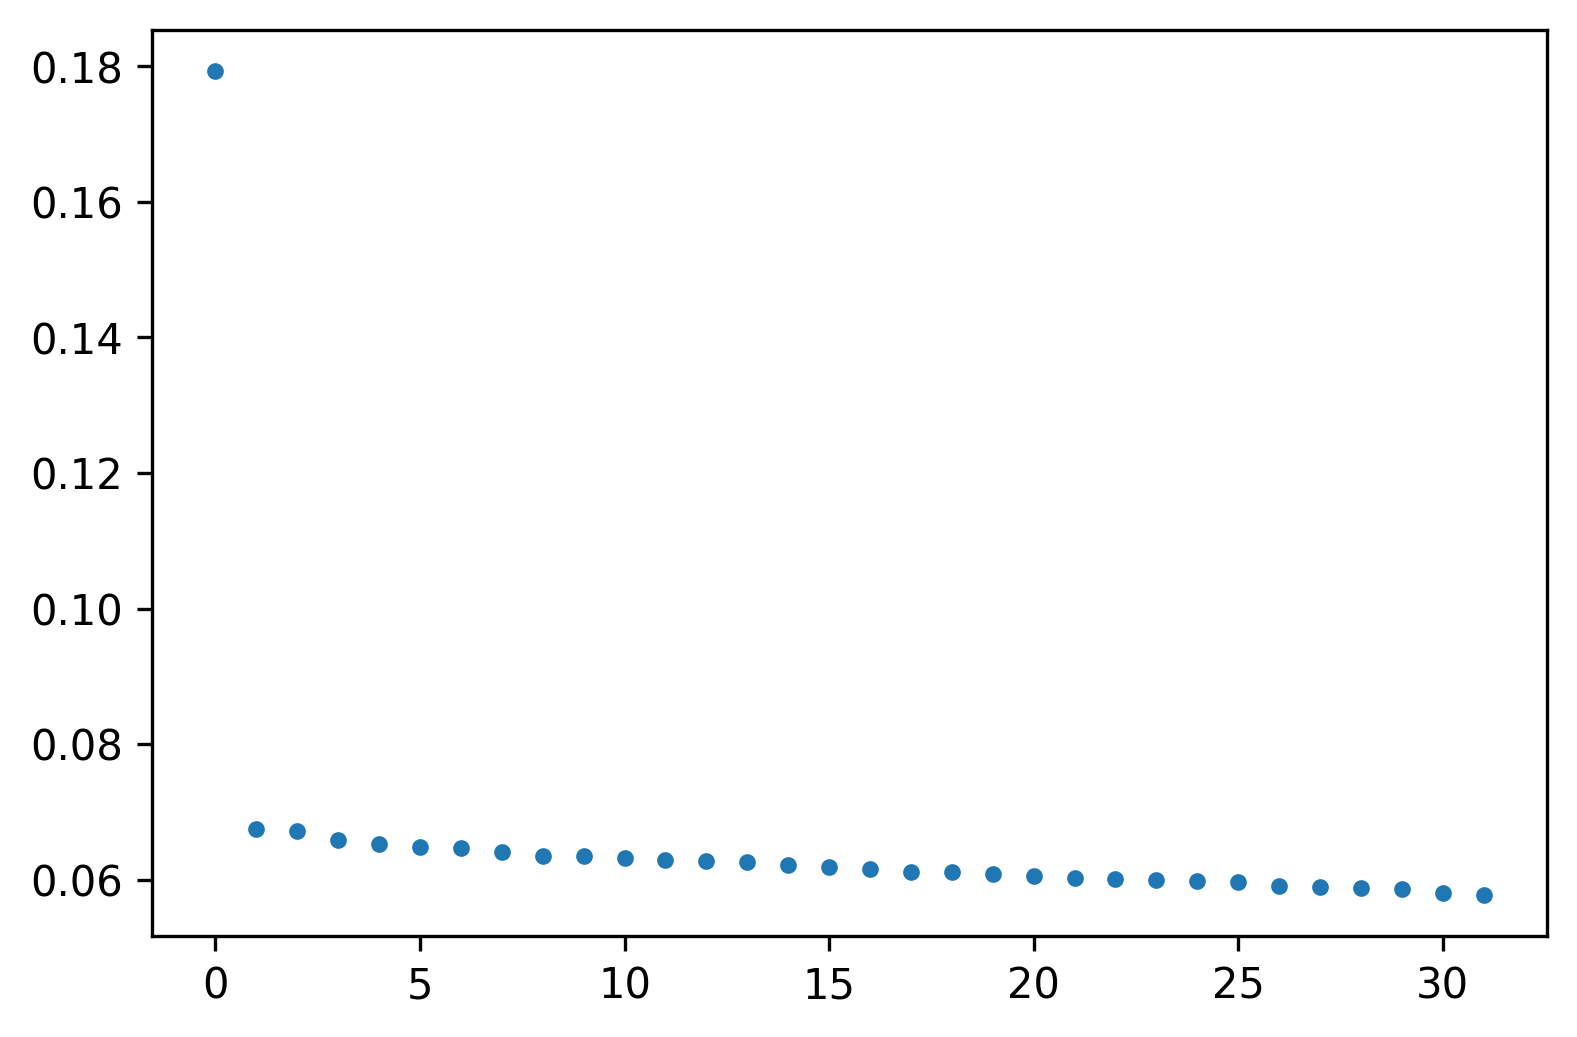

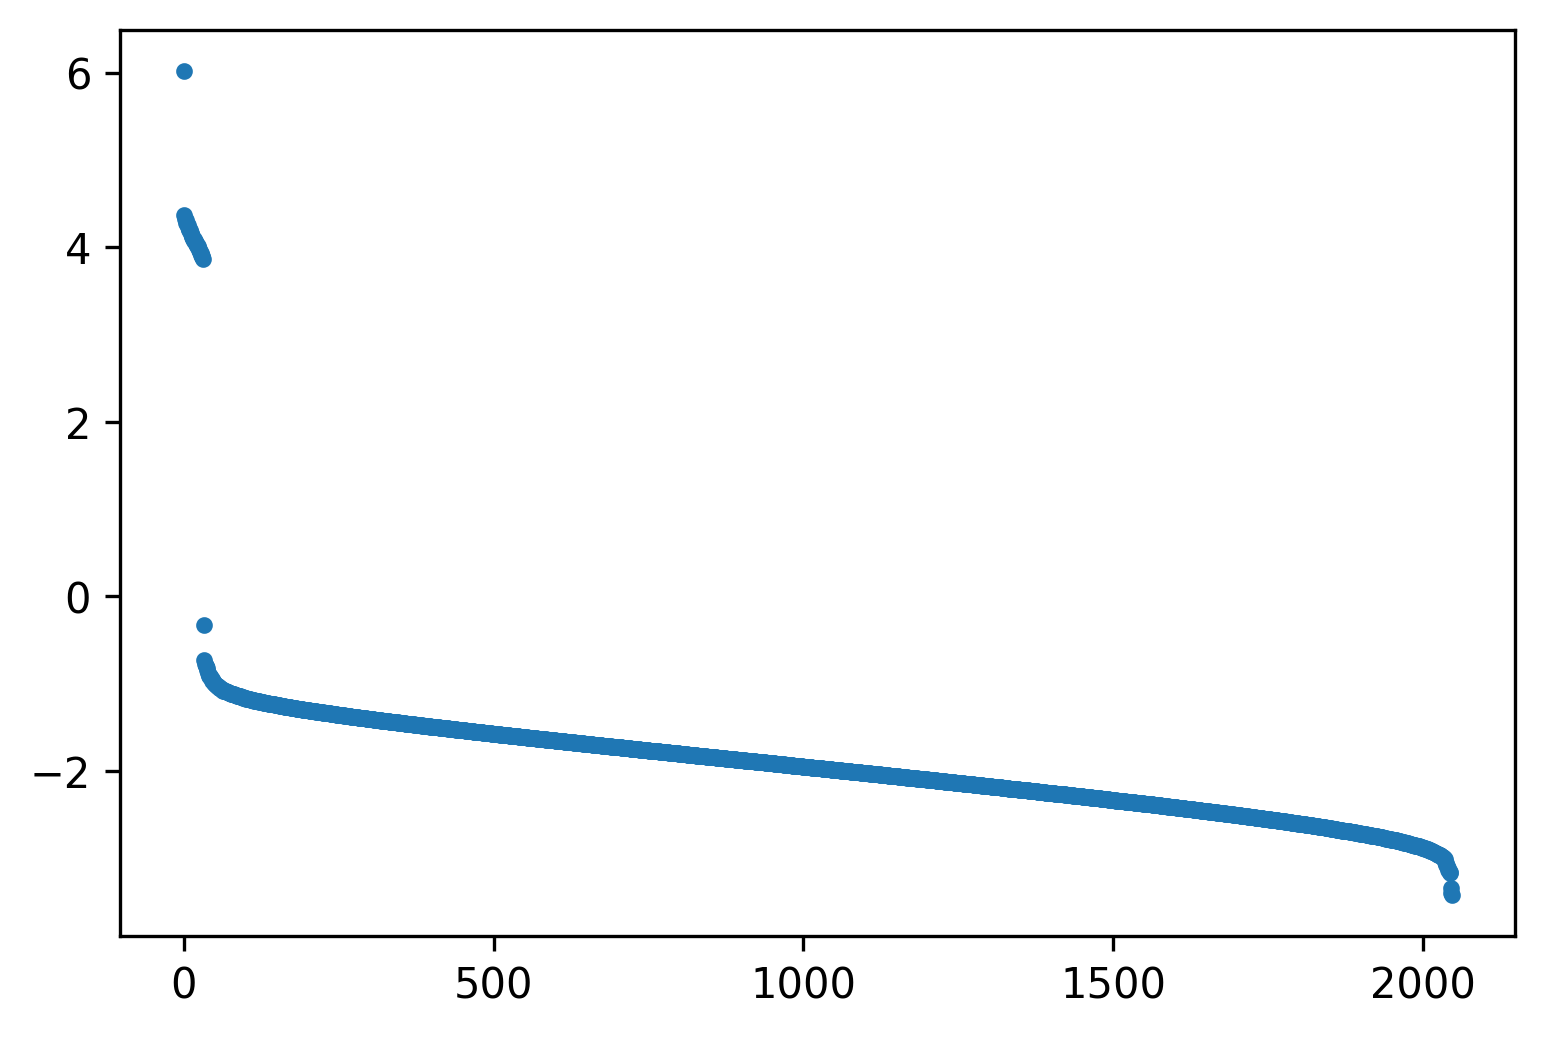

At  350 channels, alpha is 4.459408949186616
At  350 channels, RMSE/y_std is 0.07626065755370563
***************************  330  *************************
0:  |F(x)| = 0.0182822; step 1
1:  |F(x)| = 0.000438877; step 1
2:  |F(x)| = 5.39577e-05; step 1
3:  |F(x)| = 6.93694e-06; step 1
4:  |F(x)| = 2.67273e-06; step 1


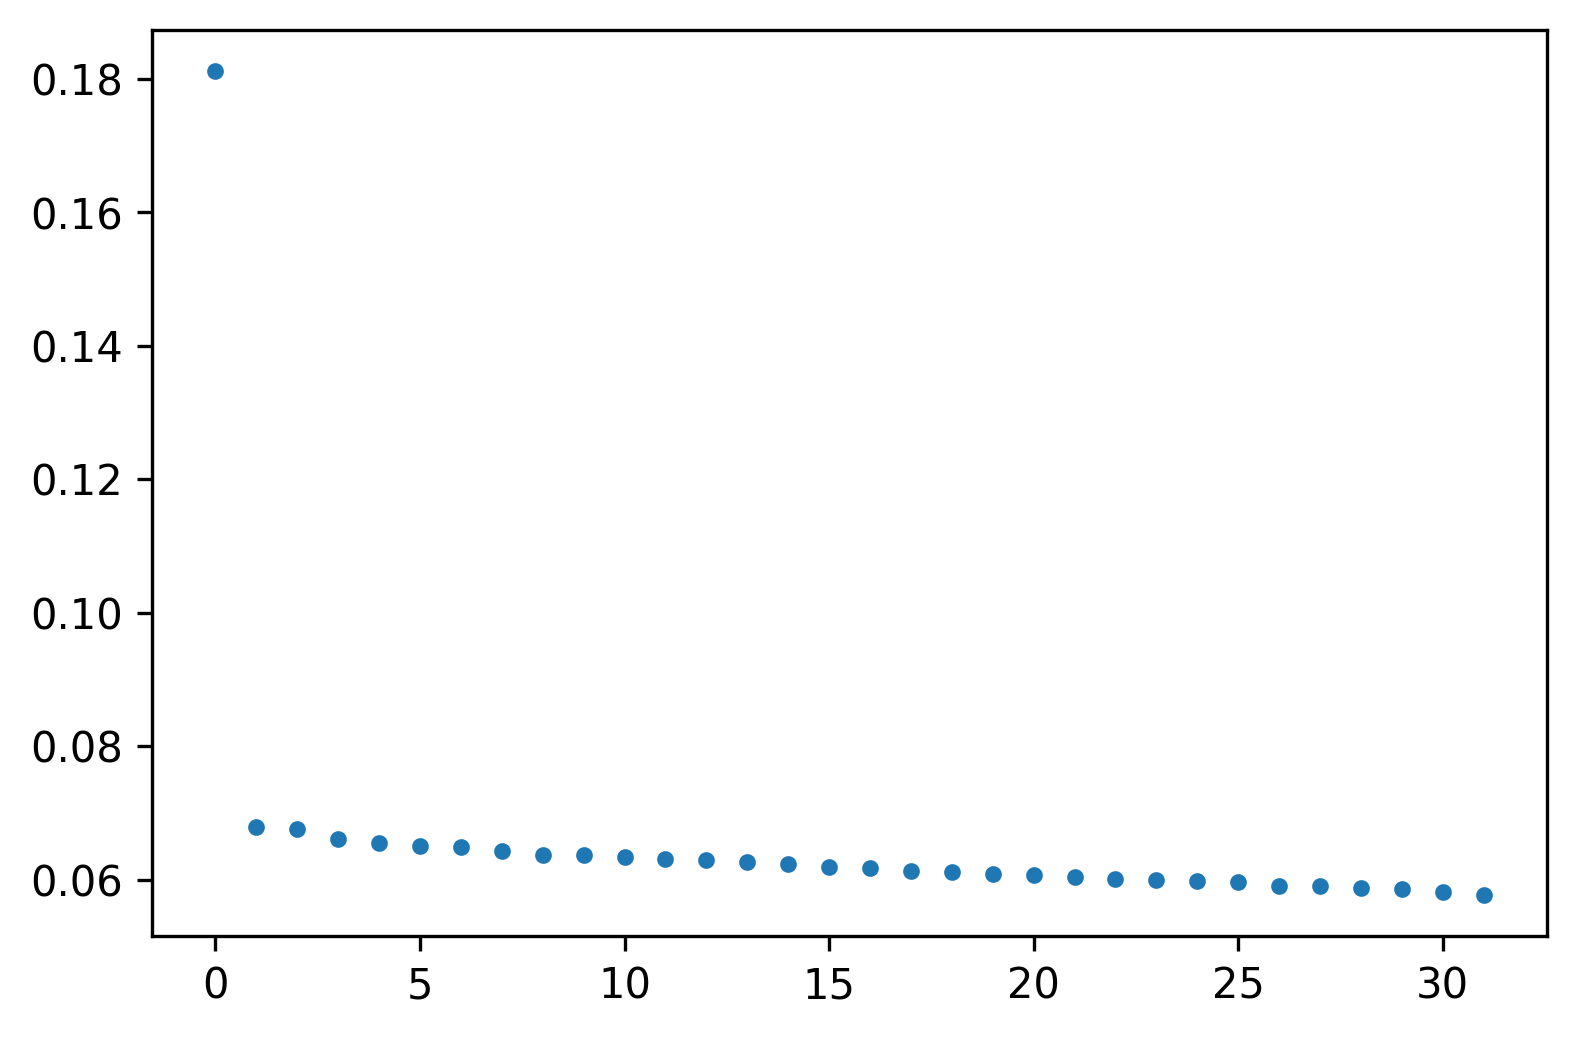

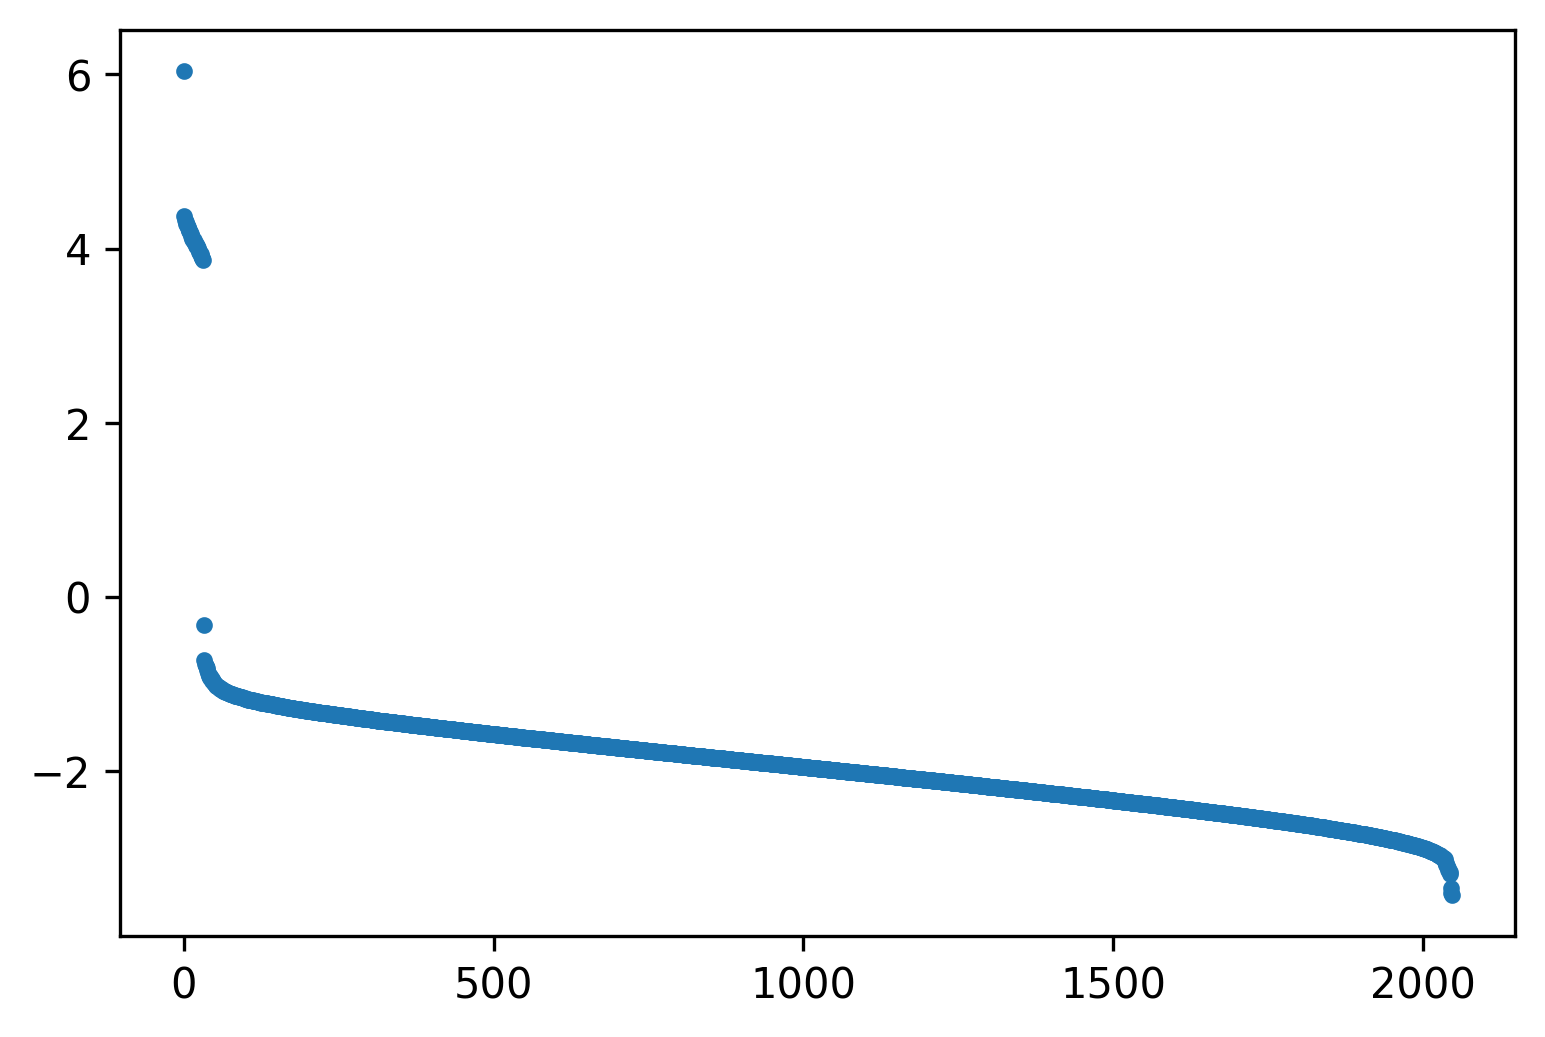

At  330 channels, alpha is 4.366721576373639
At  330 channels, RMSE/y_std is 0.07605640131595133
***************************  310  *************************
0:  |F(x)| = 0.0221729; step 1
1:  |F(x)| = 0.000461628; step 1
2:  |F(x)| = 5.35177e-05; step 1
3:  |F(x)| = 1.06154e-05; step 1
4:  |F(x)| = 2.04277e-06; step 1


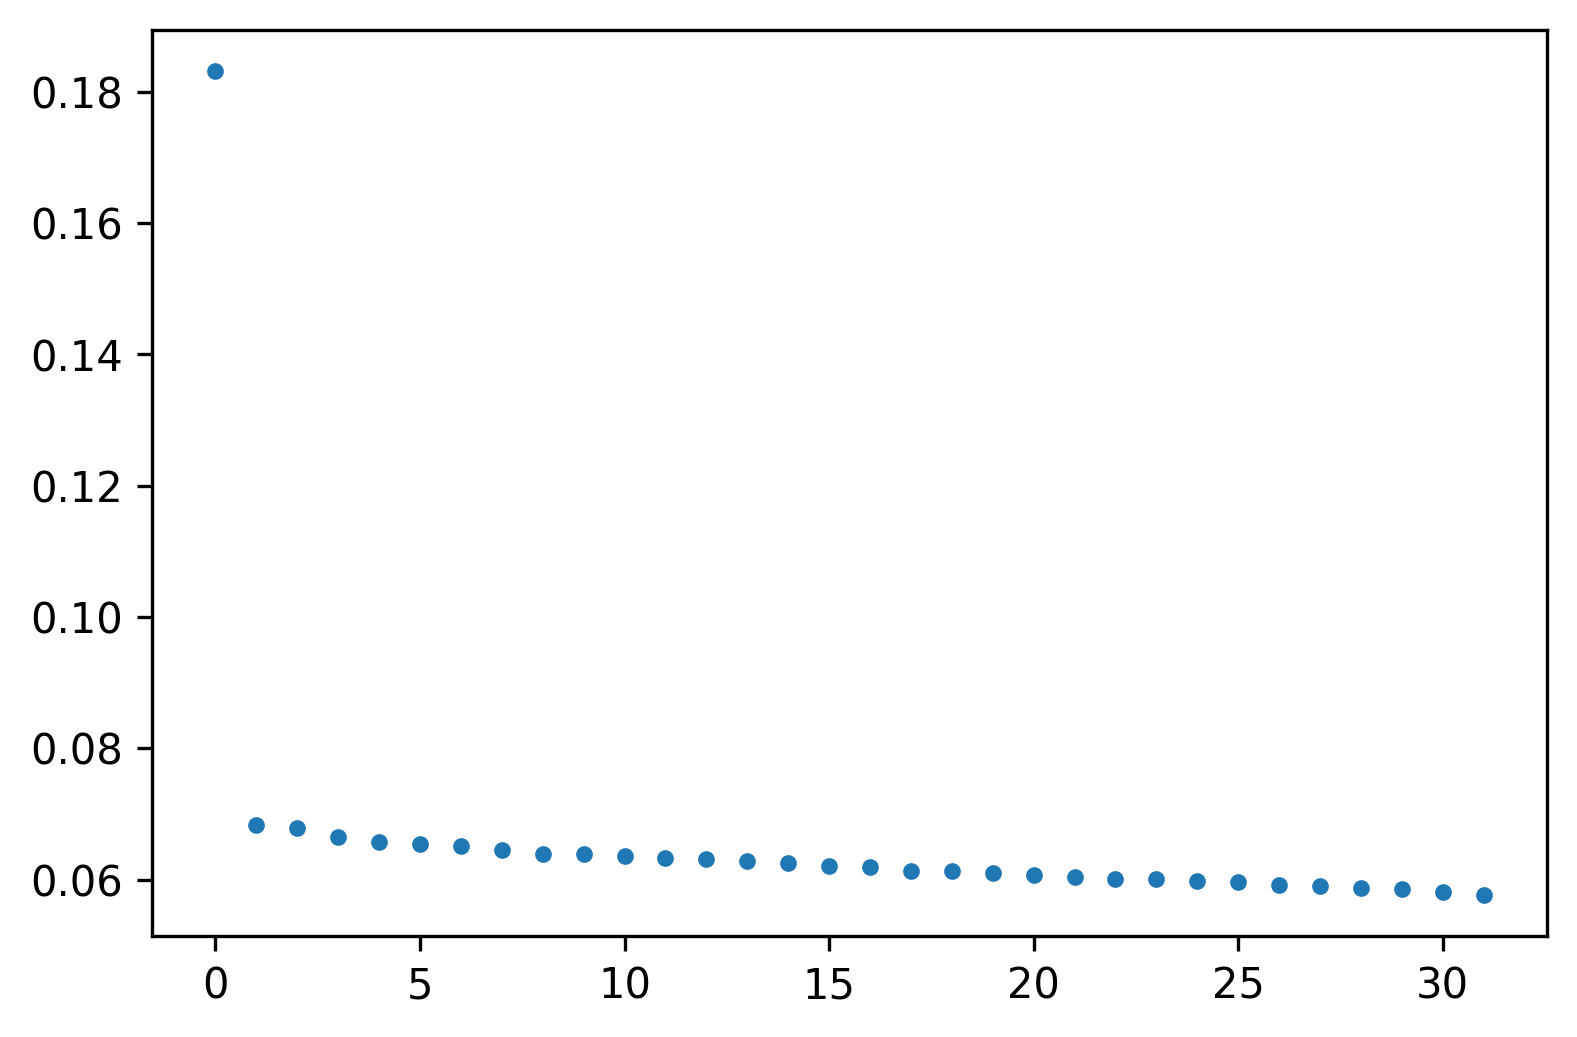

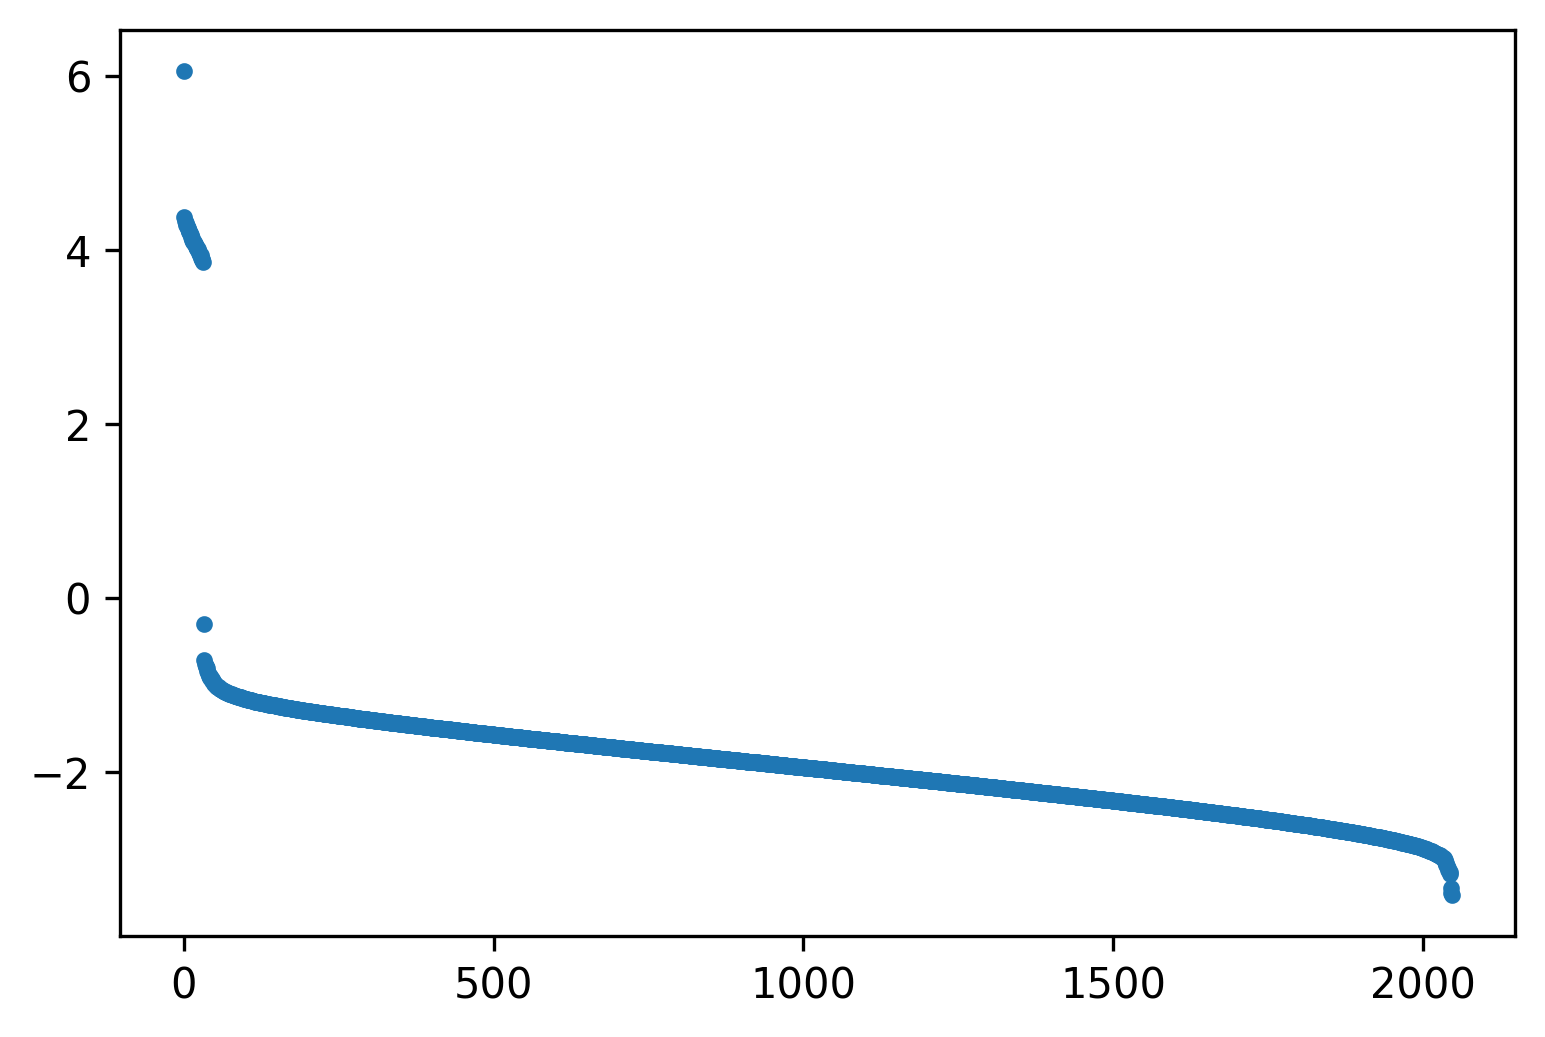

At  310 channels, alpha is 4.270773929655548
At  310 channels, RMSE/y_std is 0.0758403477691792
***************************  290  *************************
0:  |F(x)| = 0.0272615; step 1
1:  |F(x)| = 0.000700033; step 1
2:  |F(x)| = 6.45052e-05; step 1
3:  |F(x)| = 8.3294e-06; step 1
4:  |F(x)| = 1.6682e-06; step 1


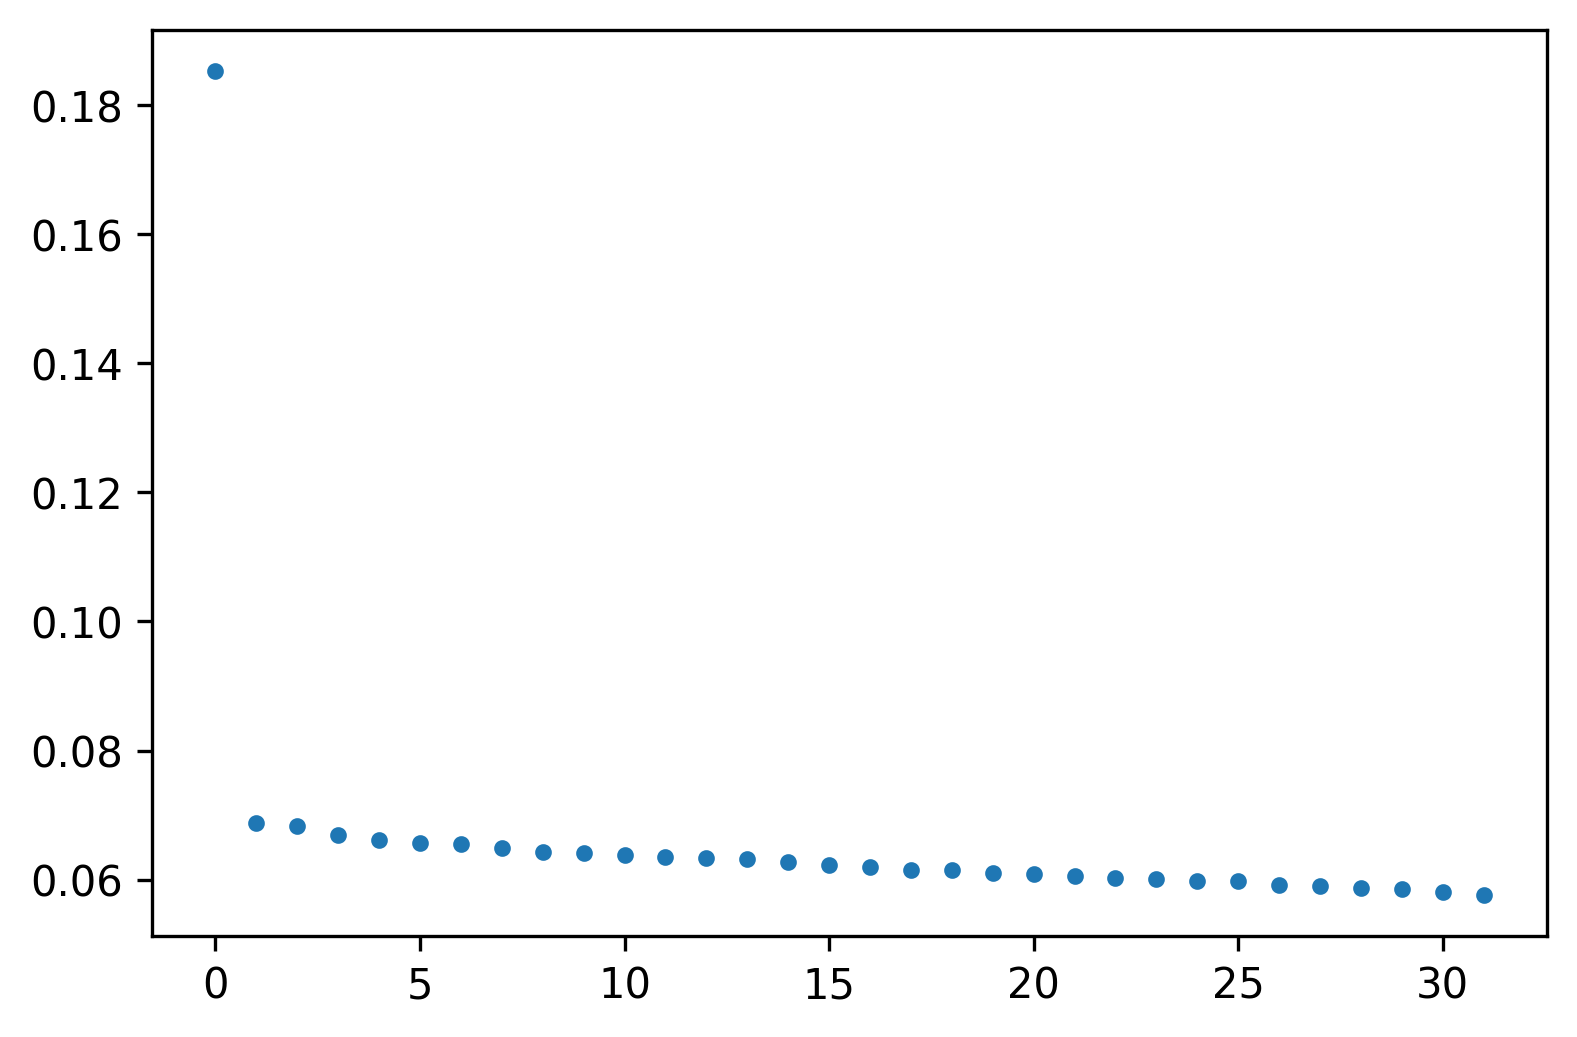

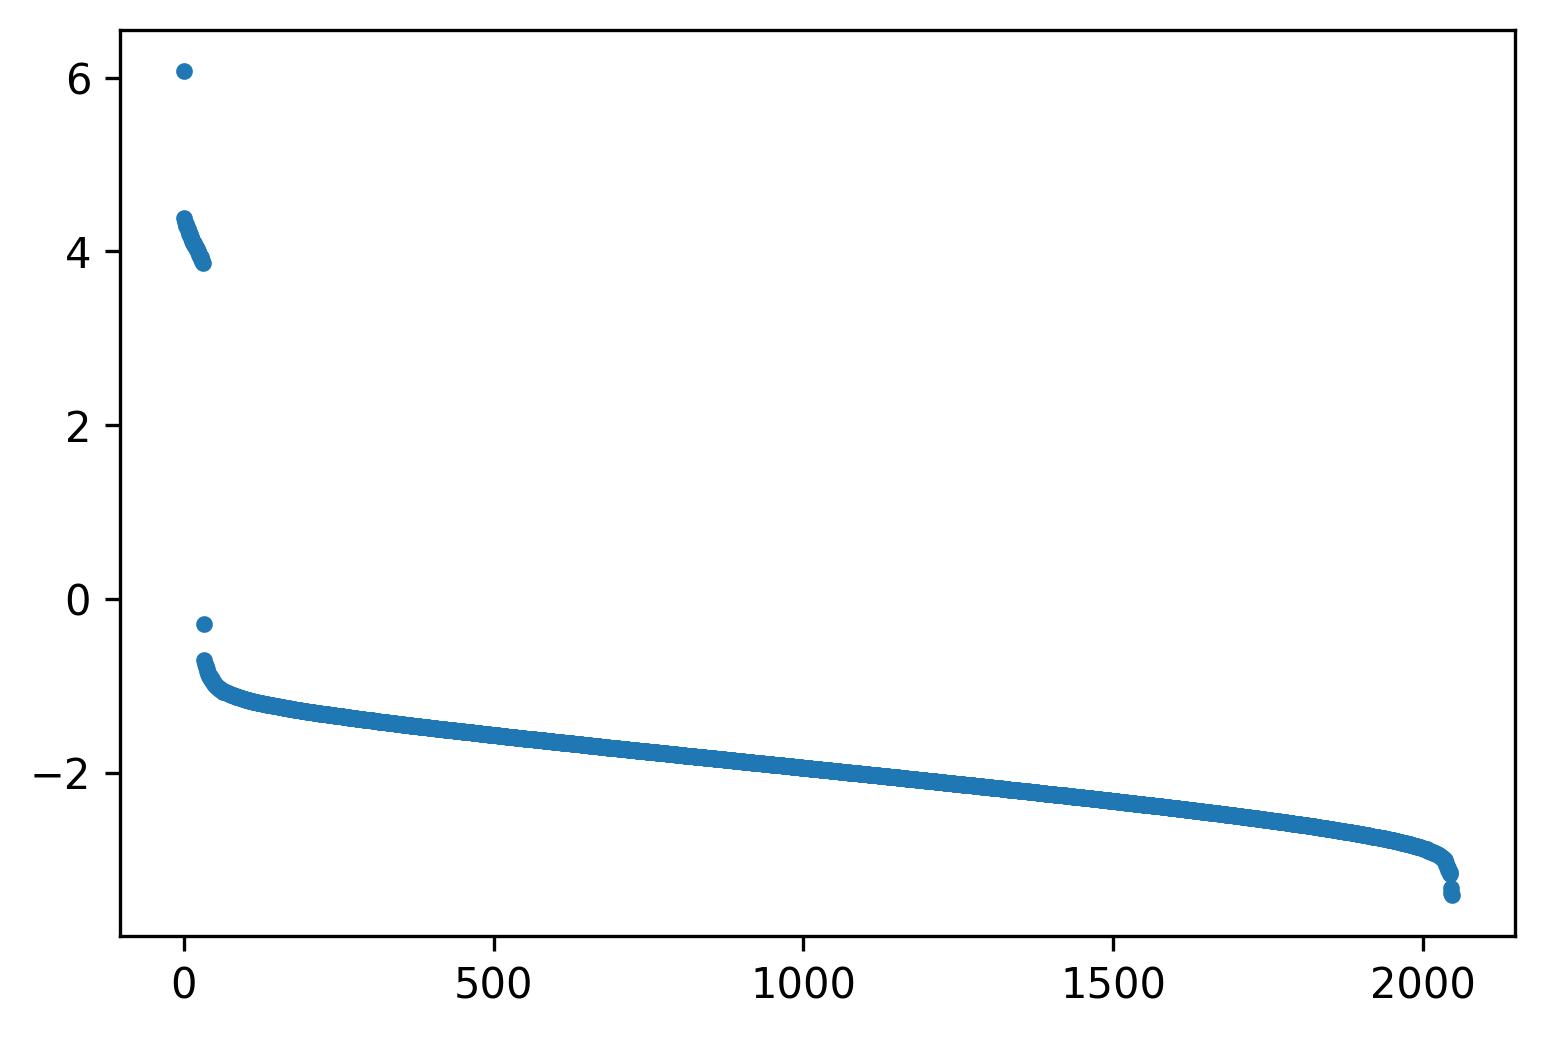

At  290 channels, alpha is 4.1710046456653656
At  290 channels, RMSE/y_std is 0.07561047268139671
***************************  270  *************************
0:  |F(x)| = 0.0339718; step 1
1:  |F(x)| = 0.000763532; step 1
2:  |F(x)| = 8.61878e-05; step 1
3:  |F(x)| = 1.66684e-05; step 1
4:  |F(x)| = 2.62743e-06; step 1


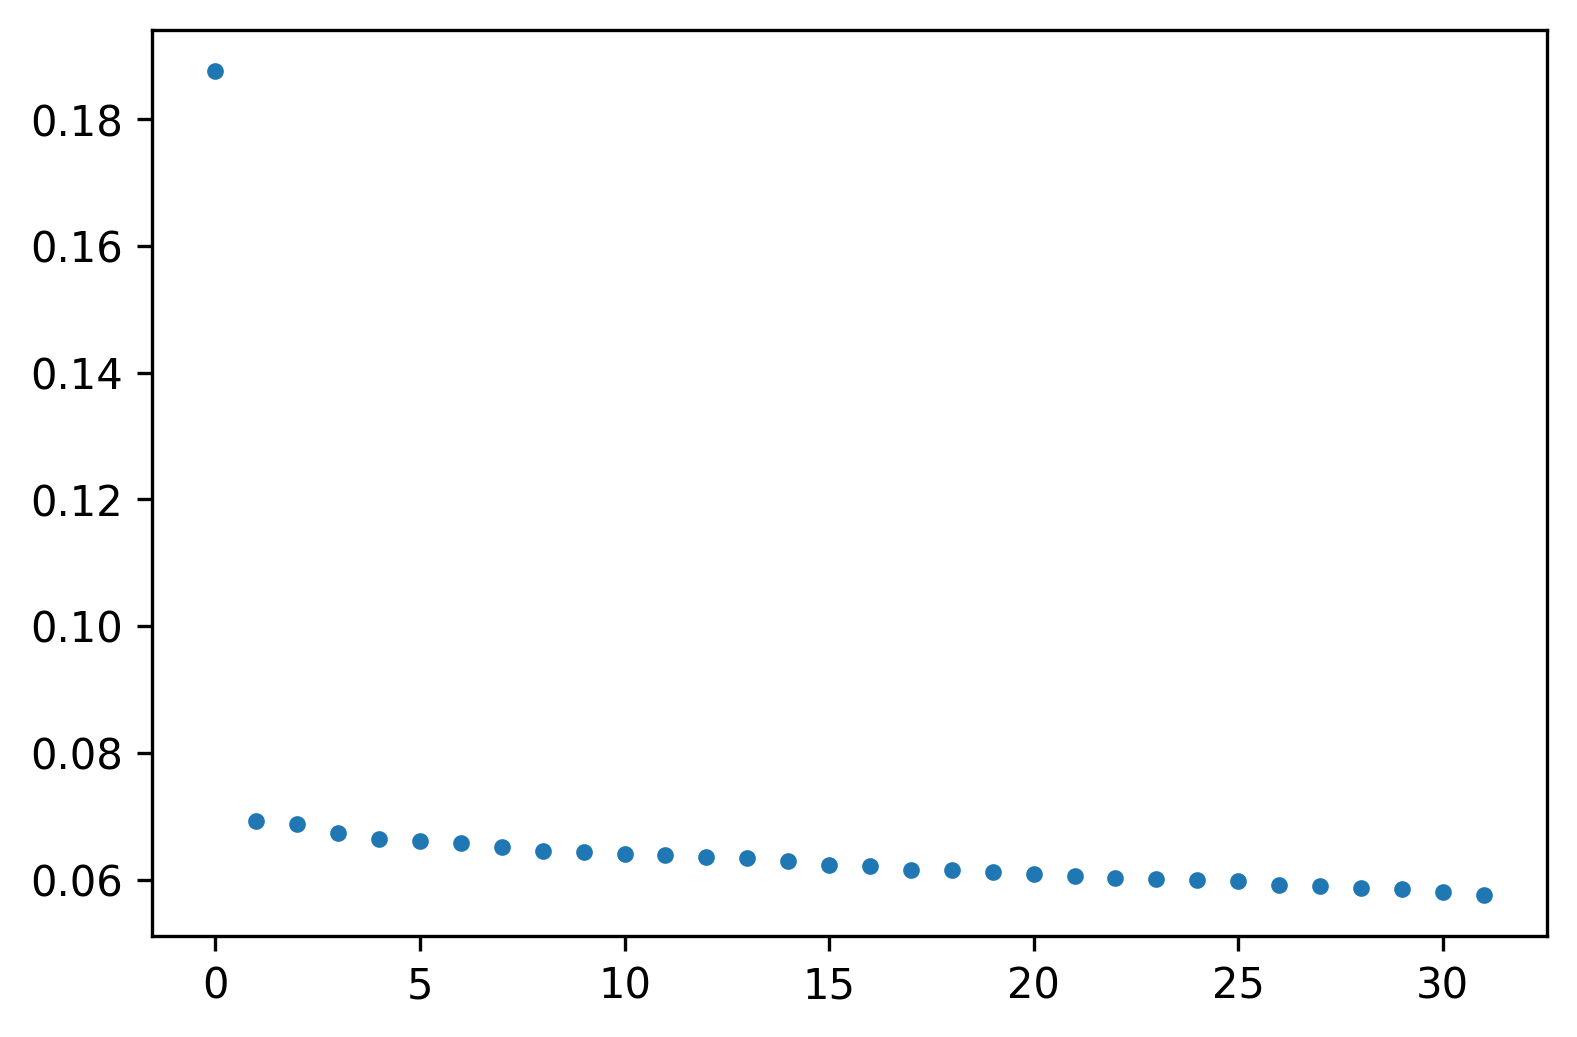

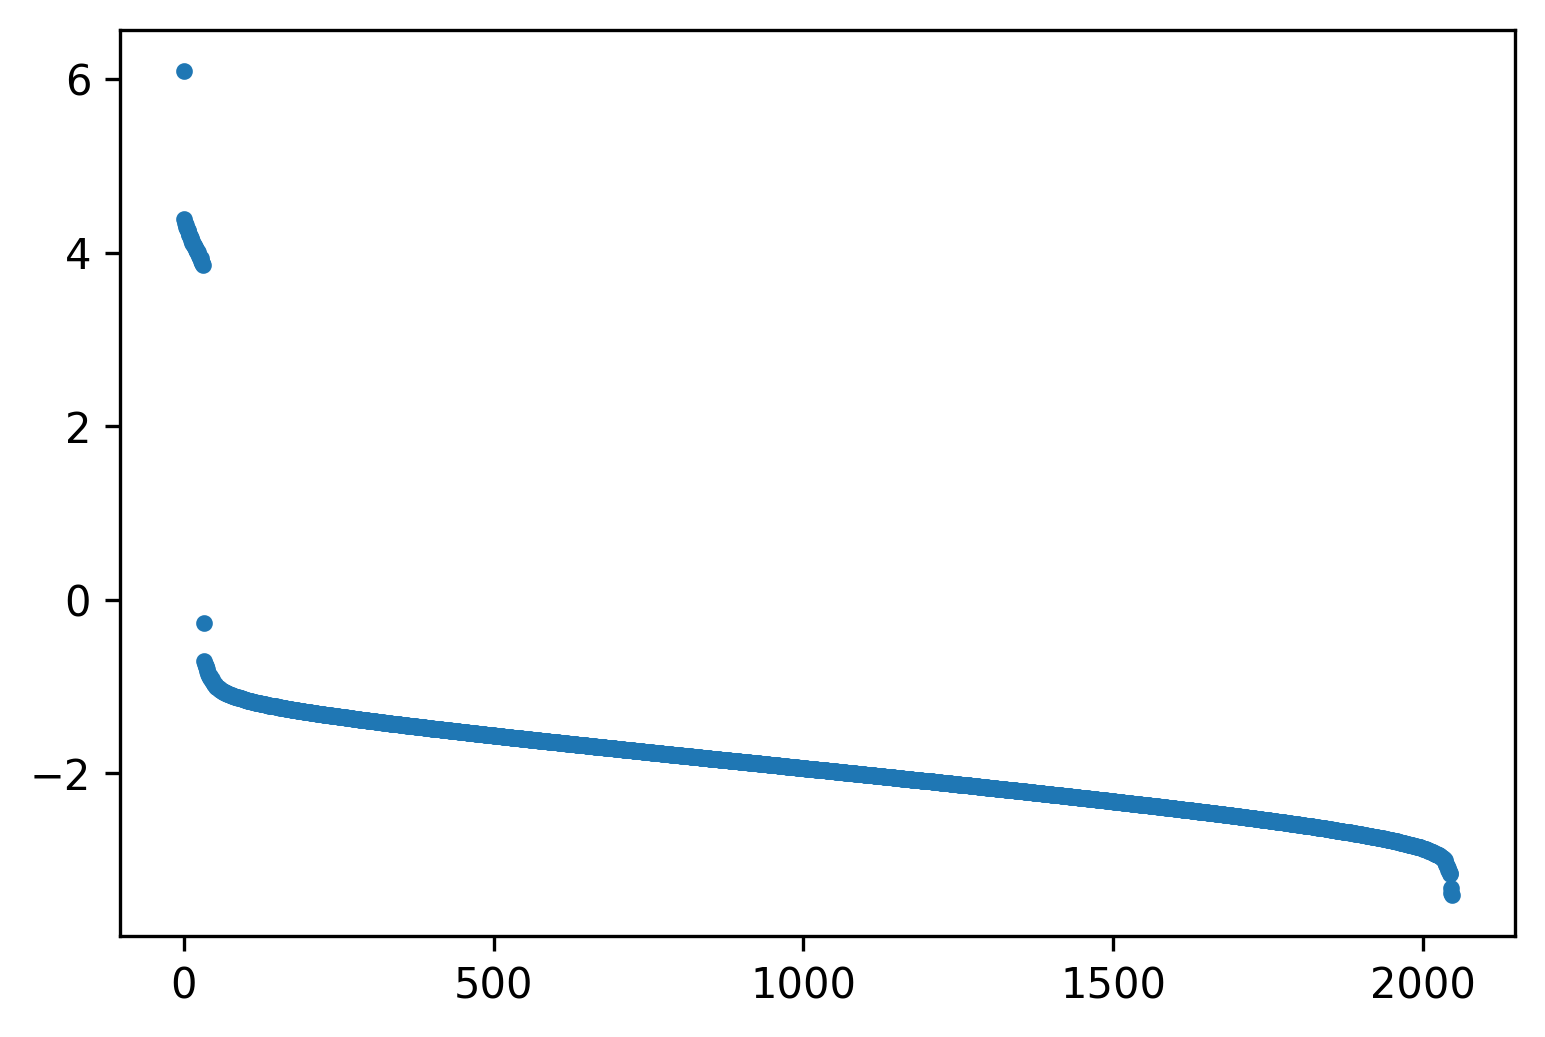

At  270 channels, alpha is 4.066790945762796
At  270 channels, RMSE/y_std is 0.0753642629770929
***************************  250  *************************
0:  |F(x)| = 0.0431095; step 1
1:  |F(x)| = 0.00202794; step 1
2:  |F(x)| = 0.000152932; step 1
3:  |F(x)| = 5.09028e-05; step 1
4:  |F(x)| = 9.84294e-06; step 1
5:  |F(x)| = 2.41394e-06; step 1


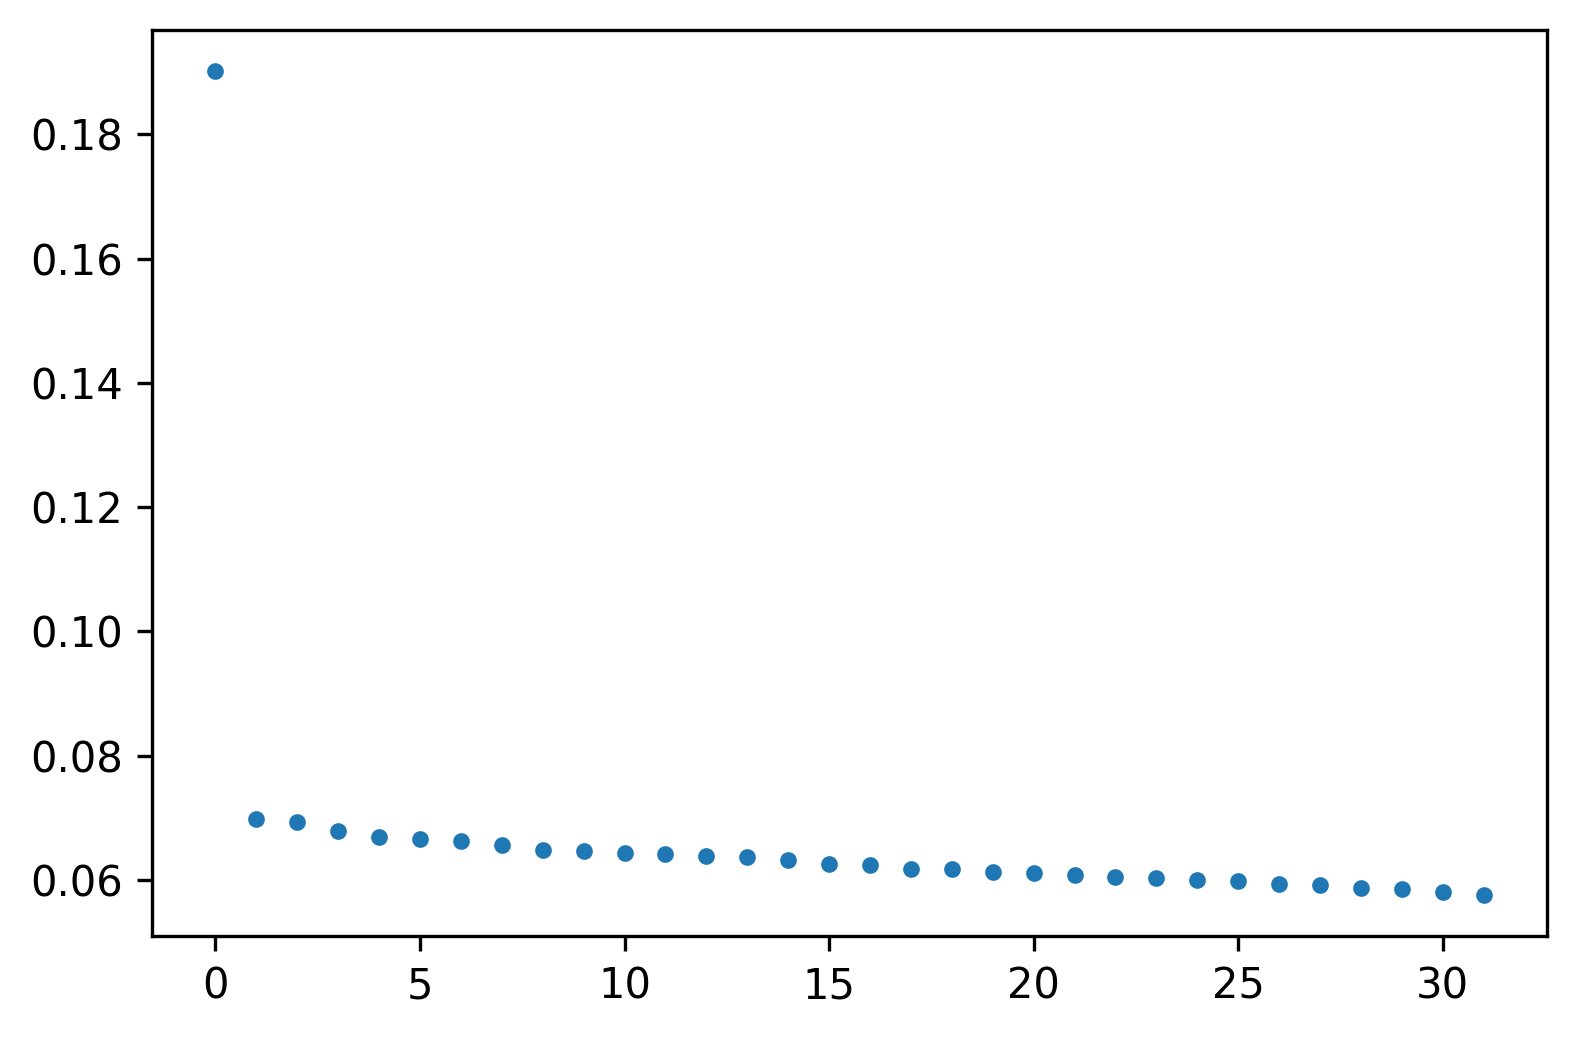

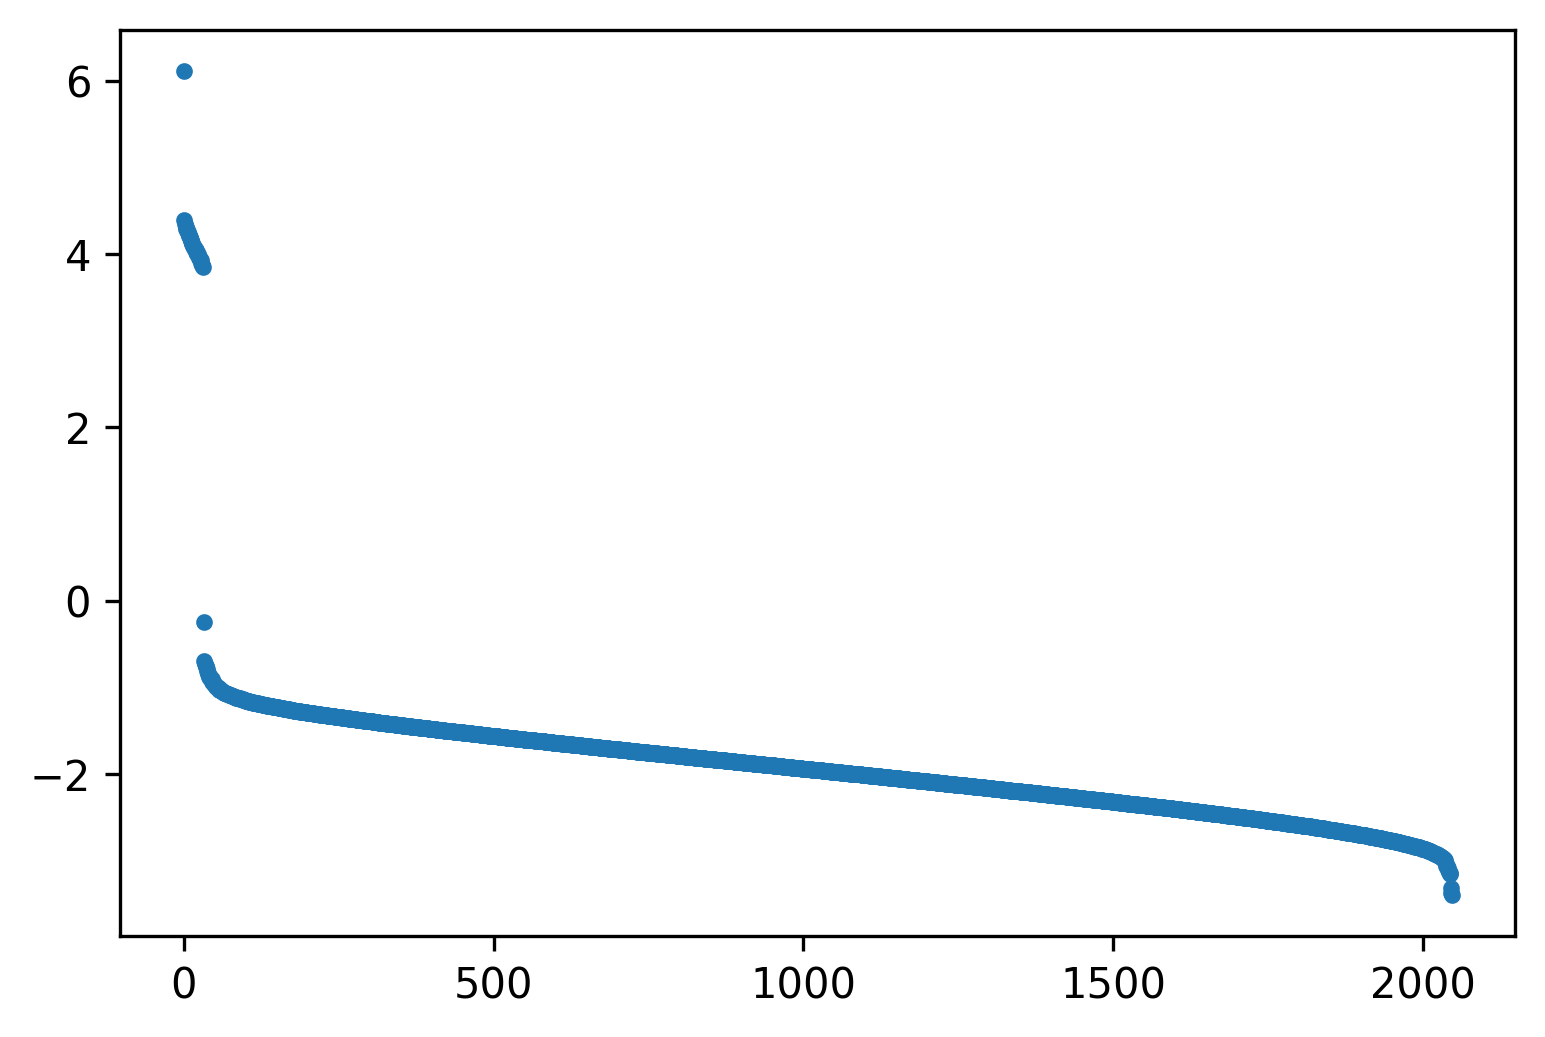

At  250 channels, alpha is 3.9573484850455243
At  250 channels, RMSE/y_std is 0.07509968575130199
***************************  230  *************************
0:  |F(x)| = 0.0556161; step 1
1:  |F(x)| = 0.00139402; step 1
2:  |F(x)| = 0.00130949; step 1
3:  |F(x)| = 0.0013095; step 1
4:  |F(x)| = 0.0013095; step 1
5:  |F(x)| = 0.0013095; step 1
6:  |F(x)| = 0.0013095; step 1
7:  |F(x)| = 0.0013095; step 1
8:  |F(x)| = 0.0013095; step 1
9:  |F(x)| = 0.0013095; step 1
10:  |F(x)| = 0.0013095; step 1
11:  |F(x)| = 0.0013095; step 1
12:  |F(x)| = 0.0013094; step 1
13:  |F(x)| = 0.00130951; step 0.499927
14:  |F(x)| = 0.0013095; step 1
15:  |F(x)| = 0.0013095; step 1
16:  |F(x)| = 0.00130945; step 1
17:  |F(x)| = 0.00130864; step 1
18:  |F(x)| = 0.00130963; step 1
19:  |F(x)| = 0.00130971; step 1
20:  |F(x)| = 0.00130939; step 0.496967
21:  |F(x)| = 0.00130886; step 1
22:  |F(x)| = 0.00130949; step 1
23:  |F(x)| = 0.0013095; step 0.0527865
24:  |F(x)| = 0.000481625; step 1
25:  |F(x)| = 0.00

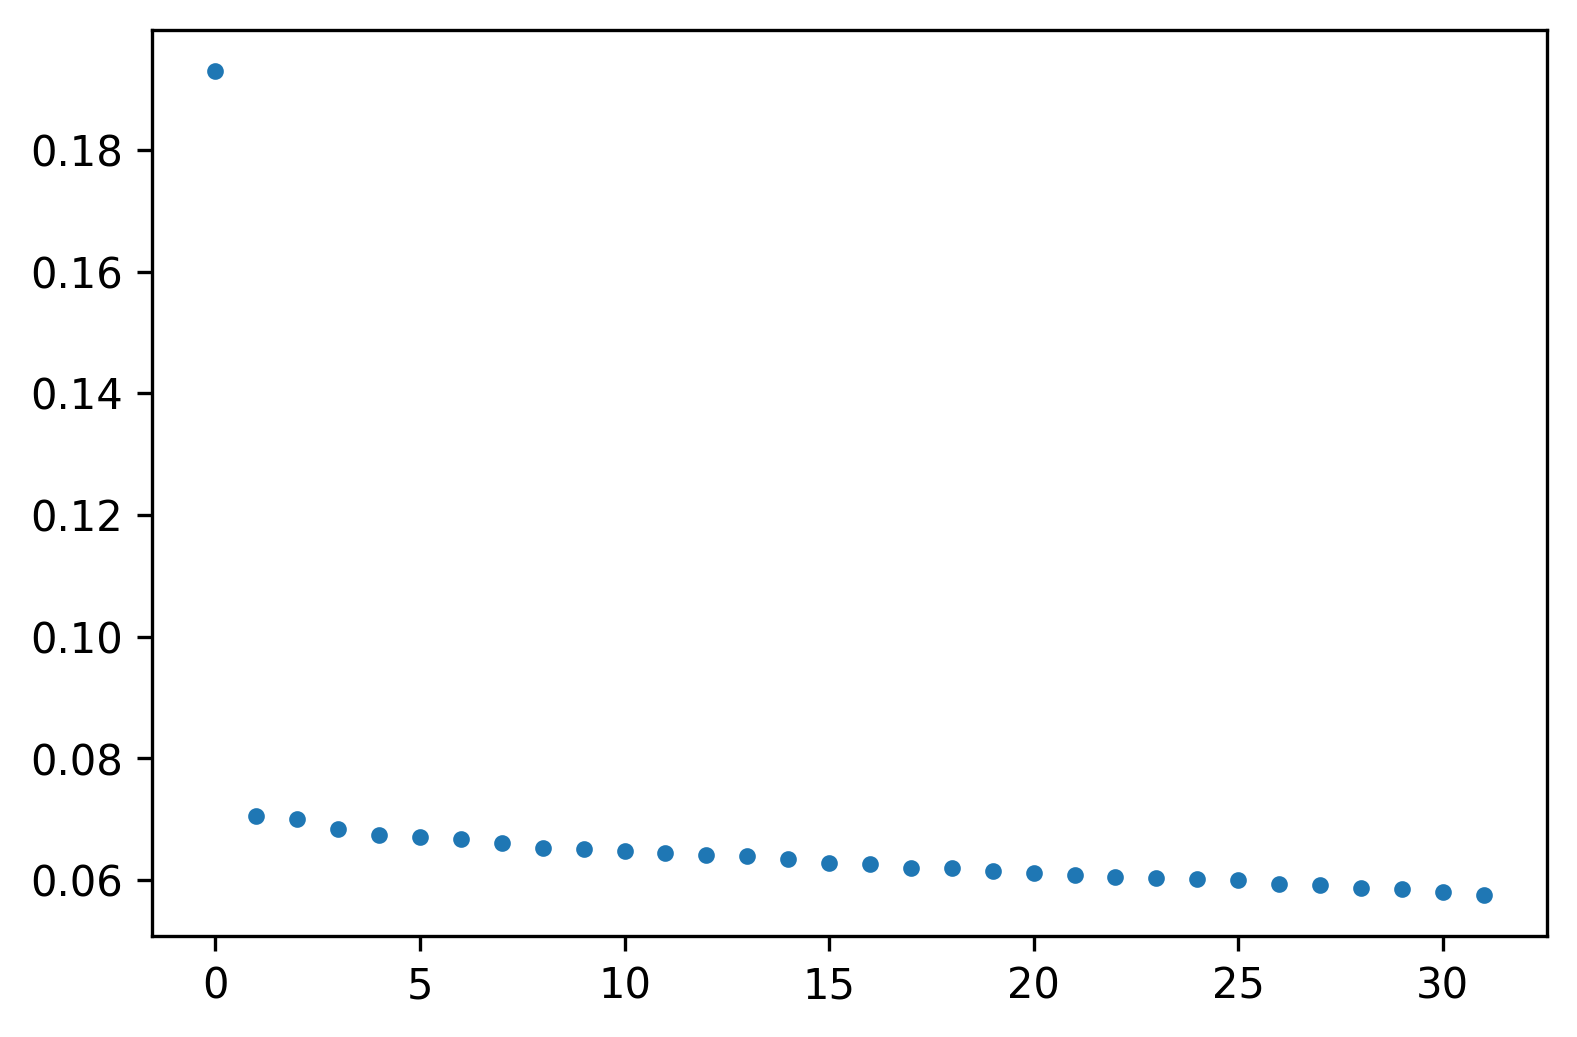

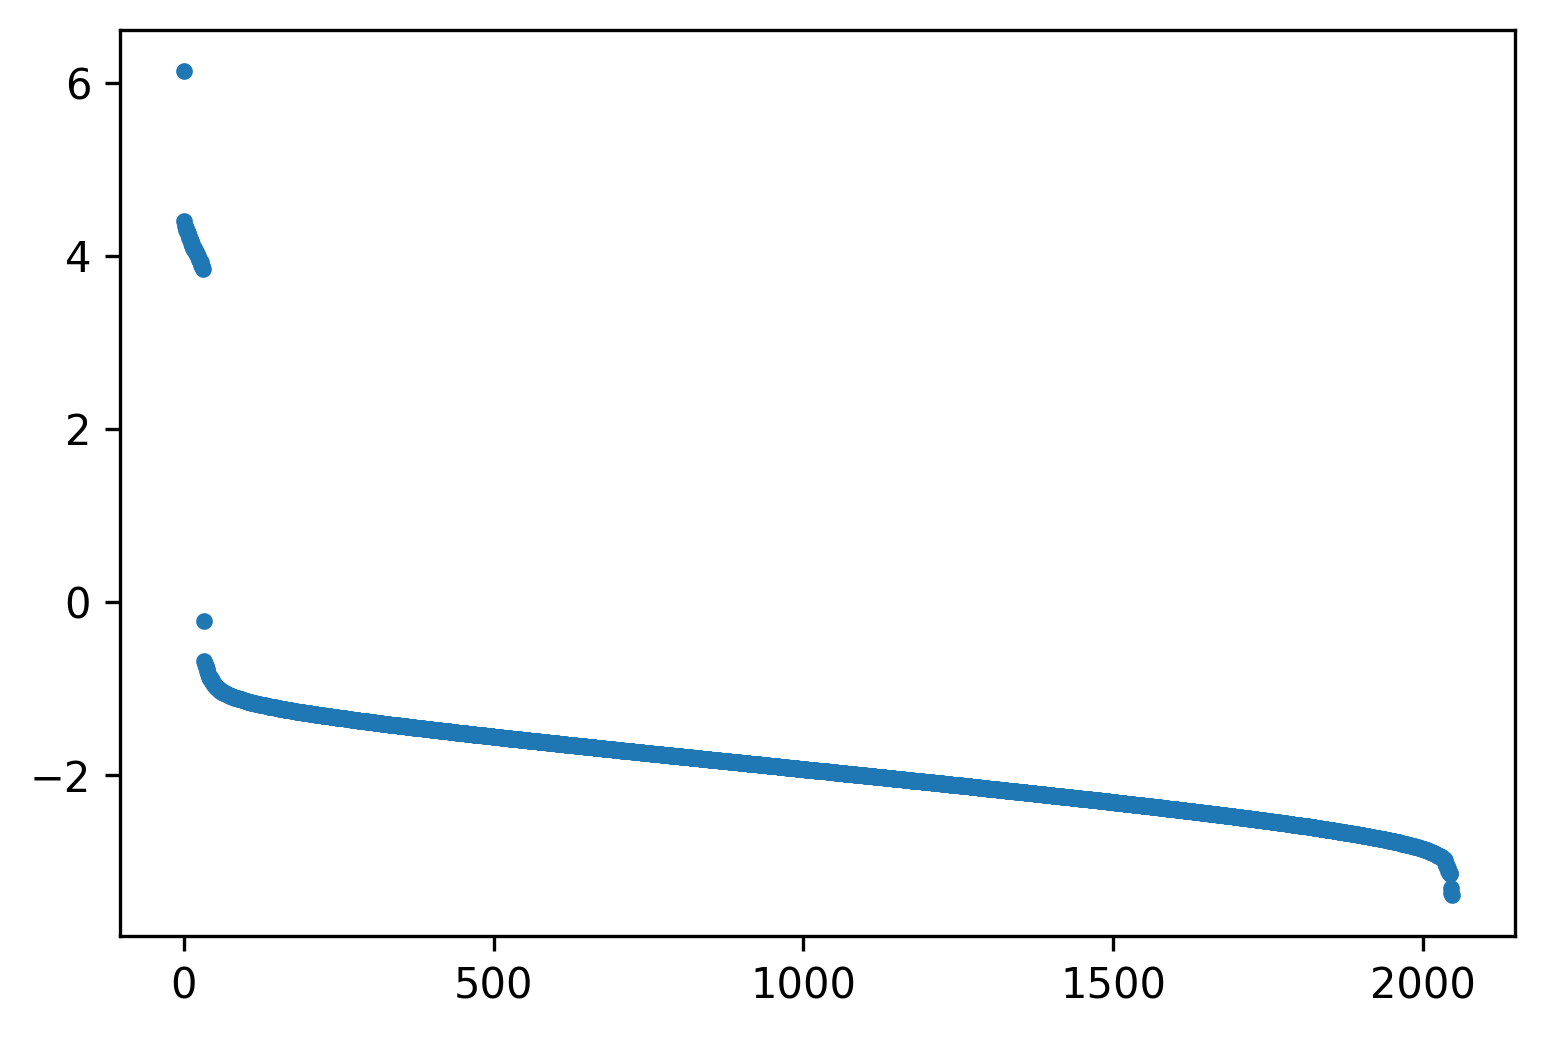

At  230 channels, alpha is 3.8418727662949412
At  230 channels, RMSE/y_std is 0.07481213088440761
***************************  210  *************************
0:  |F(x)| = 0.0734525; step 1
1:  |F(x)| = 0.00220654; step 1
2:  |F(x)| = 0.00163112; step 1
3:  |F(x)| = 0.00163114; step 1
4:  |F(x)| = 0.00163114; step 1
5:  |F(x)| = 0.00163114; step 1
6:  |F(x)| = 0.00163114; step 1
7:  |F(x)| = 0.00163114; step 1
8:  |F(x)| = 0.00163114; step 1
9:  |F(x)| = 0.00163114; step 1
10:  |F(x)| = 0.00163114; step 1
11:  |F(x)| = 0.00163114; step 1
12:  |F(x)| = 0.00163109; step 1
13:  |F(x)| = 0.00163098; step 1
14:  |F(x)| = 0.00163114; step 1
15:  |F(x)| = 0.00162976; step 1
16:  |F(x)| = 0.00163114; step 1
17:  |F(x)| = 0.00163133; step 1
18:  |F(x)| = 0.00163114; step 1
19:  |F(x)| = 0.00163114; step 1
20:  |F(x)| = 0.00163114; step 1
21:  |F(x)| = 0.00163089; step 1
22:  |F(x)| = 0.0016288; step 1
23:  |F(x)| = 0.0016321; step 1
24:  |F(x)| = 0.00163141; step 1
25:  |F(x)| = 0.001631; step 0

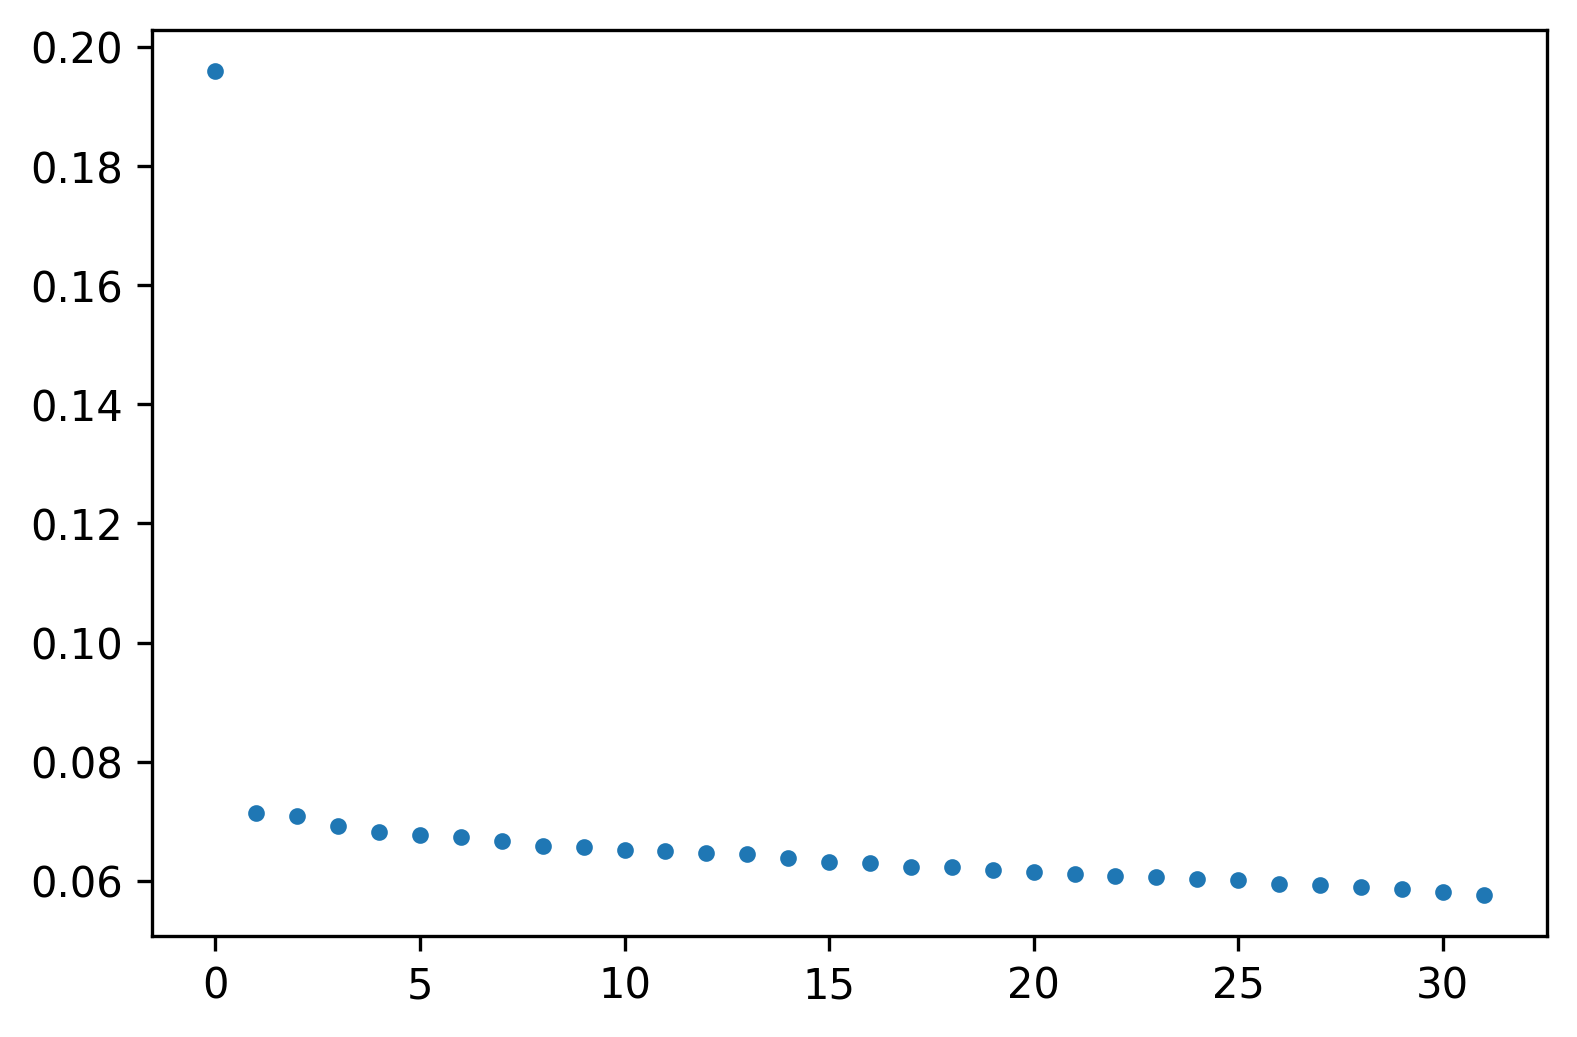

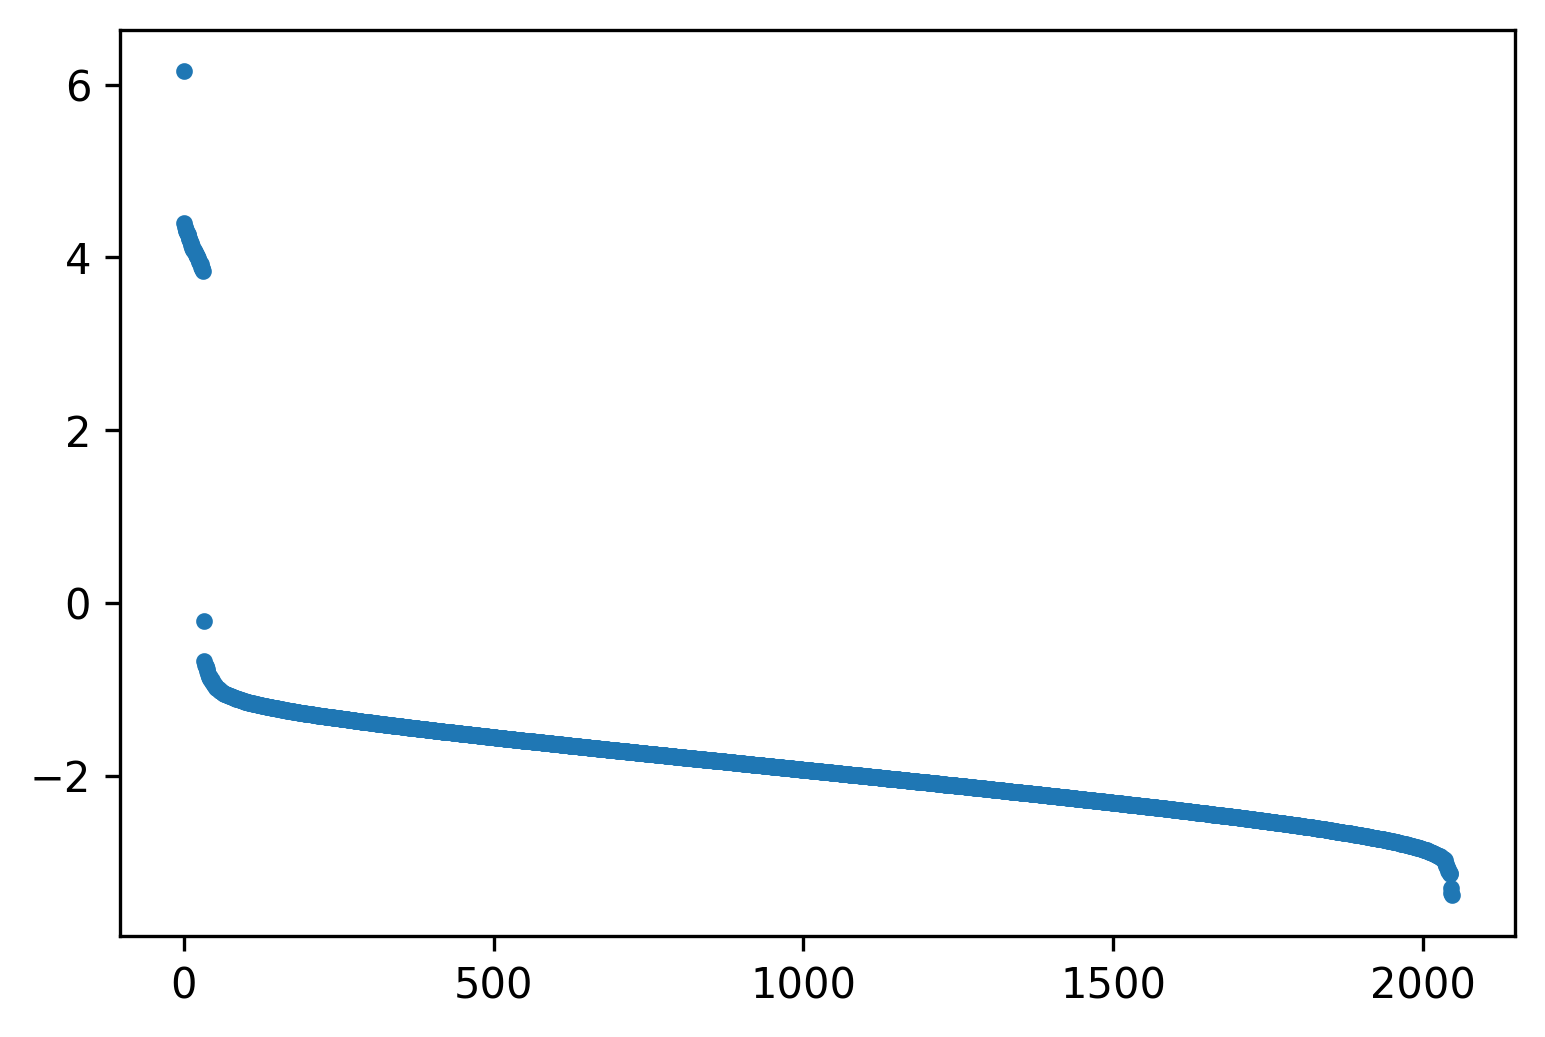

At  210 channels, alpha is 3.7188561252038843
At  210 channels, RMSE/y_std is 0.07449741976418638
***************************  200  *************************
0:  |F(x)| = 0.0210277; step 1
1:  |F(x)| = 0.000564151; step 1
2:  |F(x)| = 7.04076e-05; step 1
3:  |F(x)| = 1.07915e-05; step 1
4:  |F(x)| = 2.8375e-06; step 1


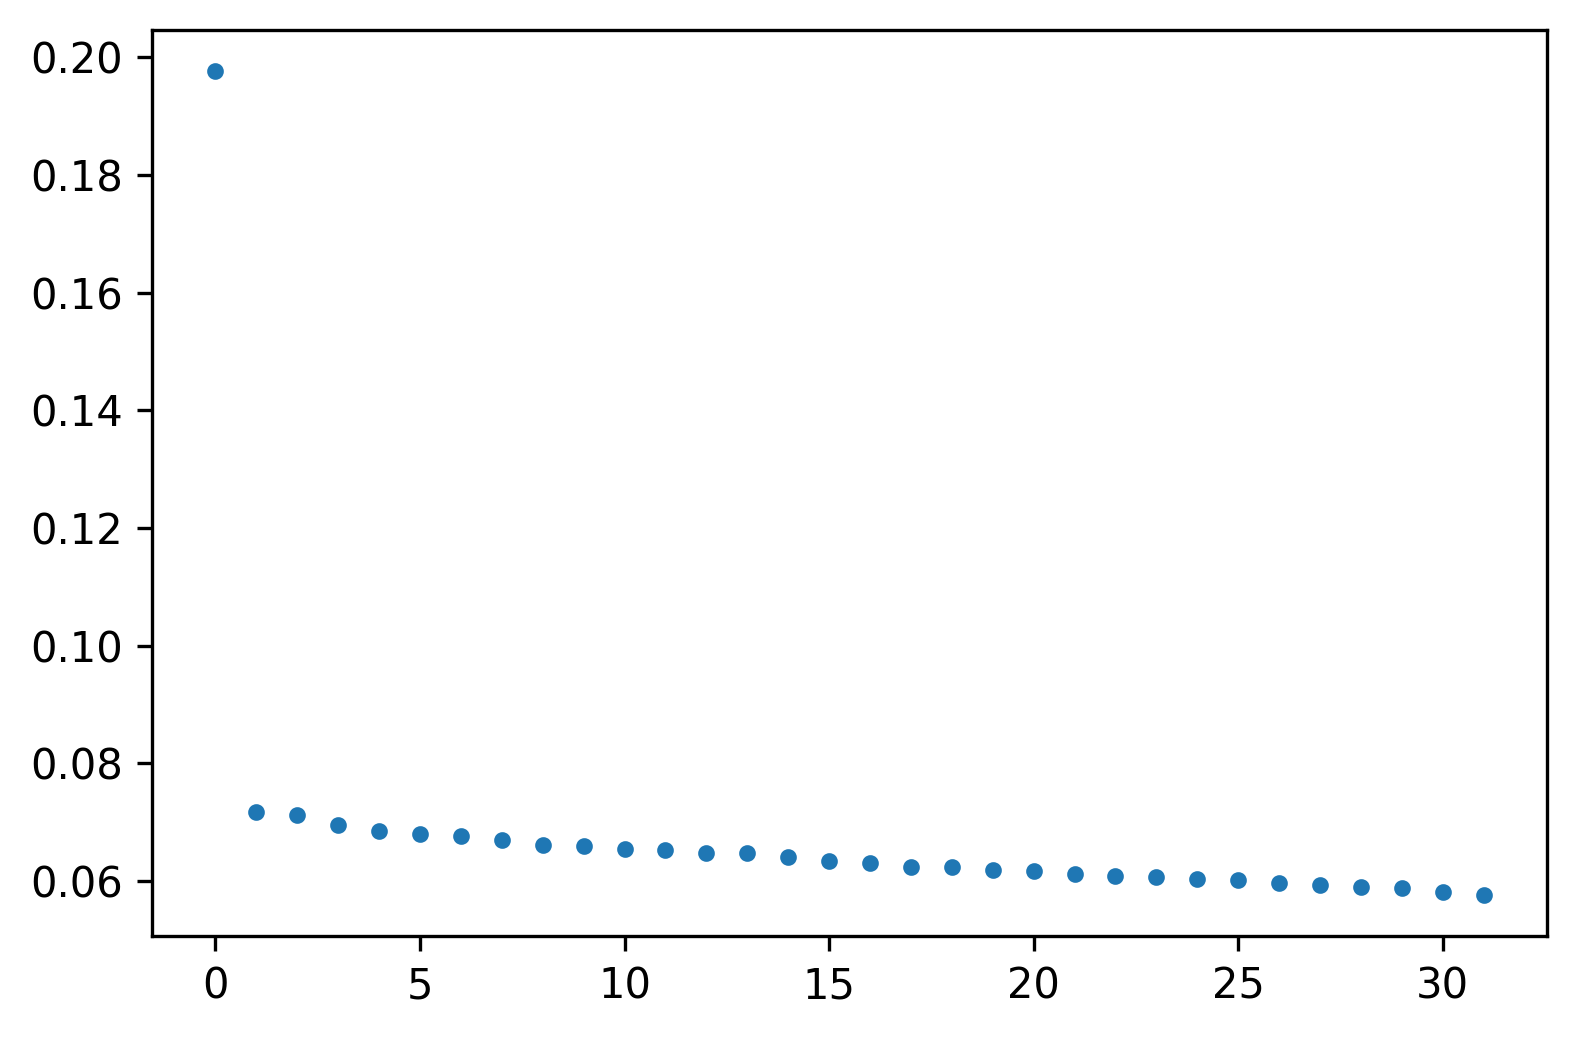

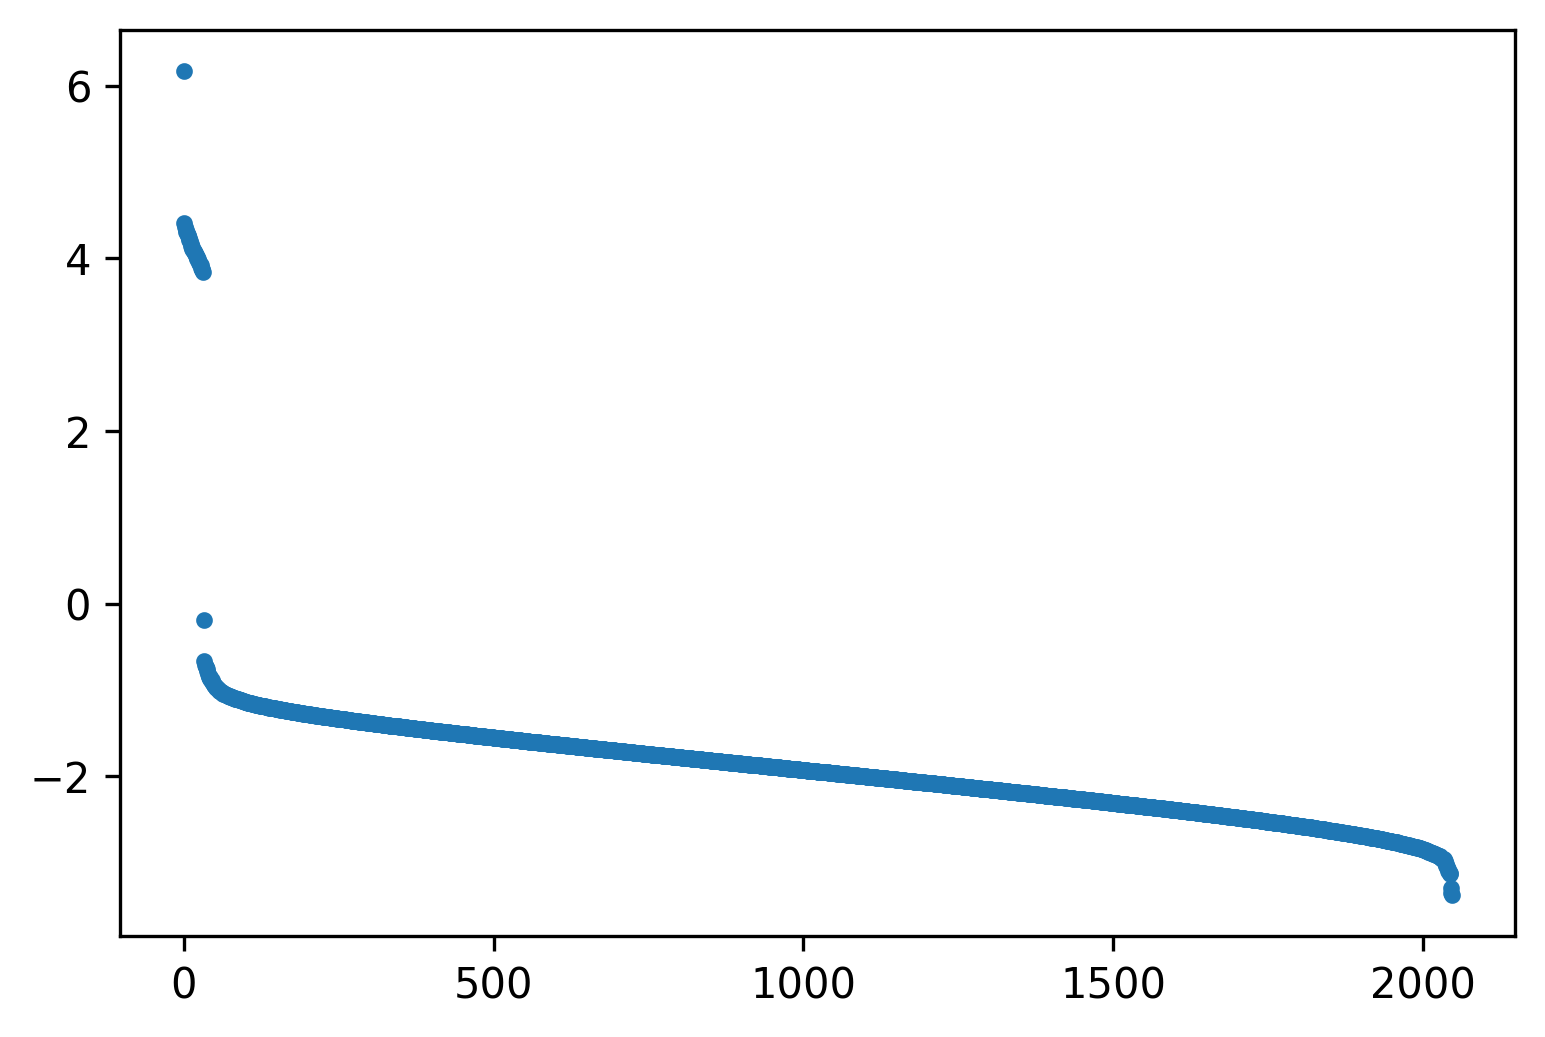

At  200 channels, alpha is 3.6542305376742537
At  200 channels, RMSE/y_std is 0.07432809333717383
***************************  190  *************************
0:  |F(x)| = 0.0246005; step 1
1:  |F(x)| = 0.000521101; step 1
2:  |F(x)| = 2.25822e-05; step 1
3:  |F(x)| = 1.23177e-05; step 1
4:  |F(x)| = 3.76082e-06; step 1


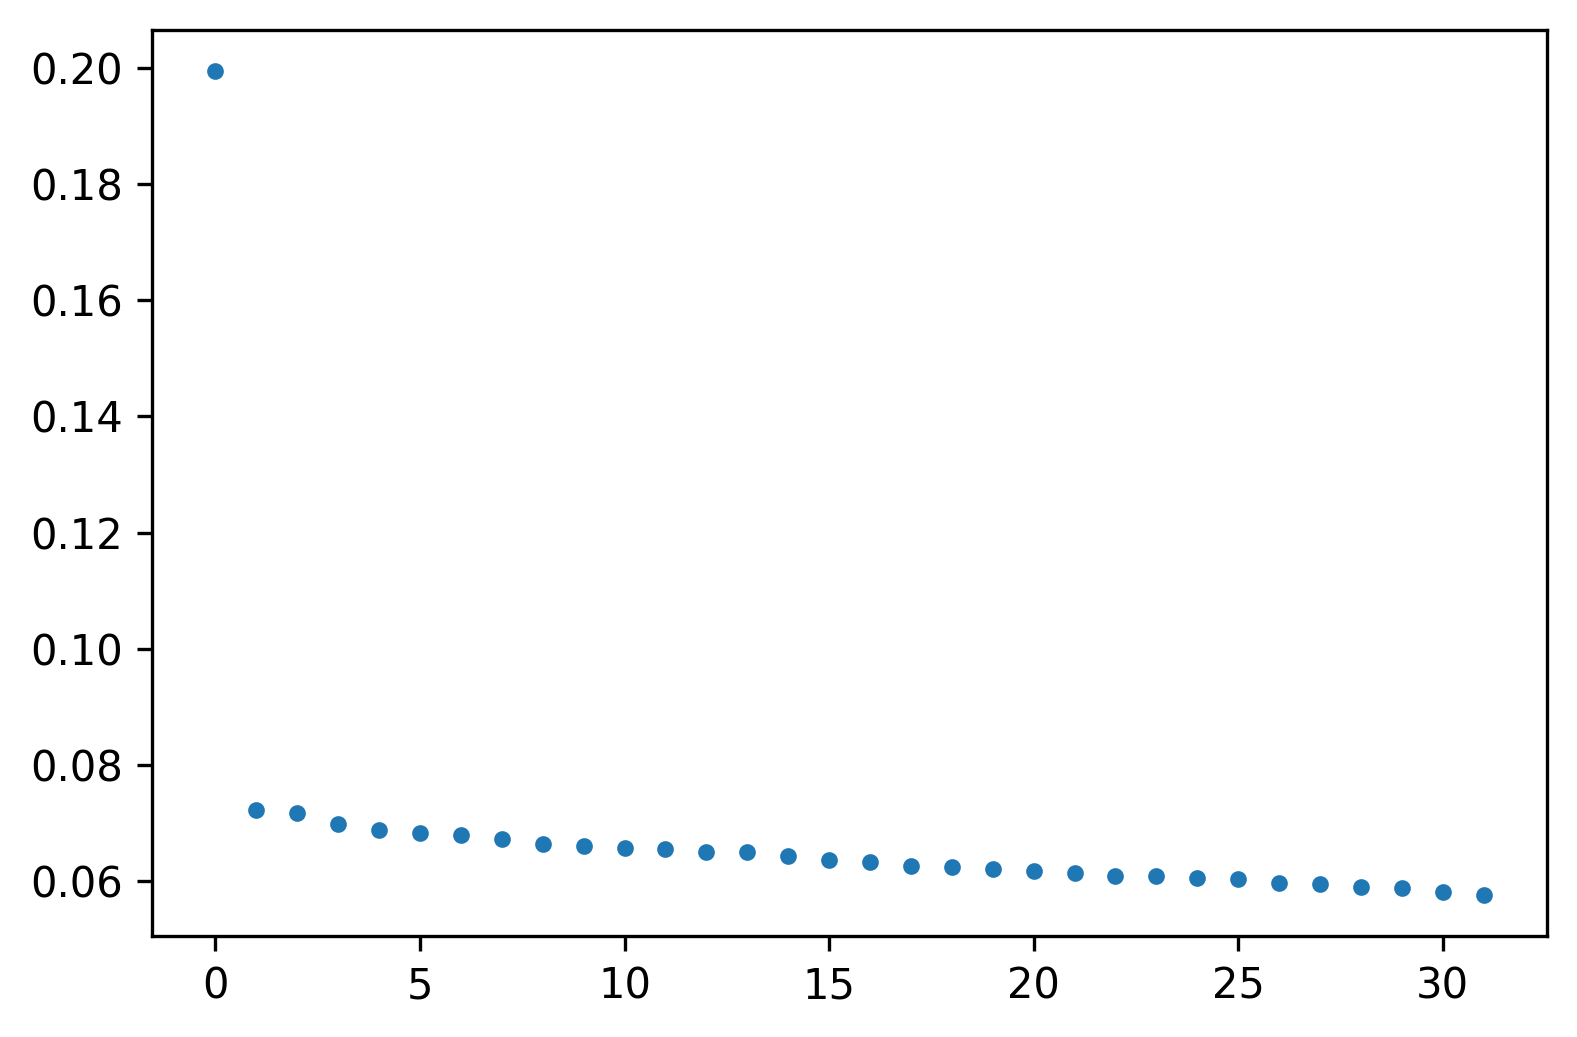

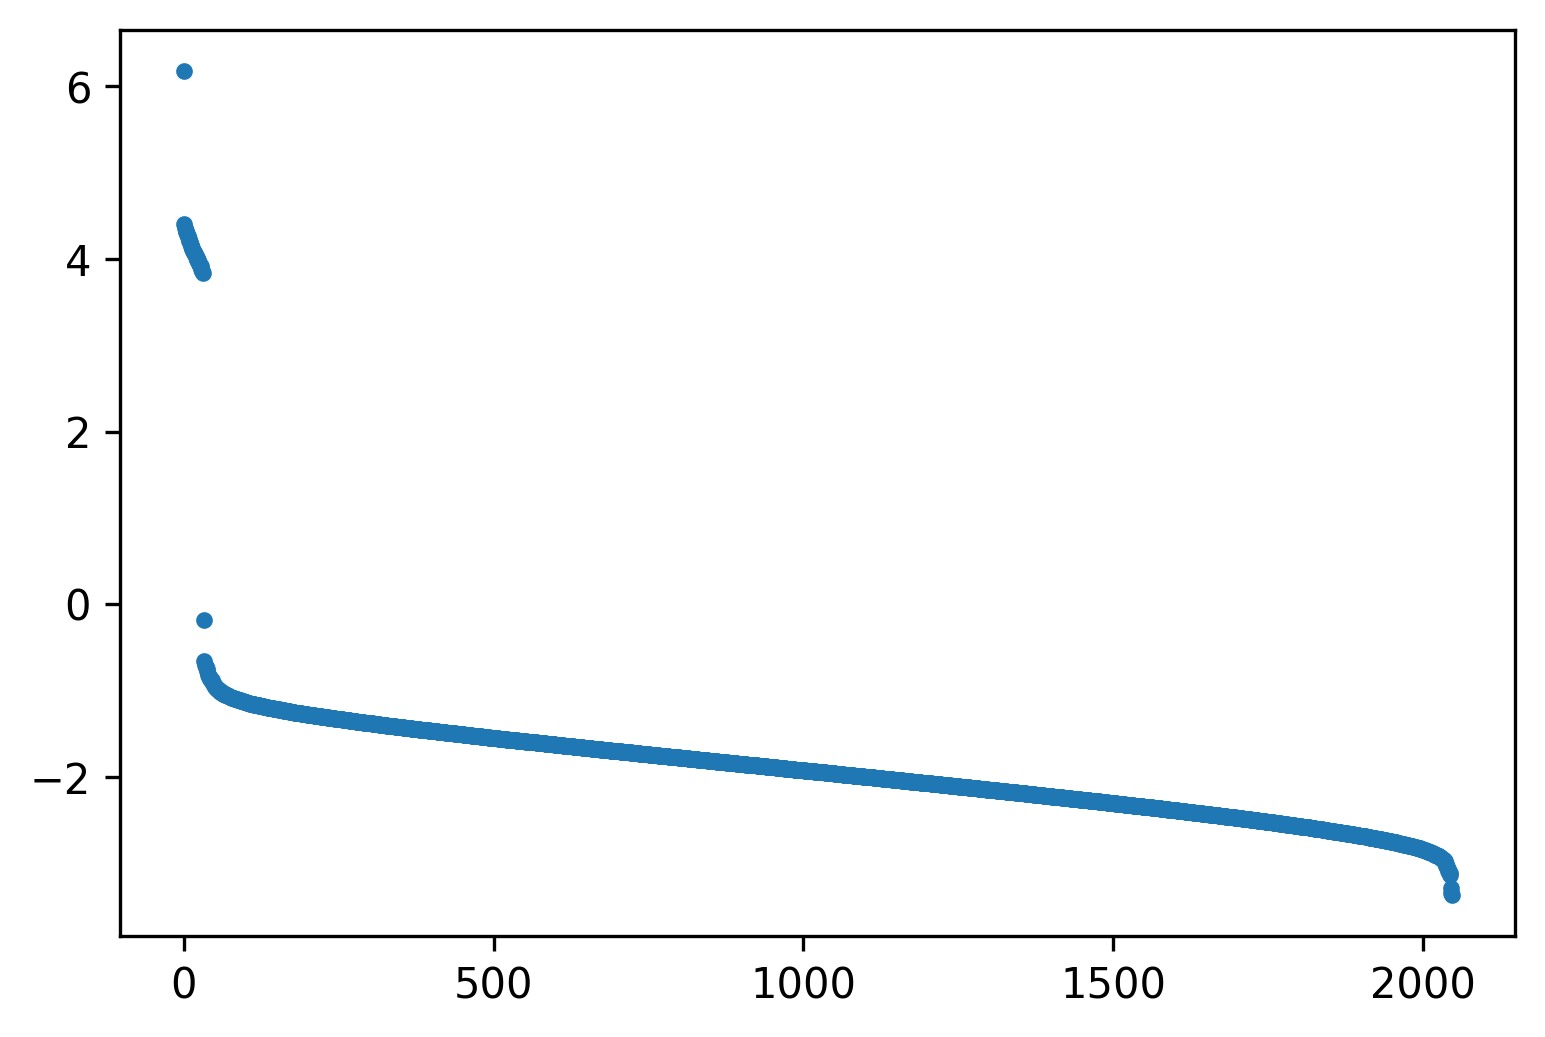

At  190 channels, alpha is 3.5870904702203976
At  190 channels, RMSE/y_std is 0.07415030237060266
***************************  180  *************************
0:  |F(x)| = 0.0289308; step 1
1:  |F(x)| = 0.000504532; step 1
2:  |F(x)| = 4.56691e-05; step 1
3:  |F(x)| = 1.61195e-05; step 1
4:  |F(x)| = 5.39828e-06; step 1


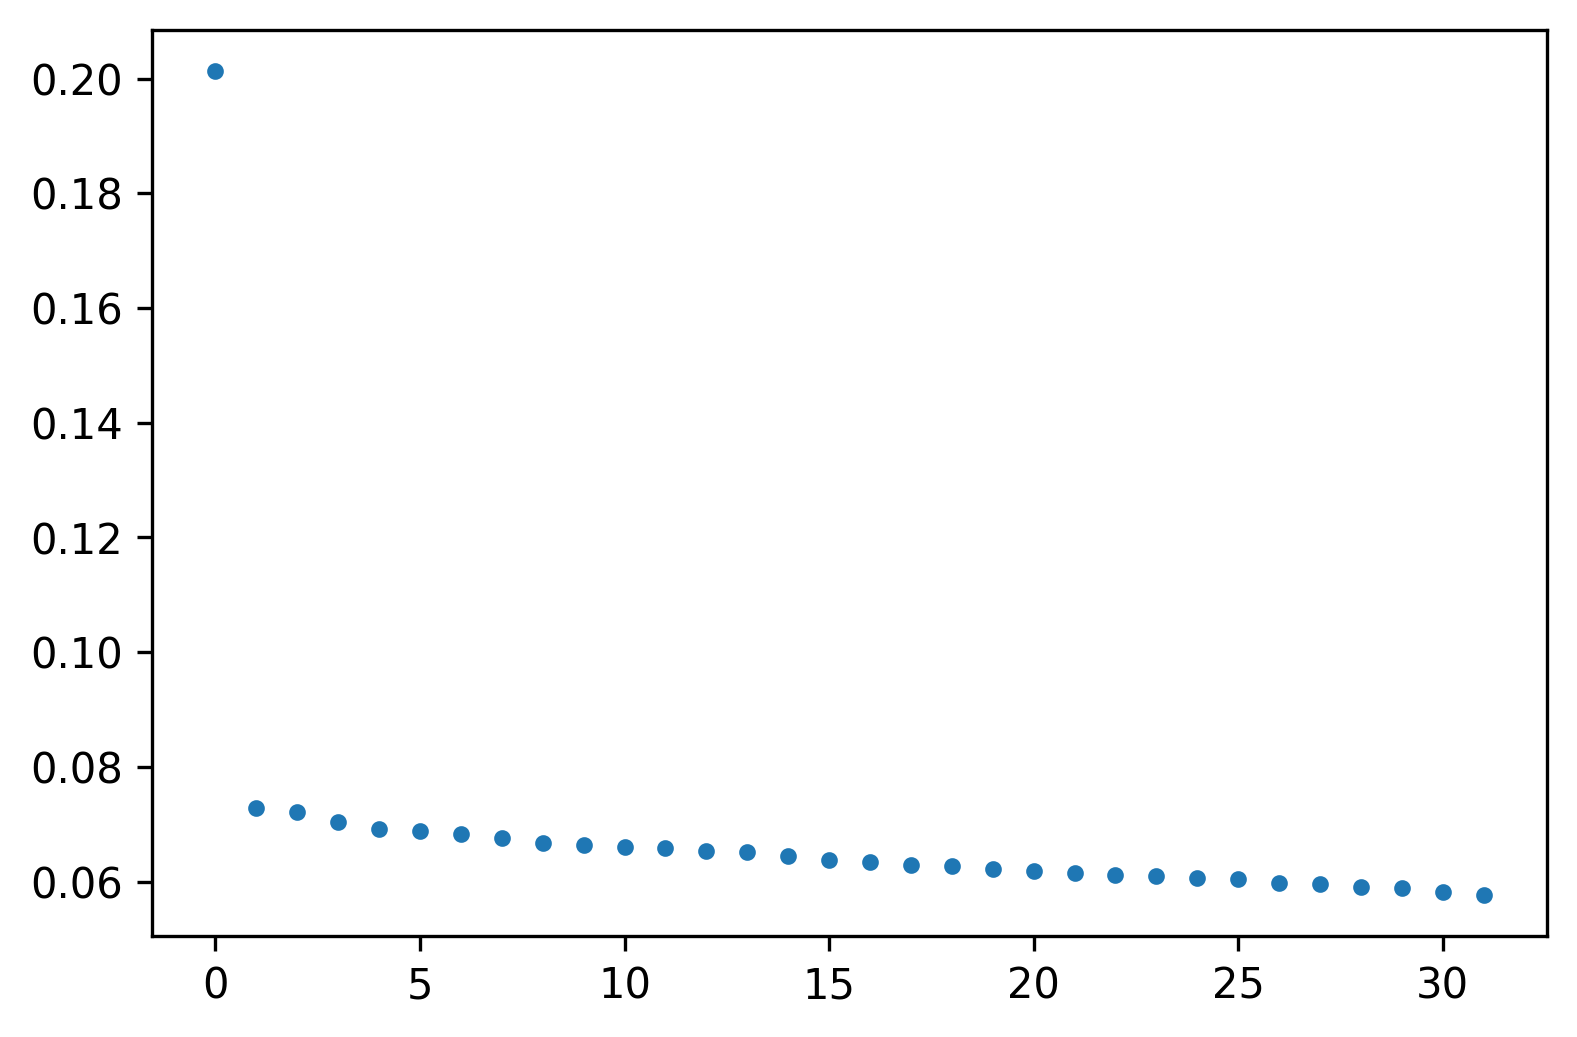

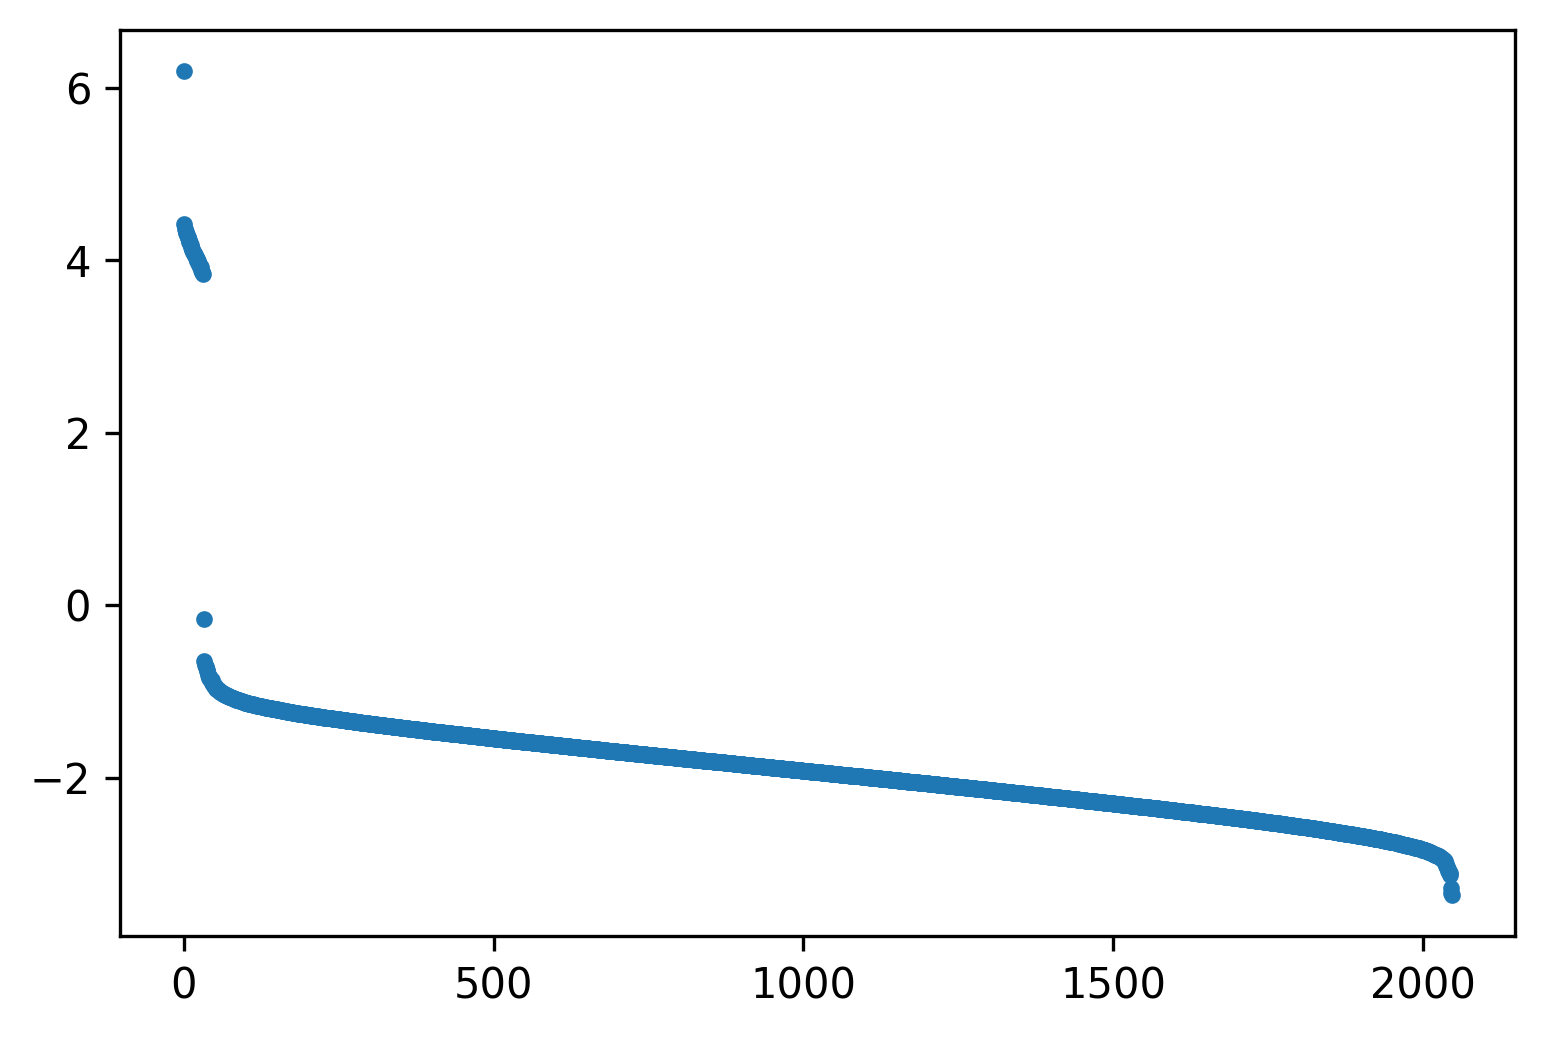

At  180 channels, alpha is 3.51718874293311
At  180 channels, RMSE/y_std is 0.0739629921613035
***************************  170  *************************
0:  |F(x)| = 0.0343533; step 1
1:  |F(x)| = 0.000632965; step 1
2:  |F(x)| = 6.67771e-05; step 1
3:  |F(x)| = 2.20728e-05; step 1
4:  |F(x)| = 8.64113e-06; step 1
5:  |F(x)| = 2.14849e-06; step 1


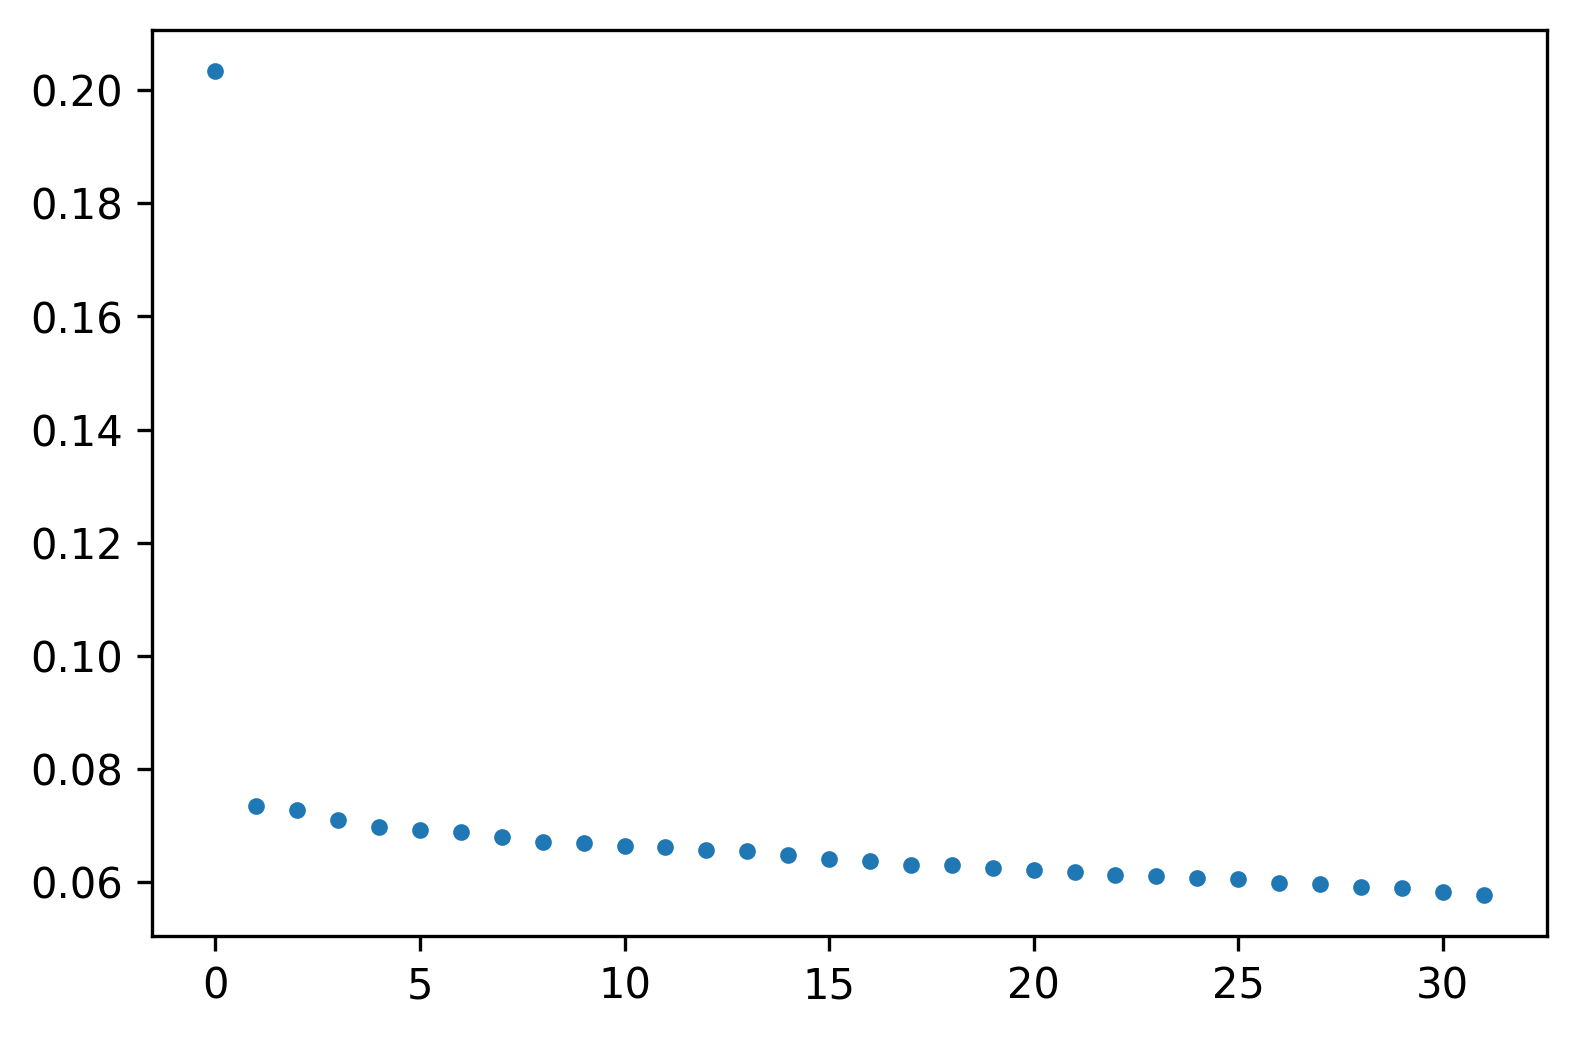

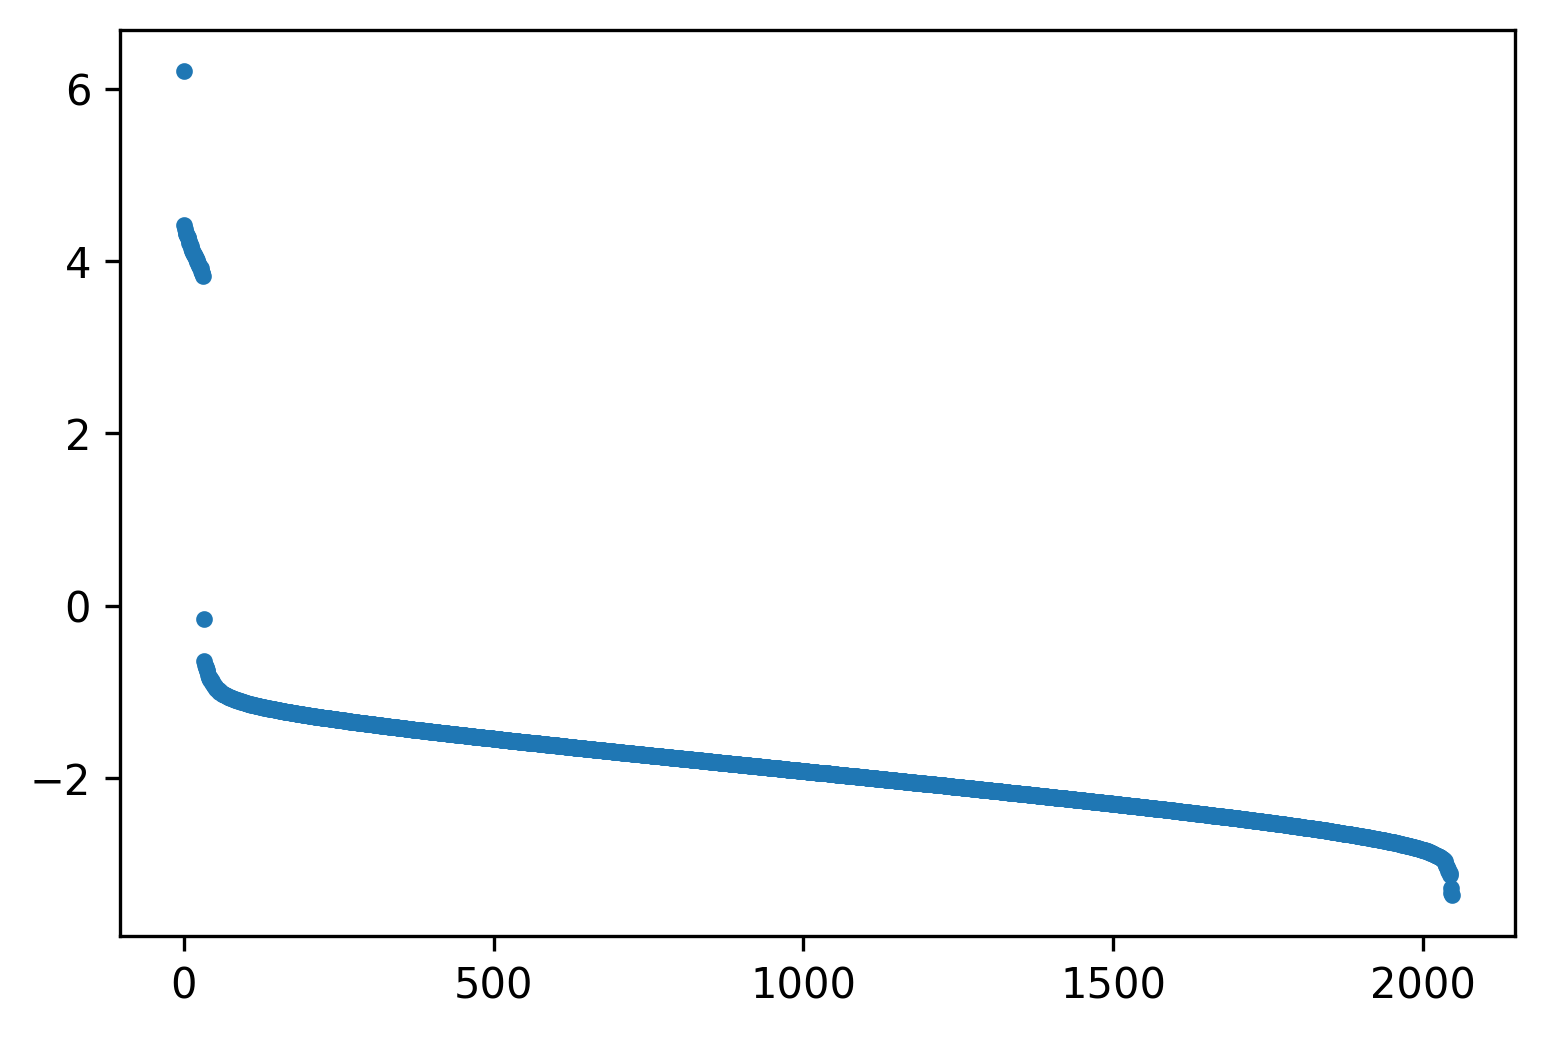

At  170 channels, alpha is 3.4441826279322623
At  170 channels, RMSE/y_std is 0.0737660791490894
***************************  160  *************************
0:  |F(x)| = 0.041243; step 1
1:  |F(x)| = 0.00168609; step 1
2:  |F(x)| = 7.06436e-05; step 1
3:  |F(x)| = 4.4099e-05; step 1
4:  |F(x)| = 9.45508e-06; step 1
5:  |F(x)| = 3.1655e-06; step 1


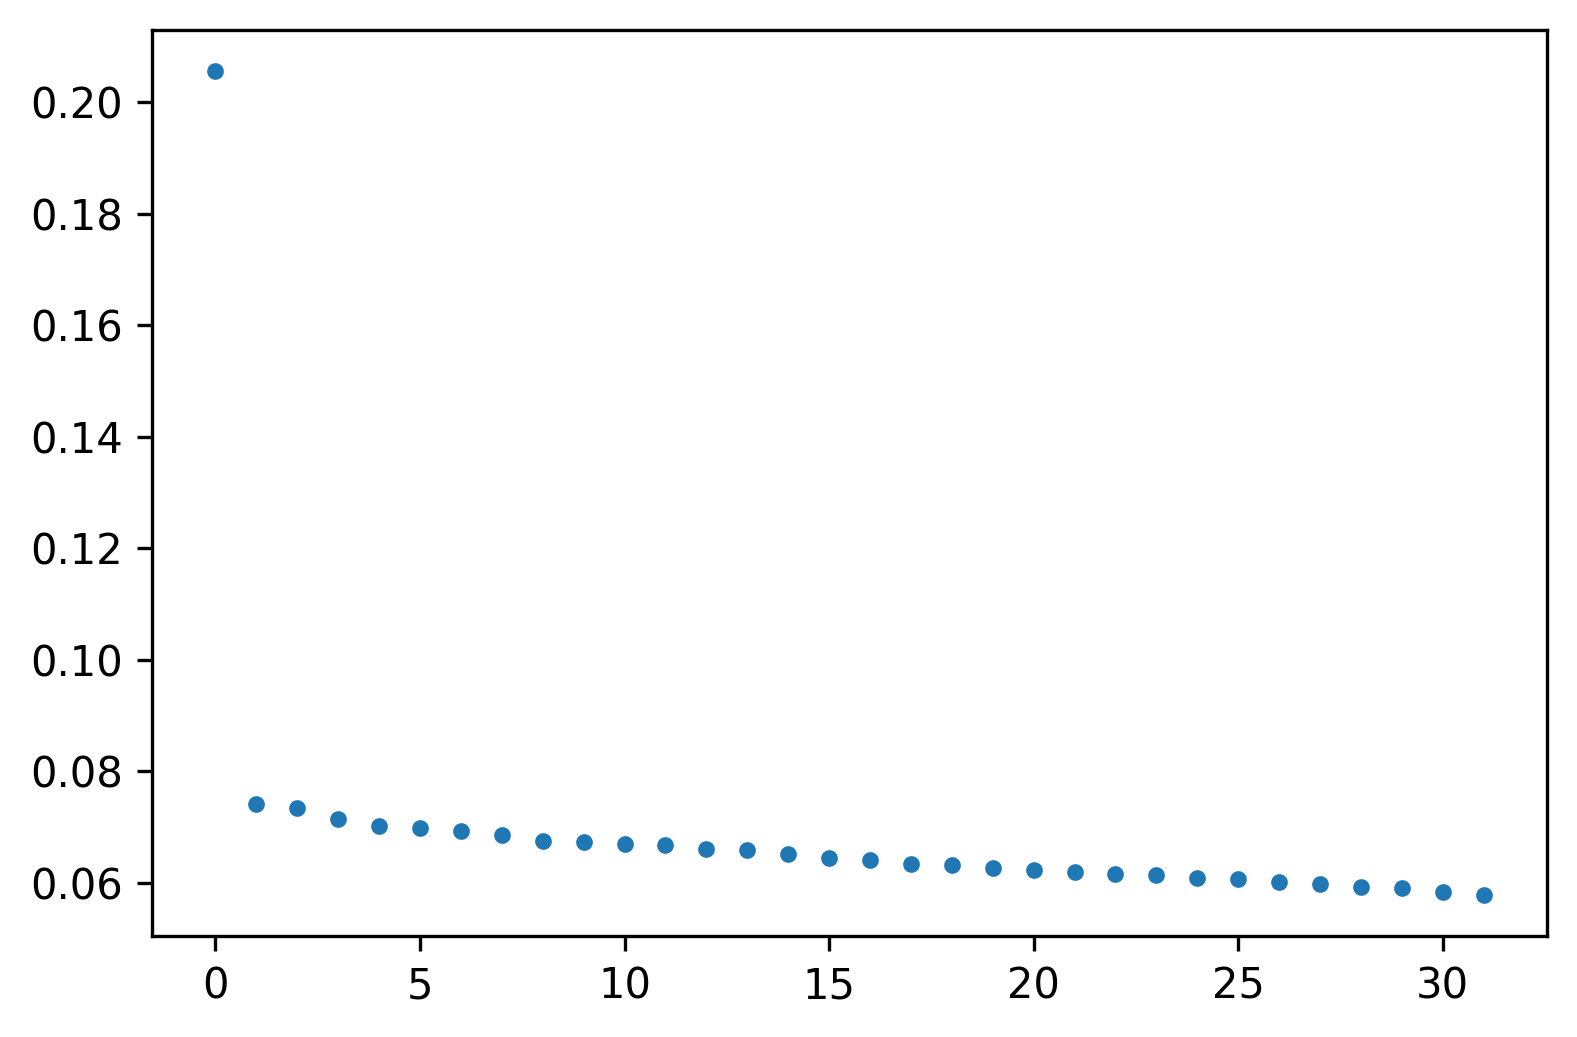

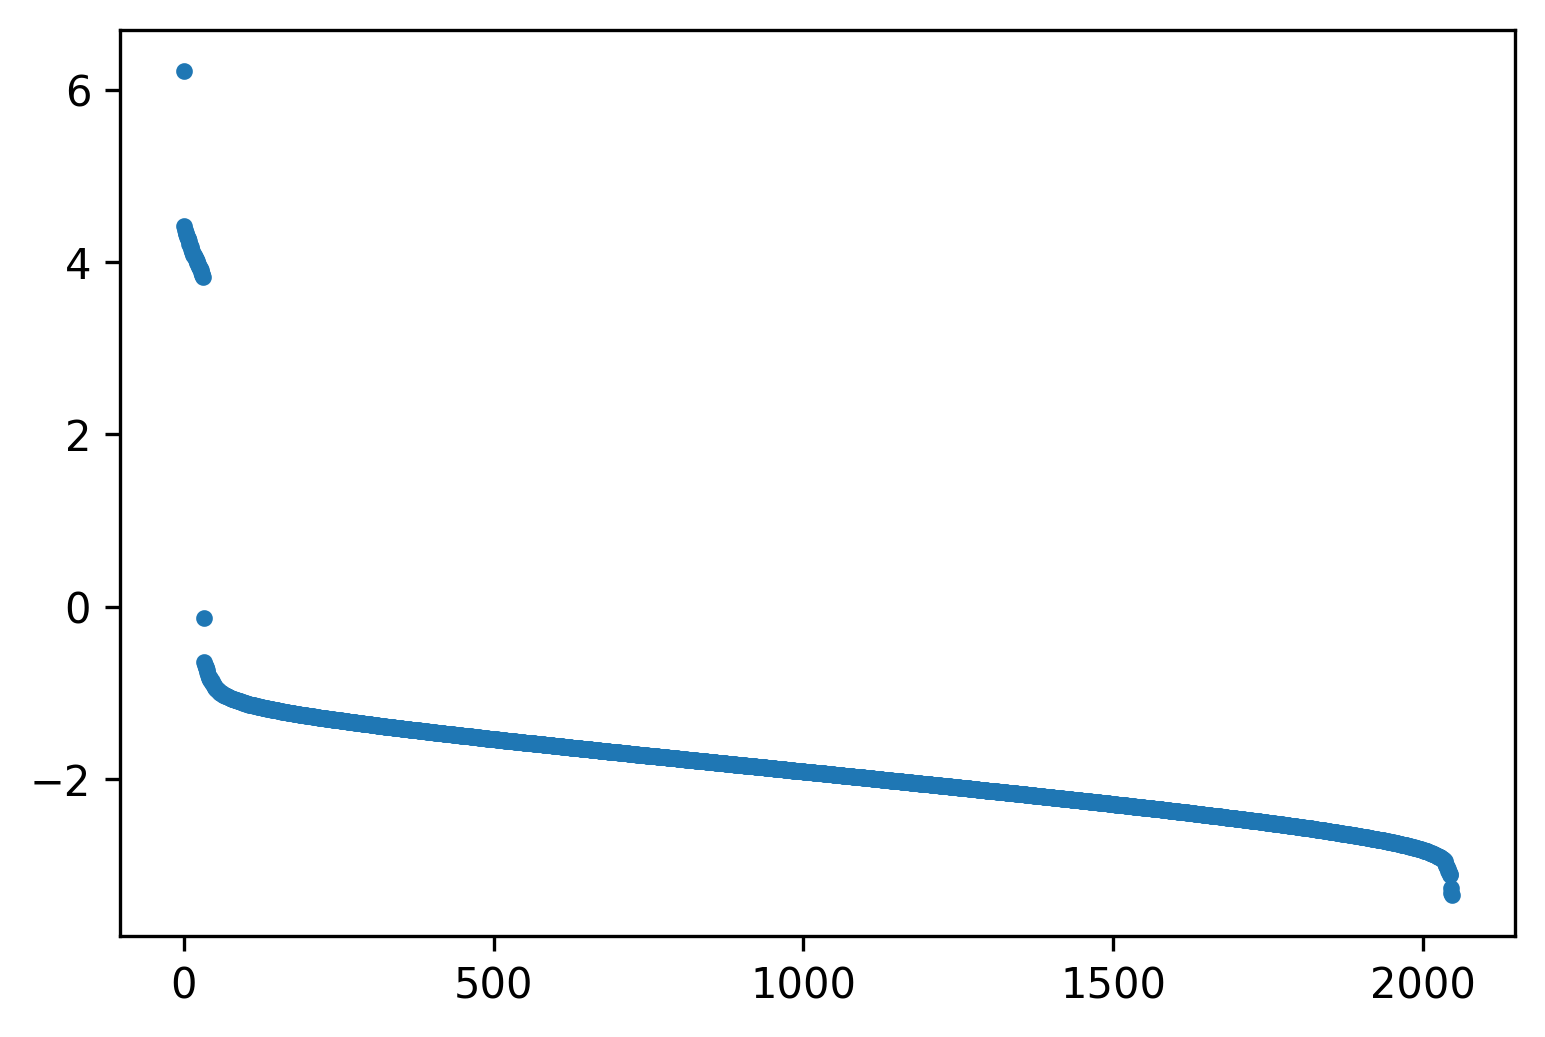

At  160 channels, alpha is 3.367785471975247
At  160 channels, RMSE/y_std is 0.07355673085545762
***************************  150  *************************
0:  |F(x)| = 0.0501452; step 1
1:  |F(x)| = 0.00192066; step 1
2:  |F(x)| = 9.38584e-05; step 1
3:  |F(x)| = 5.72033e-05; step 1
4:  |F(x)| = 1.26325e-05; step 1
5:  |F(x)| = 4.53858e-06; step 1


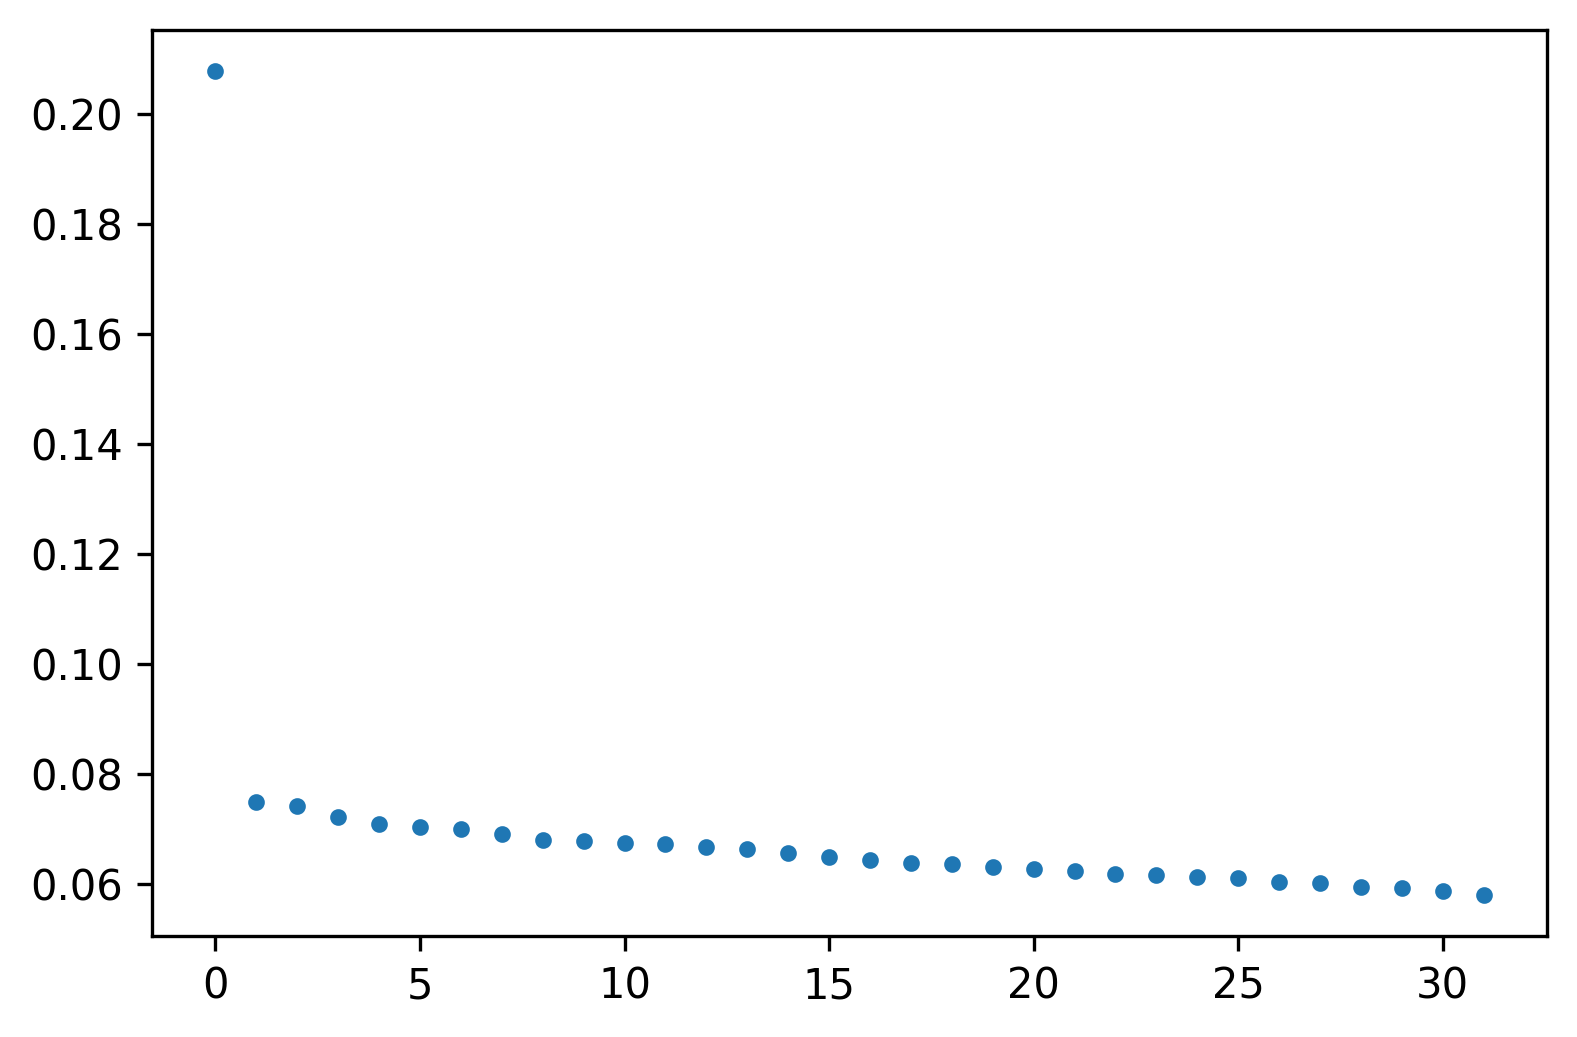

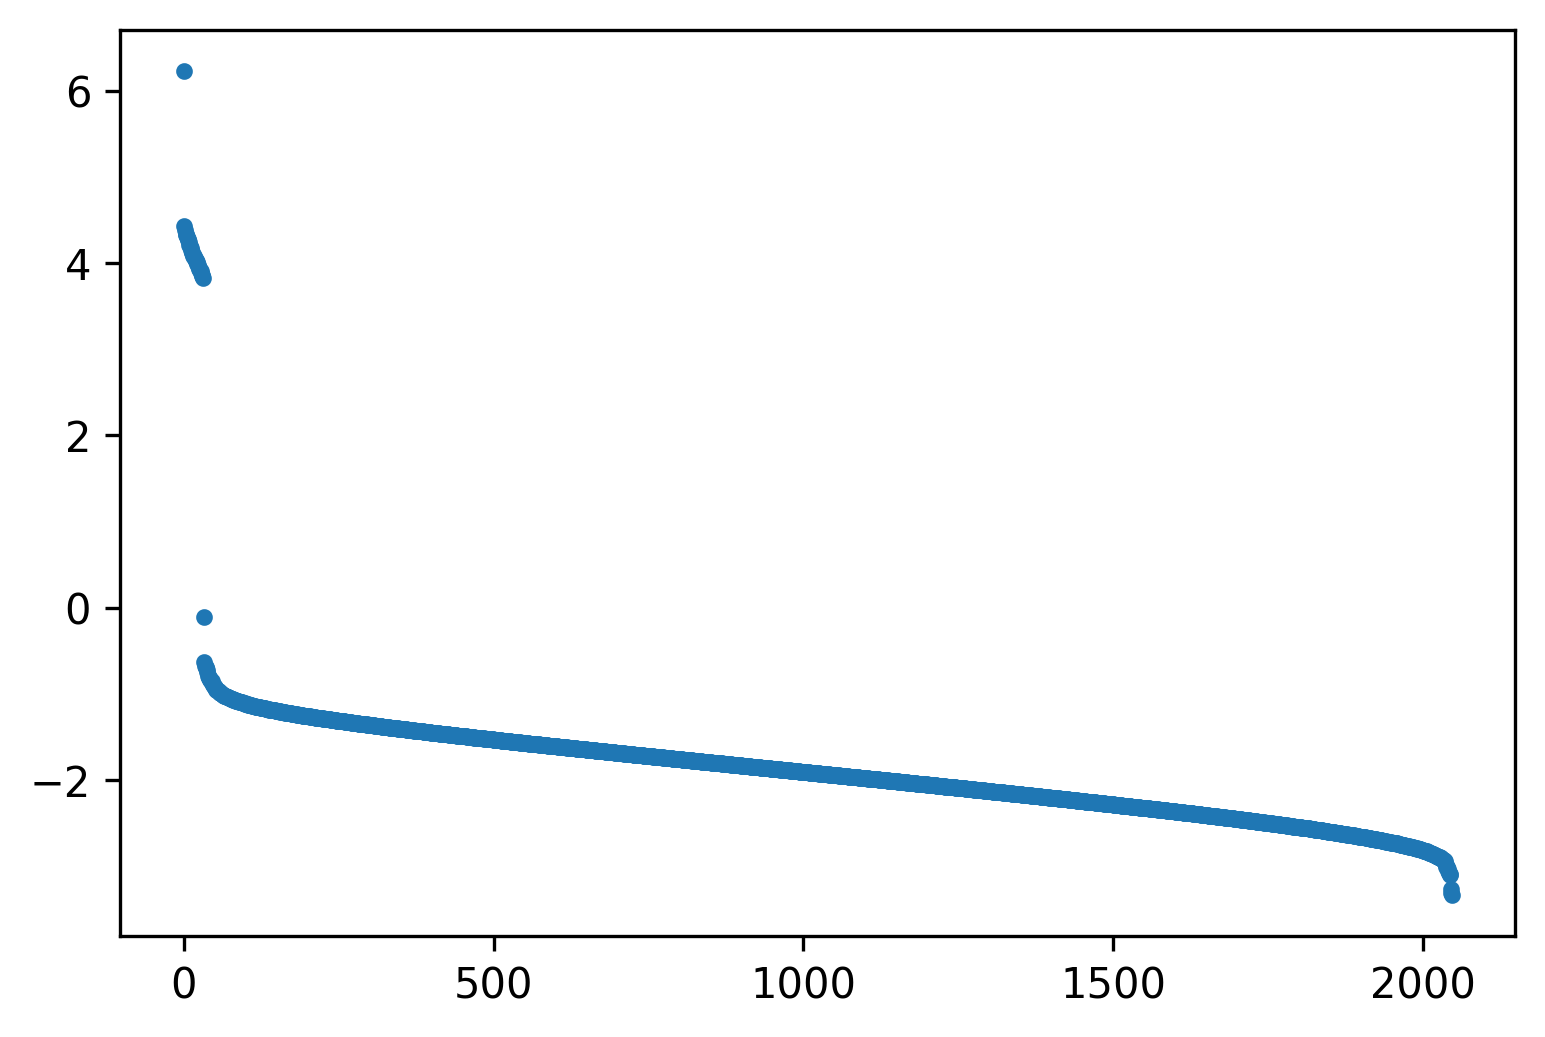

At  150 channels, alpha is 3.2875640167363462
At  150 channels, RMSE/y_std is 0.07333463321652779
***************************  140  *************************
0:  |F(x)| = 0.0618105; step 1
1:  |F(x)| = 0.00172259; step 1
2:  |F(x)| = 0.00146512; step 1
3:  |F(x)| = 0.00146513; step 1
4:  |F(x)| = 0.00146513; step 1
5:  |F(x)| = 0.00146513; step 1
6:  |F(x)| = 0.00146513; step 1
7:  |F(x)| = 0.00146513; step 1
8:  |F(x)| = 0.00146513; step 1
9:  |F(x)| = 0.00146513; step 1
10:  |F(x)| = 0.00146513; step 1
11:  |F(x)| = 0.00146513; step 1
12:  |F(x)| = 0.00146513; step 1
13:  |F(x)| = 0.00146636; step 1
14:  |F(x)| = 0.00146625; step 1
15:  |F(x)| = 0.00146644; step 0.49997
16:  |F(x)| = 0.00146627; step 1
17:  |F(x)| = 0.00146632; step 1
18:  |F(x)| = 0.00146643; step 1
19:  |F(x)| = 0.00146637; step 1
20:  |F(x)| = 0.00146642; step 0.500014
21:  |F(x)| = 0.000852465; step 1
22:  |F(x)| = 0.00046456; step 1
23:  |F(x)| = 0.000258132; step 1
24:  |F(x)| = 0.000239084; step 1
25:  |F(x)| 

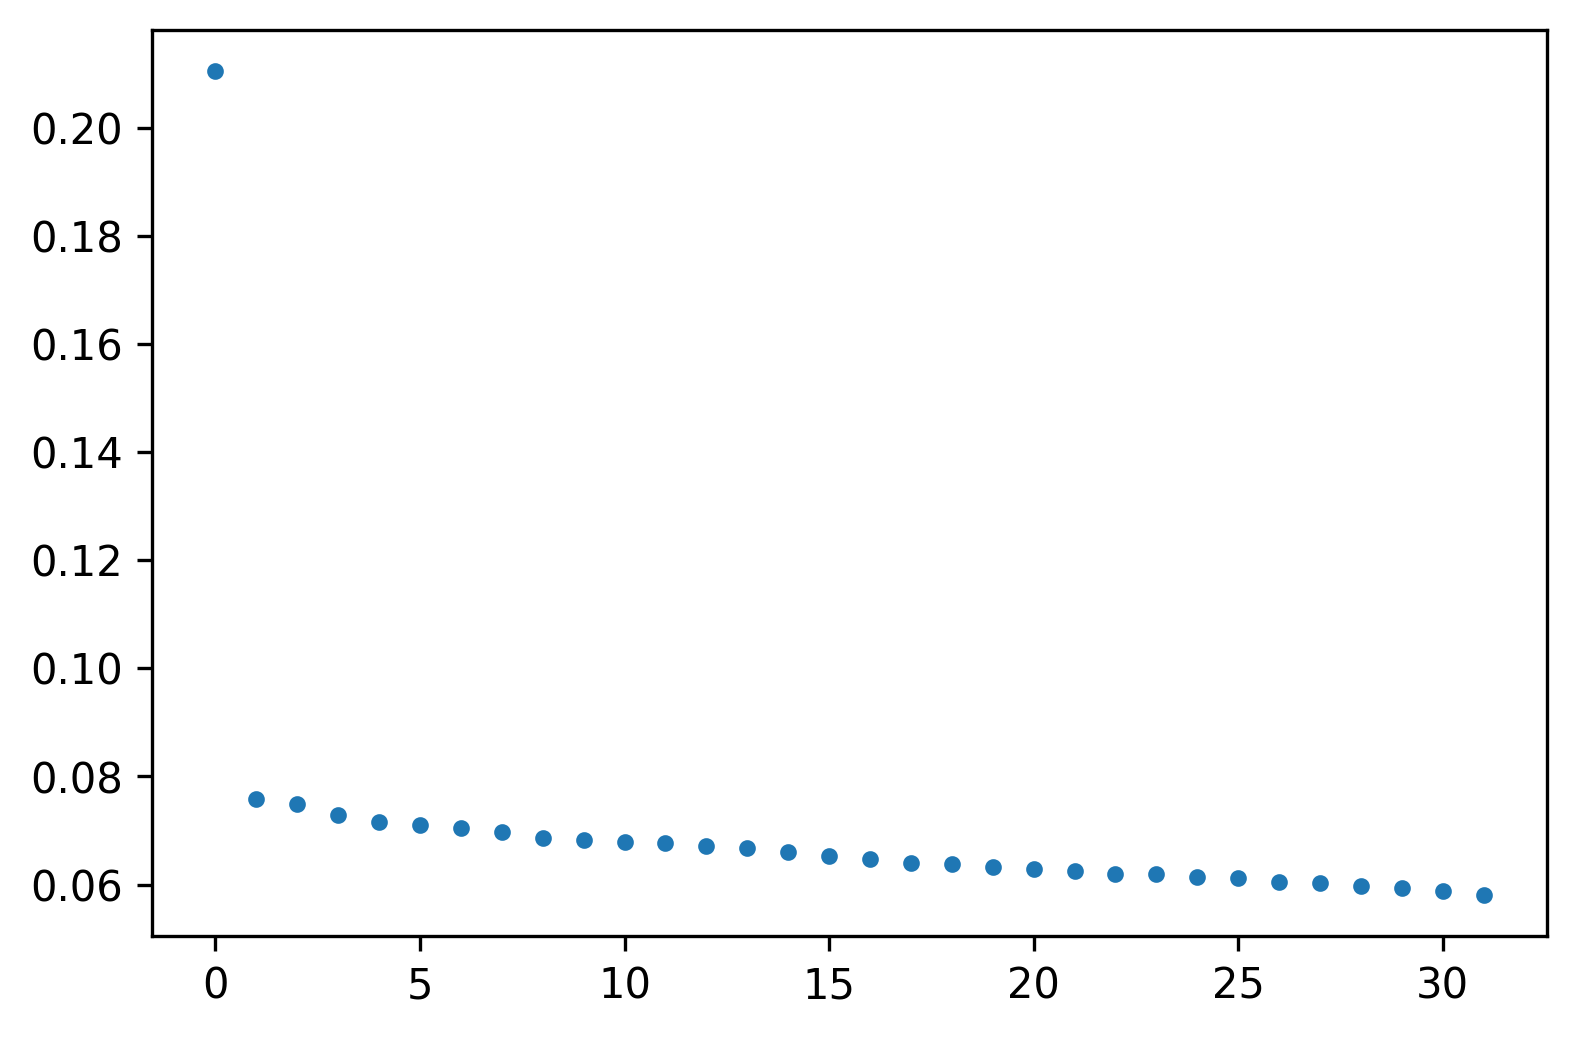

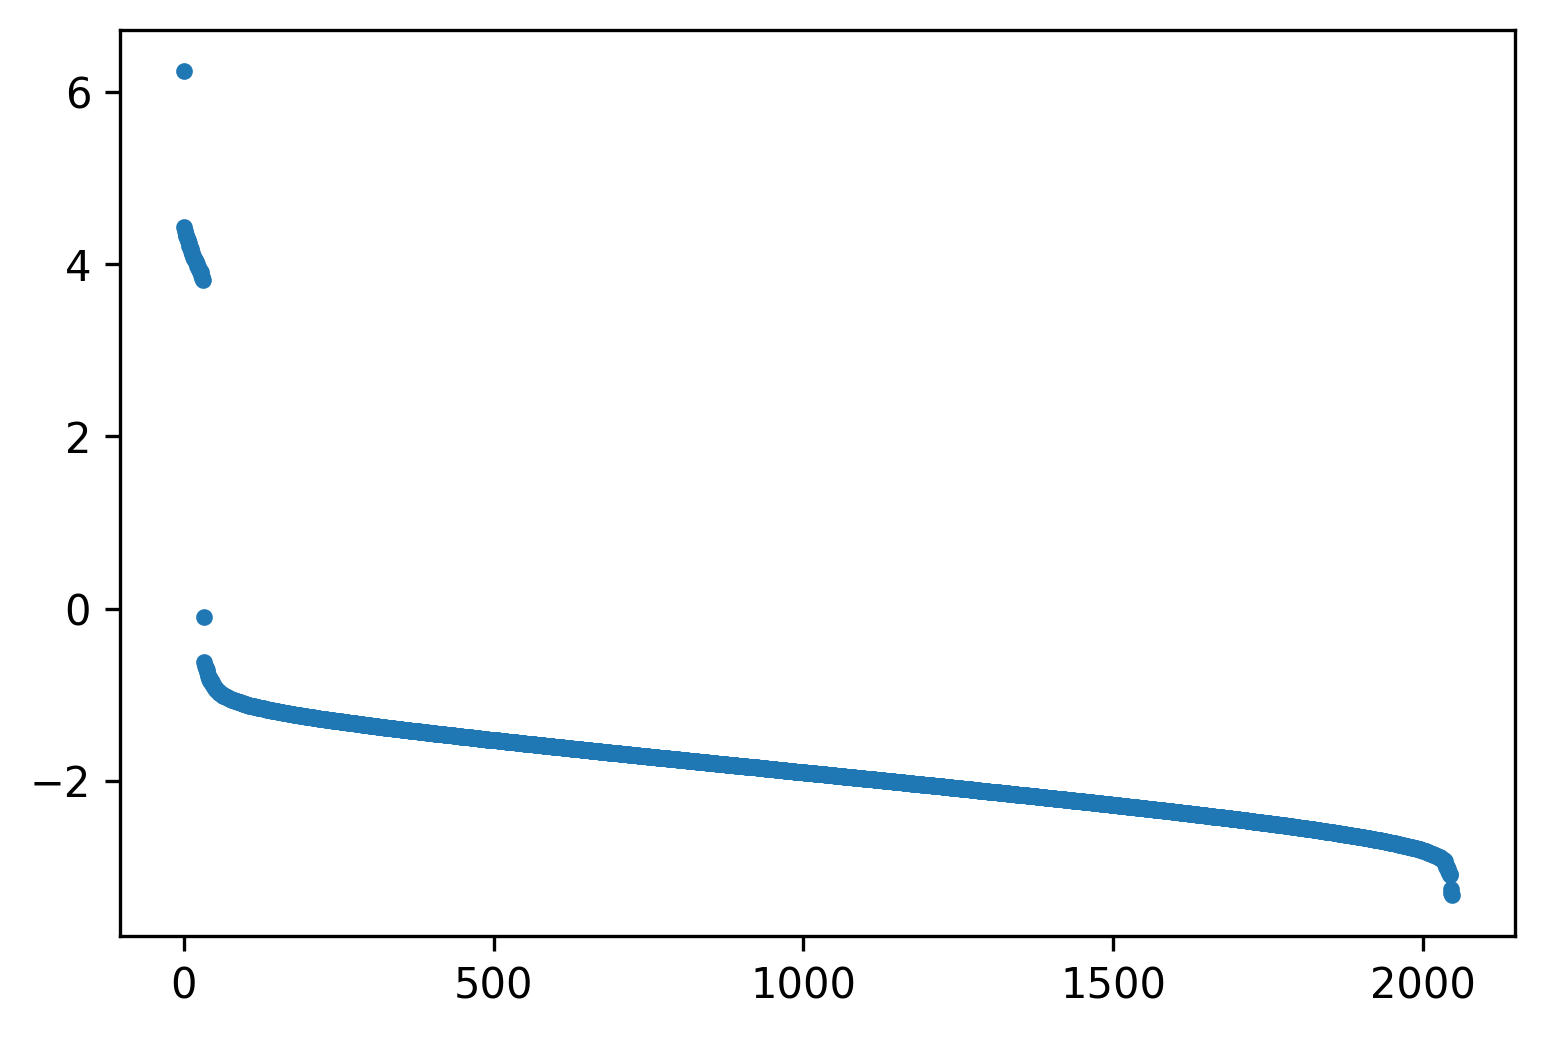

At  140 channels, alpha is 3.2028525715856544
At  140 channels, RMSE/y_std is 0.07309978568332413
***************************  130  *************************
0:  |F(x)| = 0.0775821; step 1
1:  |F(x)| = 0.00251312; step 1
2:  |F(x)| = 0.0019713; step 1
3:  |F(x)| = 0.00197675; step 1
4:  |F(x)| = 0.00197675; step 1
5:  |F(x)| = 0.00197675; step 1
6:  |F(x)| = 0.00197675; step 1
7:  |F(x)| = 0.00197675; step 1
8:  |F(x)| = 0.00197675; step 1
9:  |F(x)| = 0.00197675; step 1
10:  |F(x)| = 0.00197676; step 1
11:  |F(x)| = 0.00197676; step 1
12:  |F(x)| = 0.00197675; step 1
13:  |F(x)| = 0.00197676; step 1
14:  |F(x)| = 0.00197838; step 1
15:  |F(x)| = 0.00197675; step 1
16:  |F(x)| = 0.00197675; step 1
17:  |F(x)| = 0.00194; step 1
18:  |F(x)| = 0.00197675; step 1
19:  |F(x)| = 0.00199052; step 0.211073
20:  |F(x)| = 0.00196837; step 1
21:  |F(x)| = 0.00196851; step 1
22:  |F(x)| = 0.0017895; step 1
23:  |F(x)| = 0.00207614; step 0.475412
24:  |F(x)| = 0.00204607; step 1
25:  |F(x)| = 0.001

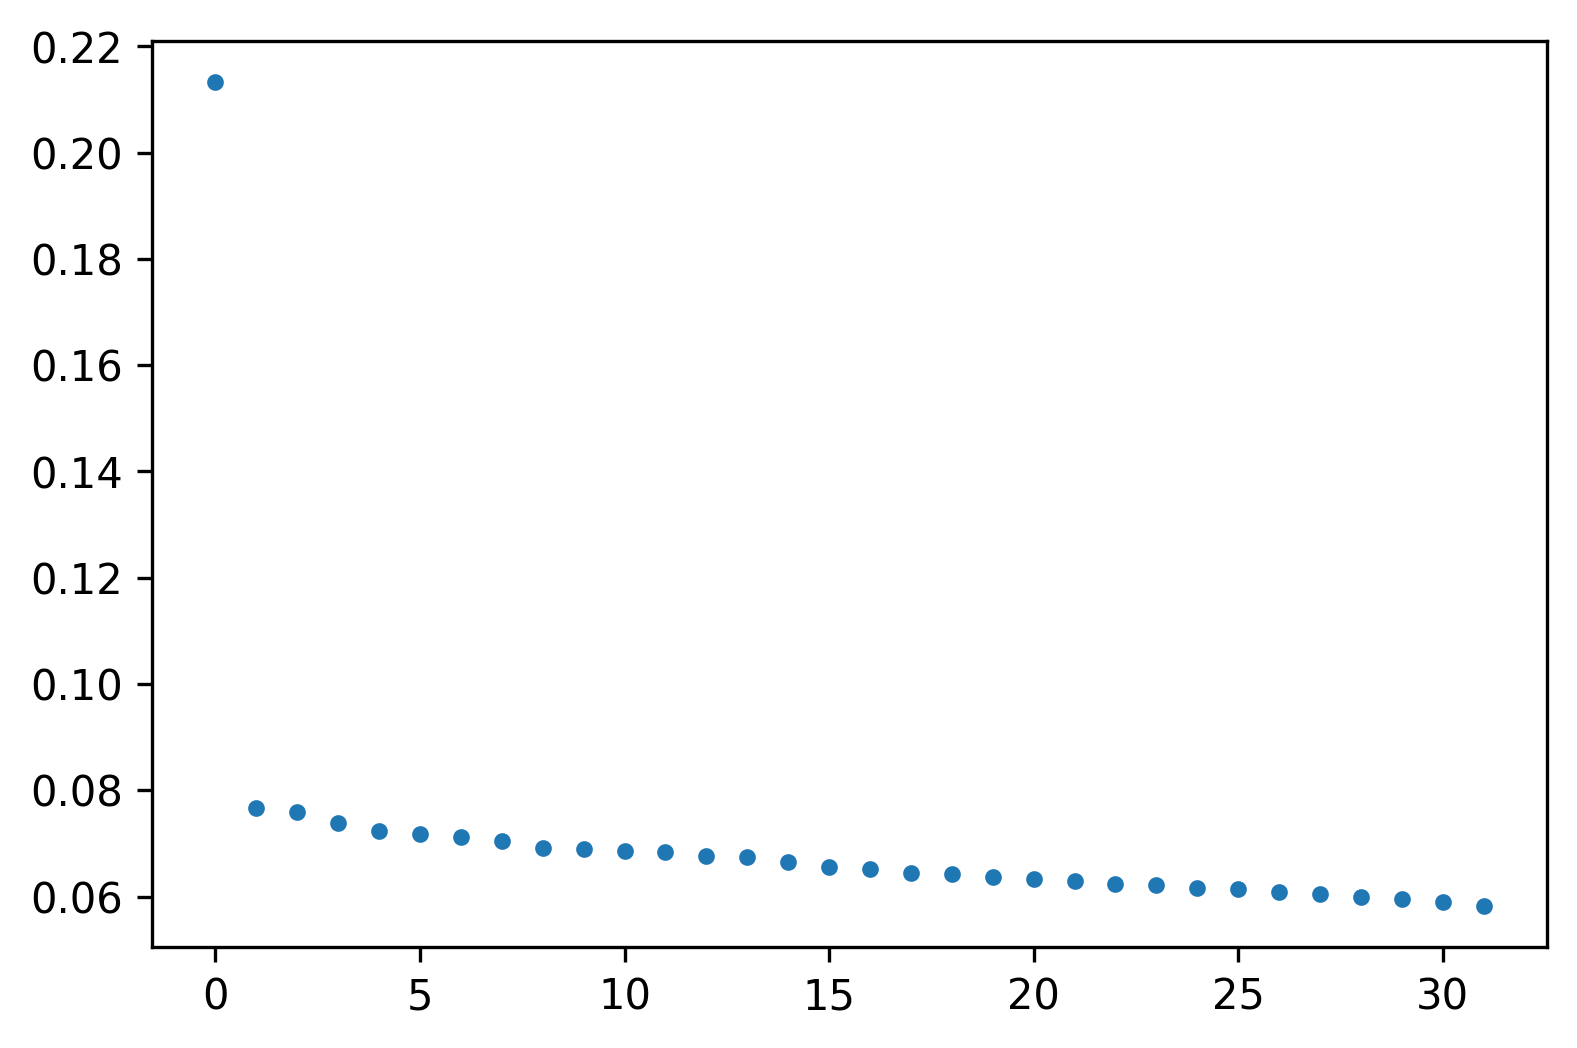

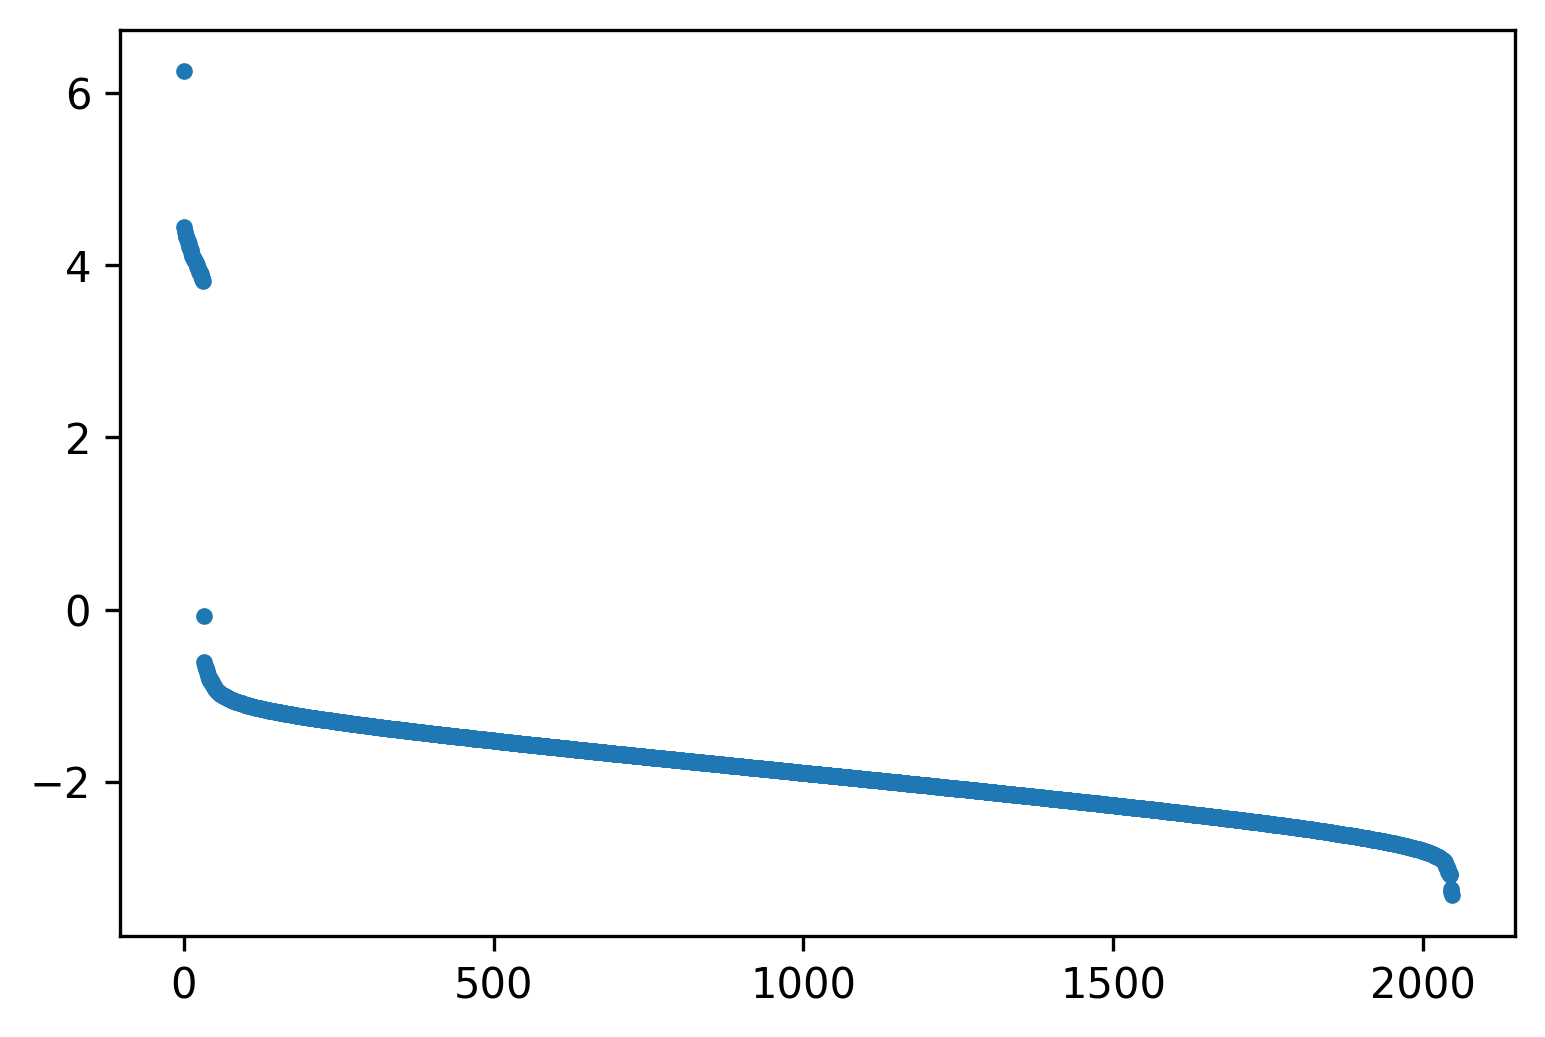

At  130 channels, alpha is 3.1132416982829025
At  130 channels, RMSE/y_std is 0.07284844764681955
***************************  120  *************************
0:  |F(x)| = 0.0992907; step 1
1:  |F(x)| = 0.00379356; step 1
2:  |F(x)| = 0.00283432; step 1
3:  |F(x)| = 0.00284915; step 1
4:  |F(x)| = 0.00284914; step 1
5:  |F(x)| = 0.00284915; step 1
6:  |F(x)| = 0.00284916; step 1
7:  |F(x)| = 0.00284915; step 1
8:  |F(x)| = 0.00284916; step 1
9:  |F(x)| = 0.00284916; step 1
10:  |F(x)| = 0.00284915; step 1
11:  |F(x)| = 0.00284915; step 1
12:  |F(x)| = 0.00284915; step 1
13:  |F(x)| = 0.00256371; step 1
14:  |F(x)| = 0.0027109; step 1
15:  |F(x)| = 0.00284915; step 1
16:  |F(x)| = 0.00250322; step 1
17:  |F(x)| = 0.00257007; step 1
18:  |F(x)| = 0.00284911; step 1
19:  |F(x)| = 0.00266857; step 1
20:  |F(x)| = 0.00284916; step 1
21:  |F(x)| = 0.00284915; step 1
22:  |F(x)| = 0.00301099; step 1
23:  |F(x)| = 0.00277838; step 0.155335
24:  |F(x)| = 0.00243168; step 1
25:  |F(x)| = 0.002854

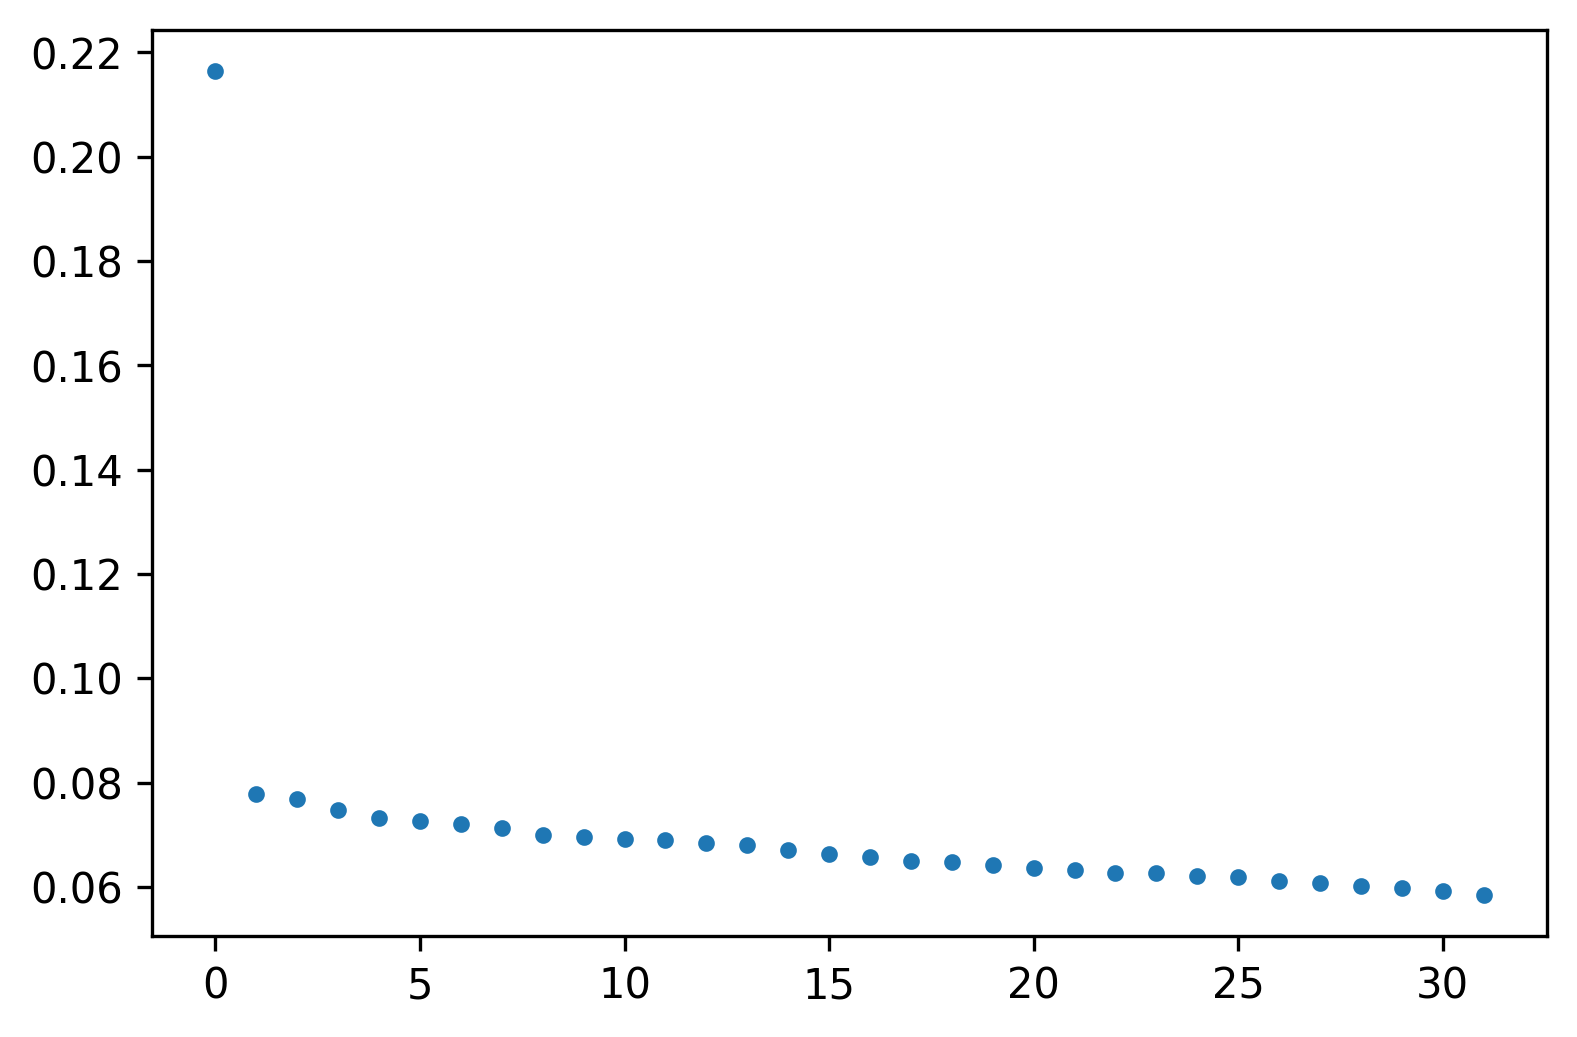

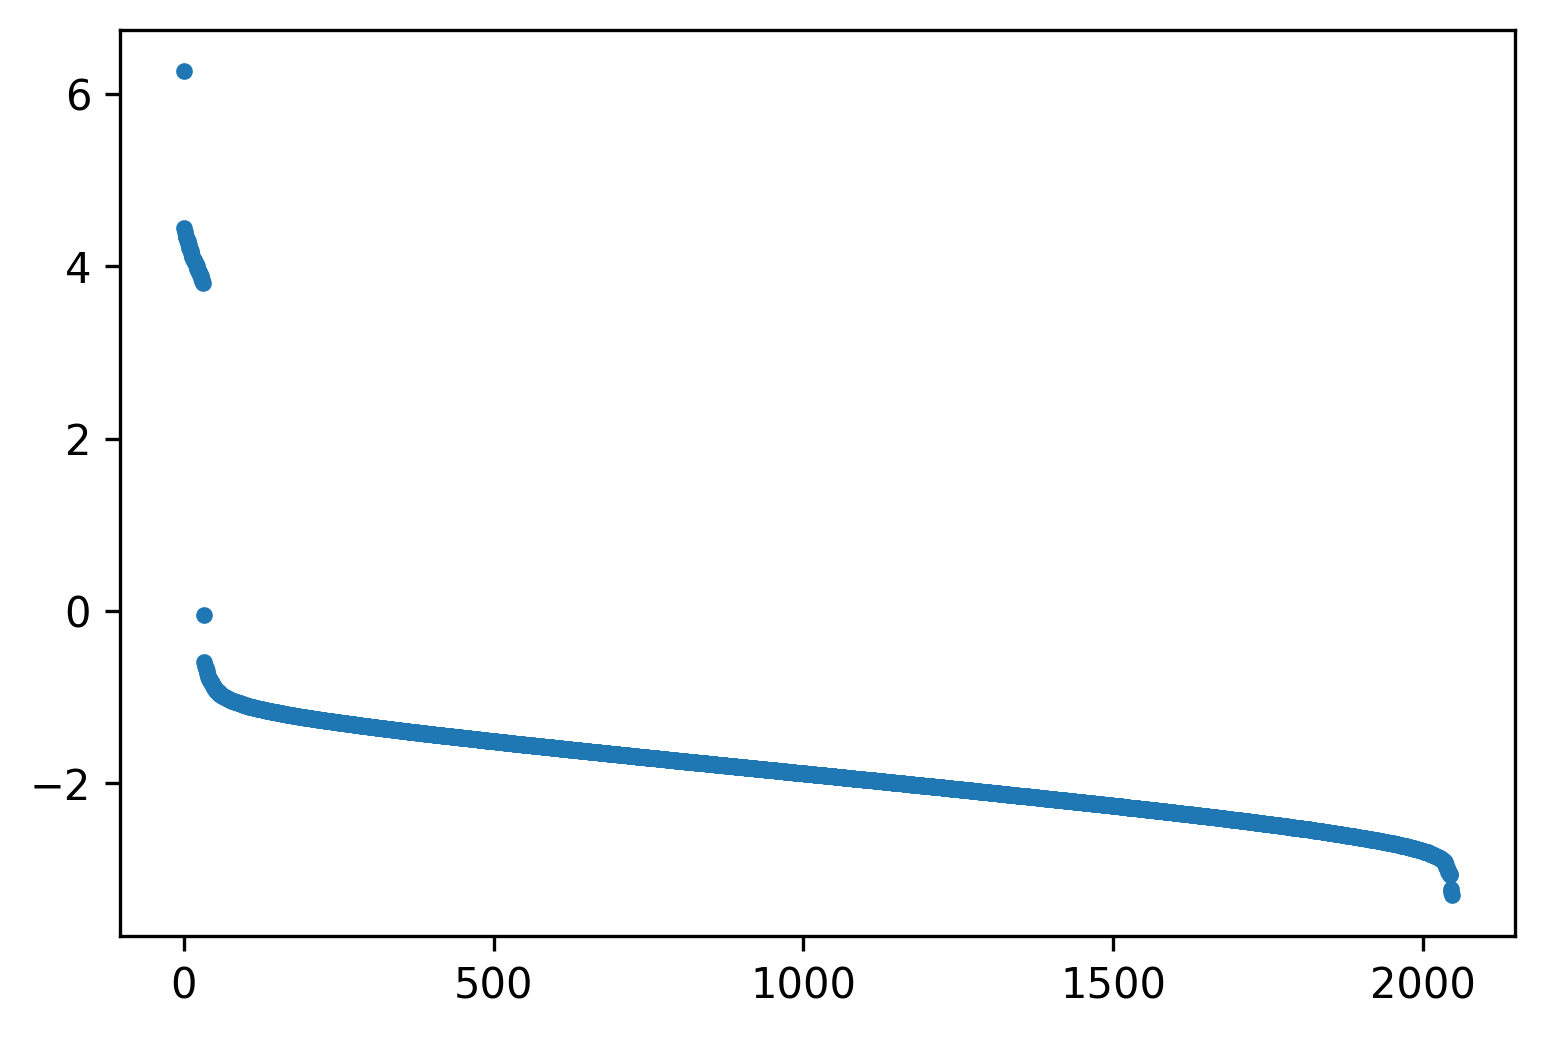

At  120 channels, alpha is 3.0178298565752213
At  120 channels, RMSE/y_std is 0.07258253366852503
***************************  110  *************************
0:  |F(x)| = 0.130376; step 1
1:  |F(x)| = 0.00603572; step 1
2:  |F(x)| = 0.00419019; step 1
3:  |F(x)| = 0.00423302; step 1
4:  |F(x)| = 0.00423299; step 1
5:  |F(x)| = 0.004233; step 1
6:  |F(x)| = 0.004233; step 1
7:  |F(x)| = 0.00423301; step 1
8:  |F(x)| = 0.00423301; step 1
9:  |F(x)| = 0.004233; step 1
10:  |F(x)| = 0.004233; step 1
11:  |F(x)| = 0.00423299; step 1
12:  |F(x)| = 0.004233; step 1
13:  |F(x)| = 0.00403926; step 1
14:  |F(x)| = 0.00434037; step 1
15:  |F(x)| = 0.00527961; step 1
16:  |F(x)| = 0.00411208; step 1
17:  |F(x)| = 0.00439747; step 1
18:  |F(x)| = 0.00439746; step 1
19:  |F(x)| = 0.00439749; step 1
20:  |F(x)| = 0.00458704; step 1
21:  |F(x)| = 0.00429019; step 0.161979
22:  |F(x)| = 0.00447876; step 0.195548
23:  |F(x)| = 0.00180502; step 1
24:  |F(x)| = 0.000875049; step 1
25:  |F(x)| = 0.00083661

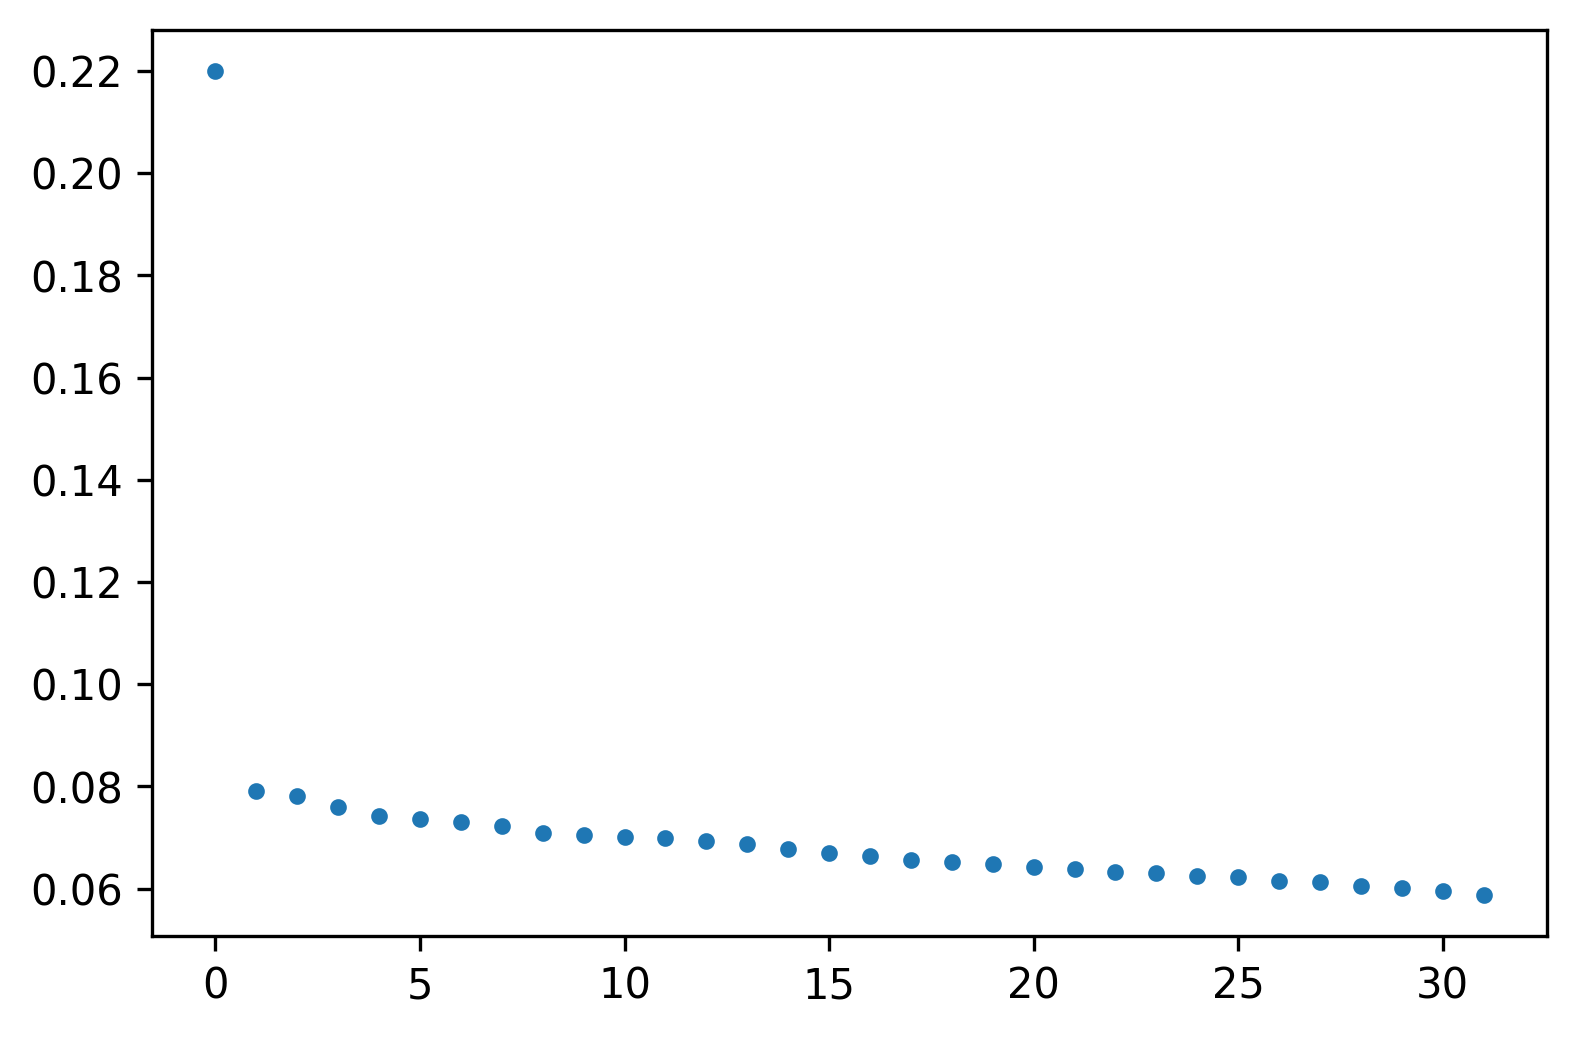

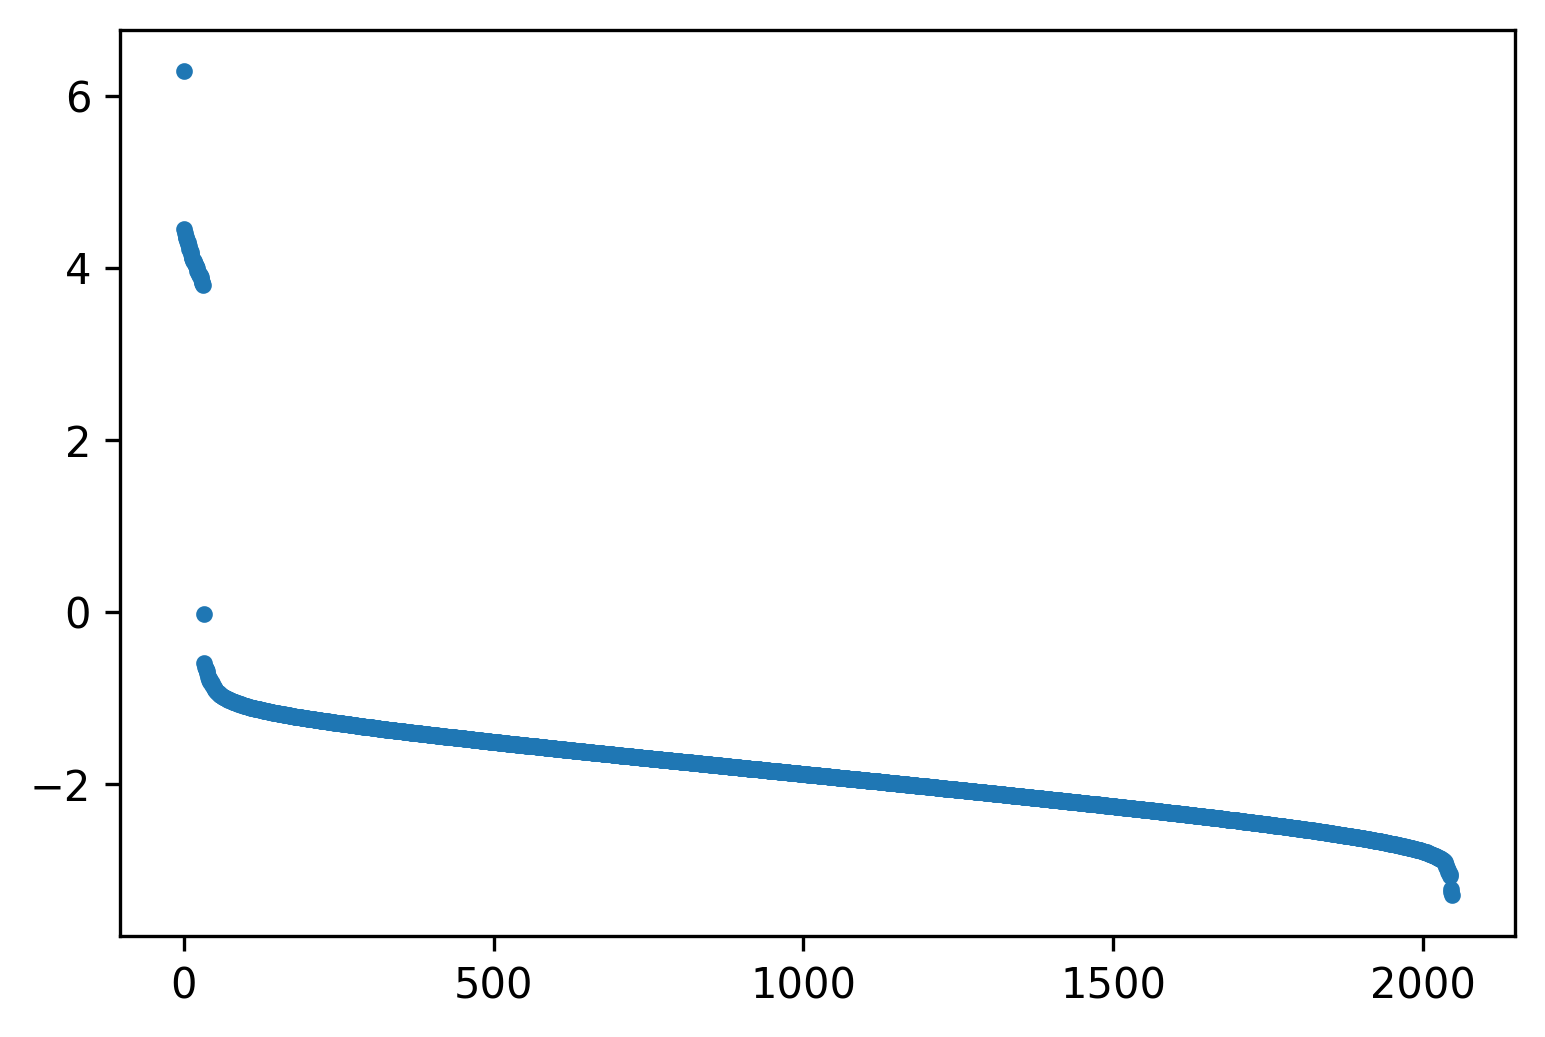

At  110 channels, alpha is 2.9157077739813237
At  110 channels, RMSE/y_std is 0.07230016116457545
***************************  100  *************************
0:  |F(x)| = 0.176889; step 1
1:  |F(x)| = 0.0103287; step 1
2:  |F(x)| = 0.00651839; step 1
3:  |F(x)| = 0.00665386; step 1
4:  |F(x)| = 0.00665386; step 1
5:  |F(x)| = 0.00665384; step 1
6:  |F(x)| = 0.00665387; step 1
7:  |F(x)| = 0.00665385; step 1
8:  |F(x)| = 0.00665388; step 1
9:  |F(x)| = 0.00665386; step 1
10:  |F(x)| = 0.00665386; step 1
11:  |F(x)| = 0.00665387; step 1
12:  |F(x)| = 0.00665386; step 1
13:  |F(x)| = 0.00651836; step 1
14:  |F(x)| = 0.00665386; step 1
15:  |F(x)| = 0.00610493; step 1
16:  |F(x)| = 0.00682204; step 0.486988
17:  |F(x)| = 0.00664039; step 0.207168
18:  |F(x)| = 0.00654598; step 1
19:  |F(x)| = 0.00664354; step 1
20:  |F(x)| = 0.00665385; step 1
21:  |F(x)| = 0.005596; step 1
22:  |F(x)| = 0.00729522; step 1
23:  |F(x)| = 0.00618695; step 0.430855
24:  |F(x)| = 0.00506581; step 1
25:  |F(x)|

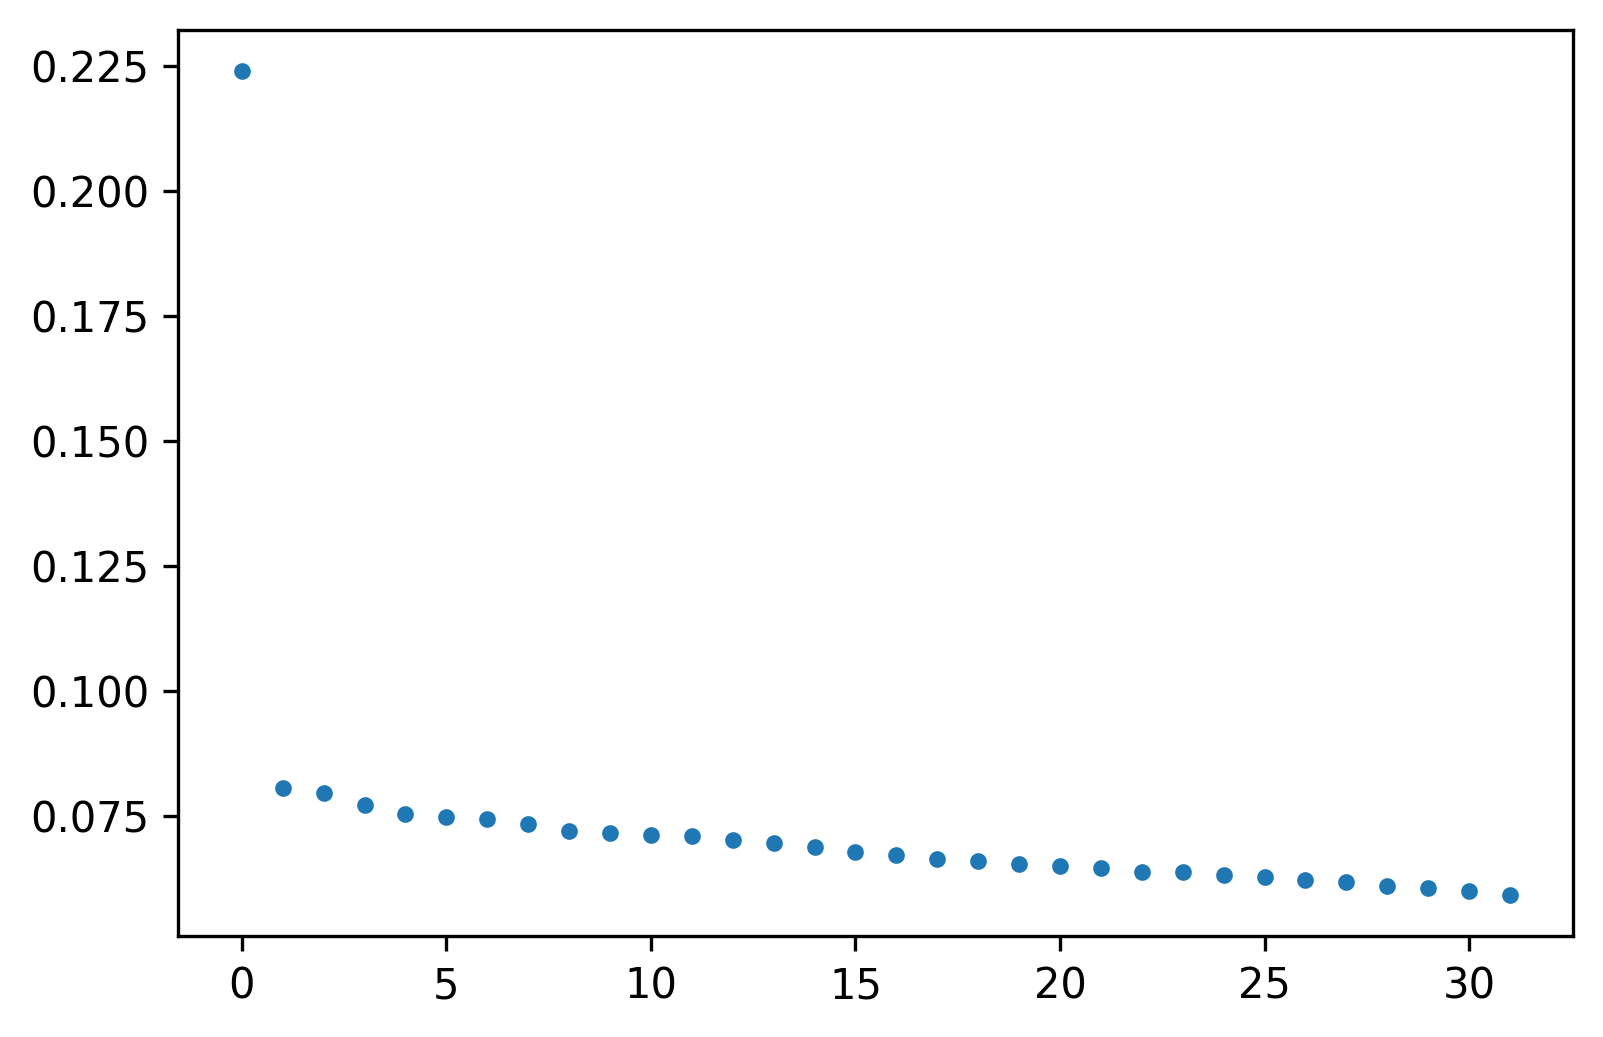

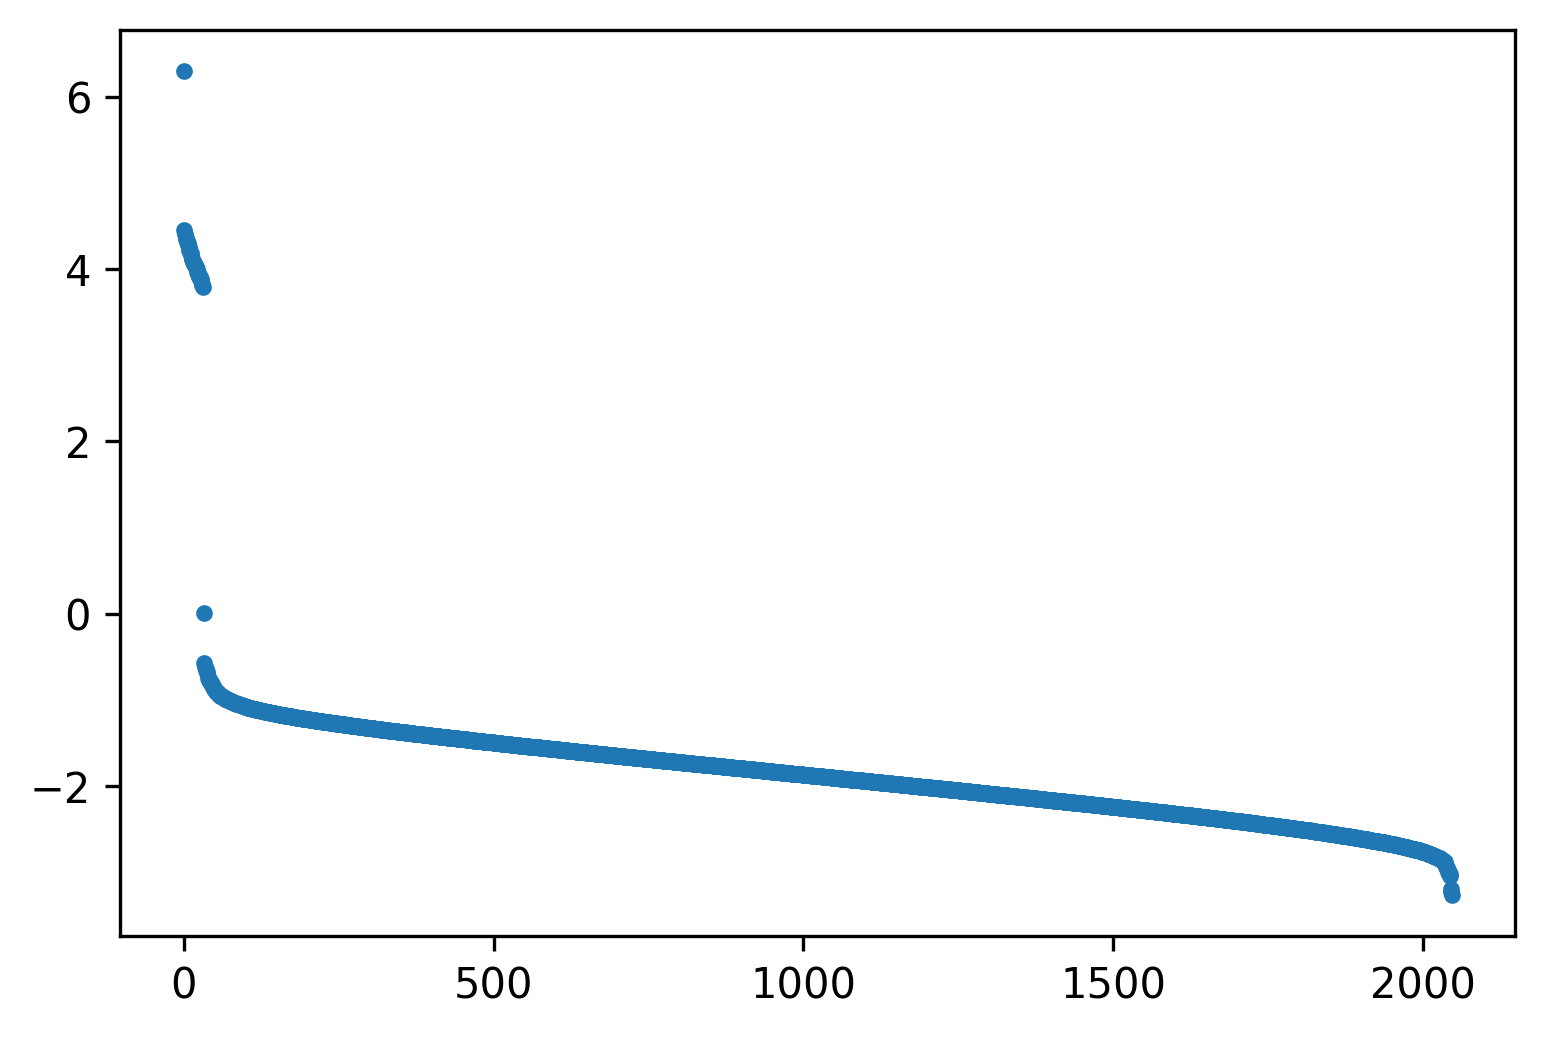

At  100 channels, alpha is 2.80602896997857
At  100 channels, RMSE/y_std is 0.07199820176232657
***************************  95  *************************
0:  |F(x)| = 0.0493666; step 1
1:  |F(x)| = 0.00132165; step 1
2:  |F(x)| = 0.000113548; step 1
3:  |F(x)| = 4.77207e-05; step 1
4:  |F(x)| = 1.15548e-05; step 1
5:  |F(x)| = 5.75642e-06; step 1


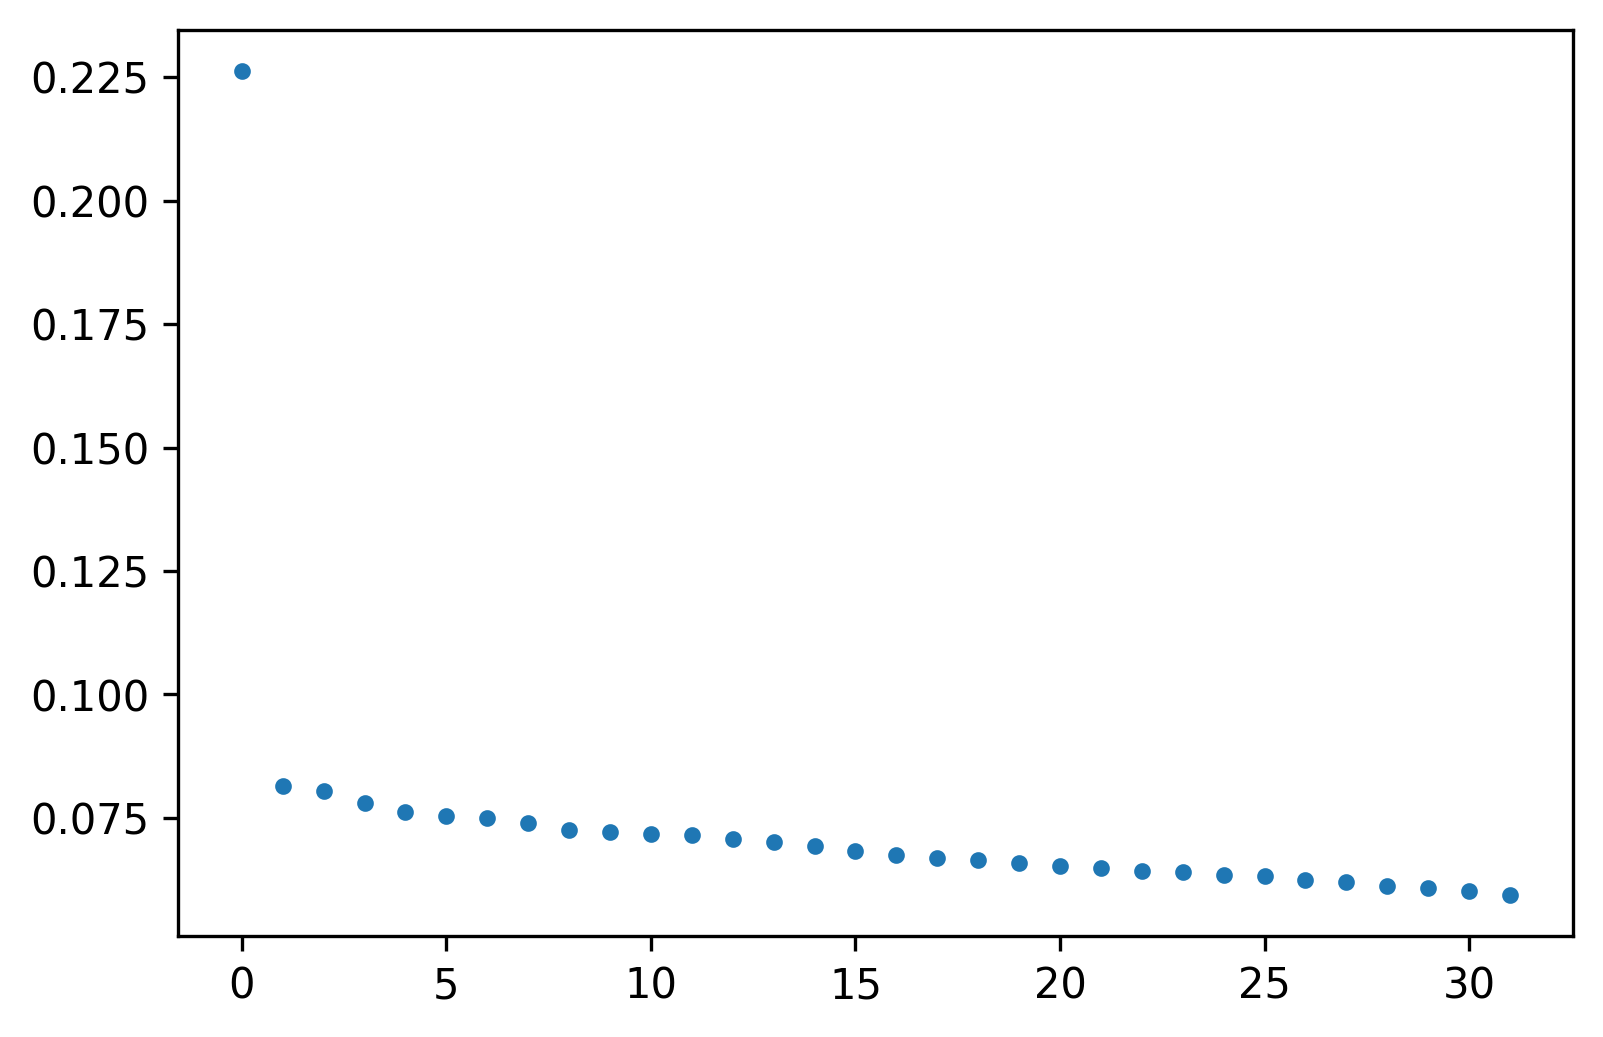

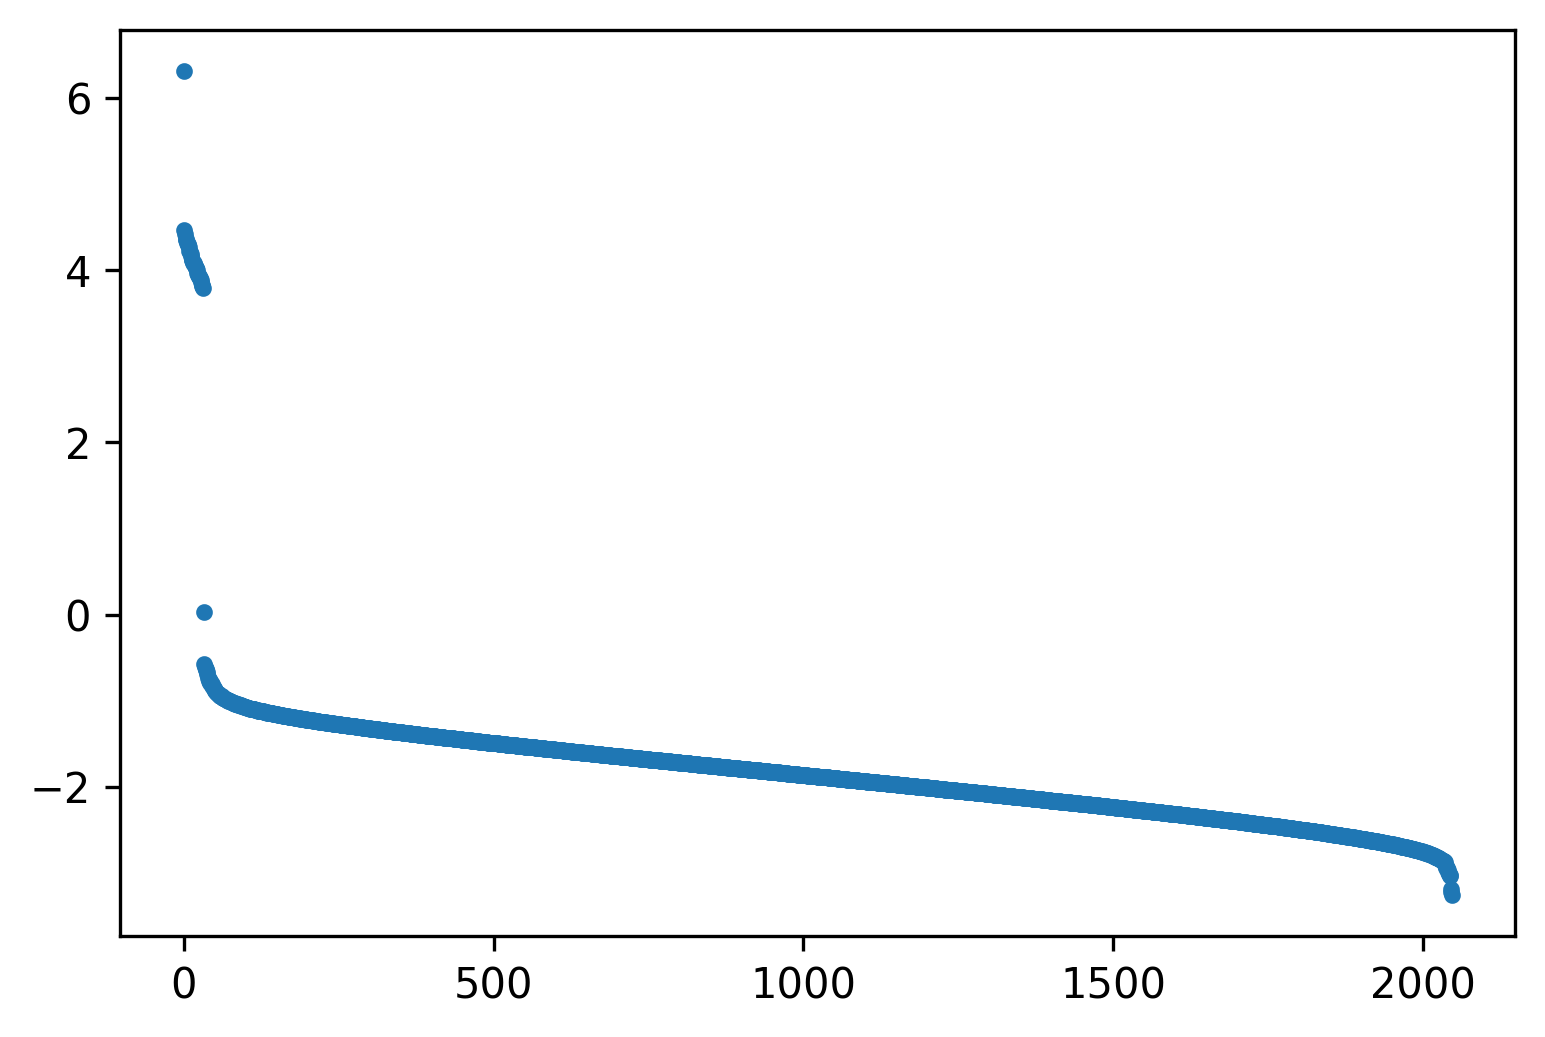

At  95 channels, alpha is 2.747622946560319
At  95 channels, RMSE/y_std is 0.07184407466696179
***************************  90  *************************
0:  |F(x)| = 0.0582777; step 1
1:  |F(x)| = 0.00192792; step 1
2:  |F(x)| = 0.00198879; step 1
3:  |F(x)| = 0.001991; step 1
4:  |F(x)| = 0.001991; step 1
5:  |F(x)| = 0.001991; step 1
6:  |F(x)| = 0.001991; step 1
7:  |F(x)| = 0.001991; step 1
8:  |F(x)| = 0.001991; step 1
9:  |F(x)| = 0.001991; step 1
10:  |F(x)| = 0.001991; step 1
11:  |F(x)| = 0.001991; step 1
12:  |F(x)| = 0.00200393; step 1
13:  |F(x)| = 0.00206461; step 1
14:  |F(x)| = 0.00197961; step 1
15:  |F(x)| = 0.00193019; step 1
16:  |F(x)| = 0.0020137; step 0.49785
17:  |F(x)| = 0.0019892; step 0.210489
18:  |F(x)| = 0.00273068; step 1
19:  |F(x)| = 0.00194179; step 1
20:  |F(x)| = 0.00184121; step 1
21:  |F(x)| = 0.000965647; step 1
22:  |F(x)| = 0.000442051; step 1
23:  |F(x)| = 0.000354576; step 1
24:  |F(x)| = 0.000131954; step 1
25:  |F(x)| = 0.000216076; step 1
2

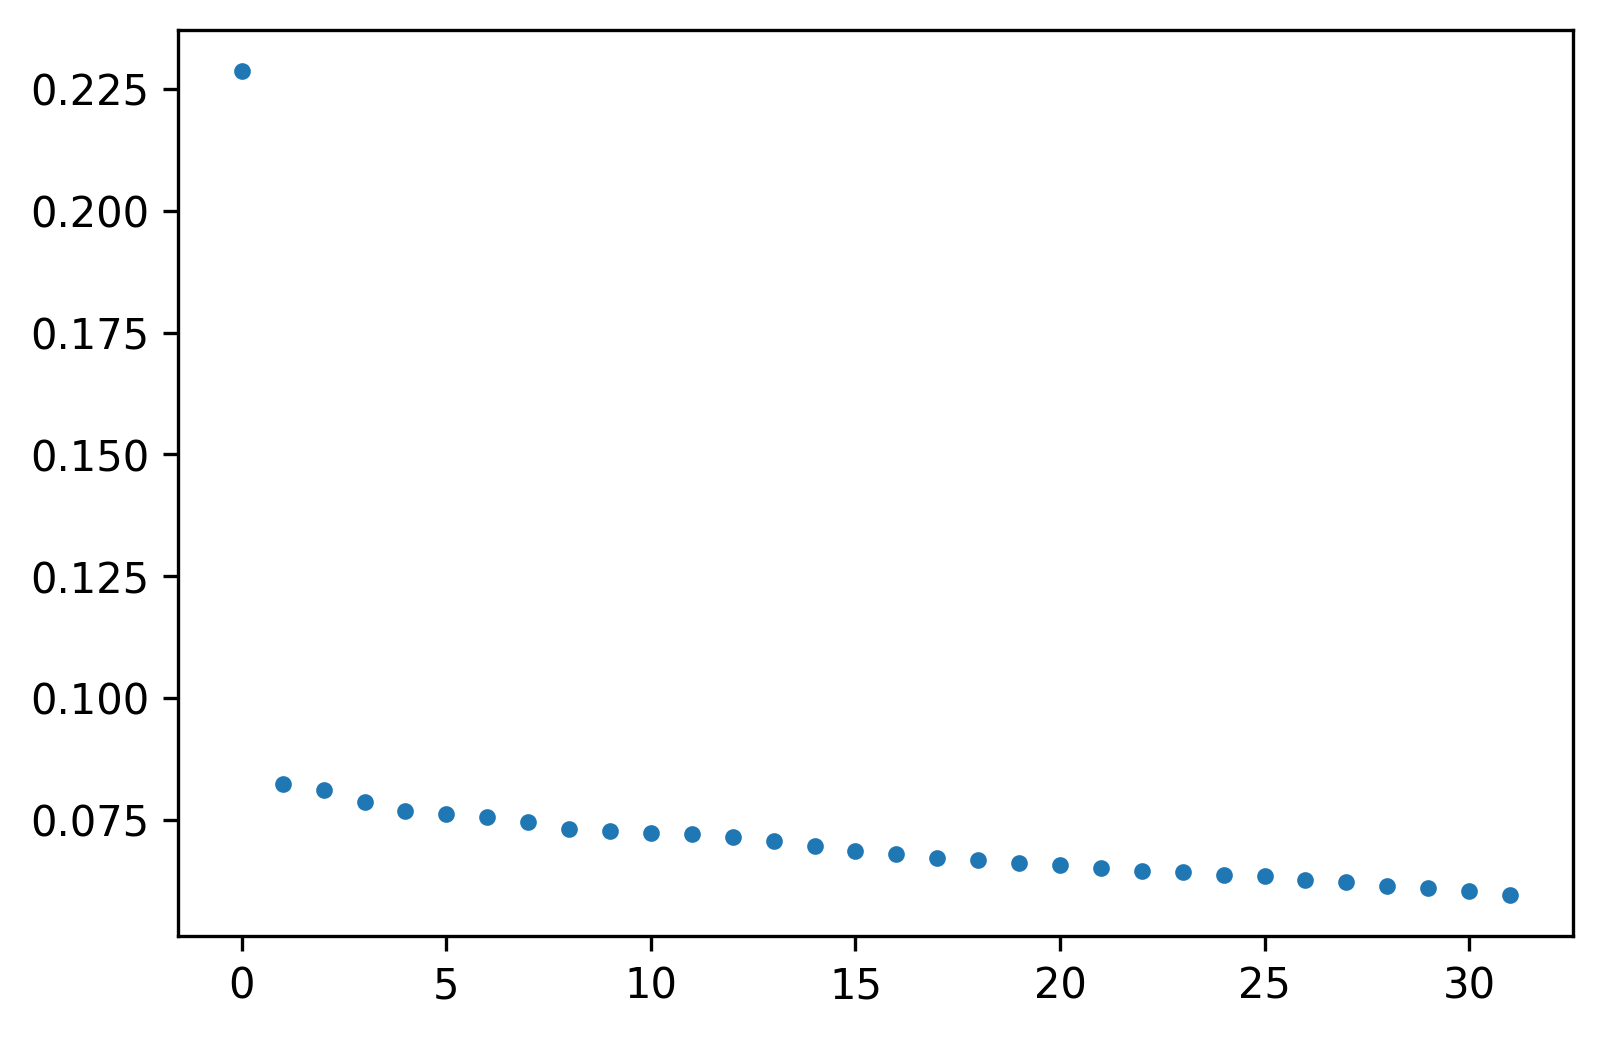

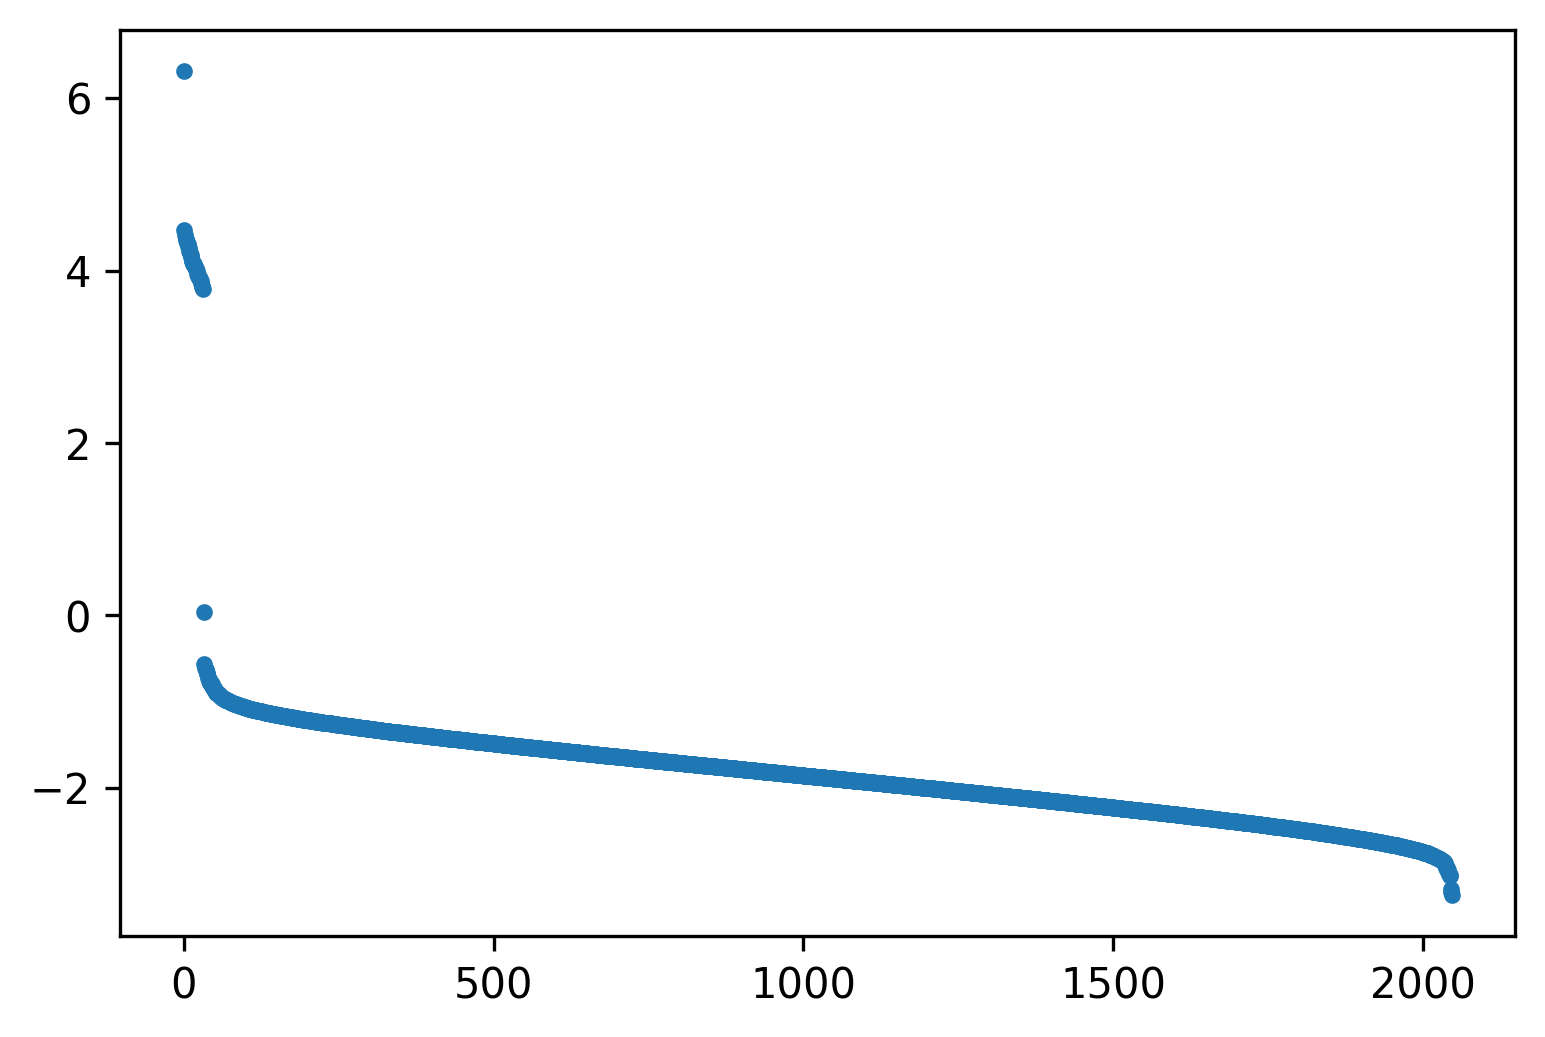

At  90 channels, alpha is 2.686924117813942
At  90 channels, RMSE/y_std is 0.07168351375557047


In [15]:
import matplotlib.pyplot as plt

# Channel annealing schedule. This required fine tuning, as making the gaps too large leads to convergence issues
Cs = [100000,30000,20000,15000,10000,8000,7000,6000,5000,4000,3000,2000,1800,1600,1400,1200,1000,900,800,700,650,600,570,530,500,470,430,400,370,350,330,310,290,270,250,230,210,200,190,180,170,160,150,140,130,120,110,100,95,90]

#x_res = np.load('FCN_newton_n_512_N_'+str(C)+'_d32_Nteacher_1.npz')['last_x_res'] # In case one needs to restart the annealing processes, we load the last result 

for C in Cs[1:]:
    
    print('*************************** ',C,' *************************')
    F = lambda x: rootEq(x,X_train,Y_train,C,C)

    x_res += [scipy.optimize.newton_krylov(F, x_res[-1],verbose=True)]   
    np.savez('FCN_newton_n_'+str(n_train)+'_N_'+str(C)+'_d'+str(d)+'_Nteacher_'+str(N)+'.npz',last_x_res=x_res[-1]) # Saving current results 
    Sigma = Sigma0*0
    Sigma[ind] = x_res[-1][0:ind[0].shape[0]]
    Sigma = Sigma + Sigma.T - np.diag(np.diag(Sigma))
    K1 = np.zeros((n_train,n_train))
    K1[indK] = x_res[-1][ind[0].shape[0]:]
    K1 = K1 + K1.T - np.diag(np.diag(K1))
    w,v = np.linalg.eig(Sigma)
    plt.plot(range(d),-np.sort(-w),'.')
    plt.show()
    w,v = np.linalg.eig(K1)
    plt.plot(range(n_train),np.log(np.abs(-np.sort(-w))),'.')
    plt.show()
   # print(Sigma)
    x = X_train
    Qf = getQf(K1)
    tbar = gettbar(X_train,Y_train,Qf)
    
    fluc = np.trace(Qf - Qf@np.linalg.inv(Qf+np.eye(n_train)*sig2)@Qf)/n_train


    print('At ',C,'channels, alpha is',np.sum(tbar*Y_train)/np.sum(Y_train*Y_train)) 
    print('At ',C,'channels, RMSE/y_std is',np.sqrt(((sig2**2)*np.mean(tbar**2)+fluc)/np.var(Y_train))) 


In [32]:
# Reload and re-print all saved results 

for C in Cs[1:]:
    x_res = np.load('FCN_newton_n_'+str(n_train)+'_N_'+str(C)+'_d'+str(d)+'_Nteacher_'+str(N)+'.npz')['last_x_res']
    Sigma0 = sigw2*np.eye(d)/np.float(d)
    ind = np.triu_indices(d, k=0)
    Sigma0[ind] = x_res[0:ind[0].shape[0]]

    Sigma = Sigma0 + Sigma0.T - np.diag(np.diag(Sigma0))
    K1 = np.zeros((n_train,n_train))
    K1[indK] = x_res[ind[0].shape[0]:]
    K1 = K1 + K1.T - np.diag(np.diag(K1))
  
   # print(Sigma)
    x = X_train
    Qf = getQf(K1)
    tbar = gettbar(X_train,Y_train,Qf)
    
    fluc = np.trace(Qf - Qf@np.linalg.inv(Qf+np.eye(n_train)*sig2)@Qf)/n_train


    print('At ',C,'channels, alpha is',np.sum(tbar*Y_train)/np.sum(Y_train*Y_train)) 
    print('At ',C,'channels, RMSE/y_std is',np.sqrt(((sig2**2)*np.mean(tbar**2)+fluc)/np.var(Y_train))) 

At  30000 channels, alpha is 22.304935299045635
At  30000 channels, RMSE/y_std is 0.1162400829572338
At  20000 channels, alpha is 21.244717855326186
At  20000 channels, RMSE/y_std is 0.11390860972019122
At  15000 channels, alpha is 20.265508563771075
At  15000 channels, RMSE/y_std is 0.1117077352206683
At  10000 channels, alpha is 18.52281234656871
At  10000 channels, RMSE/y_std is 0.10769073146151416
At  8000 channels, alpha is 17.37268973474825
At  8000 channels, RMSE/y_std is 0.10498096475868071
At  7000 channels, alpha is 16.632086836368245
At  7000 channels, RMSE/y_std is 0.10321759295286452
At  6000 channels, alpha is 15.730749767393732
At  6000 channels, RMSE/y_std is 0.1010573093727808
At  5000 channels, alpha is 14.620294642687206
At  5000 channels, RMSE/y_std is 0.09838447816446551
At  4000 channels, alpha is 13.244440377965265
At  4000 channels, RMSE/y_std is 0.0950780302090651
At  3000 channels, alpha is 11.525337642162752
At  3000 channels, RMSE/y_std is 0.0910054426011547